In [72]:
from keras.datasets.fashion_mnist import load_data

(trainX, trainY), (testX, testY) = load_data()

In [73]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

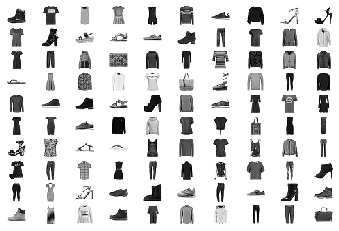

In [74]:
import matplotlib.pyplot as plt
for i in range(100):
    plt.subplot(10, 10, 1+i)
    plt.axis('off')
    plt.imshow(trainX[i], cmap='gray_r')

# Unconditional GAN

In [75]:
from keras.models import Sequential
from keras.layers import Conv2D, LeakyReLU, Flatten, Dropout, Dense, Conv2DTranspose, Reshape
from keras.optimizers import Adam

In [76]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    # downsample generator output twice
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classify
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile
    # beta_1 is momentum
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer, metrics=['accuracy'])
    return model

In [77]:
def define_generator(latent_dim):
    model = Sequential()
    # first make low-dimensional representation of latent space (7x7)
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    # upsample to full-res
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    # don't compile model since it's not trained directly
    return model

In [78]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    gan_opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=gan_opt)
    return model

In [79]:
import numpy as  np

# data-prepping
def load_real_samples():
    # we only need images in training dataset
    (trainX, _), (_,_) = load_data()
    # add 3d channels to images b/c generator assumes color channels
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return X

In [80]:
def generate_real_samples(dataset, n_samples):
    # randomly sample indices
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    # these are all real, so expected discriminator output is 1
    y = np.ones((n_samples, 1))
    return X, y

In [81]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into network-friendly inputs
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [82]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # get random points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    # these are all fake, so expected discriminator output is 0
    y = np.zeros((n_samples, 1))
    return X, y

In [83]:
def train(g_model, d_model, gan_model, dataset, latent_dim,
         n_epochs=100, n_batch=128):
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        # do a batch
        for j in range(batch_per_epoch):
            # get real samples for half of the batch
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # send through discriminator
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # get fake samples for other half of batch
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # send through discriminator
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # get latent space points to send through generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # we pretent the fake samples are real b/c the generator is trained opposite to the discriminator
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # print this batch's loss
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % 
                  (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
    # save generator model b/c that's what's useful
    g_model.save('unconditional_generator.h5')

In [84]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=True, min_cuda_compute_capability=(7,5))


True

In [87]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim)

C:\Users\centa\.conda\envs\ds\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/468, d1=0.724, d2=0.696 g=0.691
>1, 2/468, d1=0.646, d2=0.700 g=0.687
>1, 3/468, d1=0.568, d2=0.711 g=0.677
>1, 4/468, d1=0.508, d2=0.729 g=0.662
>1, 5/468, d1=0.456, d2=0.754 g=0.640


C:\Users\centa\.conda\envs\ds\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 6/468, d1=0.405, d2=0.792 g=0.613
>1, 7/468, d1=0.361, d2=0.834 g=0.593
>1, 8/468, d1=0.330, d2=0.862 g=0.584
>1, 9/468, d1=0.328, d2=0.859 g=0.605
>1, 10/468, d1=0.322, d2=0.822 g=0.669
>1, 11/468, d1=0.304, d2=0.727 g=0.761
>1, 12/468, d1=0.345, d2=0.639 g=0.883
>1, 13/468, d1=0.332, d2=0.521 g=1.027
>1, 14/468, d1=0.362, d2=0.454 g=1.125
>1, 15/468, d1=0.391, d2=0.429 g=1.148
>1, 16/468, d1=0.378, d2=0.461 g=1.074
>1, 17/468, d1=0.343, d2=0.527 g=0.930
>1, 18/468, d1=0.276, d2=0.612 g=0.810
>1, 19/468, d1=0.285, d2=0.723 g=0.698
>1, 20/468, d1=0.315, d2=0.862 g=0.600
>1, 21/468, d1=0.291, d2=1.000 g=0.533
>1, 22/468, d1=0.204, d2=1.049 g=0.518
>1, 23/468, d1=0.188, d2=1.013 g=0.548
>1, 24/468, d1=0.158, d2=0.933 g=0.607
>1, 25/468, d1=0.171, d2=0.849 g=0.685
>1, 26/468, d1=0.193, d2=0.746 g=0.811
>1, 27/468, d1=0.141, d2=0.601 g=1.003
>1, 28/468, d1=0.134, d2=0.450 g=1.226
>1, 29/468, d1=0.115, d2=0.379 g=1.363
>1, 30/468, d1=0.106, d2=0.367 g=1.310
>1, 31/468, d1=0.109, d2=0.42

>1, 217/468, d1=0.721, d2=0.872 g=0.641
>1, 218/468, d1=0.769, d2=0.859 g=0.646
>1, 219/468, d1=0.777, d2=0.846 g=0.650
>1, 220/468, d1=0.739, d2=0.824 g=0.677
>1, 221/468, d1=0.778, d2=0.827 g=0.694
>1, 222/468, d1=0.735, d2=0.811 g=0.694
>1, 223/468, d1=0.736, d2=0.795 g=0.723
>1, 224/468, d1=0.740, d2=0.744 g=0.744
>1, 225/468, d1=0.735, d2=0.737 g=0.756
>1, 226/468, d1=0.708, d2=0.720 g=0.757
>1, 227/468, d1=0.724, d2=0.704 g=0.783
>1, 228/468, d1=0.705, d2=0.696 g=0.813
>1, 229/468, d1=0.717, d2=0.677 g=0.816
>1, 230/468, d1=0.704, d2=0.660 g=0.828
>1, 231/468, d1=0.709, d2=0.662 g=0.857
>1, 232/468, d1=0.739, d2=0.649 g=0.861
>1, 233/468, d1=0.703, d2=0.634 g=0.865
>1, 234/468, d1=0.711, d2=0.648 g=0.840
>1, 235/468, d1=0.685, d2=0.646 g=0.850
>1, 236/468, d1=0.644, d2=0.663 g=0.815
>1, 237/468, d1=0.738, d2=0.710 g=0.766
>1, 238/468, d1=0.651, d2=0.724 g=0.730
>1, 239/468, d1=0.705, d2=0.731 g=0.705
>1, 240/468, d1=0.740, d2=0.780 g=0.678
>1, 241/468, d1=0.697, d2=0.784 g=0.672


>1, 425/468, d1=0.685, d2=0.607 g=0.850
>1, 426/468, d1=0.633, d2=0.627 g=0.844
>1, 427/468, d1=0.682, d2=0.654 g=0.783
>1, 428/468, d1=0.667, d2=0.683 g=0.771
>1, 429/468, d1=0.751, d2=0.738 g=0.727
>1, 430/468, d1=0.686, d2=0.731 g=0.708
>1, 431/468, d1=0.726, d2=0.783 g=0.682
>1, 432/468, d1=0.728, d2=0.777 g=0.709
>1, 433/468, d1=0.697, d2=0.761 g=0.707
>1, 434/468, d1=0.670, d2=0.729 g=0.693
>1, 435/468, d1=0.725, d2=0.717 g=0.711
>1, 436/468, d1=0.719, d2=0.674 g=0.778
>1, 437/468, d1=0.736, d2=0.679 g=0.806
>1, 438/468, d1=0.725, d2=0.651 g=0.820
>1, 439/468, d1=0.713, d2=0.619 g=0.865
>1, 440/468, d1=0.698, d2=0.579 g=0.890
>1, 441/468, d1=0.703, d2=0.568 g=0.940
>1, 442/468, d1=0.697, d2=0.550 g=0.915
>1, 443/468, d1=0.709, d2=0.593 g=0.925
>1, 444/468, d1=0.675, d2=0.607 g=0.875
>1, 445/468, d1=0.705, d2=0.657 g=0.804
>1, 446/468, d1=0.649, d2=0.666 g=0.778
>1, 447/468, d1=0.689, d2=0.741 g=0.720
>1, 448/468, d1=0.651, d2=0.766 g=0.704
>1, 449/468, d1=0.671, d2=0.757 g=0.650


>2, 169/468, d1=0.689, d2=0.623 g=0.804
>2, 170/468, d1=0.721, d2=0.618 g=0.822
>2, 171/468, d1=0.716, d2=0.635 g=0.806
>2, 172/468, d1=0.715, d2=0.621 g=0.792
>2, 173/468, d1=0.725, d2=0.656 g=0.801
>2, 174/468, d1=0.697, d2=0.661 g=0.768
>2, 175/468, d1=0.730, d2=0.676 g=0.755
>2, 176/468, d1=0.713, d2=0.674 g=0.741
>2, 177/468, d1=0.702, d2=0.705 g=0.703
>2, 178/468, d1=0.747, d2=0.710 g=0.703
>2, 179/468, d1=0.680, d2=0.714 g=0.706
>2, 180/468, d1=0.717, d2=0.737 g=0.698
>2, 181/468, d1=0.724, d2=0.734 g=0.730
>2, 182/468, d1=0.734, d2=0.678 g=0.765
>2, 183/468, d1=0.715, d2=0.682 g=0.759
>2, 184/468, d1=0.717, d2=0.637 g=0.789
>2, 185/468, d1=0.730, d2=0.627 g=0.813
>2, 186/468, d1=0.722, d2=0.609 g=0.846
>2, 187/468, d1=0.697, d2=0.601 g=0.865
>2, 188/468, d1=0.734, d2=0.578 g=0.879
>2, 189/468, d1=0.706, d2=0.568 g=0.890
>2, 190/468, d1=0.704, d2=0.572 g=0.885
>2, 191/468, d1=0.692, d2=0.579 g=0.875
>2, 192/468, d1=0.682, d2=0.608 g=0.838
>2, 193/468, d1=0.687, d2=0.605 g=0.823


>2, 377/468, d1=0.703, d2=0.612 g=0.814
>2, 378/468, d1=0.686, d2=0.634 g=0.820
>2, 379/468, d1=0.681, d2=0.625 g=0.780
>2, 380/468, d1=0.700, d2=0.638 g=0.779
>2, 381/468, d1=0.699, d2=0.682 g=0.741
>2, 382/468, d1=0.708, d2=0.704 g=0.715
>2, 383/468, d1=0.717, d2=0.752 g=0.692
>2, 384/468, d1=0.702, d2=0.742 g=0.706
>2, 385/468, d1=0.664, d2=0.726 g=0.695
>2, 386/468, d1=0.691, d2=0.724 g=0.695
>2, 387/468, d1=0.680, d2=0.712 g=0.704
>2, 388/468, d1=0.687, d2=0.703 g=0.716
>2, 389/468, d1=0.670, d2=0.697 g=0.731
>2, 390/468, d1=0.682, d2=0.670 g=0.751
>2, 391/468, d1=0.651, d2=0.668 g=0.750
>2, 392/468, d1=0.664, d2=0.650 g=0.772
>2, 393/468, d1=0.692, d2=0.649 g=0.774
>2, 394/468, d1=0.661, d2=0.668 g=0.766
>2, 395/468, d1=0.691, d2=0.661 g=0.768
>2, 396/468, d1=0.691, d2=0.680 g=0.763
>2, 397/468, d1=0.666, d2=0.658 g=0.736
>2, 398/468, d1=0.718, d2=0.682 g=0.727
>2, 399/468, d1=0.667, d2=0.701 g=0.714
>2, 400/468, d1=0.676, d2=0.707 g=0.725
>2, 401/468, d1=0.666, d2=0.697 g=0.721


>3, 119/468, d1=0.656, d2=0.711 g=0.715
>3, 120/468, d1=0.643, d2=0.688 g=0.730
>3, 121/468, d1=0.711, d2=0.671 g=0.741
>3, 122/468, d1=0.691, d2=0.683 g=0.756
>3, 123/468, d1=0.672, d2=0.646 g=0.760
>3, 124/468, d1=0.676, d2=0.667 g=0.773
>3, 125/468, d1=0.705, d2=0.621 g=0.792
>3, 126/468, d1=0.681, d2=0.625 g=0.803
>3, 127/468, d1=0.708, d2=0.619 g=0.802
>3, 128/468, d1=0.664, d2=0.627 g=0.812
>3, 129/468, d1=0.680, d2=0.630 g=0.811
>3, 130/468, d1=0.697, d2=0.643 g=0.775
>3, 131/468, d1=0.702, d2=0.642 g=0.774
>3, 132/468, d1=0.669, d2=0.679 g=0.739
>3, 133/468, d1=0.716, d2=0.656 g=0.740
>3, 134/468, d1=0.667, d2=0.706 g=0.716
>3, 135/468, d1=0.672, d2=0.696 g=0.735
>3, 136/468, d1=0.686, d2=0.700 g=0.719
>3, 137/468, d1=0.663, d2=0.685 g=0.740
>3, 138/468, d1=0.682, d2=0.688 g=0.752
>3, 139/468, d1=0.705, d2=0.657 g=0.750
>3, 140/468, d1=0.666, d2=0.646 g=0.757
>3, 141/468, d1=0.679, d2=0.656 g=0.773
>3, 142/468, d1=0.679, d2=0.651 g=0.771
>3, 143/468, d1=0.666, d2=0.651 g=0.769


>3, 325/468, d1=0.676, d2=0.649 g=0.781
>3, 326/468, d1=0.700, d2=0.649 g=0.777
>3, 327/468, d1=0.680, d2=0.655 g=0.769
>3, 328/468, d1=0.673, d2=0.656 g=0.775
>3, 329/468, d1=0.663, d2=0.652 g=0.775
>3, 330/468, d1=0.676, d2=0.644 g=0.775
>3, 331/468, d1=0.669, d2=0.658 g=0.786
>3, 332/468, d1=0.662, d2=0.651 g=0.785
>3, 333/468, d1=0.673, d2=0.637 g=0.794
>3, 334/468, d1=0.676, d2=0.637 g=0.774
>3, 335/468, d1=0.664, d2=0.642 g=0.781
>3, 336/468, d1=0.650, d2=0.665 g=0.778
>3, 337/468, d1=0.686, d2=0.647 g=0.740
>3, 338/468, d1=0.666, d2=0.702 g=0.741
>3, 339/468, d1=0.686, d2=0.702 g=0.745
>3, 340/468, d1=0.682, d2=0.661 g=0.765
>3, 341/468, d1=0.699, d2=0.695 g=0.766
>3, 342/468, d1=0.702, d2=0.671 g=0.770
>3, 343/468, d1=0.697, d2=0.640 g=0.797
>3, 344/468, d1=0.714, d2=0.632 g=0.807
>3, 345/468, d1=0.743, d2=0.633 g=0.822
>3, 346/468, d1=0.715, d2=0.621 g=0.833
>3, 347/468, d1=0.717, d2=0.614 g=0.837
>3, 348/468, d1=0.701, d2=0.621 g=0.820
>3, 349/468, d1=0.684, d2=0.625 g=0.808


>4, 66/468, d1=0.675, d2=0.651 g=0.777
>4, 67/468, d1=0.652, d2=0.639 g=0.787
>4, 68/468, d1=0.659, d2=0.640 g=0.786
>4, 69/468, d1=0.648, d2=0.656 g=0.785
>4, 70/468, d1=0.648, d2=0.670 g=0.797
>4, 71/468, d1=0.669, d2=0.645 g=0.797
>4, 72/468, d1=0.660, d2=0.663 g=0.776
>4, 73/468, d1=0.667, d2=0.633 g=0.772
>4, 74/468, d1=0.686, d2=0.671 g=0.782
>4, 75/468, d1=0.647, d2=0.657 g=0.796
>4, 76/468, d1=0.685, d2=0.649 g=0.793
>4, 77/468, d1=0.691, d2=0.624 g=0.819
>4, 78/468, d1=0.717, d2=0.627 g=0.821
>4, 79/468, d1=0.705, d2=0.621 g=0.817
>4, 80/468, d1=0.695, d2=0.622 g=0.813
>4, 81/468, d1=0.681, d2=0.640 g=0.795
>4, 82/468, d1=0.710, d2=0.660 g=0.783
>4, 83/468, d1=0.699, d2=0.663 g=0.766
>4, 84/468, d1=0.715, d2=0.663 g=0.754
>4, 85/468, d1=0.707, d2=0.657 g=0.759
>4, 86/468, d1=0.678, d2=0.691 g=0.763
>4, 87/468, d1=0.692, d2=0.671 g=0.761
>4, 88/468, d1=0.669, d2=0.651 g=0.773
>4, 89/468, d1=0.686, d2=0.646 g=0.781
>4, 90/468, d1=0.669, d2=0.675 g=0.782
>4, 91/468, d1=0.664, d2=

>4, 272/468, d1=0.651, d2=0.637 g=0.761
>4, 273/468, d1=0.668, d2=0.662 g=0.750
>4, 274/468, d1=0.653, d2=0.662 g=0.760
>4, 275/468, d1=0.646, d2=0.671 g=0.769
>4, 276/468, d1=0.655, d2=0.681 g=0.756
>4, 277/468, d1=0.627, d2=0.675 g=0.746
>4, 278/468, d1=0.618, d2=0.682 g=0.744
>4, 279/468, d1=0.609, d2=0.682 g=0.749
>4, 280/468, d1=0.635, d2=0.711 g=0.750
>4, 281/468, d1=0.651, d2=0.675 g=0.798
>4, 282/468, d1=0.677, d2=0.633 g=0.817
>4, 283/468, d1=0.657, d2=0.631 g=0.838
>4, 284/468, d1=0.729, d2=0.633 g=0.819
>4, 285/468, d1=0.714, d2=0.643 g=0.793
>4, 286/468, d1=0.685, d2=0.665 g=0.763
>4, 287/468, d1=0.678, d2=0.679 g=0.748
>4, 288/468, d1=0.656, d2=0.683 g=0.755
>4, 289/468, d1=0.653, d2=0.658 g=0.806
>4, 290/468, d1=0.650, d2=0.650 g=0.804
>4, 291/468, d1=0.641, d2=0.641 g=0.784
>4, 292/468, d1=0.650, d2=0.649 g=0.772
>4, 293/468, d1=0.648, d2=0.764 g=0.740
>4, 294/468, d1=0.645, d2=0.700 g=0.757
>4, 295/468, d1=0.665, d2=0.687 g=0.799
>4, 296/468, d1=0.661, d2=0.637 g=0.838


>5, 12/468, d1=0.718, d2=0.644 g=0.785
>5, 13/468, d1=0.677, d2=0.639 g=0.774
>5, 14/468, d1=0.664, d2=0.654 g=0.783
>5, 15/468, d1=0.664, d2=0.656 g=0.791
>5, 16/468, d1=0.664, d2=0.635 g=0.788
>5, 17/468, d1=0.653, d2=0.665 g=0.777
>5, 18/468, d1=0.640, d2=0.630 g=0.773
>5, 19/468, d1=0.636, d2=0.661 g=0.757
>5, 20/468, d1=0.601, d2=0.664 g=0.776
>5, 21/468, d1=0.645, d2=0.656 g=0.786
>5, 22/468, d1=0.640, d2=0.678 g=0.779
>5, 23/468, d1=0.668, d2=0.661 g=0.764
>5, 24/468, d1=0.635, d2=0.665 g=0.788
>5, 25/468, d1=0.676, d2=0.637 g=0.804
>5, 26/468, d1=0.640, d2=0.652 g=0.808
>5, 27/468, d1=0.669, d2=0.631 g=0.844
>5, 28/468, d1=0.714, d2=0.648 g=0.817
>5, 29/468, d1=0.691, d2=0.646 g=0.768
>5, 30/468, d1=0.664, d2=0.681 g=0.774
>5, 31/468, d1=0.700, d2=0.652 g=0.776
>5, 32/468, d1=0.677, d2=0.664 g=0.776
>5, 33/468, d1=0.657, d2=0.660 g=0.778
>5, 34/468, d1=0.669, d2=0.684 g=0.770
>5, 35/468, d1=0.667, d2=0.672 g=0.748
>5, 36/468, d1=0.612, d2=0.681 g=0.756
>5, 37/468, d1=0.652, d2=

>5, 222/468, d1=0.611, d2=0.714 g=0.722
>5, 223/468, d1=0.606, d2=0.696 g=0.734
>5, 224/468, d1=0.622, d2=0.699 g=0.729
>5, 225/468, d1=0.626, d2=0.758 g=0.736
>5, 226/468, d1=0.638, d2=0.708 g=0.743
>5, 227/468, d1=0.658, d2=0.693 g=0.789
>5, 228/468, d1=0.662, d2=0.642 g=0.794
>5, 229/468, d1=0.692, d2=0.643 g=0.821
>5, 230/468, d1=0.702, d2=0.629 g=0.823
>5, 231/468, d1=0.723, d2=0.624 g=0.809
>5, 232/468, d1=0.685, d2=0.636 g=0.813
>5, 233/468, d1=0.669, d2=0.634 g=0.783
>5, 234/468, d1=0.701, d2=0.682 g=0.735
>5, 235/468, d1=0.688, d2=0.692 g=0.729
>5, 236/468, d1=0.706, d2=0.710 g=0.733
>5, 237/468, d1=0.669, d2=0.728 g=0.732
>5, 238/468, d1=0.615, d2=0.707 g=0.765
>5, 239/468, d1=0.629, d2=0.667 g=0.805
>5, 240/468, d1=0.622, d2=0.644 g=0.793
>5, 241/468, d1=0.653, d2=0.630 g=0.785
>5, 242/468, d1=0.638, d2=0.757 g=0.740
>5, 243/468, d1=0.593, d2=0.720 g=0.668
>5, 244/468, d1=0.644, d2=0.799 g=0.684
>5, 245/468, d1=0.665, d2=0.774 g=0.735
>5, 246/468, d1=0.680, d2=0.715 g=0.843


>5, 429/468, d1=0.640, d2=0.732 g=0.751
>5, 430/468, d1=0.692, d2=0.676 g=0.775
>5, 431/468, d1=0.716, d2=0.638 g=0.811
>5, 432/468, d1=0.733, d2=0.627 g=0.871
>5, 433/468, d1=0.761, d2=0.601 g=0.890
>5, 434/468, d1=0.716, d2=0.606 g=0.874
>5, 435/468, d1=0.694, d2=0.588 g=0.846
>5, 436/468, d1=0.735, d2=0.603 g=0.868
>5, 437/468, d1=0.704, d2=0.671 g=0.756
>5, 438/468, d1=0.748, d2=0.693 g=0.745
>5, 439/468, d1=0.729, d2=0.713 g=0.714
>5, 440/468, d1=0.712, d2=0.730 g=0.707
>5, 441/468, d1=0.689, d2=0.698 g=0.753
>5, 442/468, d1=0.639, d2=0.649 g=0.791
>5, 443/468, d1=0.623, d2=0.627 g=0.843
>5, 444/468, d1=0.677, d2=0.627 g=0.815
>5, 445/468, d1=0.655, d2=0.646 g=0.809
>5, 446/468, d1=0.663, d2=0.669 g=0.763
>5, 447/468, d1=0.619, d2=0.742 g=0.730
>5, 448/468, d1=0.683, d2=0.739 g=0.695
>5, 449/468, d1=0.661, d2=0.768 g=0.687
>5, 450/468, d1=0.644, d2=0.776 g=0.704
>5, 451/468, d1=0.671, d2=0.727 g=0.761
>5, 452/468, d1=0.711, d2=0.667 g=0.805
>5, 453/468, d1=0.708, d2=0.637 g=0.851


>6, 170/468, d1=0.684, d2=0.652 g=0.779
>6, 171/468, d1=0.712, d2=0.652 g=0.782
>6, 172/468, d1=0.699, d2=0.644 g=0.786
>6, 173/468, d1=0.700, d2=0.650 g=0.787
>6, 174/468, d1=0.684, d2=0.654 g=0.775
>6, 175/468, d1=0.721, d2=0.667 g=0.745
>6, 176/468, d1=0.697, d2=0.694 g=0.726
>6, 177/468, d1=0.687, d2=0.704 g=0.714
>6, 178/468, d1=0.661, d2=0.704 g=0.713
>6, 179/468, d1=0.678, d2=0.703 g=0.737
>6, 180/468, d1=0.668, d2=0.695 g=0.748
>6, 181/468, d1=0.670, d2=0.694 g=0.726
>6, 182/468, d1=0.639, d2=0.708 g=0.724
>6, 183/468, d1=0.675, d2=0.712 g=0.737
>6, 184/468, d1=0.673, d2=0.731 g=0.706
>6, 185/468, d1=0.659, d2=0.710 g=0.711
>6, 186/468, d1=0.653, d2=0.722 g=0.702
>6, 187/468, d1=0.676, d2=0.700 g=0.715
>6, 188/468, d1=0.666, d2=0.701 g=0.716
>6, 189/468, d1=0.680, d2=0.680 g=0.743
>6, 190/468, d1=0.688, d2=0.681 g=0.749
>6, 191/468, d1=0.699, d2=0.715 g=0.743
>6, 192/468, d1=0.709, d2=0.673 g=0.734
>6, 193/468, d1=0.689, d2=0.672 g=0.728
>6, 194/468, d1=0.682, d2=0.686 g=0.746


>6, 375/468, d1=0.701, d2=0.657 g=0.769
>6, 376/468, d1=0.711, d2=0.653 g=0.747
>6, 377/468, d1=0.694, d2=0.673 g=0.736
>6, 378/468, d1=0.701, d2=0.695 g=0.732
>6, 379/468, d1=0.690, d2=0.690 g=0.728
>6, 380/468, d1=0.695, d2=0.693 g=0.725
>6, 381/468, d1=0.696, d2=0.681 g=0.720
>6, 382/468, d1=0.684, d2=0.664 g=0.738
>6, 383/468, d1=0.648, d2=0.698 g=0.715
>6, 384/468, d1=0.684, d2=0.711 g=0.713
>6, 385/468, d1=0.692, d2=0.704 g=0.711
>6, 386/468, d1=0.683, d2=0.711 g=0.711
>6, 387/468, d1=0.666, d2=0.707 g=0.713
>6, 388/468, d1=0.690, d2=0.718 g=0.724
>6, 389/468, d1=0.681, d2=0.678 g=0.737
>6, 390/468, d1=0.699, d2=0.683 g=0.734
>6, 391/468, d1=0.708, d2=0.691 g=0.740
>6, 392/468, d1=0.714, d2=0.689 g=0.746
>6, 393/468, d1=0.705, d2=0.701 g=0.741
>6, 394/468, d1=0.683, d2=0.689 g=0.727
>6, 395/468, d1=0.685, d2=0.670 g=0.730
>6, 396/468, d1=0.697, d2=0.691 g=0.723
>6, 397/468, d1=0.697, d2=0.690 g=0.736
>6, 398/468, d1=0.691, d2=0.678 g=0.718
>6, 399/468, d1=0.690, d2=0.686 g=0.740


>7, 118/468, d1=0.678, d2=0.697 g=0.711
>7, 119/468, d1=0.688, d2=0.692 g=0.727
>7, 120/468, d1=0.696, d2=0.683 g=0.726
>7, 121/468, d1=0.677, d2=0.690 g=0.717
>7, 122/468, d1=0.685, d2=0.690 g=0.723
>7, 123/468, d1=0.664, d2=0.704 g=0.712
>7, 124/468, d1=0.698, d2=0.682 g=0.725
>7, 125/468, d1=0.694, d2=0.676 g=0.711
>7, 126/468, d1=0.702, d2=0.697 g=0.724
>7, 127/468, d1=0.698, d2=0.698 g=0.739
>7, 128/468, d1=0.697, d2=0.685 g=0.714
>7, 129/468, d1=0.695, d2=0.693 g=0.725
>7, 130/468, d1=0.711, d2=0.678 g=0.735
>7, 131/468, d1=0.701, d2=0.683 g=0.738
>7, 132/468, d1=0.712, d2=0.674 g=0.729
>7, 133/468, d1=0.687, d2=0.684 g=0.728
>7, 134/468, d1=0.699, d2=0.688 g=0.725
>7, 135/468, d1=0.702, d2=0.691 g=0.724
>7, 136/468, d1=0.702, d2=0.678 g=0.722
>7, 137/468, d1=0.698, d2=0.700 g=0.731
>7, 138/468, d1=0.704, d2=0.676 g=0.730
>7, 139/468, d1=0.672, d2=0.678 g=0.715
>7, 140/468, d1=0.686, d2=0.705 g=0.705
>7, 141/468, d1=0.695, d2=0.685 g=0.695
>7, 142/468, d1=0.680, d2=0.705 g=0.715


>7, 327/468, d1=0.690, d2=0.694 g=0.722
>7, 328/468, d1=0.695, d2=0.680 g=0.730
>7, 329/468, d1=0.698, d2=0.670 g=0.744
>7, 330/468, d1=0.671, d2=0.691 g=0.733
>7, 331/468, d1=0.710, d2=0.709 g=0.750
>7, 332/468, d1=0.677, d2=0.690 g=0.713
>7, 333/468, d1=0.660, d2=0.707 g=0.725
>7, 334/468, d1=0.681, d2=0.707 g=0.704
>7, 335/468, d1=0.682, d2=0.729 g=0.710
>7, 336/468, d1=0.675, d2=0.716 g=0.719
>7, 337/468, d1=0.697, d2=0.702 g=0.730
>7, 338/468, d1=0.715, d2=0.673 g=0.747
>7, 339/468, d1=0.716, d2=0.665 g=0.747
>7, 340/468, d1=0.682, d2=0.679 g=0.755
>7, 341/468, d1=0.708, d2=0.672 g=0.747
>7, 342/468, d1=0.679, d2=0.678 g=0.742
>7, 343/468, d1=0.694, d2=0.703 g=0.740
>7, 344/468, d1=0.697, d2=0.697 g=0.733
>7, 345/468, d1=0.715, d2=0.696 g=0.707
>7, 346/468, d1=0.681, d2=0.702 g=0.725
>7, 347/468, d1=0.700, d2=0.695 g=0.713
>7, 348/468, d1=0.700, d2=0.669 g=0.729
>7, 349/468, d1=0.694, d2=0.680 g=0.739
>7, 350/468, d1=0.672, d2=0.684 g=0.727
>7, 351/468, d1=0.678, d2=0.688 g=0.737


>8, 68/468, d1=0.703, d2=0.700 g=0.726
>8, 69/468, d1=0.682, d2=0.684 g=0.747
>8, 70/468, d1=0.684, d2=0.677 g=0.749
>8, 71/468, d1=0.693, d2=0.693 g=0.744
>8, 72/468, d1=0.656, d2=0.686 g=0.732
>8, 73/468, d1=0.701, d2=0.718 g=0.714
>8, 74/468, d1=0.689, d2=0.701 g=0.700
>8, 75/468, d1=0.702, d2=0.728 g=0.704
>8, 76/468, d1=0.673, d2=0.715 g=0.698
>8, 77/468, d1=0.677, d2=0.714 g=0.707
>8, 78/468, d1=0.694, d2=0.695 g=0.729
>8, 79/468, d1=0.697, d2=0.661 g=0.767
>8, 80/468, d1=0.718, d2=0.651 g=0.791
>8, 81/468, d1=0.705, d2=0.655 g=0.768
>8, 82/468, d1=0.709, d2=0.661 g=0.770
>8, 83/468, d1=0.725, d2=0.653 g=0.761
>8, 84/468, d1=0.731, d2=0.675 g=0.734
>8, 85/468, d1=0.723, d2=0.685 g=0.733
>8, 86/468, d1=0.709, d2=0.713 g=0.711
>8, 87/468, d1=0.710, d2=0.696 g=0.713
>8, 88/468, d1=0.685, d2=0.688 g=0.721
>8, 89/468, d1=0.687, d2=0.678 g=0.730
>8, 90/468, d1=0.686, d2=0.672 g=0.736
>8, 91/468, d1=0.674, d2=0.670 g=0.752
>8, 92/468, d1=0.705, d2=0.710 g=0.730
>8, 93/468, d1=0.694, d2=

>8, 276/468, d1=0.702, d2=0.696 g=0.709
>8, 277/468, d1=0.676, d2=0.695 g=0.725
>8, 278/468, d1=0.702, d2=0.699 g=0.711
>8, 279/468, d1=0.695, d2=0.711 g=0.707
>8, 280/468, d1=0.703, d2=0.698 g=0.718
>8, 281/468, d1=0.700, d2=0.705 g=0.704
>8, 282/468, d1=0.705, d2=0.699 g=0.726
>8, 283/468, d1=0.701, d2=0.669 g=0.748
>8, 284/468, d1=0.703, d2=0.665 g=0.756
>8, 285/468, d1=0.705, d2=0.682 g=0.742
>8, 286/468, d1=0.715, d2=0.689 g=0.731
>8, 287/468, d1=0.714, d2=0.685 g=0.725
>8, 288/468, d1=0.709, d2=0.679 g=0.716
>8, 289/468, d1=0.699, d2=0.706 g=0.727
>8, 290/468, d1=0.691, d2=0.679 g=0.719
>8, 291/468, d1=0.690, d2=0.674 g=0.722
>8, 292/468, d1=0.690, d2=0.684 g=0.731
>8, 293/468, d1=0.685, d2=0.680 g=0.729
>8, 294/468, d1=0.675, d2=0.694 g=0.729
>8, 295/468, d1=0.692, d2=0.700 g=0.707
>8, 296/468, d1=0.679, d2=0.689 g=0.701
>8, 297/468, d1=0.671, d2=0.713 g=0.718
>8, 298/468, d1=0.681, d2=0.698 g=0.721
>8, 299/468, d1=0.698, d2=0.687 g=0.718
>8, 300/468, d1=0.701, d2=0.682 g=0.731


>9, 14/468, d1=0.681, d2=0.694 g=0.727
>9, 15/468, d1=0.691, d2=0.698 g=0.730
>9, 16/468, d1=0.683, d2=0.680 g=0.720
>9, 17/468, d1=0.713, d2=0.687 g=0.712
>9, 18/468, d1=0.686, d2=0.689 g=0.716
>9, 19/468, d1=0.692, d2=0.696 g=0.720
>9, 20/468, d1=0.690, d2=0.691 g=0.714
>9, 21/468, d1=0.684, d2=0.685 g=0.722
>9, 22/468, d1=0.695, d2=0.686 g=0.713
>9, 23/468, d1=0.690, d2=0.707 g=0.698
>9, 24/468, d1=0.696, d2=0.719 g=0.716
>9, 25/468, d1=0.692, d2=0.698 g=0.712
>9, 26/468, d1=0.697, d2=0.706 g=0.720
>9, 27/468, d1=0.694, d2=0.689 g=0.725
>9, 28/468, d1=0.681, d2=0.682 g=0.729
>9, 29/468, d1=0.698, d2=0.693 g=0.731
>9, 30/468, d1=0.704, d2=0.653 g=0.724
>9, 31/468, d1=0.712, d2=0.681 g=0.736
>9, 32/468, d1=0.722, d2=0.676 g=0.723
>9, 33/468, d1=0.693, d2=0.690 g=0.730
>9, 34/468, d1=0.709, d2=0.671 g=0.730
>9, 35/468, d1=0.690, d2=0.686 g=0.731
>9, 36/468, d1=0.705, d2=0.686 g=0.724
>9, 37/468, d1=0.704, d2=0.680 g=0.723
>9, 38/468, d1=0.697, d2=0.668 g=0.720
>9, 39/468, d1=0.709, d2=

>9, 225/468, d1=0.685, d2=0.699 g=0.707
>9, 226/468, d1=0.693, d2=0.708 g=0.715
>9, 227/468, d1=0.688, d2=0.687 g=0.701
>9, 228/468, d1=0.694, d2=0.691 g=0.700
>9, 229/468, d1=0.685, d2=0.703 g=0.719
>9, 230/468, d1=0.686, d2=0.681 g=0.732
>9, 231/468, d1=0.697, d2=0.690 g=0.726
>9, 232/468, d1=0.689, d2=0.691 g=0.721
>9, 233/468, d1=0.698, d2=0.692 g=0.728
>9, 234/468, d1=0.703, d2=0.679 g=0.727
>9, 235/468, d1=0.696, d2=0.681 g=0.723
>9, 236/468, d1=0.701, d2=0.687 g=0.723
>9, 237/468, d1=0.680, d2=0.701 g=0.714
>9, 238/468, d1=0.694, d2=0.687 g=0.718
>9, 239/468, d1=0.697, d2=0.695 g=0.706
>9, 240/468, d1=0.677, d2=0.704 g=0.702
>9, 241/468, d1=0.701, d2=0.707 g=0.704
>9, 242/468, d1=0.673, d2=0.705 g=0.726
>9, 243/468, d1=0.695, d2=0.687 g=0.726
>9, 244/468, d1=0.675, d2=0.698 g=0.732
>9, 245/468, d1=0.681, d2=0.684 g=0.732
>9, 246/468, d1=0.696, d2=0.687 g=0.729
>9, 247/468, d1=0.706, d2=0.680 g=0.721
>9, 248/468, d1=0.710, d2=0.695 g=0.718
>9, 249/468, d1=0.722, d2=0.689 g=0.723


>9, 432/468, d1=0.680, d2=0.692 g=0.722
>9, 433/468, d1=0.685, d2=0.694 g=0.714
>9, 434/468, d1=0.664, d2=0.693 g=0.711
>9, 435/468, d1=0.677, d2=0.687 g=0.704
>9, 436/468, d1=0.686, d2=0.693 g=0.712
>9, 437/468, d1=0.682, d2=0.695 g=0.710
>9, 438/468, d1=0.693, d2=0.725 g=0.704
>9, 439/468, d1=0.669, d2=0.700 g=0.703
>9, 440/468, d1=0.691, d2=0.701 g=0.706
>9, 441/468, d1=0.684, d2=0.712 g=0.725
>9, 442/468, d1=0.692, d2=0.681 g=0.710
>9, 443/468, d1=0.691, d2=0.693 g=0.723
>9, 444/468, d1=0.688, d2=0.694 g=0.718
>9, 445/468, d1=0.690, d2=0.694 g=0.716
>9, 446/468, d1=0.683, d2=0.689 g=0.718
>9, 447/468, d1=0.699, d2=0.700 g=0.725
>9, 448/468, d1=0.687, d2=0.693 g=0.722
>9, 449/468, d1=0.686, d2=0.686 g=0.726
>9, 450/468, d1=0.690, d2=0.693 g=0.715
>9, 451/468, d1=0.705, d2=0.696 g=0.715
>9, 452/468, d1=0.698, d2=0.684 g=0.713
>9, 453/468, d1=0.691, d2=0.687 g=0.723
>9, 454/468, d1=0.695, d2=0.690 g=0.717
>9, 455/468, d1=0.683, d2=0.689 g=0.703
>9, 456/468, d1=0.697, d2=0.686 g=0.714


>10, 167/468, d1=0.694, d2=0.688 g=0.714
>10, 168/468, d1=0.689, d2=0.691 g=0.722
>10, 169/468, d1=0.695, d2=0.694 g=0.704
>10, 170/468, d1=0.690, d2=0.695 g=0.720
>10, 171/468, d1=0.687, d2=0.691 g=0.720
>10, 172/468, d1=0.688, d2=0.693 g=0.727
>10, 173/468, d1=0.691, d2=0.672 g=0.730
>10, 174/468, d1=0.702, d2=0.684 g=0.724
>10, 175/468, d1=0.694, d2=0.676 g=0.728
>10, 176/468, d1=0.696, d2=0.683 g=0.726
>10, 177/468, d1=0.719, d2=0.687 g=0.720
>10, 178/468, d1=0.683, d2=0.697 g=0.717
>10, 179/468, d1=0.706, d2=0.703 g=0.727
>10, 180/468, d1=0.682, d2=0.685 g=0.726
>10, 181/468, d1=0.704, d2=0.685 g=0.724
>10, 182/468, d1=0.692, d2=0.671 g=0.723
>10, 183/468, d1=0.680, d2=0.694 g=0.721
>10, 184/468, d1=0.684, d2=0.704 g=0.705
>10, 185/468, d1=0.683, d2=0.698 g=0.708
>10, 186/468, d1=0.691, d2=0.718 g=0.697
>10, 187/468, d1=0.692, d2=0.703 g=0.715
>10, 188/468, d1=0.679, d2=0.687 g=0.715
>10, 189/468, d1=0.693, d2=0.676 g=0.709
>10, 190/468, d1=0.682, d2=0.692 g=0.703
>10, 191/468, d1

>10, 367/468, d1=0.694, d2=0.673 g=0.749
>10, 368/468, d1=0.685, d2=0.677 g=0.731
>10, 369/468, d1=0.709, d2=0.686 g=0.708
>10, 370/468, d1=0.681, d2=0.703 g=0.694
>10, 371/468, d1=0.687, d2=0.704 g=0.697
>10, 372/468, d1=0.679, d2=0.708 g=0.713
>10, 373/468, d1=0.669, d2=0.681 g=0.733
>10, 374/468, d1=0.681, d2=0.694 g=0.725
>10, 375/468, d1=0.671, d2=0.704 g=0.676
>10, 376/468, d1=0.677, d2=0.717 g=0.675
>10, 377/468, d1=0.647, d2=0.746 g=0.697
>10, 378/468, d1=0.669, d2=0.716 g=0.689
>10, 379/468, d1=0.681, d2=0.686 g=0.723
>10, 380/468, d1=0.692, d2=0.676 g=0.739
>10, 381/468, d1=0.691, d2=0.679 g=0.732
>10, 382/468, d1=0.677, d2=0.679 g=0.734
>10, 383/468, d1=0.708, d2=0.677 g=0.735
>10, 384/468, d1=0.697, d2=0.700 g=0.715
>10, 385/468, d1=0.694, d2=0.699 g=0.715
>10, 386/468, d1=0.685, d2=0.704 g=0.705
>10, 387/468, d1=0.681, d2=0.707 g=0.721
>10, 388/468, d1=0.679, d2=0.707 g=0.708
>10, 389/468, d1=0.671, d2=0.703 g=0.706
>10, 390/468, d1=0.680, d2=0.716 g=0.710
>10, 391/468, d1

>11, 102/468, d1=0.703, d2=0.690 g=0.719
>11, 103/468, d1=0.674, d2=0.681 g=0.715
>11, 104/468, d1=0.692, d2=0.695 g=0.698
>11, 105/468, d1=0.677, d2=0.685 g=0.712
>11, 106/468, d1=0.688, d2=0.693 g=0.702
>11, 107/468, d1=0.697, d2=0.693 g=0.702
>11, 108/468, d1=0.683, d2=0.692 g=0.711
>11, 109/468, d1=0.682, d2=0.702 g=0.716
>11, 110/468, d1=0.687, d2=0.683 g=0.720
>11, 111/468, d1=0.708, d2=0.690 g=0.724
>11, 112/468, d1=0.702, d2=0.690 g=0.717
>11, 113/468, d1=0.684, d2=0.708 g=0.711
>11, 114/468, d1=0.709, d2=0.686 g=0.704
>11, 115/468, d1=0.692, d2=0.697 g=0.718
>11, 116/468, d1=0.691, d2=0.695 g=0.728
>11, 117/468, d1=0.706, d2=0.674 g=0.741
>11, 118/468, d1=0.682, d2=0.671 g=0.726
>11, 119/468, d1=0.706, d2=0.718 g=0.720
>11, 120/468, d1=0.691, d2=0.705 g=0.711
>11, 121/468, d1=0.686, d2=0.696 g=0.721
>11, 122/468, d1=0.687, d2=0.712 g=0.713
>11, 123/468, d1=0.690, d2=0.694 g=0.722
>11, 124/468, d1=0.701, d2=0.684 g=0.737
>11, 125/468, d1=0.698, d2=0.663 g=0.737
>11, 126/468, d1

>11, 304/468, d1=0.663, d2=0.689 g=0.713
>11, 305/468, d1=0.704, d2=0.702 g=0.714
>11, 306/468, d1=0.690, d2=0.685 g=0.721
>11, 307/468, d1=0.682, d2=0.685 g=0.714
>11, 308/468, d1=0.694, d2=0.687 g=0.723
>11, 309/468, d1=0.699, d2=0.686 g=0.723
>11, 310/468, d1=0.704, d2=0.676 g=0.718
>11, 311/468, d1=0.697, d2=0.674 g=0.723
>11, 312/468, d1=0.696, d2=0.694 g=0.719
>11, 313/468, d1=0.686, d2=0.696 g=0.709
>11, 314/468, d1=0.686, d2=0.683 g=0.719
>11, 315/468, d1=0.693, d2=0.696 g=0.710
>11, 316/468, d1=0.678, d2=0.691 g=0.704
>11, 317/468, d1=0.681, d2=0.686 g=0.707
>11, 318/468, d1=0.675, d2=0.695 g=0.696
>11, 319/468, d1=0.692, d2=0.695 g=0.706
>11, 320/468, d1=0.684, d2=0.714 g=0.706
>11, 321/468, d1=0.676, d2=0.704 g=0.708
>11, 322/468, d1=0.697, d2=0.685 g=0.715
>11, 323/468, d1=0.693, d2=0.693 g=0.718
>11, 324/468, d1=0.700, d2=0.678 g=0.718
>11, 325/468, d1=0.696, d2=0.693 g=0.721
>11, 326/468, d1=0.709, d2=0.698 g=0.712
>11, 327/468, d1=0.688, d2=0.683 g=0.714
>11, 328/468, d1

>12, 41/468, d1=0.703, d2=0.697 g=0.714
>12, 42/468, d1=0.696, d2=0.683 g=0.712
>12, 43/468, d1=0.695, d2=0.684 g=0.718
>12, 44/468, d1=0.697, d2=0.690 g=0.709
>12, 45/468, d1=0.676, d2=0.690 g=0.713
>12, 46/468, d1=0.692, d2=0.696 g=0.710
>12, 47/468, d1=0.683, d2=0.699 g=0.712
>12, 48/468, d1=0.693, d2=0.698 g=0.716
>12, 49/468, d1=0.679, d2=0.693 g=0.709
>12, 50/468, d1=0.706, d2=0.697 g=0.710
>12, 51/468, d1=0.694, d2=0.700 g=0.714
>12, 52/468, d1=0.698, d2=0.685 g=0.712
>12, 53/468, d1=0.684, d2=0.685 g=0.712
>12, 54/468, d1=0.686, d2=0.690 g=0.707
>12, 55/468, d1=0.675, d2=0.689 g=0.713
>12, 56/468, d1=0.697, d2=0.683 g=0.717
>12, 57/468, d1=0.677, d2=0.681 g=0.713
>12, 58/468, d1=0.687, d2=0.695 g=0.710
>12, 59/468, d1=0.682, d2=0.702 g=0.714
>12, 60/468, d1=0.685, d2=0.707 g=0.727
>12, 61/468, d1=0.687, d2=0.690 g=0.710
>12, 62/468, d1=0.702, d2=0.726 g=0.705
>12, 63/468, d1=0.687, d2=0.708 g=0.707
>12, 64/468, d1=0.675, d2=0.689 g=0.708
>12, 65/468, d1=0.682, d2=0.688 g=0.704


>12, 245/468, d1=0.695, d2=0.689 g=0.722
>12, 246/468, d1=0.701, d2=0.682 g=0.725
>12, 247/468, d1=0.690, d2=0.681 g=0.721
>12, 248/468, d1=0.699, d2=0.693 g=0.713
>12, 249/468, d1=0.692, d2=0.696 g=0.709
>12, 250/468, d1=0.688, d2=0.690 g=0.720
>12, 251/468, d1=0.696, d2=0.699 g=0.711
>12, 252/468, d1=0.687, d2=0.685 g=0.705
>12, 253/468, d1=0.705, d2=0.685 g=0.717
>12, 254/468, d1=0.686, d2=0.691 g=0.717
>12, 255/468, d1=0.703, d2=0.689 g=0.719
>12, 256/468, d1=0.693, d2=0.699 g=0.706
>12, 257/468, d1=0.692, d2=0.693 g=0.718
>12, 258/468, d1=0.693, d2=0.679 g=0.735
>12, 259/468, d1=0.696, d2=0.674 g=0.719
>12, 260/468, d1=0.694, d2=0.676 g=0.728
>12, 261/468, d1=0.699, d2=0.685 g=0.722
>12, 262/468, d1=0.694, d2=0.693 g=0.721
>12, 263/468, d1=0.689, d2=0.691 g=0.723
>12, 264/468, d1=0.690, d2=0.689 g=0.712
>12, 265/468, d1=0.696, d2=0.695 g=0.721
>12, 266/468, d1=0.698, d2=0.702 g=0.714
>12, 267/468, d1=0.682, d2=0.697 g=0.702
>12, 268/468, d1=0.672, d2=0.698 g=0.712
>12, 269/468, d1

>12, 445/468, d1=0.705, d2=0.693 g=0.712
>12, 446/468, d1=0.704, d2=0.696 g=0.716
>12, 447/468, d1=0.669, d2=0.694 g=0.715
>12, 448/468, d1=0.689, d2=0.688 g=0.722
>12, 449/468, d1=0.686, d2=0.705 g=0.704
>12, 450/468, d1=0.681, d2=0.698 g=0.715
>12, 451/468, d1=0.694, d2=0.701 g=0.719
>12, 452/468, d1=0.693, d2=0.699 g=0.730
>12, 453/468, d1=0.695, d2=0.673 g=0.712
>12, 454/468, d1=0.703, d2=0.698 g=0.721
>12, 455/468, d1=0.719, d2=0.682 g=0.718
>12, 456/468, d1=0.705, d2=0.697 g=0.721
>12, 457/468, d1=0.695, d2=0.677 g=0.740
>12, 458/468, d1=0.700, d2=0.686 g=0.729
>12, 459/468, d1=0.718, d2=0.678 g=0.725
>12, 460/468, d1=0.697, d2=0.678 g=0.725
>12, 461/468, d1=0.699, d2=0.679 g=0.721
>12, 462/468, d1=0.693, d2=0.691 g=0.727
>12, 463/468, d1=0.694, d2=0.677 g=0.713
>12, 464/468, d1=0.710, d2=0.667 g=0.729
>12, 465/468, d1=0.690, d2=0.677 g=0.721
>12, 466/468, d1=0.693, d2=0.688 g=0.724
>12, 467/468, d1=0.697, d2=0.679 g=0.723
>12, 468/468, d1=0.695, d2=0.691 g=0.716
>13, 1/468, d1=0

>13, 182/468, d1=0.667, d2=0.706 g=0.701
>13, 183/468, d1=0.694, d2=0.700 g=0.696
>13, 184/468, d1=0.680, d2=0.708 g=0.692
>13, 185/468, d1=0.692, d2=0.713 g=0.720
>13, 186/468, d1=0.682, d2=0.699 g=0.716
>13, 187/468, d1=0.694, d2=0.699 g=0.729
>13, 188/468, d1=0.707, d2=0.677 g=0.716
>13, 189/468, d1=0.691, d2=0.669 g=0.718
>13, 190/468, d1=0.706, d2=0.689 g=0.726
>13, 191/468, d1=0.703, d2=0.691 g=0.715
>13, 192/468, d1=0.719, d2=0.680 g=0.716
>13, 193/468, d1=0.703, d2=0.683 g=0.722
>13, 194/468, d1=0.692, d2=0.684 g=0.717
>13, 195/468, d1=0.694, d2=0.693 g=0.717
>13, 196/468, d1=0.696, d2=0.689 g=0.719
>13, 197/468, d1=0.708, d2=0.697 g=0.717
>13, 198/468, d1=0.699, d2=0.688 g=0.723
>13, 199/468, d1=0.689, d2=0.685 g=0.728
>13, 200/468, d1=0.696, d2=0.690 g=0.722
>13, 201/468, d1=0.705, d2=0.666 g=0.726
>13, 202/468, d1=0.700, d2=0.680 g=0.726
>13, 203/468, d1=0.701, d2=0.683 g=0.718
>13, 204/468, d1=0.699, d2=0.690 g=0.712
>13, 205/468, d1=0.701, d2=0.688 g=0.712
>13, 206/468, d1

>13, 382/468, d1=0.680, d2=0.737 g=0.716
>13, 383/468, d1=0.687, d2=0.713 g=0.708
>13, 384/468, d1=0.699, d2=0.689 g=0.737
>13, 385/468, d1=0.698, d2=0.678 g=0.749
>13, 386/468, d1=0.700, d2=0.664 g=0.762
>13, 387/468, d1=0.702, d2=0.659 g=0.757
>13, 388/468, d1=0.689, d2=0.684 g=0.727
>13, 389/468, d1=0.705, d2=0.684 g=0.728
>13, 390/468, d1=0.713, d2=0.698 g=0.704
>13, 391/468, d1=0.710, d2=0.709 g=0.711
>13, 392/468, d1=0.688, d2=0.683 g=0.720
>13, 393/468, d1=0.685, d2=0.678 g=0.726
>13, 394/468, d1=0.683, d2=0.690 g=0.723
>13, 395/468, d1=0.674, d2=0.689 g=0.708
>13, 396/468, d1=0.651, d2=0.720 g=0.691
>13, 397/468, d1=0.686, d2=0.715 g=0.705
>13, 398/468, d1=0.677, d2=0.755 g=0.707
>13, 399/468, d1=0.690, d2=0.701 g=0.721
>13, 400/468, d1=0.682, d2=0.695 g=0.734
>13, 401/468, d1=0.693, d2=0.666 g=0.744
>13, 402/468, d1=0.702, d2=0.671 g=0.737
>13, 403/468, d1=0.711, d2=0.662 g=0.732
>13, 404/468, d1=0.688, d2=0.699 g=0.716
>13, 405/468, d1=0.695, d2=0.684 g=0.709
>13, 406/468, d1

>14, 118/468, d1=0.698, d2=0.696 g=0.707
>14, 119/468, d1=0.686, d2=0.697 g=0.705
>14, 120/468, d1=0.686, d2=0.692 g=0.725
>14, 121/468, d1=0.697, d2=0.684 g=0.724
>14, 122/468, d1=0.686, d2=0.683 g=0.740
>14, 123/468, d1=0.704, d2=0.673 g=0.742
>14, 124/468, d1=0.707, d2=0.685 g=0.732
>14, 125/468, d1=0.695, d2=0.697 g=0.719
>14, 126/468, d1=0.701, d2=0.690 g=0.719
>14, 127/468, d1=0.705, d2=0.690 g=0.711
>14, 128/468, d1=0.696, d2=0.699 g=0.715
>14, 129/468, d1=0.697, d2=0.690 g=0.719
>14, 130/468, d1=0.698, d2=0.678 g=0.717
>14, 131/468, d1=0.692, d2=0.700 g=0.718
>14, 132/468, d1=0.690, d2=0.672 g=0.725
>14, 133/468, d1=0.692, d2=0.696 g=0.729
>14, 134/468, d1=0.693, d2=0.677 g=0.717
>14, 135/468, d1=0.698, d2=0.682 g=0.709
>14, 136/468, d1=0.684, d2=0.709 g=0.707
>14, 137/468, d1=0.700, d2=0.700 g=0.711
>14, 138/468, d1=0.686, d2=0.694 g=0.710
>14, 139/468, d1=0.692, d2=0.683 g=0.718
>14, 140/468, d1=0.689, d2=0.699 g=0.725
>14, 141/468, d1=0.685, d2=0.678 g=0.713
>14, 142/468, d1

>14, 318/468, d1=0.686, d2=0.691 g=0.721
>14, 319/468, d1=0.682, d2=0.707 g=0.708
>14, 320/468, d1=0.676, d2=0.705 g=0.707
>14, 321/468, d1=0.681, d2=0.715 g=0.709
>14, 322/468, d1=0.677, d2=0.708 g=0.703
>14, 323/468, d1=0.682, d2=0.697 g=0.704
>14, 324/468, d1=0.701, d2=0.707 g=0.694
>14, 325/468, d1=0.690, d2=0.718 g=0.719
>14, 326/468, d1=0.684, d2=0.691 g=0.740
>14, 327/468, d1=0.696, d2=0.695 g=0.738
>14, 328/468, d1=0.707, d2=0.677 g=0.740
>14, 329/468, d1=0.686, d2=0.666 g=0.725
>14, 330/468, d1=0.702, d2=0.687 g=0.731
>14, 331/468, d1=0.715, d2=0.693 g=0.705
>14, 332/468, d1=0.697, d2=0.680 g=0.717
>14, 333/468, d1=0.688, d2=0.693 g=0.705
>14, 334/468, d1=0.676, d2=0.688 g=0.711
>14, 335/468, d1=0.699, d2=0.698 g=0.714
>14, 336/468, d1=0.684, d2=0.690 g=0.720
>14, 337/468, d1=0.691, d2=0.683 g=0.723
>14, 338/468, d1=0.696, d2=0.693 g=0.724
>14, 339/468, d1=0.696, d2=0.685 g=0.727
>14, 340/468, d1=0.693, d2=0.689 g=0.698
>14, 341/468, d1=0.707, d2=0.687 g=0.719
>14, 342/468, d1

>15, 53/468, d1=0.694, d2=0.699 g=0.710
>15, 54/468, d1=0.702, d2=0.690 g=0.715
>15, 55/468, d1=0.692, d2=0.695 g=0.708
>15, 56/468, d1=0.689, d2=0.693 g=0.716
>15, 57/468, d1=0.693, d2=0.682 g=0.711
>15, 58/468, d1=0.701, d2=0.680 g=0.716
>15, 59/468, d1=0.705, d2=0.677 g=0.716
>15, 60/468, d1=0.674, d2=0.696 g=0.704
>15, 61/468, d1=0.690, d2=0.691 g=0.717
>15, 62/468, d1=0.699, d2=0.693 g=0.707
>15, 63/468, d1=0.689, d2=0.700 g=0.704
>15, 64/468, d1=0.683, d2=0.688 g=0.711
>15, 65/468, d1=0.693, d2=0.696 g=0.710
>15, 66/468, d1=0.676, d2=0.701 g=0.707
>15, 67/468, d1=0.701, d2=0.701 g=0.720
>15, 68/468, d1=0.703, d2=0.694 g=0.714
>15, 69/468, d1=0.702, d2=0.692 g=0.700
>15, 70/468, d1=0.700, d2=0.693 g=0.706
>15, 71/468, d1=0.702, d2=0.697 g=0.714
>15, 72/468, d1=0.697, d2=0.703 g=0.711
>15, 73/468, d1=0.700, d2=0.692 g=0.715
>15, 74/468, d1=0.708, d2=0.699 g=0.723
>15, 75/468, d1=0.680, d2=0.682 g=0.712
>15, 76/468, d1=0.692, d2=0.693 g=0.713
>15, 77/468, d1=0.681, d2=0.686 g=0.705


>15, 257/468, d1=0.672, d2=0.695 g=0.697
>15, 258/468, d1=0.695, d2=0.707 g=0.700
>15, 259/468, d1=0.680, d2=0.706 g=0.698
>15, 260/468, d1=0.684, d2=0.705 g=0.699
>15, 261/468, d1=0.684, d2=0.700 g=0.706
>15, 262/468, d1=0.685, d2=0.697 g=0.716
>15, 263/468, d1=0.702, d2=0.713 g=0.705
>15, 264/468, d1=0.694, d2=0.683 g=0.712
>15, 265/468, d1=0.695, d2=0.700 g=0.713
>15, 266/468, d1=0.682, d2=0.699 g=0.707
>15, 267/468, d1=0.709, d2=0.688 g=0.713
>15, 268/468, d1=0.683, d2=0.688 g=0.717
>15, 269/468, d1=0.683, d2=0.693 g=0.707
>15, 270/468, d1=0.705, d2=0.692 g=0.710
>15, 271/468, d1=0.695, d2=0.685 g=0.720
>15, 272/468, d1=0.698, d2=0.682 g=0.724
>15, 273/468, d1=0.686, d2=0.690 g=0.709
>15, 274/468, d1=0.698, d2=0.689 g=0.715
>15, 275/468, d1=0.685, d2=0.675 g=0.716
>15, 276/468, d1=0.699, d2=0.686 g=0.707
>15, 277/468, d1=0.695, d2=0.701 g=0.719
>15, 278/468, d1=0.683, d2=0.702 g=0.712
>15, 279/468, d1=0.691, d2=0.679 g=0.710
>15, 280/468, d1=0.680, d2=0.694 g=0.715
>15, 281/468, d1

>15, 461/468, d1=0.695, d2=0.688 g=0.721
>15, 462/468, d1=0.696, d2=0.670 g=0.716
>15, 463/468, d1=0.699, d2=0.678 g=0.714
>15, 464/468, d1=0.712, d2=0.691 g=0.711
>15, 465/468, d1=0.681, d2=0.684 g=0.710
>15, 466/468, d1=0.692, d2=0.688 g=0.706
>15, 467/468, d1=0.706, d2=0.699 g=0.702
>15, 468/468, d1=0.679, d2=0.691 g=0.702
>16, 1/468, d1=0.700, d2=0.702 g=0.709
>16, 2/468, d1=0.687, d2=0.686 g=0.715
>16, 3/468, d1=0.698, d2=0.693 g=0.717
>16, 4/468, d1=0.692, d2=0.684 g=0.710
>16, 5/468, d1=0.700, d2=0.689 g=0.731
>16, 6/468, d1=0.694, d2=0.685 g=0.722
>16, 7/468, d1=0.702, d2=0.684 g=0.717
>16, 8/468, d1=0.695, d2=0.693 g=0.707
>16, 9/468, d1=0.707, d2=0.687 g=0.716
>16, 10/468, d1=0.706, d2=0.692 g=0.714
>16, 11/468, d1=0.709, d2=0.683 g=0.712
>16, 12/468, d1=0.696, d2=0.691 g=0.720
>16, 13/468, d1=0.687, d2=0.691 g=0.715
>16, 14/468, d1=0.692, d2=0.681 g=0.714
>16, 15/468, d1=0.697, d2=0.673 g=0.702
>16, 16/468, d1=0.711, d2=0.678 g=0.712
>16, 17/468, d1=0.691, d2=0.690 g=0.714
>

>16, 195/468, d1=0.685, d2=0.695 g=0.717
>16, 196/468, d1=0.684, d2=0.688 g=0.722
>16, 197/468, d1=0.693, d2=0.691 g=0.735
>16, 198/468, d1=0.704, d2=0.670 g=0.748
>16, 199/468, d1=0.702, d2=0.672 g=0.751
>16, 200/468, d1=0.710, d2=0.674 g=0.732
>16, 201/468, d1=0.727, d2=0.691 g=0.729
>16, 202/468, d1=0.716, d2=0.701 g=0.724
>16, 203/468, d1=0.698, d2=0.705 g=0.715
>16, 204/468, d1=0.707, d2=0.699 g=0.708
>16, 205/468, d1=0.698, d2=0.676 g=0.727
>16, 206/468, d1=0.687, d2=0.668 g=0.729
>16, 207/468, d1=0.697, d2=0.685 g=0.738
>16, 208/468, d1=0.713, d2=0.707 g=0.704
>16, 209/468, d1=0.676, d2=0.702 g=0.711
>16, 210/468, d1=0.672, d2=0.686 g=0.705
>16, 211/468, d1=0.686, d2=0.713 g=0.704
>16, 212/468, d1=0.701, d2=0.716 g=0.711
>16, 213/468, d1=0.683, d2=0.700 g=0.716
>16, 214/468, d1=0.689, d2=0.680 g=0.718
>16, 215/468, d1=0.701, d2=0.678 g=0.717
>16, 216/468, d1=0.704, d2=0.687 g=0.711
>16, 217/468, d1=0.689, d2=0.683 g=0.708
>16, 218/468, d1=0.698, d2=0.687 g=0.698
>16, 219/468, d1

>16, 398/468, d1=0.701, d2=0.692 g=0.715
>16, 399/468, d1=0.708, d2=0.688 g=0.709
>16, 400/468, d1=0.712, d2=0.687 g=0.715
>16, 401/468, d1=0.688, d2=0.688 g=0.713
>16, 402/468, d1=0.695, d2=0.674 g=0.719
>16, 403/468, d1=0.695, d2=0.693 g=0.706
>16, 404/468, d1=0.692, d2=0.706 g=0.705
>16, 405/468, d1=0.693, d2=0.700 g=0.704
>16, 406/468, d1=0.682, d2=0.703 g=0.703
>16, 407/468, d1=0.670, d2=0.706 g=0.703
>16, 408/468, d1=0.686, d2=0.705 g=0.702
>16, 409/468, d1=0.704, d2=0.694 g=0.696
>16, 410/468, d1=0.672, d2=0.696 g=0.701
>16, 411/468, d1=0.674, d2=0.698 g=0.707
>16, 412/468, d1=0.684, d2=0.694 g=0.712
>16, 413/468, d1=0.667, d2=0.700 g=0.692
>16, 414/468, d1=0.689, d2=0.714 g=0.702
>16, 415/468, d1=0.689, d2=0.694 g=0.708
>16, 416/468, d1=0.685, d2=0.699 g=0.703
>16, 417/468, d1=0.700, d2=0.693 g=0.704
>16, 418/468, d1=0.668, d2=0.690 g=0.705
>16, 419/468, d1=0.681, d2=0.693 g=0.714
>16, 420/468, d1=0.687, d2=0.689 g=0.710
>16, 421/468, d1=0.676, d2=0.701 g=0.717
>16, 422/468, d1

>17, 135/468, d1=0.705, d2=0.659 g=0.710
>17, 136/468, d1=0.709, d2=0.699 g=0.702
>17, 137/468, d1=0.705, d2=0.687 g=0.698
>17, 138/468, d1=0.701, d2=0.693 g=0.704
>17, 139/468, d1=0.686, d2=0.702 g=0.712
>17, 140/468, d1=0.692, d2=0.691 g=0.725
>17, 141/468, d1=0.711, d2=0.682 g=0.728
>17, 142/468, d1=0.687, d2=0.688 g=0.722
>17, 143/468, d1=0.688, d2=0.703 g=0.717
>17, 144/468, d1=0.693, d2=0.706 g=0.703
>17, 145/468, d1=0.679, d2=0.720 g=0.706
>17, 146/468, d1=0.693, d2=0.714 g=0.708
>17, 147/468, d1=0.698, d2=0.687 g=0.722
>17, 148/468, d1=0.676, d2=0.682 g=0.717
>17, 149/468, d1=0.692, d2=0.675 g=0.727
>17, 150/468, d1=0.699, d2=0.674 g=0.721
>17, 151/468, d1=0.696, d2=0.683 g=0.723
>17, 152/468, d1=0.690, d2=0.685 g=0.724
>17, 153/468, d1=0.689, d2=0.682 g=0.719
>17, 154/468, d1=0.691, d2=0.683 g=0.721
>17, 155/468, d1=0.710, d2=0.677 g=0.711
>17, 156/468, d1=0.689, d2=0.703 g=0.717
>17, 157/468, d1=0.679, d2=0.701 g=0.714
>17, 158/468, d1=0.699, d2=0.675 g=0.720
>17, 159/468, d1

>17, 339/468, d1=0.702, d2=0.678 g=0.721
>17, 340/468, d1=0.698, d2=0.697 g=0.719
>17, 341/468, d1=0.711, d2=0.700 g=0.707
>17, 342/468, d1=0.705, d2=0.702 g=0.705
>17, 343/468, d1=0.691, d2=0.691 g=0.708
>17, 344/468, d1=0.690, d2=0.697 g=0.709
>17, 345/468, d1=0.685, d2=0.691 g=0.715
>17, 346/468, d1=0.679, d2=0.692 g=0.718
>17, 347/468, d1=0.684, d2=0.688 g=0.718
>17, 348/468, d1=0.686, d2=0.701 g=0.707
>17, 349/468, d1=0.697, d2=0.691 g=0.711
>17, 350/468, d1=0.700, d2=0.717 g=0.708
>17, 351/468, d1=0.694, d2=0.703 g=0.695
>17, 352/468, d1=0.683, d2=0.702 g=0.719
>17, 353/468, d1=0.685, d2=0.692 g=0.710
>17, 354/468, d1=0.687, d2=0.693 g=0.705
>17, 355/468, d1=0.700, d2=0.710 g=0.707
>17, 356/468, d1=0.688, d2=0.705 g=0.709
>17, 357/468, d1=0.694, d2=0.681 g=0.697
>17, 358/468, d1=0.694, d2=0.703 g=0.703
>17, 359/468, d1=0.681, d2=0.689 g=0.710
>17, 360/468, d1=0.684, d2=0.689 g=0.696
>17, 361/468, d1=0.675, d2=0.709 g=0.701
>17, 362/468, d1=0.684, d2=0.691 g=0.704
>17, 363/468, d1

>18, 76/468, d1=0.697, d2=0.698 g=0.710
>18, 77/468, d1=0.698, d2=0.698 g=0.701
>18, 78/468, d1=0.696, d2=0.696 g=0.711
>18, 79/468, d1=0.696, d2=0.697 g=0.718
>18, 80/468, d1=0.699, d2=0.684 g=0.707
>18, 81/468, d1=0.688, d2=0.695 g=0.708
>18, 82/468, d1=0.678, d2=0.702 g=0.710
>18, 83/468, d1=0.695, d2=0.690 g=0.705
>18, 84/468, d1=0.684, d2=0.689 g=0.709
>18, 85/468, d1=0.691, d2=0.701 g=0.712
>18, 86/468, d1=0.697, d2=0.686 g=0.711
>18, 87/468, d1=0.698, d2=0.683 g=0.713
>18, 88/468, d1=0.693, d2=0.684 g=0.706
>18, 89/468, d1=0.693, d2=0.692 g=0.710
>18, 90/468, d1=0.696, d2=0.688 g=0.712
>18, 91/468, d1=0.702, d2=0.692 g=0.711
>18, 92/468, d1=0.696, d2=0.693 g=0.716
>18, 93/468, d1=0.690, d2=0.690 g=0.708
>18, 94/468, d1=0.694, d2=0.695 g=0.715
>18, 95/468, d1=0.704, d2=0.688 g=0.716
>18, 96/468, d1=0.705, d2=0.684 g=0.717
>18, 97/468, d1=0.702, d2=0.689 g=0.717
>18, 98/468, d1=0.692, d2=0.689 g=0.721
>18, 99/468, d1=0.705, d2=0.684 g=0.709
>18, 100/468, d1=0.697, d2=0.678 g=0.707

>18, 279/468, d1=0.696, d2=0.673 g=0.709
>18, 280/468, d1=0.699, d2=0.693 g=0.728
>18, 281/468, d1=0.709, d2=0.683 g=0.703
>18, 282/468, d1=0.694, d2=0.675 g=0.720
>18, 283/468, d1=0.703, d2=0.684 g=0.713
>18, 284/468, d1=0.688, d2=0.691 g=0.709
>18, 285/468, d1=0.687, d2=0.679 g=0.706
>18, 286/468, d1=0.700, d2=0.687 g=0.728
>18, 287/468, d1=0.677, d2=0.700 g=0.721
>18, 288/468, d1=0.699, d2=0.681 g=0.722
>18, 289/468, d1=0.682, d2=0.693 g=0.722
>18, 290/468, d1=0.686, d2=0.681 g=0.705
>18, 291/468, d1=0.699, d2=0.711 g=0.710
>18, 292/468, d1=0.684, d2=0.694 g=0.702
>18, 293/468, d1=0.688, d2=0.725 g=0.702
>18, 294/468, d1=0.688, d2=0.696 g=0.699
>18, 295/468, d1=0.686, d2=0.701 g=0.704
>18, 296/468, d1=0.695, d2=0.698 g=0.707
>18, 297/468, d1=0.706, d2=0.688 g=0.741
>18, 298/468, d1=0.703, d2=0.668 g=0.736
>18, 299/468, d1=0.703, d2=0.682 g=0.734
>18, 300/468, d1=0.716, d2=0.674 g=0.725
>18, 301/468, d1=0.707, d2=0.682 g=0.741
>18, 302/468, d1=0.699, d2=0.665 g=0.719
>18, 303/468, d1

>19, 15/468, d1=0.697, d2=0.688 g=0.717
>19, 16/468, d1=0.672, d2=0.681 g=0.718
>19, 17/468, d1=0.677, d2=0.691 g=0.715
>19, 18/468, d1=0.681, d2=0.709 g=0.701
>19, 19/468, d1=0.696, d2=0.703 g=0.700
>19, 20/468, d1=0.694, d2=0.706 g=0.697
>19, 21/468, d1=0.683, d2=0.686 g=0.709
>19, 22/468, d1=0.688, d2=0.689 g=0.713
>19, 23/468, d1=0.696, d2=0.684 g=0.716
>19, 24/468, d1=0.680, d2=0.680 g=0.719
>19, 25/468, d1=0.705, d2=0.688 g=0.709
>19, 26/468, d1=0.697, d2=0.677 g=0.717
>19, 27/468, d1=0.686, d2=0.691 g=0.709
>19, 28/468, d1=0.693, d2=0.695 g=0.713
>19, 29/468, d1=0.696, d2=0.702 g=0.714
>19, 30/468, d1=0.689, d2=0.693 g=0.724
>19, 31/468, d1=0.696, d2=0.692 g=0.705
>19, 32/468, d1=0.696, d2=0.690 g=0.712
>19, 33/468, d1=0.690, d2=0.706 g=0.702
>19, 34/468, d1=0.670, d2=0.710 g=0.707
>19, 35/468, d1=0.687, d2=0.698 g=0.711
>19, 36/468, d1=0.707, d2=0.689 g=0.714
>19, 37/468, d1=0.684, d2=0.711 g=0.715
>19, 38/468, d1=0.720, d2=0.684 g=0.720
>19, 39/468, d1=0.694, d2=0.689 g=0.721


>19, 220/468, d1=0.693, d2=0.693 g=0.711
>19, 221/468, d1=0.688, d2=0.679 g=0.708
>19, 222/468, d1=0.702, d2=0.696 g=0.707
>19, 223/468, d1=0.684, d2=0.691 g=0.712
>19, 224/468, d1=0.674, d2=0.692 g=0.705
>19, 225/468, d1=0.694, d2=0.700 g=0.702
>19, 226/468, d1=0.682, d2=0.708 g=0.697
>19, 227/468, d1=0.686, d2=0.696 g=0.695
>19, 228/468, d1=0.697, d2=0.711 g=0.698
>19, 229/468, d1=0.673, d2=0.701 g=0.695
>19, 230/468, d1=0.698, d2=0.704 g=0.705
>19, 231/468, d1=0.686, d2=0.705 g=0.716
>19, 232/468, d1=0.694, d2=0.694 g=0.711
>19, 233/468, d1=0.688, d2=0.688 g=0.712
>19, 234/468, d1=0.702, d2=0.697 g=0.712
>19, 235/468, d1=0.693, d2=0.688 g=0.712
>19, 236/468, d1=0.711, d2=0.675 g=0.713
>19, 237/468, d1=0.697, d2=0.691 g=0.709
>19, 238/468, d1=0.688, d2=0.687 g=0.715
>19, 239/468, d1=0.680, d2=0.698 g=0.726
>19, 240/468, d1=0.694, d2=0.687 g=0.712
>19, 241/468, d1=0.693, d2=0.668 g=0.711
>19, 242/468, d1=0.688, d2=0.691 g=0.707
>19, 243/468, d1=0.688, d2=0.693 g=0.707
>19, 244/468, d1

>19, 422/468, d1=0.691, d2=0.688 g=0.713
>19, 423/468, d1=0.703, d2=0.688 g=0.704
>19, 424/468, d1=0.696, d2=0.684 g=0.717
>19, 425/468, d1=0.704, d2=0.691 g=0.704
>19, 426/468, d1=0.697, d2=0.688 g=0.710
>19, 427/468, d1=0.693, d2=0.684 g=0.714
>19, 428/468, d1=0.705, d2=0.691 g=0.716
>19, 429/468, d1=0.688, d2=0.688 g=0.722
>19, 430/468, d1=0.696, d2=0.682 g=0.717
>19, 431/468, d1=0.693, d2=0.695 g=0.710
>19, 432/468, d1=0.692, d2=0.701 g=0.702
>19, 433/468, d1=0.681, d2=0.692 g=0.707
>19, 434/468, d1=0.687, d2=0.697 g=0.705
>19, 435/468, d1=0.698, d2=0.696 g=0.712
>19, 436/468, d1=0.703, d2=0.691 g=0.709
>19, 437/468, d1=0.685, d2=0.693 g=0.701
>19, 438/468, d1=0.692, d2=0.693 g=0.703
>19, 439/468, d1=0.679, d2=0.684 g=0.704
>19, 440/468, d1=0.688, d2=0.689 g=0.702
>19, 441/468, d1=0.688, d2=0.694 g=0.708
>19, 442/468, d1=0.686, d2=0.690 g=0.706
>19, 443/468, d1=0.682, d2=0.683 g=0.708
>19, 444/468, d1=0.700, d2=0.702 g=0.697
>19, 445/468, d1=0.706, d2=0.696 g=0.706
>19, 446/468, d1

>20, 157/468, d1=0.677, d2=0.698 g=0.701
>20, 158/468, d1=0.691, d2=0.700 g=0.699
>20, 159/468, d1=0.692, d2=0.708 g=0.706
>20, 160/468, d1=0.686, d2=0.701 g=0.704
>20, 161/468, d1=0.692, d2=0.684 g=0.714
>20, 162/468, d1=0.684, d2=0.694 g=0.715
>20, 163/468, d1=0.701, d2=0.698 g=0.707
>20, 164/468, d1=0.690, d2=0.695 g=0.702
>20, 165/468, d1=0.690, d2=0.692 g=0.700
>20, 166/468, d1=0.689, d2=0.701 g=0.712
>20, 167/468, d1=0.701, d2=0.688 g=0.709
>20, 168/468, d1=0.692, d2=0.697 g=0.710
>20, 169/468, d1=0.694, d2=0.705 g=0.709
>20, 170/468, d1=0.685, d2=0.692 g=0.706
>20, 171/468, d1=0.681, d2=0.692 g=0.706
>20, 172/468, d1=0.682, d2=0.694 g=0.706
>20, 173/468, d1=0.693, d2=0.698 g=0.708
>20, 174/468, d1=0.700, d2=0.702 g=0.698
>20, 175/468, d1=0.684, d2=0.704 g=0.703
>20, 176/468, d1=0.687, d2=0.706 g=0.711
>20, 177/468, d1=0.701, d2=0.681 g=0.716
>20, 178/468, d1=0.686, d2=0.692 g=0.722
>20, 179/468, d1=0.695, d2=0.679 g=0.716
>20, 180/468, d1=0.703, d2=0.679 g=0.719
>20, 181/468, d1

>20, 360/468, d1=0.716, d2=0.684 g=0.720
>20, 361/468, d1=0.711, d2=0.698 g=0.713
>20, 362/468, d1=0.694, d2=0.680 g=0.718
>20, 363/468, d1=0.697, d2=0.693 g=0.730
>20, 364/468, d1=0.681, d2=0.685 g=0.730
>20, 365/468, d1=0.703, d2=0.688 g=0.719
>20, 366/468, d1=0.689, d2=0.692 g=0.709
>20, 367/468, d1=0.684, d2=0.689 g=0.711
>20, 368/468, d1=0.677, d2=0.705 g=0.693
>20, 369/468, d1=0.674, d2=0.699 g=0.698
>20, 370/468, d1=0.681, d2=0.718 g=0.705
>20, 371/468, d1=0.689, d2=0.712 g=0.724
>20, 372/468, d1=0.690, d2=0.690 g=0.726
>20, 373/468, d1=0.703, d2=0.682 g=0.740
>20, 374/468, d1=0.690, d2=0.665 g=0.731
>20, 375/468, d1=0.727, d2=0.678 g=0.724
>20, 376/468, d1=0.694, d2=0.691 g=0.719
>20, 377/468, d1=0.703, d2=0.689 g=0.714
>20, 378/468, d1=0.706, d2=0.698 g=0.713
>20, 379/468, d1=0.711, d2=0.693 g=0.713
>20, 380/468, d1=0.700, d2=0.691 g=0.716
>20, 381/468, d1=0.701, d2=0.684 g=0.721
>20, 382/468, d1=0.700, d2=0.687 g=0.713
>20, 383/468, d1=0.700, d2=0.684 g=0.715
>20, 384/468, d1

>21, 95/468, d1=0.682, d2=0.679 g=0.703
>21, 96/468, d1=0.695, d2=0.694 g=0.707
>21, 97/468, d1=0.680, d2=0.696 g=0.698
>21, 98/468, d1=0.686, d2=0.692 g=0.704
>21, 99/468, d1=0.679, d2=0.707 g=0.695
>21, 100/468, d1=0.689, d2=0.699 g=0.700
>21, 101/468, d1=0.693, d2=0.706 g=0.708
>21, 102/468, d1=0.686, d2=0.702 g=0.710
>21, 103/468, d1=0.688, d2=0.693 g=0.716
>21, 104/468, d1=0.689, d2=0.689 g=0.719
>21, 105/468, d1=0.692, d2=0.692 g=0.712
>21, 106/468, d1=0.692, d2=0.698 g=0.708
>21, 107/468, d1=0.704, d2=0.694 g=0.710
>21, 108/468, d1=0.700, d2=0.685 g=0.716
>21, 109/468, d1=0.690, d2=0.691 g=0.710
>21, 110/468, d1=0.694, d2=0.686 g=0.712
>21, 111/468, d1=0.689, d2=0.686 g=0.707
>21, 112/468, d1=0.691, d2=0.693 g=0.706
>21, 113/468, d1=0.678, d2=0.700 g=0.700
>21, 114/468, d1=0.681, d2=0.704 g=0.710
>21, 115/468, d1=0.677, d2=0.700 g=0.699
>21, 116/468, d1=0.683, d2=0.686 g=0.701
>21, 117/468, d1=0.692, d2=0.702 g=0.696
>21, 118/468, d1=0.684, d2=0.689 g=0.696
>21, 119/468, d1=0.68

>21, 295/468, d1=0.699, d2=0.699 g=0.709
>21, 296/468, d1=0.683, d2=0.700 g=0.703
>21, 297/468, d1=0.695, d2=0.688 g=0.704
>21, 298/468, d1=0.685, d2=0.696 g=0.714
>21, 299/468, d1=0.688, d2=0.692 g=0.702
>21, 300/468, d1=0.703, d2=0.693 g=0.705
>21, 301/468, d1=0.698, d2=0.691 g=0.713
>21, 302/468, d1=0.697, d2=0.681 g=0.714
>21, 303/468, d1=0.704, d2=0.697 g=0.719
>21, 304/468, d1=0.697, d2=0.686 g=0.710
>21, 305/468, d1=0.686, d2=0.699 g=0.718
>21, 306/468, d1=0.690, d2=0.696 g=0.710
>21, 307/468, d1=0.701, d2=0.681 g=0.705
>21, 308/468, d1=0.702, d2=0.676 g=0.716
>21, 309/468, d1=0.700, d2=0.698 g=0.707
>21, 310/468, d1=0.686, d2=0.688 g=0.707
>21, 311/468, d1=0.690, d2=0.694 g=0.711
>21, 312/468, d1=0.711, d2=0.685 g=0.705
>21, 313/468, d1=0.699, d2=0.692 g=0.709
>21, 314/468, d1=0.694, d2=0.692 g=0.714
>21, 315/468, d1=0.680, d2=0.691 g=0.713
>21, 316/468, d1=0.696, d2=0.695 g=0.704
>21, 317/468, d1=0.694, d2=0.683 g=0.705
>21, 318/468, d1=0.692, d2=0.689 g=0.701
>21, 319/468, d1

>22, 32/468, d1=0.688, d2=0.699 g=0.704
>22, 33/468, d1=0.682, d2=0.696 g=0.707
>22, 34/468, d1=0.698, d2=0.705 g=0.709
>22, 35/468, d1=0.701, d2=0.685 g=0.710
>22, 36/468, d1=0.698, d2=0.680 g=0.714
>22, 37/468, d1=0.695, d2=0.692 g=0.704
>22, 38/468, d1=0.683, d2=0.683 g=0.720
>22, 39/468, d1=0.695, d2=0.689 g=0.709
>22, 40/468, d1=0.699, d2=0.683 g=0.715
>22, 41/468, d1=0.694, d2=0.693 g=0.707
>22, 42/468, d1=0.704, d2=0.682 g=0.711
>22, 43/468, d1=0.702, d2=0.690 g=0.712
>22, 44/468, d1=0.698, d2=0.698 g=0.717
>22, 45/468, d1=0.697, d2=0.679 g=0.709
>22, 46/468, d1=0.697, d2=0.696 g=0.710
>22, 47/468, d1=0.708, d2=0.692 g=0.710
>22, 48/468, d1=0.686, d2=0.690 g=0.711
>22, 49/468, d1=0.701, d2=0.693 g=0.703
>22, 50/468, d1=0.685, d2=0.681 g=0.710
>22, 51/468, d1=0.709, d2=0.682 g=0.716
>22, 52/468, d1=0.700, d2=0.690 g=0.727
>22, 53/468, d1=0.697, d2=0.667 g=0.718
>22, 54/468, d1=0.710, d2=0.679 g=0.717
>22, 55/468, d1=0.696, d2=0.688 g=0.719
>22, 56/468, d1=0.698, d2=0.688 g=0.710


>22, 238/468, d1=0.679, d2=0.706 g=0.699
>22, 239/468, d1=0.673, d2=0.702 g=0.704
>22, 240/468, d1=0.678, d2=0.708 g=0.701
>22, 241/468, d1=0.693, d2=0.698 g=0.700
>22, 242/468, d1=0.688, d2=0.698 g=0.717
>22, 243/468, d1=0.686, d2=0.685 g=0.716
>22, 244/468, d1=0.694, d2=0.700 g=0.708
>22, 245/468, d1=0.704, d2=0.694 g=0.711
>22, 246/468, d1=0.692, d2=0.698 g=0.706
>22, 247/468, d1=0.696, d2=0.684 g=0.715
>22, 248/468, d1=0.695, d2=0.694 g=0.714
>22, 249/468, d1=0.698, d2=0.679 g=0.706
>22, 250/468, d1=0.699, d2=0.689 g=0.716
>22, 251/468, d1=0.689, d2=0.697 g=0.707
>22, 252/468, d1=0.687, d2=0.698 g=0.710
>22, 253/468, d1=0.689, d2=0.700 g=0.710
>22, 254/468, d1=0.691, d2=0.703 g=0.699
>22, 255/468, d1=0.703, d2=0.692 g=0.711
>22, 256/468, d1=0.676, d2=0.690 g=0.709
>22, 257/468, d1=0.679, d2=0.696 g=0.720
>22, 258/468, d1=0.694, d2=0.697 g=0.712
>22, 259/468, d1=0.712, d2=0.697 g=0.723
>22, 260/468, d1=0.699, d2=0.674 g=0.719
>22, 261/468, d1=0.696, d2=0.674 g=0.730
>22, 262/468, d1

>22, 442/468, d1=0.689, d2=0.690 g=0.708
>22, 443/468, d1=0.694, d2=0.687 g=0.708
>22, 444/468, d1=0.677, d2=0.684 g=0.710
>22, 445/468, d1=0.687, d2=0.695 g=0.709
>22, 446/468, d1=0.681, d2=0.684 g=0.715
>22, 447/468, d1=0.709, d2=0.682 g=0.708
>22, 448/468, d1=0.694, d2=0.695 g=0.717
>22, 449/468, d1=0.711, d2=0.686 g=0.708
>22, 450/468, d1=0.698, d2=0.667 g=0.707
>22, 451/468, d1=0.687, d2=0.700 g=0.717
>22, 452/468, d1=0.701, d2=0.687 g=0.709
>22, 453/468, d1=0.695, d2=0.687 g=0.716
>22, 454/468, d1=0.696, d2=0.698 g=0.708
>22, 455/468, d1=0.689, d2=0.693 g=0.707
>22, 456/468, d1=0.685, d2=0.701 g=0.703
>22, 457/468, d1=0.691, d2=0.695 g=0.710
>22, 458/468, d1=0.692, d2=0.700 g=0.709
>22, 459/468, d1=0.702, d2=0.685 g=0.709
>22, 460/468, d1=0.695, d2=0.687 g=0.708
>22, 461/468, d1=0.705, d2=0.696 g=0.699
>22, 462/468, d1=0.695, d2=0.691 g=0.698
>22, 463/468, d1=0.687, d2=0.704 g=0.710
>22, 464/468, d1=0.690, d2=0.694 g=0.706
>22, 465/468, d1=0.688, d2=0.686 g=0.708
>22, 466/468, d1

>23, 179/468, d1=0.706, d2=0.681 g=0.725
>23, 180/468, d1=0.699, d2=0.681 g=0.713
>23, 181/468, d1=0.710, d2=0.684 g=0.717
>23, 182/468, d1=0.694, d2=0.695 g=0.711
>23, 183/468, d1=0.697, d2=0.684 g=0.714
>23, 184/468, d1=0.689, d2=0.683 g=0.708
>23, 185/468, d1=0.696, d2=0.695 g=0.706
>23, 186/468, d1=0.691, d2=0.695 g=0.704
>23, 187/468, d1=0.702, d2=0.692 g=0.715
>23, 188/468, d1=0.698, d2=0.685 g=0.707
>23, 189/468, d1=0.701, d2=0.675 g=0.696
>23, 190/468, d1=0.686, d2=0.693 g=0.708
>23, 191/468, d1=0.692, d2=0.696 g=0.705
>23, 192/468, d1=0.679, d2=0.703 g=0.694
>23, 193/468, d1=0.686, d2=0.699 g=0.696
>23, 194/468, d1=0.686, d2=0.706 g=0.706
>23, 195/468, d1=0.695, d2=0.687 g=0.711
>23, 196/468, d1=0.695, d2=0.691 g=0.698
>23, 197/468, d1=0.701, d2=0.691 g=0.713
>23, 198/468, d1=0.690, d2=0.698 g=0.720
>23, 199/468, d1=0.707, d2=0.686 g=0.721
>23, 200/468, d1=0.710, d2=0.688 g=0.707
>23, 201/468, d1=0.695, d2=0.689 g=0.703
>23, 202/468, d1=0.700, d2=0.698 g=0.703
>23, 203/468, d1

>23, 379/468, d1=0.707, d2=0.677 g=0.740
>23, 380/468, d1=0.700, d2=0.683 g=0.718
>23, 381/468, d1=0.719, d2=0.684 g=0.729
>23, 382/468, d1=0.697, d2=0.680 g=0.713
>23, 383/468, d1=0.719, d2=0.683 g=0.704
>23, 384/468, d1=0.710, d2=0.689 g=0.705
>23, 385/468, d1=0.712, d2=0.694 g=0.718
>23, 386/468, d1=0.692, d2=0.690 g=0.721
>23, 387/468, d1=0.680, d2=0.684 g=0.723
>23, 388/468, d1=0.686, d2=0.678 g=0.720
>23, 389/468, d1=0.680, d2=0.698 g=0.700
>23, 390/468, d1=0.679, d2=0.708 g=0.697
>23, 391/468, d1=0.675, d2=0.701 g=0.701
>23, 392/468, d1=0.675, d2=0.712 g=0.700
>23, 393/468, d1=0.689, d2=0.705 g=0.701
>23, 394/468, d1=0.693, d2=0.696 g=0.709
>23, 395/468, d1=0.688, d2=0.697 g=0.712
>23, 396/468, d1=0.697, d2=0.674 g=0.722
>23, 397/468, d1=0.683, d2=0.684 g=0.718
>23, 398/468, d1=0.690, d2=0.687 g=0.717
>23, 399/468, d1=0.687, d2=0.680 g=0.706
>23, 400/468, d1=0.696, d2=0.702 g=0.708
>23, 401/468, d1=0.701, d2=0.694 g=0.699
>23, 402/468, d1=0.692, d2=0.700 g=0.705
>23, 403/468, d1

>24, 115/468, d1=0.699, d2=0.678 g=0.712
>24, 116/468, d1=0.697, d2=0.691 g=0.714
>24, 117/468, d1=0.698, d2=0.678 g=0.695
>24, 118/468, d1=0.698, d2=0.692 g=0.706
>24, 119/468, d1=0.683, d2=0.693 g=0.706
>24, 120/468, d1=0.703, d2=0.687 g=0.703
>24, 121/468, d1=0.677, d2=0.692 g=0.707
>24, 122/468, d1=0.688, d2=0.683 g=0.698
>24, 123/468, d1=0.682, d2=0.701 g=0.707
>24, 124/468, d1=0.682, d2=0.713 g=0.708
>24, 125/468, d1=0.691, d2=0.698 g=0.704
>24, 126/468, d1=0.693, d2=0.708 g=0.691
>24, 127/468, d1=0.687, d2=0.706 g=0.710
>24, 128/468, d1=0.699, d2=0.690 g=0.701
>24, 129/468, d1=0.686, d2=0.690 g=0.698
>24, 130/468, d1=0.708, d2=0.705 g=0.710
>24, 131/468, d1=0.693, d2=0.683 g=0.707
>24, 132/468, d1=0.692, d2=0.676 g=0.709
>24, 133/468, d1=0.694, d2=0.693 g=0.708
>24, 134/468, d1=0.692, d2=0.683 g=0.718
>24, 135/468, d1=0.697, d2=0.679 g=0.718
>24, 136/468, d1=0.698, d2=0.679 g=0.713
>24, 137/468, d1=0.691, d2=0.686 g=0.712
>24, 138/468, d1=0.697, d2=0.675 g=0.710
>24, 139/468, d1

>24, 319/468, d1=0.706, d2=0.700 g=0.705
>24, 320/468, d1=0.702, d2=0.697 g=0.708
>24, 321/468, d1=0.702, d2=0.696 g=0.708
>24, 322/468, d1=0.693, d2=0.693 g=0.699
>24, 323/468, d1=0.682, d2=0.695 g=0.702
>24, 324/468, d1=0.688, d2=0.697 g=0.704
>24, 325/468, d1=0.687, d2=0.698 g=0.703
>24, 326/468, d1=0.689, d2=0.701 g=0.708
>24, 327/468, d1=0.693, d2=0.686 g=0.710
>24, 328/468, d1=0.692, d2=0.697 g=0.705
>24, 329/468, d1=0.691, d2=0.697 g=0.702
>24, 330/468, d1=0.687, d2=0.698 g=0.704
>24, 331/468, d1=0.676, d2=0.699 g=0.704
>24, 332/468, d1=0.686, d2=0.707 g=0.712
>24, 333/468, d1=0.685, d2=0.692 g=0.708
>24, 334/468, d1=0.690, d2=0.695 g=0.703
>24, 335/468, d1=0.693, d2=0.702 g=0.711
>24, 336/468, d1=0.690, d2=0.691 g=0.708
>24, 337/468, d1=0.689, d2=0.701 g=0.711
>24, 338/468, d1=0.707, d2=0.700 g=0.709
>24, 339/468, d1=0.688, d2=0.690 g=0.709
>24, 340/468, d1=0.690, d2=0.683 g=0.706
>24, 341/468, d1=0.704, d2=0.690 g=0.713
>24, 342/468, d1=0.703, d2=0.696 g=0.709
>24, 343/468, d1

>25, 53/468, d1=0.696, d2=0.689 g=0.712
>25, 54/468, d1=0.698, d2=0.700 g=0.715
>25, 55/468, d1=0.702, d2=0.687 g=0.700
>25, 56/468, d1=0.695, d2=0.691 g=0.709
>25, 57/468, d1=0.698, d2=0.693 g=0.718
>25, 58/468, d1=0.692, d2=0.698 g=0.718
>25, 59/468, d1=0.676, d2=0.697 g=0.714
>25, 60/468, d1=0.686, d2=0.697 g=0.695
>25, 61/468, d1=0.694, d2=0.703 g=0.709
>25, 62/468, d1=0.702, d2=0.707 g=0.708
>25, 63/468, d1=0.696, d2=0.696 g=0.710
>25, 64/468, d1=0.682, d2=0.696 g=0.720
>25, 65/468, d1=0.692, d2=0.688 g=0.711
>25, 66/468, d1=0.687, d2=0.703 g=0.710
>25, 67/468, d1=0.700, d2=0.697 g=0.706
>25, 68/468, d1=0.695, d2=0.693 g=0.712
>25, 69/468, d1=0.709, d2=0.690 g=0.708
>25, 70/468, d1=0.695, d2=0.694 g=0.720
>25, 71/468, d1=0.699, d2=0.693 g=0.706
>25, 72/468, d1=0.684, d2=0.691 g=0.718
>25, 73/468, d1=0.697, d2=0.686 g=0.712
>25, 74/468, d1=0.707, d2=0.680 g=0.715
>25, 75/468, d1=0.698, d2=0.687 g=0.709
>25, 76/468, d1=0.696, d2=0.690 g=0.699
>25, 77/468, d1=0.682, d2=0.696 g=0.710


>25, 257/468, d1=0.704, d2=0.693 g=0.701
>25, 258/468, d1=0.694, d2=0.694 g=0.702
>25, 259/468, d1=0.694, d2=0.692 g=0.694
>25, 260/468, d1=0.683, d2=0.697 g=0.698
>25, 261/468, d1=0.685, d2=0.693 g=0.703
>25, 262/468, d1=0.680, d2=0.699 g=0.692
>25, 263/468, d1=0.690, d2=0.715 g=0.701
>25, 264/468, d1=0.689, d2=0.719 g=0.702
>25, 265/468, d1=0.680, d2=0.706 g=0.703
>25, 266/468, d1=0.684, d2=0.695 g=0.700
>25, 267/468, d1=0.688, d2=0.690 g=0.701
>25, 268/468, d1=0.689, d2=0.700 g=0.715
>25, 269/468, d1=0.686, d2=0.687 g=0.705
>25, 270/468, d1=0.697, d2=0.692 g=0.707
>25, 271/468, d1=0.698, d2=0.694 g=0.704
>25, 272/468, d1=0.698, d2=0.697 g=0.710
>25, 273/468, d1=0.706, d2=0.693 g=0.711
>25, 274/468, d1=0.695, d2=0.679 g=0.720
>25, 275/468, d1=0.702, d2=0.685 g=0.713
>25, 276/468, d1=0.699, d2=0.681 g=0.713
>25, 277/468, d1=0.693, d2=0.696 g=0.718
>25, 278/468, d1=0.704, d2=0.683 g=0.693
>25, 279/468, d1=0.698, d2=0.691 g=0.700
>25, 280/468, d1=0.673, d2=0.695 g=0.695
>25, 281/468, d1

>25, 457/468, d1=0.696, d2=0.693 g=0.708
>25, 458/468, d1=0.706, d2=0.694 g=0.705
>25, 459/468, d1=0.695, d2=0.690 g=0.707
>25, 460/468, d1=0.691, d2=0.685 g=0.702
>25, 461/468, d1=0.683, d2=0.696 g=0.713
>25, 462/468, d1=0.695, d2=0.693 g=0.701
>25, 463/468, d1=0.690, d2=0.695 g=0.697
>25, 464/468, d1=0.689, d2=0.696 g=0.697
>25, 465/468, d1=0.681, d2=0.696 g=0.695
>25, 466/468, d1=0.687, d2=0.693 g=0.707
>25, 467/468, d1=0.676, d2=0.697 g=0.713
>25, 468/468, d1=0.679, d2=0.693 g=0.714
>26, 1/468, d1=0.684, d2=0.693 g=0.705
>26, 2/468, d1=0.704, d2=0.698 g=0.701
>26, 3/468, d1=0.690, d2=0.689 g=0.699
>26, 4/468, d1=0.695, d2=0.698 g=0.695
>26, 5/468, d1=0.698, d2=0.700 g=0.701
>26, 6/468, d1=0.698, d2=0.687 g=0.710
>26, 7/468, d1=0.687, d2=0.688 g=0.713
>26, 8/468, d1=0.687, d2=0.690 g=0.709
>26, 9/468, d1=0.672, d2=0.707 g=0.693
>26, 10/468, d1=0.687, d2=0.687 g=0.698
>26, 11/468, d1=0.679, d2=0.709 g=0.692
>26, 12/468, d1=0.685, d2=0.696 g=0.693
>26, 13/468, d1=0.700, d2=0.704 g=0.6

>26, 193/468, d1=0.702, d2=0.682 g=0.709
>26, 194/468, d1=0.702, d2=0.689 g=0.705
>26, 195/468, d1=0.696, d2=0.688 g=0.711
>26, 196/468, d1=0.696, d2=0.685 g=0.707
>26, 197/468, d1=0.699, d2=0.691 g=0.717
>26, 198/468, d1=0.698, d2=0.687 g=0.701
>26, 199/468, d1=0.698, d2=0.686 g=0.708
>26, 200/468, d1=0.697, d2=0.687 g=0.709
>26, 201/468, d1=0.696, d2=0.694 g=0.703
>26, 202/468, d1=0.695, d2=0.692 g=0.701
>26, 203/468, d1=0.691, d2=0.700 g=0.698
>26, 204/468, d1=0.689, d2=0.690 g=0.710
>26, 205/468, d1=0.683, d2=0.687 g=0.704
>26, 206/468, d1=0.695, d2=0.689 g=0.698
>26, 207/468, d1=0.680, d2=0.708 g=0.703
>26, 208/468, d1=0.686, d2=0.709 g=0.696
>26, 209/468, d1=0.694, d2=0.698 g=0.710
>26, 210/468, d1=0.685, d2=0.697 g=0.706
>26, 211/468, d1=0.694, d2=0.700 g=0.706
>26, 212/468, d1=0.706, d2=0.688 g=0.722
>26, 213/468, d1=0.693, d2=0.684 g=0.714
>26, 214/468, d1=0.702, d2=0.683 g=0.710
>26, 215/468, d1=0.708, d2=0.701 g=0.709
>26, 216/468, d1=0.695, d2=0.699 g=0.706
>26, 217/468, d1

>26, 395/468, d1=0.688, d2=0.689 g=0.713
>26, 396/468, d1=0.687, d2=0.696 g=0.711
>26, 397/468, d1=0.686, d2=0.697 g=0.701
>26, 398/468, d1=0.684, d2=0.702 g=0.698
>26, 399/468, d1=0.698, d2=0.701 g=0.707
>26, 400/468, d1=0.688, d2=0.698 g=0.706
>26, 401/468, d1=0.682, d2=0.697 g=0.709
>26, 402/468, d1=0.692, d2=0.687 g=0.704
>26, 403/468, d1=0.694, d2=0.692 g=0.702
>26, 404/468, d1=0.702, d2=0.690 g=0.713
>26, 405/468, d1=0.695, d2=0.684 g=0.711
>26, 406/468, d1=0.695, d2=0.684 g=0.709
>26, 407/468, d1=0.691, d2=0.688 g=0.707
>26, 408/468, d1=0.700, d2=0.676 g=0.701
>26, 409/468, d1=0.698, d2=0.694 g=0.707
>26, 410/468, d1=0.706, d2=0.693 g=0.711
>26, 411/468, d1=0.701, d2=0.687 g=0.723
>26, 412/468, d1=0.700, d2=0.680 g=0.721
>26, 413/468, d1=0.701, d2=0.681 g=0.709
>26, 414/468, d1=0.693, d2=0.701 g=0.695
>26, 415/468, d1=0.685, d2=0.698 g=0.688
>26, 416/468, d1=0.690, d2=0.704 g=0.702
>26, 417/468, d1=0.696, d2=0.688 g=0.708
>26, 418/468, d1=0.693, d2=0.679 g=0.706
>26, 419/468, d1

>27, 130/468, d1=0.696, d2=0.684 g=0.703
>27, 131/468, d1=0.691, d2=0.697 g=0.706
>27, 132/468, d1=0.683, d2=0.710 g=0.692
>27, 133/468, d1=0.698, d2=0.699 g=0.691
>27, 134/468, d1=0.679, d2=0.708 g=0.701
>27, 135/468, d1=0.698, d2=0.701 g=0.704
>27, 136/468, d1=0.688, d2=0.697 g=0.719
>27, 137/468, d1=0.689, d2=0.683 g=0.709
>27, 138/468, d1=0.687, d2=0.692 g=0.710
>27, 139/468, d1=0.705, d2=0.709 g=0.705
>27, 140/468, d1=0.694, d2=0.690 g=0.699
>27, 141/468, d1=0.704, d2=0.693 g=0.709
>27, 142/468, d1=0.680, d2=0.690 g=0.715
>27, 143/468, d1=0.690, d2=0.689 g=0.722
>27, 144/468, d1=0.692, d2=0.693 g=0.708
>27, 145/468, d1=0.686, d2=0.717 g=0.694
>27, 146/468, d1=0.684, d2=0.696 g=0.692
>27, 147/468, d1=0.682, d2=0.713 g=0.698
>27, 148/468, d1=0.676, d2=0.703 g=0.699
>27, 149/468, d1=0.679, d2=0.708 g=0.713
>27, 150/468, d1=0.705, d2=0.682 g=0.725
>27, 151/468, d1=0.703, d2=0.685 g=0.723
>27, 152/468, d1=0.705, d2=0.687 g=0.724
>27, 153/468, d1=0.713, d2=0.690 g=0.716
>27, 154/468, d1

>27, 333/468, d1=0.698, d2=0.714 g=0.712
>27, 334/468, d1=0.709, d2=0.691 g=0.706
>27, 335/468, d1=0.702, d2=0.682 g=0.711
>27, 336/468, d1=0.699, d2=0.685 g=0.717
>27, 337/468, d1=0.704, d2=0.670 g=0.705
>27, 338/468, d1=0.699, d2=0.688 g=0.706
>27, 339/468, d1=0.688, d2=0.686 g=0.716
>27, 340/468, d1=0.698, d2=0.685 g=0.717
>27, 341/468, d1=0.710, d2=0.678 g=0.719
>27, 342/468, d1=0.716, d2=0.679 g=0.724
>27, 343/468, d1=0.696, d2=0.687 g=0.719
>27, 344/468, d1=0.694, d2=0.693 g=0.706
>27, 345/468, d1=0.699, d2=0.690 g=0.719
>27, 346/468, d1=0.699, d2=0.689 g=0.712
>27, 347/468, d1=0.708, d2=0.701 g=0.716
>27, 348/468, d1=0.708, d2=0.681 g=0.709
>27, 349/468, d1=0.701, d2=0.678 g=0.712
>27, 350/468, d1=0.705, d2=0.683 g=0.712
>27, 351/468, d1=0.707, d2=0.674 g=0.720
>27, 352/468, d1=0.708, d2=0.699 g=0.719
>27, 353/468, d1=0.705, d2=0.683 g=0.730
>27, 354/468, d1=0.712, d2=0.677 g=0.720
>27, 355/468, d1=0.713, d2=0.675 g=0.720
>27, 356/468, d1=0.700, d2=0.686 g=0.711
>27, 357/468, d1

>28, 68/468, d1=0.705, d2=0.682 g=0.730
>28, 69/468, d1=0.695, d2=0.682 g=0.711
>28, 70/468, d1=0.709, d2=0.677 g=0.724
>28, 71/468, d1=0.703, d2=0.678 g=0.723
>28, 72/468, d1=0.711, d2=0.678 g=0.715
>28, 73/468, d1=0.694, d2=0.683 g=0.720
>28, 74/468, d1=0.705, d2=0.686 g=0.710
>28, 75/468, d1=0.687, d2=0.683 g=0.723
>28, 76/468, d1=0.710, d2=0.685 g=0.713
>28, 77/468, d1=0.698, d2=0.685 g=0.702
>28, 78/468, d1=0.704, d2=0.701 g=0.709
>28, 79/468, d1=0.697, d2=0.694 g=0.707
>28, 80/468, d1=0.691, d2=0.688 g=0.708
>28, 81/468, d1=0.690, d2=0.708 g=0.713
>28, 82/468, d1=0.692, d2=0.692 g=0.715
>28, 83/468, d1=0.689, d2=0.694 g=0.711
>28, 84/468, d1=0.687, d2=0.690 g=0.702
>28, 85/468, d1=0.696, d2=0.696 g=0.701
>28, 86/468, d1=0.695, d2=0.689 g=0.707
>28, 87/468, d1=0.693, d2=0.682 g=0.718
>28, 88/468, d1=0.701, d2=0.685 g=0.718
>28, 89/468, d1=0.698, d2=0.680 g=0.699
>28, 90/468, d1=0.706, d2=0.697 g=0.701
>28, 91/468, d1=0.694, d2=0.698 g=0.704
>28, 92/468, d1=0.696, d2=0.694 g=0.702


>28, 270/468, d1=0.703, d2=0.692 g=0.716
>28, 271/468, d1=0.701, d2=0.694 g=0.697
>28, 272/468, d1=0.696, d2=0.695 g=0.703
>28, 273/468, d1=0.690, d2=0.685 g=0.708
>28, 274/468, d1=0.688, d2=0.684 g=0.714
>28, 275/468, d1=0.708, d2=0.677 g=0.709
>28, 276/468, d1=0.697, d2=0.687 g=0.714
>28, 277/468, d1=0.692, d2=0.678 g=0.711
>28, 278/468, d1=0.714, d2=0.685 g=0.719
>28, 279/468, d1=0.694, d2=0.678 g=0.713
>28, 280/468, d1=0.698, d2=0.681 g=0.721
>28, 281/468, d1=0.701, d2=0.687 g=0.716
>28, 282/468, d1=0.692, d2=0.689 g=0.707
>28, 283/468, d1=0.709, d2=0.687 g=0.704
>28, 284/468, d1=0.687, d2=0.692 g=0.717
>28, 285/468, d1=0.696, d2=0.695 g=0.704
>28, 286/468, d1=0.691, d2=0.690 g=0.701
>28, 287/468, d1=0.684, d2=0.700 g=0.700
>28, 288/468, d1=0.688, d2=0.706 g=0.702
>28, 289/468, d1=0.696, d2=0.704 g=0.707
>28, 290/468, d1=0.703, d2=0.697 g=0.713
>28, 291/468, d1=0.692, d2=0.696 g=0.706
>28, 292/468, d1=0.692, d2=0.686 g=0.712
>28, 293/468, d1=0.697, d2=0.682 g=0.715
>28, 294/468, d1

>29, 1/468, d1=0.680, d2=0.708 g=0.710
>29, 2/468, d1=0.697, d2=0.690 g=0.712
>29, 3/468, d1=0.696, d2=0.691 g=0.715
>29, 4/468, d1=0.690, d2=0.680 g=0.708
>29, 5/468, d1=0.686, d2=0.680 g=0.717
>29, 6/468, d1=0.693, d2=0.685 g=0.699
>29, 7/468, d1=0.682, d2=0.715 g=0.704
>29, 8/468, d1=0.702, d2=0.705 g=0.697
>29, 9/468, d1=0.695, d2=0.702 g=0.702
>29, 10/468, d1=0.699, d2=0.681 g=0.721
>29, 11/468, d1=0.702, d2=0.689 g=0.712
>29, 12/468, d1=0.700, d2=0.682 g=0.715
>29, 13/468, d1=0.692, d2=0.693 g=0.704
>29, 14/468, d1=0.708, d2=0.679 g=0.713
>29, 15/468, d1=0.686, d2=0.689 g=0.703
>29, 16/468, d1=0.705, d2=0.690 g=0.701
>29, 17/468, d1=0.701, d2=0.698 g=0.707
>29, 18/468, d1=0.695, d2=0.698 g=0.705
>29, 19/468, d1=0.686, d2=0.695 g=0.707
>29, 20/468, d1=0.690, d2=0.696 g=0.707
>29, 21/468, d1=0.696, d2=0.697 g=0.711
>29, 22/468, d1=0.693, d2=0.690 g=0.700
>29, 23/468, d1=0.696, d2=0.696 g=0.703
>29, 24/468, d1=0.687, d2=0.699 g=0.703
>29, 25/468, d1=0.691, d2=0.702 g=0.699
>29, 26/4

>29, 204/468, d1=0.683, d2=0.684 g=0.702
>29, 205/468, d1=0.692, d2=0.696 g=0.713
>29, 206/468, d1=0.705, d2=0.690 g=0.713
>29, 207/468, d1=0.698, d2=0.695 g=0.716
>29, 208/468, d1=0.690, d2=0.689 g=0.697
>29, 209/468, d1=0.699, d2=0.698 g=0.704
>29, 210/468, d1=0.691, d2=0.696 g=0.705
>29, 211/468, d1=0.709, d2=0.700 g=0.698
>29, 212/468, d1=0.692, d2=0.695 g=0.707
>29, 213/468, d1=0.697, d2=0.697 g=0.697
>29, 214/468, d1=0.689, d2=0.685 g=0.698
>29, 215/468, d1=0.688, d2=0.691 g=0.706
>29, 216/468, d1=0.691, d2=0.696 g=0.705
>29, 217/468, d1=0.700, d2=0.697 g=0.699
>29, 218/468, d1=0.700, d2=0.690 g=0.704
>29, 219/468, d1=0.694, d2=0.689 g=0.709
>29, 220/468, d1=0.699, d2=0.698 g=0.707
>29, 221/468, d1=0.705, d2=0.689 g=0.703
>29, 222/468, d1=0.686, d2=0.680 g=0.706
>29, 223/468, d1=0.701, d2=0.690 g=0.708
>29, 224/468, d1=0.700, d2=0.702 g=0.706
>29, 225/468, d1=0.692, d2=0.686 g=0.704
>29, 226/468, d1=0.678, d2=0.691 g=0.693
>29, 227/468, d1=0.684, d2=0.697 g=0.699
>29, 228/468, d1

>29, 403/468, d1=0.692, d2=0.703 g=0.700
>29, 404/468, d1=0.694, d2=0.708 g=0.705
>29, 405/468, d1=0.703, d2=0.695 g=0.716
>29, 406/468, d1=0.708, d2=0.690 g=0.720
>29, 407/468, d1=0.702, d2=0.691 g=0.713
>29, 408/468, d1=0.695, d2=0.686 g=0.710
>29, 409/468, d1=0.689, d2=0.689 g=0.706
>29, 410/468, d1=0.697, d2=0.694 g=0.711
>29, 411/468, d1=0.698, d2=0.696 g=0.702
>29, 412/468, d1=0.674, d2=0.697 g=0.714
>29, 413/468, d1=0.692, d2=0.708 g=0.706
>29, 414/468, d1=0.703, d2=0.696 g=0.710
>29, 415/468, d1=0.697, d2=0.694 g=0.716
>29, 416/468, d1=0.701, d2=0.689 g=0.706
>29, 417/468, d1=0.701, d2=0.690 g=0.713
>29, 418/468, d1=0.690, d2=0.687 g=0.701
>29, 419/468, d1=0.683, d2=0.694 g=0.702
>29, 420/468, d1=0.702, d2=0.683 g=0.702
>29, 421/468, d1=0.689, d2=0.701 g=0.708
>29, 422/468, d1=0.687, d2=0.686 g=0.708
>29, 423/468, d1=0.683, d2=0.685 g=0.710
>29, 424/468, d1=0.679, d2=0.685 g=0.705
>29, 425/468, d1=0.695, d2=0.695 g=0.702
>29, 426/468, d1=0.685, d2=0.702 g=0.698
>29, 427/468, d1

>30, 141/468, d1=0.691, d2=0.684 g=0.711
>30, 142/468, d1=0.687, d2=0.699 g=0.703
>30, 143/468, d1=0.686, d2=0.700 g=0.700
>30, 144/468, d1=0.692, d2=0.696 g=0.699
>30, 145/468, d1=0.689, d2=0.706 g=0.694
>30, 146/468, d1=0.683, d2=0.698 g=0.703
>30, 147/468, d1=0.688, d2=0.699 g=0.705
>30, 148/468, d1=0.682, d2=0.697 g=0.702
>30, 149/468, d1=0.692, d2=0.684 g=0.709
>30, 150/468, d1=0.700, d2=0.702 g=0.706
>30, 151/468, d1=0.697, d2=0.696 g=0.711
>30, 152/468, d1=0.704, d2=0.689 g=0.708
>30, 153/468, d1=0.702, d2=0.687 g=0.704
>30, 154/468, d1=0.708, d2=0.688 g=0.709
>30, 155/468, d1=0.695, d2=0.702 g=0.706
>30, 156/468, d1=0.693, d2=0.696 g=0.701
>30, 157/468, d1=0.697, d2=0.688 g=0.705
>30, 158/468, d1=0.690, d2=0.700 g=0.704
>30, 159/468, d1=0.699, d2=0.683 g=0.707
>30, 160/468, d1=0.691, d2=0.697 g=0.714
>30, 161/468, d1=0.694, d2=0.700 g=0.705
>30, 162/468, d1=0.693, d2=0.697 g=0.711
>30, 163/468, d1=0.685, d2=0.686 g=0.709
>30, 164/468, d1=0.715, d2=0.704 g=0.706
>30, 165/468, d1

>30, 342/468, d1=0.691, d2=0.697 g=0.706
>30, 343/468, d1=0.681, d2=0.704 g=0.714
>30, 344/468, d1=0.700, d2=0.693 g=0.696
>30, 345/468, d1=0.685, d2=0.713 g=0.706
>30, 346/468, d1=0.694, d2=0.698 g=0.711
>30, 347/468, d1=0.687, d2=0.700 g=0.712
>30, 348/468, d1=0.690, d2=0.688 g=0.710
>30, 349/468, d1=0.701, d2=0.678 g=0.715
>30, 350/468, d1=0.686, d2=0.686 g=0.725
>30, 351/468, d1=0.709, d2=0.692 g=0.725
>30, 352/468, d1=0.701, d2=0.692 g=0.705
>30, 353/468, d1=0.692, d2=0.691 g=0.692
>30, 354/468, d1=0.683, d2=0.694 g=0.710
>30, 355/468, d1=0.697, d2=0.684 g=0.711
>30, 356/468, d1=0.698, d2=0.682 g=0.723
>30, 357/468, d1=0.703, d2=0.683 g=0.717
>30, 358/468, d1=0.685, d2=0.682 g=0.715
>30, 359/468, d1=0.692, d2=0.720 g=0.705
>30, 360/468, d1=0.677, d2=0.710 g=0.689
>30, 361/468, d1=0.672, d2=0.708 g=0.688
>30, 362/468, d1=0.687, d2=0.716 g=0.690
>30, 363/468, d1=0.694, d2=0.712 g=0.700
>30, 364/468, d1=0.696, d2=0.703 g=0.707
>30, 365/468, d1=0.686, d2=0.691 g=0.708
>30, 366/468, d1

>31, 77/468, d1=0.686, d2=0.699 g=0.706
>31, 78/468, d1=0.683, d2=0.684 g=0.708
>31, 79/468, d1=0.689, d2=0.697 g=0.710
>31, 80/468, d1=0.701, d2=0.681 g=0.711
>31, 81/468, d1=0.684, d2=0.689 g=0.708
>31, 82/468, d1=0.697, d2=0.686 g=0.701
>31, 83/468, d1=0.691, d2=0.698 g=0.704
>31, 84/468, d1=0.695, d2=0.693 g=0.702
>31, 85/468, d1=0.692, d2=0.694 g=0.713
>31, 86/468, d1=0.691, d2=0.701 g=0.705
>31, 87/468, d1=0.693, d2=0.688 g=0.698
>31, 88/468, d1=0.699, d2=0.692 g=0.704
>31, 89/468, d1=0.690, d2=0.691 g=0.701
>31, 90/468, d1=0.682, d2=0.700 g=0.704
>31, 91/468, d1=0.691, d2=0.694 g=0.703
>31, 92/468, d1=0.700, d2=0.704 g=0.703
>31, 93/468, d1=0.686, d2=0.683 g=0.703
>31, 94/468, d1=0.696, d2=0.696 g=0.706
>31, 95/468, d1=0.693, d2=0.694 g=0.707
>31, 96/468, d1=0.686, d2=0.693 g=0.700
>31, 97/468, d1=0.687, d2=0.697 g=0.707
>31, 98/468, d1=0.711, d2=0.692 g=0.705
>31, 99/468, d1=0.698, d2=0.695 g=0.700
>31, 100/468, d1=0.703, d2=0.702 g=0.702
>31, 101/468, d1=0.690, d2=0.688 g=0.70

>31, 280/468, d1=0.706, d2=0.690 g=0.707
>31, 281/468, d1=0.702, d2=0.687 g=0.712
>31, 282/468, d1=0.709, d2=0.687 g=0.711
>31, 283/468, d1=0.699, d2=0.696 g=0.715
>31, 284/468, d1=0.695, d2=0.688 g=0.709
>31, 285/468, d1=0.701, d2=0.692 g=0.712
>31, 286/468, d1=0.696, d2=0.681 g=0.714
>31, 287/468, d1=0.701, d2=0.684 g=0.708
>31, 288/468, d1=0.701, d2=0.685 g=0.706
>31, 289/468, d1=0.695, d2=0.695 g=0.711
>31, 290/468, d1=0.704, d2=0.687 g=0.717
>31, 291/468, d1=0.700, d2=0.686 g=0.704
>31, 292/468, d1=0.693, d2=0.697 g=0.712
>31, 293/468, d1=0.696, d2=0.692 g=0.714
>31, 294/468, d1=0.697, d2=0.692 g=0.707
>31, 295/468, d1=0.684, d2=0.692 g=0.701
>31, 296/468, d1=0.699, d2=0.693 g=0.708
>31, 297/468, d1=0.706, d2=0.691 g=0.707
>31, 298/468, d1=0.695, d2=0.710 g=0.706
>31, 299/468, d1=0.708, d2=0.691 g=0.703
>31, 300/468, d1=0.692, d2=0.696 g=0.702
>31, 301/468, d1=0.694, d2=0.687 g=0.703
>31, 302/468, d1=0.687, d2=0.691 g=0.709
>31, 303/468, d1=0.698, d2=0.701 g=0.696
>31, 304/468, d1

>32, 16/468, d1=0.697, d2=0.695 g=0.705
>32, 17/468, d1=0.702, d2=0.692 g=0.703
>32, 18/468, d1=0.686, d2=0.697 g=0.699
>32, 19/468, d1=0.699, d2=0.692 g=0.700
>32, 20/468, d1=0.702, d2=0.698 g=0.704
>32, 21/468, d1=0.686, d2=0.694 g=0.698
>32, 22/468, d1=0.694, d2=0.680 g=0.700
>32, 23/468, d1=0.691, d2=0.700 g=0.708
>32, 24/468, d1=0.676, d2=0.697 g=0.691
>32, 25/468, d1=0.699, d2=0.700 g=0.703
>32, 26/468, d1=0.700, d2=0.695 g=0.707
>32, 27/468, d1=0.694, d2=0.684 g=0.707
>32, 28/468, d1=0.697, d2=0.698 g=0.701
>32, 29/468, d1=0.681, d2=0.687 g=0.702
>32, 30/468, d1=0.691, d2=0.693 g=0.695
>32, 31/468, d1=0.695, d2=0.704 g=0.702
>32, 32/468, d1=0.696, d2=0.695 g=0.704
>32, 33/468, d1=0.692, d2=0.693 g=0.708
>32, 34/468, d1=0.684, d2=0.694 g=0.710
>32, 35/468, d1=0.687, d2=0.697 g=0.699
>32, 36/468, d1=0.687, d2=0.703 g=0.694
>32, 37/468, d1=0.680, d2=0.718 g=0.698
>32, 38/468, d1=0.678, d2=0.716 g=0.696
>32, 39/468, d1=0.686, d2=0.693 g=0.709
>32, 40/468, d1=0.694, d2=0.695 g=0.715


>32, 221/468, d1=0.688, d2=0.696 g=0.694
>32, 222/468, d1=0.692, d2=0.688 g=0.705
>32, 223/468, d1=0.687, d2=0.694 g=0.710
>32, 224/468, d1=0.693, d2=0.690 g=0.705
>32, 225/468, d1=0.696, d2=0.692 g=0.708
>32, 226/468, d1=0.699, d2=0.697 g=0.699
>32, 227/468, d1=0.696, d2=0.701 g=0.712
>32, 228/468, d1=0.705, d2=0.689 g=0.706
>32, 229/468, d1=0.705, d2=0.702 g=0.704
>32, 230/468, d1=0.686, d2=0.696 g=0.709
>32, 231/468, d1=0.682, d2=0.695 g=0.703
>32, 232/468, d1=0.691, d2=0.691 g=0.710
>32, 233/468, d1=0.690, d2=0.700 g=0.694
>32, 234/468, d1=0.685, d2=0.691 g=0.698
>32, 235/468, d1=0.685, d2=0.694 g=0.700
>32, 236/468, d1=0.693, d2=0.701 g=0.702
>32, 237/468, d1=0.683, d2=0.704 g=0.702
>32, 238/468, d1=0.692, d2=0.705 g=0.710
>32, 239/468, d1=0.692, d2=0.692 g=0.702
>32, 240/468, d1=0.691, d2=0.695 g=0.704
>32, 241/468, d1=0.685, d2=0.709 g=0.700
>32, 242/468, d1=0.682, d2=0.688 g=0.700
>32, 243/468, d1=0.694, d2=0.699 g=0.698
>32, 244/468, d1=0.692, d2=0.690 g=0.696
>32, 245/468, d1

>32, 421/468, d1=0.693, d2=0.703 g=0.695
>32, 422/468, d1=0.699, d2=0.704 g=0.695
>32, 423/468, d1=0.693, d2=0.698 g=0.710
>32, 424/468, d1=0.694, d2=0.683 g=0.714
>32, 425/468, d1=0.705, d2=0.685 g=0.713
>32, 426/468, d1=0.708, d2=0.694 g=0.719
>32, 427/468, d1=0.697, d2=0.681 g=0.706
>32, 428/468, d1=0.691, d2=0.688 g=0.707
>32, 429/468, d1=0.696, d2=0.688 g=0.708
>32, 430/468, d1=0.696, d2=0.678 g=0.720
>32, 431/468, d1=0.689, d2=0.689 g=0.719
>32, 432/468, d1=0.698, d2=0.684 g=0.707
>32, 433/468, d1=0.702, d2=0.695 g=0.702
>32, 434/468, d1=0.696, d2=0.692 g=0.699
>32, 435/468, d1=0.685, d2=0.687 g=0.699
>32, 436/468, d1=0.693, d2=0.709 g=0.699
>32, 437/468, d1=0.694, d2=0.693 g=0.695
>32, 438/468, d1=0.687, d2=0.696 g=0.699
>32, 439/468, d1=0.684, d2=0.697 g=0.706
>32, 440/468, d1=0.679, d2=0.686 g=0.709
>32, 441/468, d1=0.693, d2=0.684 g=0.721
>32, 442/468, d1=0.690, d2=0.697 g=0.711
>32, 443/468, d1=0.706, d2=0.690 g=0.704
>32, 444/468, d1=0.700, d2=0.703 g=0.695
>32, 445/468, d1

>33, 160/468, d1=0.692, d2=0.699 g=0.710
>33, 161/468, d1=0.691, d2=0.676 g=0.720
>33, 162/468, d1=0.698, d2=0.676 g=0.739
>33, 163/468, d1=0.699, d2=0.686 g=0.705
>33, 164/468, d1=0.708, d2=0.690 g=0.714
>33, 165/468, d1=0.705, d2=0.709 g=0.713
>33, 166/468, d1=0.697, d2=0.701 g=0.698
>33, 167/468, d1=0.709, d2=0.704 g=0.701
>33, 168/468, d1=0.689, d2=0.692 g=0.711
>33, 169/468, d1=0.688, d2=0.673 g=0.720
>33, 170/468, d1=0.692, d2=0.683 g=0.710
>33, 171/468, d1=0.691, d2=0.694 g=0.712
>33, 172/468, d1=0.670, d2=0.691 g=0.700
>33, 173/468, d1=0.678, d2=0.720 g=0.691
>33, 174/468, d1=0.681, d2=0.714 g=0.698
>33, 175/468, d1=0.690, d2=0.695 g=0.705
>33, 176/468, d1=0.697, d2=0.689 g=0.718
>33, 177/468, d1=0.684, d2=0.688 g=0.715
>33, 178/468, d1=0.692, d2=0.691 g=0.709
>33, 179/468, d1=0.701, d2=0.688 g=0.717
>33, 180/468, d1=0.702, d2=0.692 g=0.715
>33, 181/468, d1=0.693, d2=0.689 g=0.714
>33, 182/468, d1=0.696, d2=0.686 g=0.706
>33, 183/468, d1=0.700, d2=0.689 g=0.708
>33, 184/468, d1

>33, 362/468, d1=0.688, d2=0.692 g=0.696
>33, 363/468, d1=0.688, d2=0.700 g=0.694
>33, 364/468, d1=0.694, d2=0.703 g=0.690
>33, 365/468, d1=0.683, d2=0.721 g=0.691
>33, 366/468, d1=0.688, d2=0.698 g=0.691
>33, 367/468, d1=0.692, d2=0.698 g=0.700
>33, 368/468, d1=0.695, d2=0.691 g=0.701
>33, 369/468, d1=0.690, d2=0.704 g=0.719
>33, 370/468, d1=0.692, d2=0.695 g=0.714
>33, 371/468, d1=0.698, d2=0.686 g=0.716
>33, 372/468, d1=0.692, d2=0.683 g=0.715
>33, 373/468, d1=0.709, d2=0.692 g=0.725
>33, 374/468, d1=0.707, d2=0.694 g=0.712
>33, 375/468, d1=0.701, d2=0.686 g=0.712
>33, 376/468, d1=0.694, d2=0.702 g=0.710
>33, 377/468, d1=0.703, d2=0.692 g=0.708
>33, 378/468, d1=0.689, d2=0.689 g=0.717
>33, 379/468, d1=0.699, d2=0.675 g=0.715
>33, 380/468, d1=0.693, d2=0.682 g=0.721
>33, 381/468, d1=0.696, d2=0.686 g=0.706
>33, 382/468, d1=0.695, d2=0.707 g=0.690
>33, 383/468, d1=0.695, d2=0.713 g=0.695
>33, 384/468, d1=0.679, d2=0.694 g=0.704
>33, 385/468, d1=0.700, d2=0.695 g=0.711
>33, 386/468, d1

>34, 98/468, d1=0.668, d2=0.701 g=0.694
>34, 99/468, d1=0.675, d2=0.716 g=0.685
>34, 100/468, d1=0.691, d2=0.704 g=0.705
>34, 101/468, d1=0.689, d2=0.706 g=0.703
>34, 102/468, d1=0.691, d2=0.697 g=0.706
>34, 103/468, d1=0.682, d2=0.683 g=0.704
>34, 104/468, d1=0.682, d2=0.693 g=0.709
>34, 105/468, d1=0.712, d2=0.684 g=0.706
>34, 106/468, d1=0.692, d2=0.688 g=0.719
>34, 107/468, d1=0.691, d2=0.694 g=0.703
>34, 108/468, d1=0.695, d2=0.691 g=0.706
>34, 109/468, d1=0.697, d2=0.682 g=0.710
>34, 110/468, d1=0.694, d2=0.698 g=0.710
>34, 111/468, d1=0.696, d2=0.686 g=0.705
>34, 112/468, d1=0.703, d2=0.694 g=0.704
>34, 113/468, d1=0.696, d2=0.690 g=0.704
>34, 114/468, d1=0.696, d2=0.696 g=0.690
>34, 115/468, d1=0.681, d2=0.721 g=0.699
>34, 116/468, d1=0.689, d2=0.709 g=0.695
>34, 117/468, d1=0.687, d2=0.710 g=0.707
>34, 118/468, d1=0.686, d2=0.690 g=0.702
>34, 119/468, d1=0.688, d2=0.700 g=0.704
>34, 120/468, d1=0.698, d2=0.693 g=0.707
>34, 121/468, d1=0.687, d2=0.695 g=0.706
>34, 122/468, d1=0

>34, 299/468, d1=0.690, d2=0.696 g=0.706
>34, 300/468, d1=0.704, d2=0.690 g=0.707
>34, 301/468, d1=0.691, d2=0.685 g=0.704
>34, 302/468, d1=0.692, d2=0.687 g=0.709
>34, 303/468, d1=0.692, d2=0.686 g=0.708
>34, 304/468, d1=0.680, d2=0.698 g=0.711
>34, 305/468, d1=0.688, d2=0.696 g=0.703
>34, 306/468, d1=0.695, d2=0.705 g=0.698
>34, 307/468, d1=0.694, d2=0.704 g=0.697
>34, 308/468, d1=0.692, d2=0.695 g=0.695
>34, 309/468, d1=0.689, d2=0.696 g=0.700
>34, 310/468, d1=0.690, d2=0.697 g=0.701
>34, 311/468, d1=0.686, d2=0.691 g=0.705
>34, 312/468, d1=0.697, d2=0.690 g=0.705
>34, 313/468, d1=0.689, d2=0.692 g=0.703
>34, 314/468, d1=0.688, d2=0.690 g=0.697
>34, 315/468, d1=0.690, d2=0.705 g=0.698
>34, 316/468, d1=0.693, d2=0.702 g=0.700
>34, 317/468, d1=0.696, d2=0.703 g=0.705
>34, 318/468, d1=0.695, d2=0.687 g=0.695
>34, 319/468, d1=0.689, d2=0.698 g=0.702
>34, 320/468, d1=0.685, d2=0.691 g=0.700
>34, 321/468, d1=0.694, d2=0.686 g=0.706
>34, 322/468, d1=0.700, d2=0.695 g=0.703
>34, 323/468, d1

>35, 36/468, d1=0.704, d2=0.687 g=0.708
>35, 37/468, d1=0.696, d2=0.696 g=0.703
>35, 38/468, d1=0.696, d2=0.695 g=0.703
>35, 39/468, d1=0.707, d2=0.692 g=0.710
>35, 40/468, d1=0.699, d2=0.683 g=0.714
>35, 41/468, d1=0.710, d2=0.682 g=0.714
>35, 42/468, d1=0.710, d2=0.679 g=0.704
>35, 43/468, d1=0.700, d2=0.682 g=0.704
>35, 44/468, d1=0.694, d2=0.691 g=0.704
>35, 45/468, d1=0.701, d2=0.696 g=0.708
>35, 46/468, d1=0.698, d2=0.691 g=0.716
>35, 47/468, d1=0.692, d2=0.691 g=0.704
>35, 48/468, d1=0.692, d2=0.690 g=0.708
>35, 49/468, d1=0.696, d2=0.686 g=0.707
>35, 50/468, d1=0.704, d2=0.697 g=0.703
>35, 51/468, d1=0.693, d2=0.678 g=0.697
>35, 52/468, d1=0.682, d2=0.696 g=0.692
>35, 53/468, d1=0.701, d2=0.707 g=0.701
>35, 54/468, d1=0.679, d2=0.695 g=0.700
>35, 55/468, d1=0.686, d2=0.696 g=0.693
>35, 56/468, d1=0.687, d2=0.696 g=0.700
>35, 57/468, d1=0.696, d2=0.709 g=0.700
>35, 58/468, d1=0.680, d2=0.693 g=0.701
>35, 59/468, d1=0.687, d2=0.703 g=0.711
>35, 60/468, d1=0.696, d2=0.697 g=0.710


>35, 238/468, d1=0.693, d2=0.695 g=0.707
>35, 239/468, d1=0.695, d2=0.705 g=0.695
>35, 240/468, d1=0.687, d2=0.713 g=0.700
>35, 241/468, d1=0.694, d2=0.692 g=0.708
>35, 242/468, d1=0.698, d2=0.684 g=0.715
>35, 243/468, d1=0.695, d2=0.687 g=0.717
>35, 244/468, d1=0.694, d2=0.700 g=0.711
>35, 245/468, d1=0.700, d2=0.696 g=0.699
>35, 246/468, d1=0.700, d2=0.690 g=0.701
>35, 247/468, d1=0.695, d2=0.694 g=0.707
>35, 248/468, d1=0.694, d2=0.691 g=0.704
>35, 249/468, d1=0.696, d2=0.688 g=0.715
>35, 250/468, d1=0.694, d2=0.681 g=0.706
>35, 251/468, d1=0.695, d2=0.686 g=0.709
>35, 252/468, d1=0.694, d2=0.688 g=0.712
>35, 253/468, d1=0.693, d2=0.690 g=0.703
>35, 254/468, d1=0.698, d2=0.695 g=0.698
>35, 255/468, d1=0.693, d2=0.698 g=0.703
>35, 256/468, d1=0.701, d2=0.687 g=0.709
>35, 257/468, d1=0.700, d2=0.687 g=0.711
>35, 258/468, d1=0.707, d2=0.685 g=0.714
>35, 259/468, d1=0.705, d2=0.691 g=0.708
>35, 260/468, d1=0.695, d2=0.684 g=0.700
>35, 261/468, d1=0.693, d2=0.689 g=0.711
>35, 262/468, d1

>35, 442/468, d1=0.694, d2=0.688 g=0.702
>35, 443/468, d1=0.699, d2=0.697 g=0.708
>35, 444/468, d1=0.685, d2=0.704 g=0.703
>35, 445/468, d1=0.693, d2=0.692 g=0.708
>35, 446/468, d1=0.700, d2=0.697 g=0.707
>35, 447/468, d1=0.697, d2=0.703 g=0.705
>35, 448/468, d1=0.697, d2=0.688 g=0.704
>35, 449/468, d1=0.689, d2=0.691 g=0.707
>35, 450/468, d1=0.697, d2=0.694 g=0.699
>35, 451/468, d1=0.693, d2=0.687 g=0.711
>35, 452/468, d1=0.691, d2=0.689 g=0.706
>35, 453/468, d1=0.690, d2=0.689 g=0.707
>35, 454/468, d1=0.696, d2=0.686 g=0.711
>35, 455/468, d1=0.683, d2=0.677 g=0.714
>35, 456/468, d1=0.701, d2=0.693 g=0.711
>35, 457/468, d1=0.705, d2=0.694 g=0.705
>35, 458/468, d1=0.696, d2=0.696 g=0.702
>35, 459/468, d1=0.695, d2=0.700 g=0.701
>35, 460/468, d1=0.698, d2=0.707 g=0.705
>35, 461/468, d1=0.693, d2=0.685 g=0.707
>35, 462/468, d1=0.698, d2=0.682 g=0.710
>35, 463/468, d1=0.693, d2=0.687 g=0.708
>35, 464/468, d1=0.692, d2=0.692 g=0.714
>35, 465/468, d1=0.696, d2=0.692 g=0.704
>35, 466/468, d1

>36, 180/468, d1=0.687, d2=0.695 g=0.696
>36, 181/468, d1=0.689, d2=0.701 g=0.698
>36, 182/468, d1=0.702, d2=0.712 g=0.696
>36, 183/468, d1=0.700, d2=0.693 g=0.700
>36, 184/468, d1=0.692, d2=0.691 g=0.714
>36, 185/468, d1=0.674, d2=0.682 g=0.720
>36, 186/468, d1=0.702, d2=0.674 g=0.712
>36, 187/468, d1=0.711, d2=0.685 g=0.720
>36, 188/468, d1=0.708, d2=0.688 g=0.725
>36, 189/468, d1=0.708, d2=0.683 g=0.710
>36, 190/468, d1=0.701, d2=0.695 g=0.711
>36, 191/468, d1=0.706, d2=0.692 g=0.713
>36, 192/468, d1=0.711, d2=0.697 g=0.715
>36, 193/468, d1=0.690, d2=0.693 g=0.709
>36, 194/468, d1=0.688, d2=0.692 g=0.712
>36, 195/468, d1=0.692, d2=0.688 g=0.712
>36, 196/468, d1=0.685, d2=0.694 g=0.705
>36, 197/468, d1=0.703, d2=0.695 g=0.700
>36, 198/468, d1=0.700, d2=0.691 g=0.694
>36, 199/468, d1=0.696, d2=0.706 g=0.704
>36, 200/468, d1=0.693, d2=0.697 g=0.698
>36, 201/468, d1=0.695, d2=0.698 g=0.710
>36, 202/468, d1=0.705, d2=0.697 g=0.713
>36, 203/468, d1=0.691, d2=0.685 g=0.707
>36, 204/468, d1

>36, 384/468, d1=0.705, d2=0.690 g=0.705
>36, 385/468, d1=0.704, d2=0.690 g=0.704
>36, 386/468, d1=0.689, d2=0.689 g=0.708
>36, 387/468, d1=0.686, d2=0.690 g=0.706
>36, 388/468, d1=0.690, d2=0.689 g=0.710
>36, 389/468, d1=0.697, d2=0.692 g=0.707
>36, 390/468, d1=0.701, d2=0.686 g=0.708
>36, 391/468, d1=0.695, d2=0.686 g=0.706
>36, 392/468, d1=0.692, d2=0.693 g=0.704
>36, 393/468, d1=0.700, d2=0.692 g=0.709
>36, 394/468, d1=0.703, d2=0.692 g=0.702
>36, 395/468, d1=0.689, d2=0.691 g=0.711
>36, 396/468, d1=0.695, d2=0.699 g=0.709
>36, 397/468, d1=0.697, d2=0.690 g=0.701
>36, 398/468, d1=0.696, d2=0.687 g=0.707
>36, 399/468, d1=0.692, d2=0.693 g=0.702
>36, 400/468, d1=0.697, d2=0.698 g=0.703
>36, 401/468, d1=0.689, d2=0.696 g=0.705
>36, 402/468, d1=0.698, d2=0.701 g=0.703
>36, 403/468, d1=0.695, d2=0.697 g=0.696
>36, 404/468, d1=0.693, d2=0.689 g=0.698
>36, 405/468, d1=0.697, d2=0.692 g=0.701
>36, 406/468, d1=0.693, d2=0.691 g=0.701
>36, 407/468, d1=0.686, d2=0.703 g=0.704
>36, 408/468, d1

>37, 123/468, d1=0.693, d2=0.681 g=0.715
>37, 124/468, d1=0.680, d2=0.690 g=0.705
>37, 125/468, d1=0.678, d2=0.721 g=0.685
>37, 126/468, d1=0.676, d2=0.718 g=0.678
>37, 127/468, d1=0.698, d2=0.707 g=0.690
>37, 128/468, d1=0.696, d2=0.709 g=0.704
>37, 129/468, d1=0.682, d2=0.689 g=0.723
>37, 130/468, d1=0.692, d2=0.665 g=0.756
>37, 131/468, d1=0.692, d2=0.672 g=0.772
>37, 132/468, d1=0.688, d2=0.641 g=0.776
>37, 133/468, d1=0.710, d2=0.657 g=0.751
>37, 134/468, d1=0.698, d2=0.697 g=0.713
>37, 135/468, d1=0.695, d2=0.744 g=0.691
>37, 136/468, d1=0.723, d2=0.714 g=0.693
>37, 137/468, d1=0.702, d2=0.695 g=0.709
>37, 138/468, d1=0.688, d2=0.676 g=0.744
>37, 139/468, d1=0.693, d2=0.661 g=0.759
>37, 140/468, d1=0.693, d2=0.643 g=0.765
>37, 141/468, d1=0.683, d2=0.663 g=0.734
>37, 142/468, d1=0.690, d2=0.729 g=0.705
>37, 143/468, d1=0.671, d2=0.737 g=0.664
>37, 144/468, d1=0.668, d2=0.748 g=0.673
>37, 145/468, d1=0.670, d2=0.733 g=0.683
>37, 146/468, d1=0.683, d2=0.709 g=0.697
>37, 147/468, d1

>37, 324/468, d1=0.697, d2=0.682 g=0.714
>37, 325/468, d1=0.693, d2=0.689 g=0.711
>37, 326/468, d1=0.693, d2=0.690 g=0.708
>37, 327/468, d1=0.685, d2=0.705 g=0.700
>37, 328/468, d1=0.701, d2=0.696 g=0.695
>37, 329/468, d1=0.679, d2=0.694 g=0.696
>37, 330/468, d1=0.695, d2=0.709 g=0.701
>37, 331/468, d1=0.695, d2=0.696 g=0.714
>37, 332/468, d1=0.702, d2=0.693 g=0.711
>37, 333/468, d1=0.697, d2=0.683 g=0.715
>37, 334/468, d1=0.704, d2=0.676 g=0.707
>37, 335/468, d1=0.697, d2=0.682 g=0.706
>37, 336/468, d1=0.705, d2=0.685 g=0.703
>37, 337/468, d1=0.700, d2=0.700 g=0.706
>37, 338/468, d1=0.693, d2=0.695 g=0.702
>37, 339/468, d1=0.697, d2=0.699 g=0.702
>37, 340/468, d1=0.694, d2=0.697 g=0.699
>37, 341/468, d1=0.686, d2=0.687 g=0.706
>37, 342/468, d1=0.691, d2=0.692 g=0.704
>37, 343/468, d1=0.690, d2=0.696 g=0.699
>37, 344/468, d1=0.696, d2=0.707 g=0.695
>37, 345/468, d1=0.688, d2=0.706 g=0.694
>37, 346/468, d1=0.694, d2=0.694 g=0.703
>37, 347/468, d1=0.686, d2=0.696 g=0.705
>37, 348/468, d1

>38, 59/468, d1=0.703, d2=0.692 g=0.702
>38, 60/468, d1=0.694, d2=0.697 g=0.703
>38, 61/468, d1=0.695, d2=0.696 g=0.706
>38, 62/468, d1=0.702, d2=0.693 g=0.702
>38, 63/468, d1=0.698, d2=0.679 g=0.704
>38, 64/468, d1=0.687, d2=0.687 g=0.705
>38, 65/468, d1=0.693, d2=0.694 g=0.709
>38, 66/468, d1=0.700, d2=0.695 g=0.700
>38, 67/468, d1=0.692, d2=0.698 g=0.703
>38, 68/468, d1=0.701, d2=0.694 g=0.702
>38, 69/468, d1=0.698, d2=0.693 g=0.703
>38, 70/468, d1=0.692, d2=0.693 g=0.705
>38, 71/468, d1=0.680, d2=0.684 g=0.705
>38, 72/468, d1=0.695, d2=0.686 g=0.702
>38, 73/468, d1=0.699, d2=0.707 g=0.704
>38, 74/468, d1=0.690, d2=0.701 g=0.705
>38, 75/468, d1=0.695, d2=0.696 g=0.693
>38, 76/468, d1=0.697, d2=0.692 g=0.696
>38, 77/468, d1=0.687, d2=0.696 g=0.701
>38, 78/468, d1=0.691, d2=0.698 g=0.703
>38, 79/468, d1=0.695, d2=0.699 g=0.702
>38, 80/468, d1=0.698, d2=0.694 g=0.706
>38, 81/468, d1=0.692, d2=0.688 g=0.708
>38, 82/468, d1=0.688, d2=0.689 g=0.703
>38, 83/468, d1=0.686, d2=0.694 g=0.702


>38, 262/468, d1=0.684, d2=0.695 g=0.709
>38, 263/468, d1=0.695, d2=0.695 g=0.702
>38, 264/468, d1=0.682, d2=0.697 g=0.707
>38, 265/468, d1=0.686, d2=0.698 g=0.707
>38, 266/468, d1=0.673, d2=0.682 g=0.693
>38, 267/468, d1=0.685, d2=0.689 g=0.701
>38, 268/468, d1=0.682, d2=0.692 g=0.704
>38, 269/468, d1=0.687, d2=0.708 g=0.700
>38, 270/468, d1=0.687, d2=0.701 g=0.687
>38, 271/468, d1=0.690, d2=0.705 g=0.683
>38, 272/468, d1=0.676, d2=0.723 g=0.685
>38, 273/468, d1=0.685, d2=0.697 g=0.692
>38, 274/468, d1=0.686, d2=0.695 g=0.693
>38, 275/468, d1=0.683, d2=0.707 g=0.705
>38, 276/468, d1=0.684, d2=0.690 g=0.709
>38, 277/468, d1=0.690, d2=0.694 g=0.713
>38, 278/468, d1=0.695, d2=0.687 g=0.709
>38, 279/468, d1=0.696, d2=0.686 g=0.710
>38, 280/468, d1=0.686, d2=0.696 g=0.711
>38, 281/468, d1=0.692, d2=0.686 g=0.705
>38, 282/468, d1=0.708, d2=0.697 g=0.707
>38, 283/468, d1=0.703, d2=0.697 g=0.702
>38, 284/468, d1=0.698, d2=0.675 g=0.705
>38, 285/468, d1=0.697, d2=0.682 g=0.718
>38, 286/468, d1

>38, 462/468, d1=0.695, d2=0.686 g=0.709
>38, 463/468, d1=0.701, d2=0.694 g=0.713
>38, 464/468, d1=0.697, d2=0.692 g=0.709
>38, 465/468, d1=0.689, d2=0.694 g=0.705
>38, 466/468, d1=0.700, d2=0.693 g=0.699
>38, 467/468, d1=0.695, d2=0.698 g=0.698
>38, 468/468, d1=0.693, d2=0.698 g=0.694
>39, 1/468, d1=0.696, d2=0.698 g=0.700
>39, 2/468, d1=0.692, d2=0.694 g=0.702
>39, 3/468, d1=0.686, d2=0.689 g=0.700
>39, 4/468, d1=0.688, d2=0.697 g=0.705
>39, 5/468, d1=0.695, d2=0.683 g=0.705
>39, 6/468, d1=0.696, d2=0.694 g=0.708
>39, 7/468, d1=0.702, d2=0.692 g=0.703
>39, 8/468, d1=0.702, d2=0.693 g=0.712
>39, 9/468, d1=0.689, d2=0.694 g=0.702
>39, 10/468, d1=0.706, d2=0.690 g=0.705
>39, 11/468, d1=0.695, d2=0.693 g=0.706
>39, 12/468, d1=0.696, d2=0.695 g=0.711
>39, 13/468, d1=0.702, d2=0.689 g=0.709
>39, 14/468, d1=0.698, d2=0.683 g=0.706
>39, 15/468, d1=0.698, d2=0.690 g=0.716
>39, 16/468, d1=0.696, d2=0.683 g=0.716
>39, 17/468, d1=0.702, d2=0.686 g=0.696
>39, 18/468, d1=0.701, d2=0.706 g=0.715
>3

>39, 201/468, d1=0.693, d2=0.687 g=0.719
>39, 202/468, d1=0.686, d2=0.676 g=0.717
>39, 203/468, d1=0.697, d2=0.704 g=0.696
>39, 204/468, d1=0.685, d2=0.692 g=0.698
>39, 205/468, d1=0.696, d2=0.710 g=0.692
>39, 206/468, d1=0.686, d2=0.711 g=0.700
>39, 207/468, d1=0.688, d2=0.699 g=0.707
>39, 208/468, d1=0.683, d2=0.680 g=0.711
>39, 209/468, d1=0.685, d2=0.692 g=0.715
>39, 210/468, d1=0.696, d2=0.688 g=0.721
>39, 211/468, d1=0.691, d2=0.694 g=0.720
>39, 212/468, d1=0.699, d2=0.700 g=0.707
>39, 213/468, d1=0.698, d2=0.689 g=0.709
>39, 214/468, d1=0.702, d2=0.696 g=0.703
>39, 215/468, d1=0.689, d2=0.695 g=0.704
>39, 216/468, d1=0.697, d2=0.689 g=0.703
>39, 217/468, d1=0.701, d2=0.691 g=0.713
>39, 218/468, d1=0.690, d2=0.680 g=0.702
>39, 219/468, d1=0.684, d2=0.698 g=0.714
>39, 220/468, d1=0.701, d2=0.703 g=0.691
>39, 221/468, d1=0.694, d2=0.703 g=0.691
>39, 222/468, d1=0.690, d2=0.693 g=0.694
>39, 223/468, d1=0.687, d2=0.694 g=0.702
>39, 224/468, d1=0.684, d2=0.694 g=0.709
>39, 225/468, d1

>39, 404/468, d1=0.699, d2=0.684 g=0.706
>39, 405/468, d1=0.695, d2=0.692 g=0.702
>39, 406/468, d1=0.700, d2=0.689 g=0.697
>39, 407/468, d1=0.685, d2=0.708 g=0.696
>39, 408/468, d1=0.693, d2=0.706 g=0.698
>39, 409/468, d1=0.693, d2=0.698 g=0.701
>39, 410/468, d1=0.693, d2=0.694 g=0.699
>39, 411/468, d1=0.699, d2=0.698 g=0.703
>39, 412/468, d1=0.695, d2=0.693 g=0.701
>39, 413/468, d1=0.688, d2=0.695 g=0.709
>39, 414/468, d1=0.689, d2=0.688 g=0.716
>39, 415/468, d1=0.692, d2=0.692 g=0.711
>39, 416/468, d1=0.692, d2=0.698 g=0.707
>39, 417/468, d1=0.698, d2=0.696 g=0.706
>39, 418/468, d1=0.702, d2=0.691 g=0.703
>39, 419/468, d1=0.693, d2=0.689 g=0.703
>39, 420/468, d1=0.693, d2=0.695 g=0.706
>39, 421/468, d1=0.681, d2=0.691 g=0.705
>39, 422/468, d1=0.692, d2=0.689 g=0.702
>39, 423/468, d1=0.685, d2=0.713 g=0.690
>39, 424/468, d1=0.685, d2=0.711 g=0.693
>39, 425/468, d1=0.691, d2=0.699 g=0.694
>39, 426/468, d1=0.683, d2=0.699 g=0.688
>39, 427/468, d1=0.695, d2=0.702 g=0.704
>39, 428/468, d1

>40, 142/468, d1=0.690, d2=0.684 g=0.705
>40, 143/468, d1=0.703, d2=0.683 g=0.704
>40, 144/468, d1=0.692, d2=0.691 g=0.702
>40, 145/468, d1=0.685, d2=0.688 g=0.702
>40, 146/468, d1=0.696, d2=0.686 g=0.701
>40, 147/468, d1=0.688, d2=0.692 g=0.694
>40, 148/468, d1=0.686, d2=0.697 g=0.698
>40, 149/468, d1=0.688, d2=0.702 g=0.696
>40, 150/468, d1=0.685, d2=0.679 g=0.697
>40, 151/468, d1=0.697, d2=0.705 g=0.694
>40, 152/468, d1=0.692, d2=0.696 g=0.695
>40, 153/468, d1=0.688, d2=0.707 g=0.702
>40, 154/468, d1=0.692, d2=0.690 g=0.704
>40, 155/468, d1=0.685, d2=0.685 g=0.713
>40, 156/468, d1=0.694, d2=0.682 g=0.715
>40, 157/468, d1=0.691, d2=0.682 g=0.707
>40, 158/468, d1=0.691, d2=0.690 g=0.703
>40, 159/468, d1=0.692, d2=0.695 g=0.701
>40, 160/468, d1=0.701, d2=0.699 g=0.702
>40, 161/468, d1=0.691, d2=0.691 g=0.706
>40, 162/468, d1=0.700, d2=0.690 g=0.713
>40, 163/468, d1=0.689, d2=0.688 g=0.709
>40, 164/468, d1=0.702, d2=0.685 g=0.703
>40, 165/468, d1=0.691, d2=0.693 g=0.699
>40, 166/468, d1

>40, 342/468, d1=0.691, d2=0.692 g=0.705
>40, 343/468, d1=0.702, d2=0.686 g=0.714
>40, 344/468, d1=0.706, d2=0.694 g=0.708
>40, 345/468, d1=0.700, d2=0.691 g=0.710
>40, 346/468, d1=0.684, d2=0.695 g=0.712
>40, 347/468, d1=0.696, d2=0.694 g=0.712
>40, 348/468, d1=0.697, d2=0.694 g=0.705
>40, 349/468, d1=0.690, d2=0.690 g=0.707
>40, 350/468, d1=0.698, d2=0.685 g=0.709
>40, 351/468, d1=0.685, d2=0.692 g=0.693
>40, 352/468, d1=0.685, d2=0.701 g=0.697
>40, 353/468, d1=0.685, d2=0.691 g=0.702
>40, 354/468, d1=0.690, d2=0.699 g=0.698
>40, 355/468, d1=0.685, d2=0.691 g=0.708
>40, 356/468, d1=0.696, d2=0.692 g=0.706
>40, 357/468, d1=0.688, d2=0.691 g=0.715
>40, 358/468, d1=0.683, d2=0.688 g=0.703
>40, 359/468, d1=0.695, d2=0.689 g=0.697
>40, 360/468, d1=0.693, d2=0.702 g=0.698
>40, 361/468, d1=0.683, d2=0.679 g=0.699
>40, 362/468, d1=0.689, d2=0.692 g=0.706
>40, 363/468, d1=0.701, d2=0.687 g=0.692
>40, 364/468, d1=0.690, d2=0.688 g=0.708
>40, 365/468, d1=0.701, d2=0.696 g=0.701
>40, 366/468, d1

>41, 78/468, d1=0.687, d2=0.689 g=0.703
>41, 79/468, d1=0.688, d2=0.690 g=0.709
>41, 80/468, d1=0.685, d2=0.684 g=0.704
>41, 81/468, d1=0.689, d2=0.693 g=0.707
>41, 82/468, d1=0.694, d2=0.692 g=0.711
>41, 83/468, d1=0.682, d2=0.687 g=0.701
>41, 84/468, d1=0.694, d2=0.696 g=0.703
>41, 85/468, d1=0.693, d2=0.691 g=0.709
>41, 86/468, d1=0.695, d2=0.696 g=0.696
>41, 87/468, d1=0.696, d2=0.693 g=0.702
>41, 88/468, d1=0.696, d2=0.695 g=0.706
>41, 89/468, d1=0.689, d2=0.698 g=0.705
>41, 90/468, d1=0.699, d2=0.689 g=0.710
>41, 91/468, d1=0.695, d2=0.688 g=0.710
>41, 92/468, d1=0.701, d2=0.682 g=0.704
>41, 93/468, d1=0.700, d2=0.690 g=0.708
>41, 94/468, d1=0.696, d2=0.694 g=0.704
>41, 95/468, d1=0.697, d2=0.693 g=0.697
>41, 96/468, d1=0.697, d2=0.700 g=0.708
>41, 97/468, d1=0.697, d2=0.691 g=0.704
>41, 98/468, d1=0.696, d2=0.692 g=0.707
>41, 99/468, d1=0.693, d2=0.698 g=0.704
>41, 100/468, d1=0.690, d2=0.685 g=0.702
>41, 101/468, d1=0.685, d2=0.692 g=0.704
>41, 102/468, d1=0.699, d2=0.693 g=0.7

>41, 280/468, d1=0.690, d2=0.693 g=0.707
>41, 281/468, d1=0.698, d2=0.691 g=0.692
>41, 282/468, d1=0.688, d2=0.693 g=0.696
>41, 283/468, d1=0.696, d2=0.705 g=0.698
>41, 284/468, d1=0.709, d2=0.695 g=0.702
>41, 285/468, d1=0.702, d2=0.686 g=0.699
>41, 286/468, d1=0.691, d2=0.697 g=0.703
>41, 287/468, d1=0.691, d2=0.688 g=0.711
>41, 288/468, d1=0.695, d2=0.695 g=0.711
>41, 289/468, d1=0.698, d2=0.672 g=0.710
>41, 290/468, d1=0.710, d2=0.699 g=0.705
>41, 291/468, d1=0.702, d2=0.696 g=0.703
>41, 292/468, d1=0.685, d2=0.698 g=0.700
>41, 293/468, d1=0.708, d2=0.686 g=0.696
>41, 294/468, d1=0.683, d2=0.687 g=0.708
>41, 295/468, d1=0.699, d2=0.693 g=0.705
>41, 296/468, d1=0.691, d2=0.697 g=0.698
>41, 297/468, d1=0.695, d2=0.701 g=0.704
>41, 298/468, d1=0.691, d2=0.696 g=0.704
>41, 299/468, d1=0.695, d2=0.694 g=0.694
>41, 300/468, d1=0.693, d2=0.690 g=0.706
>41, 301/468, d1=0.699, d2=0.699 g=0.706
>41, 302/468, d1=0.689, d2=0.695 g=0.705
>41, 303/468, d1=0.694, d2=0.690 g=0.709
>41, 304/468, d1

>42, 17/468, d1=0.688, d2=0.690 g=0.699
>42, 18/468, d1=0.691, d2=0.706 g=0.698
>42, 19/468, d1=0.694, d2=0.688 g=0.706
>42, 20/468, d1=0.694, d2=0.699 g=0.706
>42, 21/468, d1=0.688, d2=0.691 g=0.697
>42, 22/468, d1=0.687, d2=0.694 g=0.707
>42, 23/468, d1=0.698, d2=0.696 g=0.700
>42, 24/468, d1=0.699, d2=0.692 g=0.702
>42, 25/468, d1=0.689, d2=0.690 g=0.705
>42, 26/468, d1=0.698, d2=0.687 g=0.706
>42, 27/468, d1=0.689, d2=0.694 g=0.715
>42, 28/468, d1=0.692, d2=0.687 g=0.706
>42, 29/468, d1=0.698, d2=0.696 g=0.695
>42, 30/468, d1=0.700, d2=0.692 g=0.706
>42, 31/468, d1=0.698, d2=0.689 g=0.703
>42, 32/468, d1=0.696, d2=0.690 g=0.703
>42, 33/468, d1=0.700, d2=0.696 g=0.699
>42, 34/468, d1=0.703, d2=0.691 g=0.702
>42, 35/468, d1=0.699, d2=0.693 g=0.702
>42, 36/468, d1=0.691, d2=0.697 g=0.703
>42, 37/468, d1=0.687, d2=0.696 g=0.704
>42, 38/468, d1=0.703, d2=0.692 g=0.698
>42, 39/468, d1=0.698, d2=0.686 g=0.707
>42, 40/468, d1=0.688, d2=0.692 g=0.703
>42, 41/468, d1=0.702, d2=0.693 g=0.701


>42, 218/468, d1=0.693, d2=0.692 g=0.701
>42, 219/468, d1=0.693, d2=0.683 g=0.708
>42, 220/468, d1=0.677, d2=0.698 g=0.706
>42, 221/468, d1=0.692, d2=0.691 g=0.707
>42, 222/468, d1=0.700, d2=0.682 g=0.711
>42, 223/468, d1=0.705, d2=0.691 g=0.711
>42, 224/468, d1=0.693, d2=0.686 g=0.720
>42, 225/468, d1=0.698, d2=0.681 g=0.722
>42, 226/468, d1=0.707, d2=0.682 g=0.707
>42, 227/468, d1=0.705, d2=0.689 g=0.706
>42, 228/468, d1=0.698, d2=0.682 g=0.709
>42, 229/468, d1=0.696, d2=0.687 g=0.708
>42, 230/468, d1=0.699, d2=0.692 g=0.711
>42, 231/468, d1=0.693, d2=0.688 g=0.715
>42, 232/468, d1=0.698, d2=0.678 g=0.710
>42, 233/468, d1=0.692, d2=0.699 g=0.706
>42, 234/468, d1=0.697, d2=0.699 g=0.705
>42, 235/468, d1=0.700, d2=0.700 g=0.696
>42, 236/468, d1=0.703, d2=0.692 g=0.706
>42, 237/468, d1=0.699, d2=0.691 g=0.707
>42, 238/468, d1=0.693, d2=0.680 g=0.706
>42, 239/468, d1=0.694, d2=0.697 g=0.706
>42, 240/468, d1=0.702, d2=0.693 g=0.712
>42, 241/468, d1=0.702, d2=0.687 g=0.702
>42, 242/468, d1

>42, 420/468, d1=0.690, d2=0.686 g=0.700
>42, 421/468, d1=0.687, d2=0.698 g=0.706
>42, 422/468, d1=0.695, d2=0.698 g=0.712
>42, 423/468, d1=0.690, d2=0.702 g=0.699
>42, 424/468, d1=0.694, d2=0.700 g=0.703
>42, 425/468, d1=0.695, d2=0.699 g=0.701
>42, 426/468, d1=0.697, d2=0.697 g=0.706
>42, 427/468, d1=0.679, d2=0.680 g=0.709
>42, 428/468, d1=0.688, d2=0.692 g=0.695
>42, 429/468, d1=0.699, d2=0.696 g=0.704
>42, 430/468, d1=0.702, d2=0.698 g=0.695
>42, 431/468, d1=0.694, d2=0.695 g=0.700
>42, 432/468, d1=0.701, d2=0.687 g=0.702
>42, 433/468, d1=0.689, d2=0.695 g=0.700
>42, 434/468, d1=0.695, d2=0.702 g=0.708
>42, 435/468, d1=0.699, d2=0.689 g=0.708
>42, 436/468, d1=0.696, d2=0.692 g=0.700
>42, 437/468, d1=0.694, d2=0.702 g=0.693
>42, 438/468, d1=0.684, d2=0.690 g=0.700
>42, 439/468, d1=0.704, d2=0.686 g=0.700
>42, 440/468, d1=0.690, d2=0.691 g=0.713
>42, 441/468, d1=0.701, d2=0.686 g=0.709
>42, 442/468, d1=0.683, d2=0.684 g=0.718
>42, 443/468, d1=0.704, d2=0.700 g=0.702
>42, 444/468, d1

>43, 155/468, d1=0.685, d2=0.711 g=0.701
>43, 156/468, d1=0.679, d2=0.701 g=0.699
>43, 157/468, d1=0.689, d2=0.706 g=0.699
>43, 158/468, d1=0.697, d2=0.693 g=0.706
>43, 159/468, d1=0.699, d2=0.691 g=0.708
>43, 160/468, d1=0.702, d2=0.698 g=0.707
>43, 161/468, d1=0.694, d2=0.694 g=0.700
>43, 162/468, d1=0.697, d2=0.697 g=0.701
>43, 163/468, d1=0.689, d2=0.702 g=0.696
>43, 164/468, d1=0.694, d2=0.696 g=0.703
>43, 165/468, d1=0.686, d2=0.686 g=0.701
>43, 166/468, d1=0.682, d2=0.705 g=0.703
>43, 167/468, d1=0.684, d2=0.705 g=0.709
>43, 168/468, d1=0.697, d2=0.700 g=0.705
>43, 169/468, d1=0.688, d2=0.685 g=0.700
>43, 170/468, d1=0.695, d2=0.691 g=0.696
>43, 171/468, d1=0.690, d2=0.694 g=0.704
>43, 172/468, d1=0.688, d2=0.697 g=0.699
>43, 173/468, d1=0.696, d2=0.701 g=0.707
>43, 174/468, d1=0.693, d2=0.693 g=0.706
>43, 175/468, d1=0.693, d2=0.699 g=0.706
>43, 176/468, d1=0.707, d2=0.683 g=0.712
>43, 177/468, d1=0.709, d2=0.696 g=0.706
>43, 178/468, d1=0.697, d2=0.702 g=0.699
>43, 179/468, d1

>43, 357/468, d1=0.691, d2=0.697 g=0.701
>43, 358/468, d1=0.684, d2=0.689 g=0.702
>43, 359/468, d1=0.696, d2=0.684 g=0.702
>43, 360/468, d1=0.682, d2=0.692 g=0.701
>43, 361/468, d1=0.685, d2=0.717 g=0.699
>43, 362/468, d1=0.696, d2=0.709 g=0.694
>43, 363/468, d1=0.681, d2=0.698 g=0.701
>43, 364/468, d1=0.692, d2=0.692 g=0.702
>43, 365/468, d1=0.685, d2=0.701 g=0.703
>43, 366/468, d1=0.691, d2=0.695 g=0.711
>43, 367/468, d1=0.685, d2=0.687 g=0.713
>43, 368/468, d1=0.706, d2=0.686 g=0.709
>43, 369/468, d1=0.699, d2=0.693 g=0.710
>43, 370/468, d1=0.702, d2=0.686 g=0.703
>43, 371/468, d1=0.684, d2=0.690 g=0.707
>43, 372/468, d1=0.697, d2=0.693 g=0.703
>43, 373/468, d1=0.695, d2=0.698 g=0.711
>43, 374/468, d1=0.700, d2=0.692 g=0.705
>43, 375/468, d1=0.696, d2=0.693 g=0.705
>43, 376/468, d1=0.688, d2=0.685 g=0.708
>43, 377/468, d1=0.693, d2=0.689 g=0.704
>43, 378/468, d1=0.699, d2=0.695 g=0.701
>43, 379/468, d1=0.693, d2=0.690 g=0.706
>43, 380/468, d1=0.694, d2=0.704 g=0.695
>43, 381/468, d1

>44, 93/468, d1=0.706, d2=0.681 g=0.715
>44, 94/468, d1=0.705, d2=0.682 g=0.708
>44, 95/468, d1=0.696, d2=0.686 g=0.705
>44, 96/468, d1=0.706, d2=0.687 g=0.707
>44, 97/468, d1=0.699, d2=0.689 g=0.702
>44, 98/468, d1=0.694, d2=0.697 g=0.699
>44, 99/468, d1=0.701, d2=0.697 g=0.703
>44, 100/468, d1=0.692, d2=0.689 g=0.712
>44, 101/468, d1=0.696, d2=0.683 g=0.705
>44, 102/468, d1=0.687, d2=0.697 g=0.698
>44, 103/468, d1=0.691, d2=0.700 g=0.704
>44, 104/468, d1=0.698, d2=0.705 g=0.706
>44, 105/468, d1=0.704, d2=0.699 g=0.702
>44, 106/468, d1=0.696, d2=0.698 g=0.705
>44, 107/468, d1=0.696, d2=0.692 g=0.705
>44, 108/468, d1=0.703, d2=0.687 g=0.714
>44, 109/468, d1=0.700, d2=0.691 g=0.712
>44, 110/468, d1=0.702, d2=0.691 g=0.708
>44, 111/468, d1=0.705, d2=0.682 g=0.715
>44, 112/468, d1=0.704, d2=0.682 g=0.713
>44, 113/468, d1=0.702, d2=0.687 g=0.700
>44, 114/468, d1=0.697, d2=0.686 g=0.712
>44, 115/468, d1=0.693, d2=0.703 g=0.706
>44, 116/468, d1=0.693, d2=0.694 g=0.705
>44, 117/468, d1=0.682,

>44, 294/468, d1=0.700, d2=0.691 g=0.704
>44, 295/468, d1=0.685, d2=0.688 g=0.707
>44, 296/468, d1=0.696, d2=0.694 g=0.698
>44, 297/468, d1=0.692, d2=0.696 g=0.701
>44, 298/468, d1=0.692, d2=0.701 g=0.696
>44, 299/468, d1=0.690, d2=0.697 g=0.697
>44, 300/468, d1=0.698, d2=0.690 g=0.706
>44, 301/468, d1=0.701, d2=0.702 g=0.696
>44, 302/468, d1=0.699, d2=0.698 g=0.709
>44, 303/468, d1=0.685, d2=0.696 g=0.702
>44, 304/468, d1=0.696, d2=0.694 g=0.702
>44, 305/468, d1=0.697, d2=0.696 g=0.701
>44, 306/468, d1=0.697, d2=0.699 g=0.702
>44, 307/468, d1=0.693, d2=0.695 g=0.704
>44, 308/468, d1=0.701, d2=0.687 g=0.702
>44, 309/468, d1=0.694, d2=0.692 g=0.707
>44, 310/468, d1=0.687, d2=0.693 g=0.695
>44, 311/468, d1=0.690, d2=0.693 g=0.698
>44, 312/468, d1=0.699, d2=0.693 g=0.702
>44, 313/468, d1=0.689, d2=0.690 g=0.701
>44, 314/468, d1=0.692, d2=0.682 g=0.700
>44, 315/468, d1=0.686, d2=0.694 g=0.695
>44, 316/468, d1=0.699, d2=0.703 g=0.700
>44, 317/468, d1=0.690, d2=0.695 g=0.707
>44, 318/468, d1

>45, 30/468, d1=0.689, d2=0.702 g=0.700
>45, 31/468, d1=0.698, d2=0.694 g=0.704
>45, 32/468, d1=0.685, d2=0.700 g=0.699
>45, 33/468, d1=0.693, d2=0.694 g=0.700
>45, 34/468, d1=0.691, d2=0.695 g=0.702
>45, 35/468, d1=0.690, d2=0.695 g=0.700
>45, 36/468, d1=0.701, d2=0.697 g=0.706
>45, 37/468, d1=0.698, d2=0.686 g=0.708
>45, 38/468, d1=0.689, d2=0.686 g=0.702
>45, 39/468, d1=0.692, d2=0.692 g=0.707
>45, 40/468, d1=0.700, d2=0.693 g=0.709
>45, 41/468, d1=0.690, d2=0.698 g=0.699
>45, 42/468, d1=0.683, d2=0.689 g=0.701
>45, 43/468, d1=0.684, d2=0.691 g=0.704
>45, 44/468, d1=0.694, d2=0.692 g=0.703
>45, 45/468, d1=0.689, d2=0.699 g=0.698
>45, 46/468, d1=0.689, d2=0.693 g=0.699
>45, 47/468, d1=0.697, d2=0.699 g=0.703
>45, 48/468, d1=0.699, d2=0.697 g=0.702
>45, 49/468, d1=0.690, d2=0.698 g=0.699
>45, 50/468, d1=0.693, d2=0.688 g=0.695
>45, 51/468, d1=0.690, d2=0.694 g=0.699
>45, 52/468, d1=0.688, d2=0.694 g=0.700
>45, 53/468, d1=0.696, d2=0.696 g=0.706
>45, 54/468, d1=0.693, d2=0.701 g=0.706


>45, 232/468, d1=0.692, d2=0.685 g=0.706
>45, 233/468, d1=0.700, d2=0.693 g=0.707
>45, 234/468, d1=0.695, d2=0.691 g=0.704
>45, 235/468, d1=0.693, d2=0.686 g=0.710
>45, 236/468, d1=0.691, d2=0.699 g=0.707
>45, 237/468, d1=0.692, d2=0.687 g=0.708
>45, 238/468, d1=0.690, d2=0.695 g=0.705
>45, 239/468, d1=0.702, d2=0.691 g=0.700
>45, 240/468, d1=0.696, d2=0.695 g=0.701
>45, 241/468, d1=0.687, d2=0.693 g=0.701
>45, 242/468, d1=0.699, d2=0.694 g=0.695
>45, 243/468, d1=0.701, d2=0.697 g=0.693
>45, 244/468, d1=0.696, d2=0.694 g=0.699
>45, 245/468, d1=0.693, d2=0.700 g=0.703
>45, 246/468, d1=0.689, d2=0.693 g=0.704
>45, 247/468, d1=0.693, d2=0.688 g=0.717
>45, 248/468, d1=0.689, d2=0.688 g=0.706
>45, 249/468, d1=0.700, d2=0.691 g=0.701
>45, 250/468, d1=0.687, d2=0.701 g=0.710
>45, 251/468, d1=0.699, d2=0.686 g=0.695
>45, 252/468, d1=0.688, d2=0.702 g=0.697
>45, 253/468, d1=0.691, d2=0.680 g=0.706
>45, 254/468, d1=0.689, d2=0.695 g=0.710
>45, 255/468, d1=0.680, d2=0.698 g=0.709
>45, 256/468, d1

>45, 434/468, d1=0.690, d2=0.697 g=0.706
>45, 435/468, d1=0.697, d2=0.696 g=0.697
>45, 436/468, d1=0.691, d2=0.686 g=0.708
>45, 437/468, d1=0.695, d2=0.701 g=0.701
>45, 438/468, d1=0.693, d2=0.708 g=0.701
>45, 439/468, d1=0.691, d2=0.700 g=0.699
>45, 440/468, d1=0.692, d2=0.703 g=0.701
>45, 441/468, d1=0.691, d2=0.701 g=0.709
>45, 442/468, d1=0.685, d2=0.699 g=0.700
>45, 443/468, d1=0.694, d2=0.697 g=0.708
>45, 444/468, d1=0.694, d2=0.701 g=0.699
>45, 445/468, d1=0.694, d2=0.686 g=0.699
>45, 446/468, d1=0.693, d2=0.690 g=0.701
>45, 447/468, d1=0.693, d2=0.684 g=0.701
>45, 448/468, d1=0.691, d2=0.696 g=0.704
>45, 449/468, d1=0.685, d2=0.689 g=0.701
>45, 450/468, d1=0.691, d2=0.696 g=0.701
>45, 451/468, d1=0.687, d2=0.698 g=0.707
>45, 452/468, d1=0.697, d2=0.684 g=0.699
>45, 453/468, d1=0.703, d2=0.687 g=0.701
>45, 454/468, d1=0.692, d2=0.689 g=0.703
>45, 455/468, d1=0.699, d2=0.691 g=0.701
>45, 456/468, d1=0.694, d2=0.700 g=0.690
>45, 457/468, d1=0.694, d2=0.706 g=0.700
>45, 458/468, d1

>46, 169/468, d1=0.688, d2=0.694 g=0.712
>46, 170/468, d1=0.703, d2=0.694 g=0.707
>46, 171/468, d1=0.703, d2=0.689 g=0.709
>46, 172/468, d1=0.698, d2=0.686 g=0.710
>46, 173/468, d1=0.692, d2=0.689 g=0.719
>46, 174/468, d1=0.702, d2=0.690 g=0.706
>46, 175/468, d1=0.701, d2=0.694 g=0.707
>46, 176/468, d1=0.698, d2=0.691 g=0.704
>46, 177/468, d1=0.694, d2=0.690 g=0.699
>46, 178/468, d1=0.697, d2=0.696 g=0.705
>46, 179/468, d1=0.695, d2=0.686 g=0.706
>46, 180/468, d1=0.689, d2=0.682 g=0.711
>46, 181/468, d1=0.692, d2=0.691 g=0.705
>46, 182/468, d1=0.683, d2=0.699 g=0.709
>46, 183/468, d1=0.691, d2=0.700 g=0.693
>46, 184/468, d1=0.685, d2=0.714 g=0.689
>46, 185/468, d1=0.688, d2=0.719 g=0.695
>46, 186/468, d1=0.689, d2=0.704 g=0.701
>46, 187/468, d1=0.687, d2=0.693 g=0.708
>46, 188/468, d1=0.696, d2=0.693 g=0.703
>46, 189/468, d1=0.682, d2=0.697 g=0.704
>46, 190/468, d1=0.697, d2=0.695 g=0.706
>46, 191/468, d1=0.700, d2=0.689 g=0.700
>46, 192/468, d1=0.702, d2=0.697 g=0.696
>46, 193/468, d1

>46, 370/468, d1=0.691, d2=0.698 g=0.697
>46, 371/468, d1=0.694, d2=0.696 g=0.701
>46, 372/468, d1=0.693, d2=0.700 g=0.707
>46, 373/468, d1=0.685, d2=0.690 g=0.696
>46, 374/468, d1=0.687, d2=0.697 g=0.696
>46, 375/468, d1=0.689, d2=0.694 g=0.694
>46, 376/468, d1=0.697, d2=0.697 g=0.696
>46, 377/468, d1=0.687, d2=0.698 g=0.695
>46, 378/468, d1=0.684, d2=0.700 g=0.692
>46, 379/468, d1=0.686, d2=0.709 g=0.700
>46, 380/468, d1=0.679, d2=0.702 g=0.703
>46, 381/468, d1=0.690, d2=0.697 g=0.700
>46, 382/468, d1=0.694, d2=0.687 g=0.706
>46, 383/468, d1=0.690, d2=0.696 g=0.701
>46, 384/468, d1=0.703, d2=0.696 g=0.703
>46, 385/468, d1=0.696, d2=0.690 g=0.695
>46, 386/468, d1=0.692, d2=0.696 g=0.699
>46, 387/468, d1=0.687, d2=0.689 g=0.689
>46, 388/468, d1=0.693, d2=0.699 g=0.699
>46, 389/468, d1=0.692, d2=0.702 g=0.697
>46, 390/468, d1=0.694, d2=0.695 g=0.703
>46, 391/468, d1=0.689, d2=0.698 g=0.703
>46, 392/468, d1=0.692, d2=0.699 g=0.695
>46, 393/468, d1=0.681, d2=0.697 g=0.703
>46, 394/468, d1

>47, 105/468, d1=0.700, d2=0.696 g=0.707
>47, 106/468, d1=0.690, d2=0.692 g=0.704
>47, 107/468, d1=0.697, d2=0.691 g=0.694
>47, 108/468, d1=0.695, d2=0.684 g=0.703
>47, 109/468, d1=0.694, d2=0.695 g=0.694
>47, 110/468, d1=0.699, d2=0.693 g=0.700
>47, 111/468, d1=0.700, d2=0.706 g=0.701
>47, 112/468, d1=0.698, d2=0.692 g=0.698
>47, 113/468, d1=0.696, d2=0.692 g=0.701
>47, 114/468, d1=0.686, d2=0.697 g=0.702
>47, 115/468, d1=0.690, d2=0.699 g=0.707
>47, 116/468, d1=0.694, d2=0.689 g=0.700
>47, 117/468, d1=0.699, d2=0.686 g=0.700
>47, 118/468, d1=0.688, d2=0.692 g=0.699
>47, 119/468, d1=0.689, d2=0.695 g=0.703
>47, 120/468, d1=0.698, d2=0.687 g=0.706
>47, 121/468, d1=0.698, d2=0.699 g=0.707
>47, 122/468, d1=0.699, d2=0.698 g=0.711
>47, 123/468, d1=0.703, d2=0.695 g=0.704
>47, 124/468, d1=0.698, d2=0.688 g=0.705
>47, 125/468, d1=0.691, d2=0.679 g=0.713
>47, 126/468, d1=0.695, d2=0.683 g=0.714
>47, 127/468, d1=0.688, d2=0.696 g=0.711
>47, 128/468, d1=0.698, d2=0.698 g=0.711
>47, 129/468, d1

>47, 307/468, d1=0.685, d2=0.697 g=0.694
>47, 308/468, d1=0.691, d2=0.696 g=0.697
>47, 309/468, d1=0.688, d2=0.695 g=0.705
>47, 310/468, d1=0.687, d2=0.690 g=0.712
>47, 311/468, d1=0.691, d2=0.700 g=0.707
>47, 312/468, d1=0.695, d2=0.690 g=0.700
>47, 313/468, d1=0.697, d2=0.680 g=0.708
>47, 314/468, d1=0.691, d2=0.693 g=0.712
>47, 315/468, d1=0.692, d2=0.685 g=0.701
>47, 316/468, d1=0.702, d2=0.700 g=0.699
>47, 317/468, d1=0.700, d2=0.690 g=0.700
>47, 318/468, d1=0.696, d2=0.708 g=0.702
>47, 319/468, d1=0.705, d2=0.686 g=0.703
>47, 320/468, d1=0.695, d2=0.695 g=0.706
>47, 321/468, d1=0.696, d2=0.695 g=0.700
>47, 322/468, d1=0.699, d2=0.691 g=0.696
>47, 323/468, d1=0.691, d2=0.692 g=0.701
>47, 324/468, d1=0.688, d2=0.701 g=0.700
>47, 325/468, d1=0.694, d2=0.698 g=0.703
>47, 326/468, d1=0.690, d2=0.689 g=0.706
>47, 327/468, d1=0.690, d2=0.689 g=0.704
>47, 328/468, d1=0.699, d2=0.701 g=0.695
>47, 329/468, d1=0.698, d2=0.696 g=0.696
>47, 330/468, d1=0.700, d2=0.700 g=0.702
>47, 331/468, d1

>48, 41/468, d1=0.679, d2=0.690 g=0.702
>48, 42/468, d1=0.679, d2=0.698 g=0.701
>48, 43/468, d1=0.699, d2=0.716 g=0.695
>48, 44/468, d1=0.680, d2=0.704 g=0.690
>48, 45/468, d1=0.690, d2=0.703 g=0.688
>48, 46/468, d1=0.695, d2=0.702 g=0.694
>48, 47/468, d1=0.684, d2=0.706 g=0.700
>48, 48/468, d1=0.692, d2=0.698 g=0.705
>48, 49/468, d1=0.687, d2=0.692 g=0.707
>48, 50/468, d1=0.692, d2=0.685 g=0.705
>48, 51/468, d1=0.695, d2=0.690 g=0.708
>48, 52/468, d1=0.692, d2=0.693 g=0.701
>48, 53/468, d1=0.695, d2=0.709 g=0.703
>48, 54/468, d1=0.692, d2=0.694 g=0.703
>48, 55/468, d1=0.684, d2=0.705 g=0.703
>48, 56/468, d1=0.689, d2=0.696 g=0.709
>48, 57/468, d1=0.691, d2=0.690 g=0.712
>48, 58/468, d1=0.699, d2=0.693 g=0.709
>48, 59/468, d1=0.693, d2=0.699 g=0.701
>48, 60/468, d1=0.693, d2=0.694 g=0.704
>48, 61/468, d1=0.695, d2=0.699 g=0.695
>48, 62/468, d1=0.690, d2=0.702 g=0.700
>48, 63/468, d1=0.690, d2=0.698 g=0.706
>48, 64/468, d1=0.694, d2=0.691 g=0.710
>48, 65/468, d1=0.699, d2=0.685 g=0.720


>48, 243/468, d1=0.695, d2=0.693 g=0.700
>48, 244/468, d1=0.694, d2=0.687 g=0.700
>48, 245/468, d1=0.698, d2=0.683 g=0.714
>48, 246/468, d1=0.694, d2=0.696 g=0.705
>48, 247/468, d1=0.684, d2=0.688 g=0.702
>48, 248/468, d1=0.700, d2=0.686 g=0.705
>48, 249/468, d1=0.690, d2=0.691 g=0.700
>48, 250/468, d1=0.701, d2=0.692 g=0.704
>48, 251/468, d1=0.696, d2=0.690 g=0.706
>48, 252/468, d1=0.699, d2=0.691 g=0.707
>48, 253/468, d1=0.696, d2=0.691 g=0.701
>48, 254/468, d1=0.694, d2=0.698 g=0.698
>48, 255/468, d1=0.692, d2=0.693 g=0.700
>48, 256/468, d1=0.700, d2=0.696 g=0.696
>48, 257/468, d1=0.683, d2=0.695 g=0.700
>48, 258/468, d1=0.688, d2=0.693 g=0.696
>48, 259/468, d1=0.691, d2=0.696 g=0.698
>48, 260/468, d1=0.686, d2=0.700 g=0.695
>48, 261/468, d1=0.697, d2=0.690 g=0.703
>48, 262/468, d1=0.693, d2=0.694 g=0.706
>48, 263/468, d1=0.695, d2=0.693 g=0.706
>48, 264/468, d1=0.690, d2=0.694 g=0.701
>48, 265/468, d1=0.698, d2=0.696 g=0.709
>48, 266/468, d1=0.698, d2=0.708 g=0.694
>48, 267/468, d1

>48, 443/468, d1=0.701, d2=0.701 g=0.706
>48, 444/468, d1=0.692, d2=0.693 g=0.707
>48, 445/468, d1=0.696, d2=0.696 g=0.707
>48, 446/468, d1=0.696, d2=0.688 g=0.707
>48, 447/468, d1=0.690, d2=0.691 g=0.707
>48, 448/468, d1=0.693, d2=0.688 g=0.703
>48, 449/468, d1=0.687, d2=0.697 g=0.704
>48, 450/468, d1=0.695, d2=0.701 g=0.704
>48, 451/468, d1=0.688, d2=0.688 g=0.707
>48, 452/468, d1=0.701, d2=0.697 g=0.715
>48, 453/468, d1=0.694, d2=0.692 g=0.700
>48, 454/468, d1=0.686, d2=0.696 g=0.705
>48, 455/468, d1=0.700, d2=0.693 g=0.696
>48, 456/468, d1=0.700, d2=0.704 g=0.702
>48, 457/468, d1=0.698, d2=0.698 g=0.702
>48, 458/468, d1=0.698, d2=0.691 g=0.699
>48, 459/468, d1=0.700, d2=0.690 g=0.710
>48, 460/468, d1=0.690, d2=0.690 g=0.707
>48, 461/468, d1=0.692, d2=0.686 g=0.705
>48, 462/468, d1=0.693, d2=0.692 g=0.714
>48, 463/468, d1=0.701, d2=0.696 g=0.707
>48, 464/468, d1=0.702, d2=0.691 g=0.709
>48, 465/468, d1=0.698, d2=0.686 g=0.704
>48, 466/468, d1=0.693, d2=0.675 g=0.706
>48, 467/468, d1

>49, 180/468, d1=0.702, d2=0.691 g=0.701
>49, 181/468, d1=0.693, d2=0.690 g=0.708
>49, 182/468, d1=0.701, d2=0.692 g=0.702
>49, 183/468, d1=0.698, d2=0.686 g=0.707
>49, 184/468, d1=0.695, d2=0.684 g=0.709
>49, 185/468, d1=0.693, d2=0.692 g=0.709
>49, 186/468, d1=0.698, d2=0.680 g=0.710
>49, 187/468, d1=0.693, d2=0.700 g=0.707
>49, 188/468, d1=0.695, d2=0.691 g=0.699
>49, 189/468, d1=0.689, d2=0.699 g=0.694
>49, 190/468, d1=0.690, d2=0.707 g=0.694
>49, 191/468, d1=0.689, d2=0.702 g=0.705
>49, 192/468, d1=0.689, d2=0.700 g=0.706
>49, 193/468, d1=0.681, d2=0.704 g=0.703
>49, 194/468, d1=0.690, d2=0.699 g=0.697
>49, 195/468, d1=0.687, d2=0.700 g=0.698
>49, 196/468, d1=0.692, d2=0.691 g=0.701
>49, 197/468, d1=0.690, d2=0.698 g=0.697
>49, 198/468, d1=0.694, d2=0.696 g=0.705
>49, 199/468, d1=0.698, d2=0.692 g=0.703
>49, 200/468, d1=0.685, d2=0.691 g=0.701
>49, 201/468, d1=0.692, d2=0.697 g=0.698
>49, 202/468, d1=0.688, d2=0.690 g=0.692
>49, 203/468, d1=0.681, d2=0.701 g=0.703
>49, 204/468, d1

>49, 381/468, d1=0.692, d2=0.690 g=0.704
>49, 382/468, d1=0.705, d2=0.696 g=0.705
>49, 383/468, d1=0.702, d2=0.696 g=0.704
>49, 384/468, d1=0.696, d2=0.683 g=0.711
>49, 385/468, d1=0.695, d2=0.689 g=0.714
>49, 386/468, d1=0.693, d2=0.689 g=0.722
>49, 387/468, d1=0.699, d2=0.680 g=0.714
>49, 388/468, d1=0.702, d2=0.682 g=0.707
>49, 389/468, d1=0.709, d2=0.684 g=0.700
>49, 390/468, d1=0.701, d2=0.696 g=0.698
>49, 391/468, d1=0.703, d2=0.705 g=0.711
>49, 392/468, d1=0.700, d2=0.690 g=0.717
>49, 393/468, d1=0.705, d2=0.689 g=0.709
>49, 394/468, d1=0.692, d2=0.690 g=0.712
>49, 395/468, d1=0.693, d2=0.684 g=0.701
>49, 396/468, d1=0.685, d2=0.695 g=0.701
>49, 397/468, d1=0.704, d2=0.694 g=0.696
>49, 398/468, d1=0.695, d2=0.697 g=0.697
>49, 399/468, d1=0.687, d2=0.698 g=0.700
>49, 400/468, d1=0.700, d2=0.699 g=0.713
>49, 401/468, d1=0.700, d2=0.693 g=0.715
>49, 402/468, d1=0.696, d2=0.685 g=0.713
>49, 403/468, d1=0.698, d2=0.691 g=0.712
>49, 404/468, d1=0.695, d2=0.693 g=0.708
>49, 405/468, d1

>50, 116/468, d1=0.698, d2=0.682 g=0.705
>50, 117/468, d1=0.699, d2=0.692 g=0.698
>50, 118/468, d1=0.693, d2=0.697 g=0.698
>50, 119/468, d1=0.695, d2=0.705 g=0.700
>50, 120/468, d1=0.691, d2=0.702 g=0.695
>50, 121/468, d1=0.692, d2=0.692 g=0.703
>50, 122/468, d1=0.694, d2=0.691 g=0.699
>50, 123/468, d1=0.694, d2=0.689 g=0.703
>50, 124/468, d1=0.685, d2=0.689 g=0.705
>50, 125/468, d1=0.696, d2=0.701 g=0.697
>50, 126/468, d1=0.689, d2=0.696 g=0.703
>50, 127/468, d1=0.695, d2=0.698 g=0.701
>50, 128/468, d1=0.687, d2=0.705 g=0.697
>50, 129/468, d1=0.698, d2=0.692 g=0.696
>50, 130/468, d1=0.693, d2=0.706 g=0.702
>50, 131/468, d1=0.692, d2=0.694 g=0.701
>50, 132/468, d1=0.688, d2=0.693 g=0.702
>50, 133/468, d1=0.697, d2=0.690 g=0.708
>50, 134/468, d1=0.688, d2=0.694 g=0.709
>50, 135/468, d1=0.691, d2=0.694 g=0.698
>50, 136/468, d1=0.698, d2=0.688 g=0.700
>50, 137/468, d1=0.688, d2=0.701 g=0.704
>50, 138/468, d1=0.680, d2=0.692 g=0.701
>50, 139/468, d1=0.695, d2=0.688 g=0.708
>50, 140/468, d1

>50, 320/468, d1=0.678, d2=0.691 g=0.697
>50, 321/468, d1=0.695, d2=0.700 g=0.701
>50, 322/468, d1=0.695, d2=0.703 g=0.696
>50, 323/468, d1=0.688, d2=0.695 g=0.705
>50, 324/468, d1=0.694, d2=0.691 g=0.711
>50, 325/468, d1=0.698, d2=0.682 g=0.722
>50, 326/468, d1=0.688, d2=0.695 g=0.711
>50, 327/468, d1=0.685, d2=0.695 g=0.714
>50, 328/468, d1=0.690, d2=0.704 g=0.688
>50, 329/468, d1=0.684, d2=0.712 g=0.690
>50, 330/468, d1=0.688, d2=0.707 g=0.686
>50, 331/468, d1=0.691, d2=0.709 g=0.691
>50, 332/468, d1=0.695, d2=0.708 g=0.705
>50, 333/468, d1=0.695, d2=0.694 g=0.707
>50, 334/468, d1=0.696, d2=0.690 g=0.713
>50, 335/468, d1=0.691, d2=0.685 g=0.718
>50, 336/468, d1=0.703, d2=0.675 g=0.729
>50, 337/468, d1=0.705, d2=0.690 g=0.705
>50, 338/468, d1=0.700, d2=0.691 g=0.701
>50, 339/468, d1=0.692, d2=0.693 g=0.701
>50, 340/468, d1=0.703, d2=0.702 g=0.699
>50, 341/468, d1=0.700, d2=0.693 g=0.698
>50, 342/468, d1=0.694, d2=0.688 g=0.707
>50, 343/468, d1=0.692, d2=0.687 g=0.716
>50, 344/468, d1

>51, 56/468, d1=0.695, d2=0.699 g=0.701
>51, 57/468, d1=0.690, d2=0.681 g=0.705
>51, 58/468, d1=0.697, d2=0.686 g=0.707
>51, 59/468, d1=0.699, d2=0.697 g=0.708
>51, 60/468, d1=0.694, d2=0.695 g=0.706
>51, 61/468, d1=0.695, d2=0.690 g=0.707
>51, 62/468, d1=0.702, d2=0.687 g=0.705
>51, 63/468, d1=0.694, d2=0.684 g=0.713
>51, 64/468, d1=0.687, d2=0.692 g=0.707
>51, 65/468, d1=0.692, d2=0.690 g=0.708
>51, 66/468, d1=0.695, d2=0.679 g=0.711
>51, 67/468, d1=0.700, d2=0.689 g=0.708
>51, 68/468, d1=0.695, d2=0.690 g=0.701
>51, 69/468, d1=0.699, d2=0.697 g=0.700
>51, 70/468, d1=0.700, d2=0.698 g=0.713
>51, 71/468, d1=0.690, d2=0.690 g=0.712
>51, 72/468, d1=0.711, d2=0.689 g=0.709
>51, 73/468, d1=0.706, d2=0.682 g=0.718
>51, 74/468, d1=0.699, d2=0.676 g=0.703
>51, 75/468, d1=0.694, d2=0.688 g=0.715
>51, 76/468, d1=0.699, d2=0.688 g=0.700
>51, 77/468, d1=0.705, d2=0.693 g=0.708
>51, 78/468, d1=0.699, d2=0.698 g=0.703
>51, 79/468, d1=0.710, d2=0.685 g=0.709
>51, 80/468, d1=0.699, d2=0.686 g=0.717


>51, 259/468, d1=0.691, d2=0.696 g=0.702
>51, 260/468, d1=0.699, d2=0.700 g=0.693
>51, 261/468, d1=0.681, d2=0.696 g=0.702
>51, 262/468, d1=0.687, d2=0.696 g=0.698
>51, 263/468, d1=0.692, d2=0.693 g=0.698
>51, 264/468, d1=0.693, d2=0.707 g=0.695
>51, 265/468, d1=0.702, d2=0.702 g=0.702
>51, 266/468, d1=0.703, d2=0.690 g=0.699
>51, 267/468, d1=0.695, d2=0.696 g=0.702
>51, 268/468, d1=0.689, d2=0.697 g=0.700
>51, 269/468, d1=0.693, d2=0.694 g=0.704
>51, 270/468, d1=0.690, d2=0.692 g=0.699
>51, 271/468, d1=0.689, d2=0.693 g=0.698
>51, 272/468, d1=0.691, d2=0.699 g=0.700
>51, 273/468, d1=0.696, d2=0.694 g=0.704
>51, 274/468, d1=0.693, d2=0.694 g=0.699
>51, 275/468, d1=0.696, d2=0.690 g=0.706
>51, 276/468, d1=0.695, d2=0.694 g=0.702
>51, 277/468, d1=0.690, d2=0.700 g=0.698
>51, 278/468, d1=0.688, d2=0.696 g=0.703
>51, 279/468, d1=0.696, d2=0.686 g=0.702
>51, 280/468, d1=0.688, d2=0.691 g=0.703
>51, 281/468, d1=0.701, d2=0.683 g=0.699
>51, 282/468, d1=0.704, d2=0.701 g=0.709
>51, 283/468, d1

>51, 459/468, d1=0.689, d2=0.692 g=0.678
>51, 460/468, d1=0.694, d2=0.721 g=0.690
>51, 461/468, d1=0.690, d2=0.704 g=0.708
>51, 462/468, d1=0.692, d2=0.682 g=0.710
>51, 463/468, d1=0.694, d2=0.675 g=0.719
>51, 464/468, d1=0.702, d2=0.671 g=0.721
>51, 465/468, d1=0.701, d2=0.670 g=0.724
>51, 466/468, d1=0.695, d2=0.682 g=0.711
>51, 467/468, d1=0.690, d2=0.699 g=0.695
>51, 468/468, d1=0.698, d2=0.706 g=0.696
>52, 1/468, d1=0.695, d2=0.708 g=0.697
>52, 2/468, d1=0.695, d2=0.686 g=0.708
>52, 3/468, d1=0.692, d2=0.690 g=0.709
>52, 4/468, d1=0.686, d2=0.691 g=0.715
>52, 5/468, d1=0.691, d2=0.690 g=0.706
>52, 6/468, d1=0.678, d2=0.716 g=0.704
>52, 7/468, d1=0.689, d2=0.716 g=0.689
>52, 8/468, d1=0.686, d2=0.721 g=0.687
>52, 9/468, d1=0.688, d2=0.708 g=0.703
>52, 10/468, d1=0.680, d2=0.689 g=0.699
>52, 11/468, d1=0.692, d2=0.694 g=0.700
>52, 12/468, d1=0.688, d2=0.687 g=0.710
>52, 13/468, d1=0.688, d2=0.691 g=0.711
>52, 14/468, d1=0.685, d2=0.683 g=0.716
>52, 15/468, d1=0.698, d2=0.698 g=0.711

>52, 194/468, d1=0.693, d2=0.690 g=0.702
>52, 195/468, d1=0.698, d2=0.691 g=0.697
>52, 196/468, d1=0.695, d2=0.694 g=0.699
>52, 197/468, d1=0.693, d2=0.697 g=0.695
>52, 198/468, d1=0.689, d2=0.688 g=0.699
>52, 199/468, d1=0.692, d2=0.690 g=0.704
>52, 200/468, d1=0.689, d2=0.699 g=0.699
>52, 201/468, d1=0.686, d2=0.698 g=0.701
>52, 202/468, d1=0.677, d2=0.699 g=0.705
>52, 203/468, d1=0.695, d2=0.689 g=0.706
>52, 204/468, d1=0.699, d2=0.698 g=0.691
>52, 205/468, d1=0.696, d2=0.702 g=0.692
>52, 206/468, d1=0.692, d2=0.686 g=0.700
>52, 207/468, d1=0.690, d2=0.703 g=0.703
>52, 208/468, d1=0.696, d2=0.685 g=0.705
>52, 209/468, d1=0.693, d2=0.699 g=0.705
>52, 210/468, d1=0.694, d2=0.696 g=0.708
>52, 211/468, d1=0.693, d2=0.695 g=0.695
>52, 212/468, d1=0.699, d2=0.693 g=0.700
>52, 213/468, d1=0.700, d2=0.688 g=0.709
>52, 214/468, d1=0.704, d2=0.692 g=0.703
>52, 215/468, d1=0.691, d2=0.696 g=0.703
>52, 216/468, d1=0.698, d2=0.697 g=0.705
>52, 217/468, d1=0.697, d2=0.685 g=0.706
>52, 218/468, d1

>52, 398/468, d1=0.698, d2=0.692 g=0.711
>52, 399/468, d1=0.699, d2=0.700 g=0.704
>52, 400/468, d1=0.692, d2=0.690 g=0.707
>52, 401/468, d1=0.701, d2=0.694 g=0.707
>52, 402/468, d1=0.703, d2=0.688 g=0.705
>52, 403/468, d1=0.700, d2=0.682 g=0.701
>52, 404/468, d1=0.692, d2=0.685 g=0.707
>52, 405/468, d1=0.700, d2=0.688 g=0.707
>52, 406/468, d1=0.697, d2=0.694 g=0.707
>52, 407/468, d1=0.696, d2=0.686 g=0.701
>52, 408/468, d1=0.702, d2=0.688 g=0.710
>52, 409/468, d1=0.696, d2=0.691 g=0.701
>52, 410/468, d1=0.699, d2=0.686 g=0.709
>52, 411/468, d1=0.688, d2=0.696 g=0.705
>52, 412/468, d1=0.699, d2=0.691 g=0.709
>52, 413/468, d1=0.690, d2=0.689 g=0.710
>52, 414/468, d1=0.704, d2=0.692 g=0.697
>52, 415/468, d1=0.690, d2=0.679 g=0.705
>52, 416/468, d1=0.706, d2=0.701 g=0.699
>52, 417/468, d1=0.701, d2=0.698 g=0.701
>52, 418/468, d1=0.697, d2=0.695 g=0.710
>52, 419/468, d1=0.703, d2=0.686 g=0.712
>52, 420/468, d1=0.700, d2=0.688 g=0.710
>52, 421/468, d1=0.698, d2=0.691 g=0.712
>52, 422/468, d1

>53, 136/468, d1=0.687, d2=0.696 g=0.704
>53, 137/468, d1=0.683, d2=0.696 g=0.705
>53, 138/468, d1=0.697, d2=0.698 g=0.698
>53, 139/468, d1=0.696, d2=0.695 g=0.709
>53, 140/468, d1=0.698, d2=0.697 g=0.705
>53, 141/468, d1=0.688, d2=0.691 g=0.704
>53, 142/468, d1=0.690, d2=0.700 g=0.703
>53, 143/468, d1=0.696, d2=0.688 g=0.705
>53, 144/468, d1=0.694, d2=0.684 g=0.709
>53, 145/468, d1=0.696, d2=0.689 g=0.709
>53, 146/468, d1=0.691, d2=0.698 g=0.710
>53, 147/468, d1=0.705, d2=0.691 g=0.706
>53, 148/468, d1=0.697, d2=0.691 g=0.704
>53, 149/468, d1=0.696, d2=0.688 g=0.710
>53, 150/468, d1=0.698, d2=0.691 g=0.703
>53, 151/468, d1=0.694, d2=0.693 g=0.707
>53, 152/468, d1=0.684, d2=0.696 g=0.695
>53, 153/468, d1=0.698, d2=0.693 g=0.706
>53, 154/468, d1=0.697, d2=0.708 g=0.699
>53, 155/468, d1=0.693, d2=0.688 g=0.701
>53, 156/468, d1=0.695, d2=0.693 g=0.704
>53, 157/468, d1=0.697, d2=0.699 g=0.710
>53, 158/468, d1=0.697, d2=0.692 g=0.709
>53, 159/468, d1=0.695, d2=0.696 g=0.702
>53, 160/468, d1

>53, 338/468, d1=0.705, d2=0.692 g=0.709
>53, 339/468, d1=0.686, d2=0.677 g=0.709
>53, 340/468, d1=0.699, d2=0.687 g=0.704
>53, 341/468, d1=0.699, d2=0.696 g=0.707
>53, 342/468, d1=0.699, d2=0.685 g=0.704
>53, 343/468, d1=0.701, d2=0.694 g=0.699
>53, 344/468, d1=0.707, d2=0.689 g=0.704
>53, 345/468, d1=0.691, d2=0.686 g=0.709
>53, 346/468, d1=0.699, d2=0.693 g=0.708
>53, 347/468, d1=0.686, d2=0.692 g=0.701
>53, 348/468, d1=0.692, d2=0.688 g=0.700
>53, 349/468, d1=0.696, d2=0.698 g=0.699
>53, 350/468, d1=0.681, d2=0.704 g=0.698
>53, 351/468, d1=0.699, d2=0.691 g=0.698
>53, 352/468, d1=0.692, d2=0.702 g=0.706
>53, 353/468, d1=0.691, d2=0.693 g=0.706
>53, 354/468, d1=0.704, d2=0.688 g=0.709
>53, 355/468, d1=0.699, d2=0.694 g=0.708
>53, 356/468, d1=0.697, d2=0.694 g=0.701
>53, 357/468, d1=0.699, d2=0.687 g=0.706
>53, 358/468, d1=0.693, d2=0.686 g=0.703
>53, 359/468, d1=0.693, d2=0.693 g=0.699
>53, 360/468, d1=0.689, d2=0.682 g=0.697
>53, 361/468, d1=0.693, d2=0.692 g=0.694
>53, 362/468, d1

>54, 72/468, d1=0.695, d2=0.687 g=0.710
>54, 73/468, d1=0.700, d2=0.689 g=0.711
>54, 74/468, d1=0.698, d2=0.698 g=0.702
>54, 75/468, d1=0.698, d2=0.694 g=0.704
>54, 76/468, d1=0.696, d2=0.685 g=0.710
>54, 77/468, d1=0.700, d2=0.691 g=0.707
>54, 78/468, d1=0.702, d2=0.687 g=0.710
>54, 79/468, d1=0.702, d2=0.694 g=0.707
>54, 80/468, d1=0.700, d2=0.692 g=0.705
>54, 81/468, d1=0.698, d2=0.692 g=0.702
>54, 82/468, d1=0.689, d2=0.687 g=0.708
>54, 83/468, d1=0.706, d2=0.683 g=0.706
>54, 84/468, d1=0.693, d2=0.689 g=0.707
>54, 85/468, d1=0.704, d2=0.694 g=0.706
>54, 86/468, d1=0.699, d2=0.687 g=0.700
>54, 87/468, d1=0.694, d2=0.689 g=0.706
>54, 88/468, d1=0.698, d2=0.682 g=0.697
>54, 89/468, d1=0.688, d2=0.694 g=0.695
>54, 90/468, d1=0.695, d2=0.700 g=0.705
>54, 91/468, d1=0.693, d2=0.698 g=0.696
>54, 92/468, d1=0.687, d2=0.700 g=0.700
>54, 93/468, d1=0.696, d2=0.699 g=0.704
>54, 94/468, d1=0.685, d2=0.696 g=0.701
>54, 95/468, d1=0.694, d2=0.695 g=0.711
>54, 96/468, d1=0.692, d2=0.694 g=0.707


>54, 274/468, d1=0.695, d2=0.694 g=0.699
>54, 275/468, d1=0.683, d2=0.701 g=0.701
>54, 276/468, d1=0.685, d2=0.699 g=0.696
>54, 277/468, d1=0.696, d2=0.695 g=0.702
>54, 278/468, d1=0.696, d2=0.698 g=0.701
>54, 279/468, d1=0.694, d2=0.687 g=0.704
>54, 280/468, d1=0.695, d2=0.687 g=0.704
>54, 281/468, d1=0.696, d2=0.687 g=0.705
>54, 282/468, d1=0.696, d2=0.693 g=0.698
>54, 283/468, d1=0.701, d2=0.693 g=0.703
>54, 284/468, d1=0.705, d2=0.697 g=0.704
>54, 285/468, d1=0.703, d2=0.680 g=0.700
>54, 286/468, d1=0.686, d2=0.690 g=0.707
>54, 287/468, d1=0.696, d2=0.699 g=0.704
>54, 288/468, d1=0.686, d2=0.696 g=0.709
>54, 289/468, d1=0.695, d2=0.683 g=0.698
>54, 290/468, d1=0.693, d2=0.697 g=0.701
>54, 291/468, d1=0.696, d2=0.688 g=0.704
>54, 292/468, d1=0.694, d2=0.702 g=0.702
>54, 293/468, d1=0.696, d2=0.696 g=0.705
>54, 294/468, d1=0.693, d2=0.688 g=0.702
>54, 295/468, d1=0.691, d2=0.693 g=0.709
>54, 296/468, d1=0.688, d2=0.686 g=0.707
>54, 297/468, d1=0.697, d2=0.687 g=0.697
>54, 298/468, d1

>55, 10/468, d1=0.699, d2=0.702 g=0.695
>55, 11/468, d1=0.698, d2=0.709 g=0.695
>55, 12/468, d1=0.689, d2=0.700 g=0.698
>55, 13/468, d1=0.686, d2=0.698 g=0.704
>55, 14/468, d1=0.699, d2=0.689 g=0.705
>55, 15/468, d1=0.688, d2=0.685 g=0.711
>55, 16/468, d1=0.693, d2=0.689 g=0.712
>55, 17/468, d1=0.693, d2=0.683 g=0.720
>55, 18/468, d1=0.707, d2=0.694 g=0.706
>55, 19/468, d1=0.689, d2=0.698 g=0.708
>55, 20/468, d1=0.699, d2=0.688 g=0.708
>55, 21/468, d1=0.715, d2=0.697 g=0.698
>55, 22/468, d1=0.701, d2=0.684 g=0.703
>55, 23/468, d1=0.698, d2=0.690 g=0.710
>55, 24/468, d1=0.693, d2=0.676 g=0.704
>55, 25/468, d1=0.703, d2=0.699 g=0.699
>55, 26/468, d1=0.691, d2=0.698 g=0.696
>55, 27/468, d1=0.708, d2=0.707 g=0.695
>55, 28/468, d1=0.698, d2=0.699 g=0.703
>55, 29/468, d1=0.686, d2=0.691 g=0.698
>55, 30/468, d1=0.692, d2=0.697 g=0.702
>55, 31/468, d1=0.686, d2=0.692 g=0.710
>55, 32/468, d1=0.695, d2=0.693 g=0.699
>55, 33/468, d1=0.694, d2=0.702 g=0.696
>55, 34/468, d1=0.695, d2=0.691 g=0.698


>55, 213/468, d1=0.693, d2=0.687 g=0.707
>55, 214/468, d1=0.702, d2=0.688 g=0.702
>55, 215/468, d1=0.698, d2=0.702 g=0.700
>55, 216/468, d1=0.692, d2=0.694 g=0.701
>55, 217/468, d1=0.701, d2=0.706 g=0.702
>55, 218/468, d1=0.697, d2=0.698 g=0.701
>55, 219/468, d1=0.701, d2=0.696 g=0.703
>55, 220/468, d1=0.697, d2=0.694 g=0.705
>55, 221/468, d1=0.697, d2=0.686 g=0.701
>55, 222/468, d1=0.686, d2=0.688 g=0.700
>55, 223/468, d1=0.696, d2=0.693 g=0.706
>55, 224/468, d1=0.696, d2=0.684 g=0.707
>55, 225/468, d1=0.701, d2=0.690 g=0.703
>55, 226/468, d1=0.705, d2=0.688 g=0.706
>55, 227/468, d1=0.701, d2=0.684 g=0.696
>55, 228/468, d1=0.696, d2=0.688 g=0.700
>55, 229/468, d1=0.687, d2=0.698 g=0.695
>55, 230/468, d1=0.684, d2=0.710 g=0.694
>55, 231/468, d1=0.686, d2=0.700 g=0.696
>55, 232/468, d1=0.698, d2=0.694 g=0.704
>55, 233/468, d1=0.692, d2=0.690 g=0.706
>55, 234/468, d1=0.700, d2=0.688 g=0.705
>55, 235/468, d1=0.700, d2=0.694 g=0.707
>55, 236/468, d1=0.696, d2=0.688 g=0.708
>55, 237/468, d1

>55, 417/468, d1=0.696, d2=0.693 g=0.702
>55, 418/468, d1=0.689, d2=0.690 g=0.703
>55, 419/468, d1=0.698, d2=0.695 g=0.698
>55, 420/468, d1=0.693, d2=0.697 g=0.704
>55, 421/468, d1=0.695, d2=0.694 g=0.700
>55, 422/468, d1=0.694, d2=0.692 g=0.693
>55, 423/468, d1=0.698, d2=0.690 g=0.704
>55, 424/468, d1=0.691, d2=0.687 g=0.701
>55, 425/468, d1=0.694, d2=0.683 g=0.706
>55, 426/468, d1=0.690, d2=0.691 g=0.703
>55, 427/468, d1=0.696, d2=0.689 g=0.704
>55, 428/468, d1=0.695, d2=0.685 g=0.701
>55, 429/468, d1=0.699, d2=0.683 g=0.708
>55, 430/468, d1=0.711, d2=0.690 g=0.706
>55, 431/468, d1=0.700, d2=0.689 g=0.702
>55, 432/468, d1=0.697, d2=0.684 g=0.702
>55, 433/468, d1=0.688, d2=0.701 g=0.705
>55, 434/468, d1=0.700, d2=0.698 g=0.698
>55, 435/468, d1=0.694, d2=0.685 g=0.706
>55, 436/468, d1=0.697, d2=0.699 g=0.702
>55, 437/468, d1=0.690, d2=0.692 g=0.698
>55, 438/468, d1=0.688, d2=0.702 g=0.700
>55, 439/468, d1=0.682, d2=0.702 g=0.700
>55, 440/468, d1=0.698, d2=0.694 g=0.702
>55, 441/468, d1

>56, 152/468, d1=0.694, d2=0.693 g=0.708
>56, 153/468, d1=0.687, d2=0.698 g=0.701
>56, 154/468, d1=0.698, d2=0.686 g=0.700
>56, 155/468, d1=0.697, d2=0.699 g=0.697
>56, 156/468, d1=0.695, d2=0.698 g=0.702
>56, 157/468, d1=0.697, d2=0.690 g=0.702
>56, 158/468, d1=0.703, d2=0.696 g=0.704
>56, 159/468, d1=0.693, d2=0.687 g=0.698
>56, 160/468, d1=0.696, d2=0.694 g=0.700
>56, 161/468, d1=0.697, d2=0.687 g=0.700
>56, 162/468, d1=0.698, d2=0.697 g=0.701
>56, 163/468, d1=0.691, d2=0.694 g=0.698
>56, 164/468, d1=0.689, d2=0.703 g=0.694
>56, 165/468, d1=0.689, d2=0.691 g=0.700
>56, 166/468, d1=0.695, d2=0.693 g=0.698
>56, 167/468, d1=0.700, d2=0.692 g=0.704
>56, 168/468, d1=0.688, d2=0.687 g=0.706
>56, 169/468, d1=0.700, d2=0.696 g=0.704
>56, 170/468, d1=0.692, d2=0.693 g=0.697
>56, 171/468, d1=0.688, d2=0.692 g=0.704
>56, 172/468, d1=0.695, d2=0.693 g=0.698
>56, 173/468, d1=0.683, d2=0.693 g=0.706
>56, 174/468, d1=0.692, d2=0.690 g=0.700
>56, 175/468, d1=0.693, d2=0.692 g=0.700
>56, 176/468, d1

>56, 354/468, d1=0.694, d2=0.699 g=0.699
>56, 355/468, d1=0.692, d2=0.693 g=0.701
>56, 356/468, d1=0.690, d2=0.694 g=0.703
>56, 357/468, d1=0.690, d2=0.693 g=0.710
>56, 358/468, d1=0.683, d2=0.694 g=0.706
>56, 359/468, d1=0.694, d2=0.689 g=0.708
>56, 360/468, d1=0.699, d2=0.690 g=0.709
>56, 361/468, d1=0.694, d2=0.696 g=0.703
>56, 362/468, d1=0.695, d2=0.687 g=0.705
>56, 363/468, d1=0.691, d2=0.685 g=0.703
>56, 364/468, d1=0.686, d2=0.702 g=0.702
>56, 365/468, d1=0.704, d2=0.695 g=0.704
>56, 366/468, d1=0.696, d2=0.699 g=0.704
>56, 367/468, d1=0.689, d2=0.695 g=0.701
>56, 368/468, d1=0.692, d2=0.695 g=0.703
>56, 369/468, d1=0.690, d2=0.694 g=0.698
>56, 370/468, d1=0.694, d2=0.692 g=0.704
>56, 371/468, d1=0.690, d2=0.692 g=0.705
>56, 372/468, d1=0.699, d2=0.708 g=0.700
>56, 373/468, d1=0.689, d2=0.689 g=0.701
>56, 374/468, d1=0.693, d2=0.701 g=0.699
>56, 375/468, d1=0.701, d2=0.697 g=0.710
>56, 376/468, d1=0.695, d2=0.688 g=0.705
>56, 377/468, d1=0.692, d2=0.691 g=0.701
>56, 378/468, d1

>57, 91/468, d1=0.691, d2=0.697 g=0.710
>57, 92/468, d1=0.687, d2=0.695 g=0.704
>57, 93/468, d1=0.689, d2=0.694 g=0.701
>57, 94/468, d1=0.689, d2=0.688 g=0.704
>57, 95/468, d1=0.686, d2=0.682 g=0.702
>57, 96/468, d1=0.692, d2=0.707 g=0.704
>57, 97/468, d1=0.692, d2=0.693 g=0.707
>57, 98/468, d1=0.692, d2=0.696 g=0.699
>57, 99/468, d1=0.693, d2=0.691 g=0.704
>57, 100/468, d1=0.690, d2=0.687 g=0.701
>57, 101/468, d1=0.692, d2=0.691 g=0.702
>57, 102/468, d1=0.693, d2=0.697 g=0.694
>57, 103/468, d1=0.698, d2=0.700 g=0.696
>57, 104/468, d1=0.697, d2=0.698 g=0.697
>57, 105/468, d1=0.685, d2=0.699 g=0.696
>57, 106/468, d1=0.694, d2=0.699 g=0.701
>57, 107/468, d1=0.691, d2=0.705 g=0.703
>57, 108/468, d1=0.693, d2=0.693 g=0.698
>57, 109/468, d1=0.698, d2=0.698 g=0.700
>57, 110/468, d1=0.692, d2=0.696 g=0.698
>57, 111/468, d1=0.693, d2=0.692 g=0.708
>57, 112/468, d1=0.694, d2=0.699 g=0.696
>57, 113/468, d1=0.690, d2=0.694 g=0.699
>57, 114/468, d1=0.701, d2=0.694 g=0.696
>57, 115/468, d1=0.699, d

>57, 292/468, d1=0.698, d2=0.683 g=0.709
>57, 293/468, d1=0.699, d2=0.692 g=0.700
>57, 294/468, d1=0.690, d2=0.701 g=0.704
>57, 295/468, d1=0.695, d2=0.693 g=0.699
>57, 296/468, d1=0.691, d2=0.696 g=0.700
>57, 297/468, d1=0.691, d2=0.688 g=0.705
>57, 298/468, d1=0.694, d2=0.701 g=0.705
>57, 299/468, d1=0.696, d2=0.695 g=0.697
>57, 300/468, d1=0.691, d2=0.686 g=0.707
>57, 301/468, d1=0.693, d2=0.697 g=0.706
>57, 302/468, d1=0.694, d2=0.697 g=0.708
>57, 303/468, d1=0.697, d2=0.689 g=0.701
>57, 304/468, d1=0.698, d2=0.689 g=0.705
>57, 305/468, d1=0.704, d2=0.686 g=0.706
>57, 306/468, d1=0.696, d2=0.696 g=0.714
>57, 307/468, d1=0.705, d2=0.702 g=0.703
>57, 308/468, d1=0.687, d2=0.680 g=0.706
>57, 309/468, d1=0.701, d2=0.685 g=0.714
>57, 310/468, d1=0.694, d2=0.684 g=0.704
>57, 311/468, d1=0.698, d2=0.695 g=0.697
>57, 312/468, d1=0.691, d2=0.706 g=0.704
>57, 313/468, d1=0.696, d2=0.690 g=0.702
>57, 314/468, d1=0.691, d2=0.697 g=0.702
>57, 315/468, d1=0.691, d2=0.693 g=0.706
>57, 316/468, d1

>58, 28/468, d1=0.682, d2=0.694 g=0.710
>58, 29/468, d1=0.691, d2=0.691 g=0.705
>58, 30/468, d1=0.689, d2=0.697 g=0.696
>58, 31/468, d1=0.696, d2=0.702 g=0.699
>58, 32/468, d1=0.700, d2=0.689 g=0.703
>58, 33/468, d1=0.706, d2=0.697 g=0.704
>58, 34/468, d1=0.686, d2=0.689 g=0.715
>58, 35/468, d1=0.686, d2=0.686 g=0.699
>58, 36/468, d1=0.689, d2=0.691 g=0.696
>58, 37/468, d1=0.692, d2=0.706 g=0.693
>58, 38/468, d1=0.690, d2=0.707 g=0.695
>58, 39/468, d1=0.684, d2=0.702 g=0.697
>58, 40/468, d1=0.691, d2=0.692 g=0.701
>58, 41/468, d1=0.683, d2=0.697 g=0.708
>58, 42/468, d1=0.697, d2=0.689 g=0.706
>58, 43/468, d1=0.708, d2=0.691 g=0.706
>58, 44/468, d1=0.712, d2=0.685 g=0.693
>58, 45/468, d1=0.684, d2=0.693 g=0.700
>58, 46/468, d1=0.692, d2=0.697 g=0.707
>58, 47/468, d1=0.692, d2=0.697 g=0.698
>58, 48/468, d1=0.692, d2=0.691 g=0.698
>58, 49/468, d1=0.693, d2=0.686 g=0.705
>58, 50/468, d1=0.690, d2=0.691 g=0.704
>58, 51/468, d1=0.686, d2=0.691 g=0.704
>58, 52/468, d1=0.670, d2=0.686 g=0.704


>58, 232/468, d1=0.696, d2=0.682 g=0.709
>58, 233/468, d1=0.695, d2=0.684 g=0.713
>58, 234/468, d1=0.702, d2=0.687 g=0.699
>58, 235/468, d1=0.691, d2=0.697 g=0.699
>58, 236/468, d1=0.703, d2=0.700 g=0.706
>58, 237/468, d1=0.685, d2=0.698 g=0.704
>58, 238/468, d1=0.689, d2=0.688 g=0.709
>58, 239/468, d1=0.678, d2=0.689 g=0.702
>58, 240/468, d1=0.681, d2=0.682 g=0.697
>58, 241/468, d1=0.686, d2=0.699 g=0.698
>58, 242/468, d1=0.683, d2=0.710 g=0.687
>58, 243/468, d1=0.686, d2=0.705 g=0.699
>58, 244/468, d1=0.698, d2=0.702 g=0.702
>58, 245/468, d1=0.699, d2=0.696 g=0.708
>58, 246/468, d1=0.701, d2=0.683 g=0.712
>58, 247/468, d1=0.705, d2=0.680 g=0.712
>58, 248/468, d1=0.703, d2=0.675 g=0.711
>58, 249/468, d1=0.697, d2=0.695 g=0.698
>58, 250/468, d1=0.703, d2=0.707 g=0.699
>58, 251/468, d1=0.694, d2=0.703 g=0.699
>58, 252/468, d1=0.692, d2=0.695 g=0.704
>58, 253/468, d1=0.690, d2=0.690 g=0.710
>58, 254/468, d1=0.691, d2=0.688 g=0.710
>58, 255/468, d1=0.686, d2=0.682 g=0.701
>58, 256/468, d1

>58, 436/468, d1=0.698, d2=0.700 g=0.704
>58, 437/468, d1=0.693, d2=0.688 g=0.705
>58, 438/468, d1=0.689, d2=0.691 g=0.702
>58, 439/468, d1=0.688, d2=0.695 g=0.703
>58, 440/468, d1=0.698, d2=0.683 g=0.695
>58, 441/468, d1=0.692, d2=0.686 g=0.702
>58, 442/468, d1=0.684, d2=0.692 g=0.697
>58, 443/468, d1=0.703, d2=0.696 g=0.701
>58, 444/468, d1=0.704, d2=0.697 g=0.701
>58, 445/468, d1=0.685, d2=0.700 g=0.699
>58, 446/468, d1=0.692, d2=0.689 g=0.699
>58, 447/468, d1=0.688, d2=0.700 g=0.698
>58, 448/468, d1=0.703, d2=0.694 g=0.704
>58, 449/468, d1=0.695, d2=0.698 g=0.699
>58, 450/468, d1=0.692, d2=0.691 g=0.695
>58, 451/468, d1=0.702, d2=0.693 g=0.703
>58, 452/468, d1=0.687, d2=0.691 g=0.700
>58, 453/468, d1=0.697, d2=0.696 g=0.707
>58, 454/468, d1=0.702, d2=0.695 g=0.704
>58, 455/468, d1=0.694, d2=0.698 g=0.701
>58, 456/468, d1=0.696, d2=0.694 g=0.701
>58, 457/468, d1=0.698, d2=0.695 g=0.708
>58, 458/468, d1=0.699, d2=0.689 g=0.702
>58, 459/468, d1=0.692, d2=0.692 g=0.704
>58, 460/468, d1

>59, 173/468, d1=0.693, d2=0.694 g=0.698
>59, 174/468, d1=0.691, d2=0.690 g=0.697
>59, 175/468, d1=0.691, d2=0.702 g=0.704
>59, 176/468, d1=0.699, d2=0.701 g=0.698
>59, 177/468, d1=0.699, d2=0.698 g=0.703
>59, 178/468, d1=0.701, d2=0.689 g=0.702
>59, 179/468, d1=0.694, d2=0.690 g=0.702
>59, 180/468, d1=0.697, d2=0.694 g=0.702
>59, 181/468, d1=0.703, d2=0.693 g=0.704
>59, 182/468, d1=0.700, d2=0.691 g=0.701
>59, 183/468, d1=0.688, d2=0.690 g=0.700
>59, 184/468, d1=0.689, d2=0.696 g=0.697
>59, 185/468, d1=0.689, d2=0.690 g=0.701
>59, 186/468, d1=0.678, d2=0.697 g=0.697
>59, 187/468, d1=0.689, d2=0.697 g=0.701
>59, 188/468, d1=0.704, d2=0.701 g=0.700
>59, 189/468, d1=0.691, d2=0.686 g=0.704
>59, 190/468, d1=0.689, d2=0.701 g=0.703
>59, 191/468, d1=0.693, d2=0.706 g=0.704
>59, 192/468, d1=0.691, d2=0.693 g=0.702
>59, 193/468, d1=0.700, d2=0.695 g=0.703
>59, 194/468, d1=0.699, d2=0.681 g=0.706
>59, 195/468, d1=0.700, d2=0.687 g=0.706
>59, 196/468, d1=0.699, d2=0.688 g=0.707
>59, 197/468, d1

>59, 373/468, d1=0.700, d2=0.686 g=0.701
>59, 374/468, d1=0.694, d2=0.702 g=0.706
>59, 375/468, d1=0.694, d2=0.688 g=0.705
>59, 376/468, d1=0.695, d2=0.700 g=0.705
>59, 377/468, d1=0.692, d2=0.693 g=0.704
>59, 378/468, d1=0.693, d2=0.690 g=0.695
>59, 379/468, d1=0.686, d2=0.696 g=0.702
>59, 380/468, d1=0.694, d2=0.691 g=0.708
>59, 381/468, d1=0.698, d2=0.689 g=0.704
>59, 382/468, d1=0.692, d2=0.685 g=0.698
>59, 383/468, d1=0.696, d2=0.694 g=0.698
>59, 384/468, d1=0.688, d2=0.685 g=0.700
>59, 385/468, d1=0.689, d2=0.700 g=0.703
>59, 386/468, d1=0.703, d2=0.685 g=0.704
>59, 387/468, d1=0.700, d2=0.688 g=0.707
>59, 388/468, d1=0.696, d2=0.689 g=0.706
>59, 389/468, d1=0.695, d2=0.686 g=0.702
>59, 390/468, d1=0.694, d2=0.684 g=0.704
>59, 391/468, d1=0.702, d2=0.697 g=0.709
>59, 392/468, d1=0.702, d2=0.694 g=0.701
>59, 393/468, d1=0.698, d2=0.691 g=0.704
>59, 394/468, d1=0.695, d2=0.697 g=0.702
>59, 395/468, d1=0.692, d2=0.698 g=0.704
>59, 396/468, d1=0.695, d2=0.698 g=0.697
>59, 397/468, d1

>60, 111/468, d1=0.693, d2=0.693 g=0.704
>60, 112/468, d1=0.698, d2=0.698 g=0.703
>60, 113/468, d1=0.696, d2=0.692 g=0.699
>60, 114/468, d1=0.697, d2=0.697 g=0.699
>60, 115/468, d1=0.690, d2=0.695 g=0.700
>60, 116/468, d1=0.695, d2=0.698 g=0.694
>60, 117/468, d1=0.695, d2=0.698 g=0.701
>60, 118/468, d1=0.690, d2=0.695 g=0.700
>60, 119/468, d1=0.686, d2=0.694 g=0.697
>60, 120/468, d1=0.697, d2=0.701 g=0.702
>60, 121/468, d1=0.689, d2=0.696 g=0.692
>60, 122/468, d1=0.700, d2=0.696 g=0.697
>60, 123/468, d1=0.695, d2=0.699 g=0.691
>60, 124/468, d1=0.679, d2=0.701 g=0.692
>60, 125/468, d1=0.693, d2=0.695 g=0.698
>60, 126/468, d1=0.693, d2=0.693 g=0.697
>60, 127/468, d1=0.693, d2=0.695 g=0.700
>60, 128/468, d1=0.700, d2=0.690 g=0.702
>60, 129/468, d1=0.685, d2=0.693 g=0.696
>60, 130/468, d1=0.692, d2=0.706 g=0.702
>60, 131/468, d1=0.697, d2=0.687 g=0.701
>60, 132/468, d1=0.684, d2=0.698 g=0.700
>60, 133/468, d1=0.696, d2=0.699 g=0.697
>60, 134/468, d1=0.694, d2=0.691 g=0.699
>60, 135/468, d1

>60, 312/468, d1=0.698, d2=0.693 g=0.707
>60, 313/468, d1=0.700, d2=0.703 g=0.712
>60, 314/468, d1=0.701, d2=0.687 g=0.705
>60, 315/468, d1=0.687, d2=0.703 g=0.699
>60, 316/468, d1=0.703, d2=0.699 g=0.696
>60, 317/468, d1=0.689, d2=0.690 g=0.699
>60, 318/468, d1=0.692, d2=0.693 g=0.705
>60, 319/468, d1=0.699, d2=0.698 g=0.702
>60, 320/468, d1=0.695, d2=0.698 g=0.703
>60, 321/468, d1=0.696, d2=0.691 g=0.708
>60, 322/468, d1=0.694, d2=0.688 g=0.712
>60, 323/468, d1=0.705, d2=0.692 g=0.700
>60, 324/468, d1=0.689, d2=0.690 g=0.704
>60, 325/468, d1=0.696, d2=0.692 g=0.703
>60, 326/468, d1=0.695, d2=0.697 g=0.706
>60, 327/468, d1=0.700, d2=0.697 g=0.706
>60, 328/468, d1=0.694, d2=0.691 g=0.702
>60, 329/468, d1=0.698, d2=0.692 g=0.703
>60, 330/468, d1=0.696, d2=0.698 g=0.702
>60, 331/468, d1=0.687, d2=0.702 g=0.701
>60, 332/468, d1=0.691, d2=0.704 g=0.705
>60, 333/468, d1=0.693, d2=0.698 g=0.703
>60, 334/468, d1=0.698, d2=0.699 g=0.701
>60, 335/468, d1=0.693, d2=0.685 g=0.705
>60, 336/468, d1

>61, 48/468, d1=0.693, d2=0.691 g=0.708
>61, 49/468, d1=0.695, d2=0.695 g=0.705
>61, 50/468, d1=0.697, d2=0.699 g=0.698
>61, 51/468, d1=0.698, d2=0.689 g=0.714
>61, 52/468, d1=0.695, d2=0.691 g=0.710
>61, 53/468, d1=0.697, d2=0.690 g=0.706
>61, 54/468, d1=0.694, d2=0.687 g=0.703
>61, 55/468, d1=0.695, d2=0.694 g=0.700
>61, 56/468, d1=0.697, d2=0.697 g=0.700
>61, 57/468, d1=0.688, d2=0.698 g=0.697
>61, 58/468, d1=0.685, d2=0.693 g=0.701
>61, 59/468, d1=0.691, d2=0.690 g=0.702
>61, 60/468, d1=0.697, d2=0.693 g=0.710
>61, 61/468, d1=0.697, d2=0.688 g=0.695
>61, 62/468, d1=0.694, d2=0.693 g=0.702
>61, 63/468, d1=0.696, d2=0.695 g=0.703
>61, 64/468, d1=0.686, d2=0.702 g=0.698
>61, 65/468, d1=0.698, d2=0.690 g=0.704
>61, 66/468, d1=0.696, d2=0.699 g=0.702
>61, 67/468, d1=0.699, d2=0.700 g=0.708
>61, 68/468, d1=0.693, d2=0.694 g=0.709
>61, 69/468, d1=0.706, d2=0.690 g=0.704
>61, 70/468, d1=0.691, d2=0.685 g=0.712
>61, 71/468, d1=0.694, d2=0.690 g=0.705
>61, 72/468, d1=0.699, d2=0.686 g=0.703


>61, 251/468, d1=0.695, d2=0.700 g=0.705
>61, 252/468, d1=0.703, d2=0.684 g=0.705
>61, 253/468, d1=0.701, d2=0.690 g=0.702
>61, 254/468, d1=0.698, d2=0.687 g=0.696
>61, 255/468, d1=0.696, d2=0.693 g=0.699
>61, 256/468, d1=0.698, d2=0.692 g=0.702
>61, 257/468, d1=0.697, d2=0.687 g=0.699
>61, 258/468, d1=0.691, d2=0.691 g=0.702
>61, 259/468, d1=0.703, d2=0.696 g=0.701
>61, 260/468, d1=0.692, d2=0.692 g=0.707
>61, 261/468, d1=0.689, d2=0.702 g=0.703
>61, 262/468, d1=0.694, d2=0.693 g=0.704
>61, 263/468, d1=0.697, d2=0.692 g=0.697
>61, 264/468, d1=0.695, d2=0.691 g=0.707
>61, 265/468, d1=0.701, d2=0.694 g=0.701
>61, 266/468, d1=0.697, d2=0.702 g=0.704
>61, 267/468, d1=0.699, d2=0.687 g=0.702
>61, 268/468, d1=0.691, d2=0.696 g=0.706
>61, 269/468, d1=0.697, d2=0.689 g=0.700
>61, 270/468, d1=0.692, d2=0.692 g=0.702
>61, 271/468, d1=0.691, d2=0.687 g=0.700
>61, 272/468, d1=0.700, d2=0.692 g=0.707
>61, 273/468, d1=0.698, d2=0.693 g=0.699
>61, 274/468, d1=0.691, d2=0.684 g=0.696
>61, 275/468, d1

>61, 451/468, d1=0.693, d2=0.686 g=0.708
>61, 452/468, d1=0.701, d2=0.693 g=0.704
>61, 453/468, d1=0.689, d2=0.691 g=0.703
>61, 454/468, d1=0.693, d2=0.686 g=0.706
>61, 455/468, d1=0.699, d2=0.693 g=0.706
>61, 456/468, d1=0.693, d2=0.688 g=0.707
>61, 457/468, d1=0.695, d2=0.691 g=0.708
>61, 458/468, d1=0.697, d2=0.701 g=0.707
>61, 459/468, d1=0.699, d2=0.694 g=0.697
>61, 460/468, d1=0.690, d2=0.696 g=0.695
>61, 461/468, d1=0.700, d2=0.703 g=0.698
>61, 462/468, d1=0.692, d2=0.692 g=0.696
>61, 463/468, d1=0.698, d2=0.691 g=0.705
>61, 464/468, d1=0.696, d2=0.682 g=0.711
>61, 465/468, d1=0.697, d2=0.692 g=0.702
>61, 466/468, d1=0.693, d2=0.694 g=0.700
>61, 467/468, d1=0.699, d2=0.700 g=0.699
>61, 468/468, d1=0.692, d2=0.695 g=0.694
>62, 1/468, d1=0.689, d2=0.693 g=0.701
>62, 2/468, d1=0.680, d2=0.698 g=0.700
>62, 3/468, d1=0.688, d2=0.700 g=0.707
>62, 4/468, d1=0.692, d2=0.694 g=0.700
>62, 5/468, d1=0.694, d2=0.691 g=0.700
>62, 6/468, d1=0.702, d2=0.694 g=0.700
>62, 7/468, d1=0.704, d2=0.6

>62, 188/468, d1=0.696, d2=0.706 g=0.702
>62, 189/468, d1=0.700, d2=0.696 g=0.690
>62, 190/468, d1=0.695, d2=0.707 g=0.700
>62, 191/468, d1=0.690, d2=0.690 g=0.698
>62, 192/468, d1=0.686, d2=0.689 g=0.708
>62, 193/468, d1=0.695, d2=0.691 g=0.703
>62, 194/468, d1=0.696, d2=0.694 g=0.700
>62, 195/468, d1=0.699, d2=0.691 g=0.703
>62, 196/468, d1=0.695, d2=0.691 g=0.702
>62, 197/468, d1=0.683, d2=0.699 g=0.703
>62, 198/468, d1=0.686, d2=0.692 g=0.698
>62, 199/468, d1=0.680, d2=0.699 g=0.697
>62, 200/468, d1=0.690, d2=0.695 g=0.697
>62, 201/468, d1=0.695, d2=0.700 g=0.707
>62, 202/468, d1=0.692, d2=0.682 g=0.713
>62, 203/468, d1=0.688, d2=0.694 g=0.713
>62, 204/468, d1=0.698, d2=0.689 g=0.702
>62, 205/468, d1=0.693, d2=0.695 g=0.699
>62, 206/468, d1=0.711, d2=0.705 g=0.700
>62, 207/468, d1=0.699, d2=0.694 g=0.700
>62, 208/468, d1=0.687, d2=0.686 g=0.702
>62, 209/468, d1=0.694, d2=0.689 g=0.708
>62, 210/468, d1=0.686, d2=0.686 g=0.704
>62, 211/468, d1=0.693, d2=0.692 g=0.703
>62, 212/468, d1

>62, 388/468, d1=0.690, d2=0.698 g=0.697
>62, 389/468, d1=0.694, d2=0.695 g=0.710
>62, 390/468, d1=0.696, d2=0.690 g=0.708
>62, 391/468, d1=0.690, d2=0.684 g=0.721
>62, 392/468, d1=0.698, d2=0.668 g=0.719
>62, 393/468, d1=0.699, d2=0.689 g=0.705
>62, 394/468, d1=0.702, d2=0.691 g=0.706
>62, 395/468, d1=0.705, d2=0.697 g=0.702
>62, 396/468, d1=0.697, d2=0.694 g=0.703
>62, 397/468, d1=0.702, d2=0.690 g=0.704
>62, 398/468, d1=0.705, d2=0.686 g=0.707
>62, 399/468, d1=0.694, d2=0.687 g=0.710
>62, 400/468, d1=0.686, d2=0.688 g=0.710
>62, 401/468, d1=0.696, d2=0.685 g=0.711
>62, 402/468, d1=0.689, d2=0.705 g=0.698
>62, 403/468, d1=0.683, d2=0.699 g=0.696
>62, 404/468, d1=0.692, d2=0.705 g=0.695
>62, 405/468, d1=0.697, d2=0.706 g=0.702
>62, 406/468, d1=0.688, d2=0.687 g=0.703
>62, 407/468, d1=0.691, d2=0.687 g=0.713
>62, 408/468, d1=0.694, d2=0.677 g=0.716
>62, 409/468, d1=0.695, d2=0.687 g=0.710
>62, 410/468, d1=0.700, d2=0.684 g=0.707
>62, 411/468, d1=0.695, d2=0.689 g=0.700
>62, 412/468, d1

>63, 125/468, d1=0.688, d2=0.695 g=0.706
>63, 126/468, d1=0.696, d2=0.687 g=0.706
>63, 127/468, d1=0.698, d2=0.697 g=0.707
>63, 128/468, d1=0.693, d2=0.701 g=0.702
>63, 129/468, d1=0.691, d2=0.694 g=0.707
>63, 130/468, d1=0.692, d2=0.688 g=0.701
>63, 131/468, d1=0.697, d2=0.696 g=0.703
>63, 132/468, d1=0.696, d2=0.694 g=0.709
>63, 133/468, d1=0.698, d2=0.697 g=0.704
>63, 134/468, d1=0.691, d2=0.695 g=0.703
>63, 135/468, d1=0.688, d2=0.692 g=0.699
>63, 136/468, d1=0.687, d2=0.694 g=0.707
>63, 137/468, d1=0.697, d2=0.695 g=0.701
>63, 138/468, d1=0.706, d2=0.694 g=0.702
>63, 139/468, d1=0.687, d2=0.689 g=0.703
>63, 140/468, d1=0.694, d2=0.687 g=0.706
>63, 141/468, d1=0.693, d2=0.690 g=0.714
>63, 142/468, d1=0.688, d2=0.686 g=0.701
>63, 143/468, d1=0.691, d2=0.688 g=0.710
>63, 144/468, d1=0.701, d2=0.685 g=0.707
>63, 145/468, d1=0.701, d2=0.696 g=0.704
>63, 146/468, d1=0.702, d2=0.695 g=0.701
>63, 147/468, d1=0.693, d2=0.687 g=0.702
>63, 148/468, d1=0.696, d2=0.687 g=0.702
>63, 149/468, d1

>63, 325/468, d1=0.696, d2=0.686 g=0.702
>63, 326/468, d1=0.696, d2=0.690 g=0.694
>63, 327/468, d1=0.695, d2=0.696 g=0.701
>63, 328/468, d1=0.689, d2=0.697 g=0.694
>63, 329/468, d1=0.687, d2=0.696 g=0.696
>63, 330/468, d1=0.687, d2=0.686 g=0.697
>63, 331/468, d1=0.684, d2=0.693 g=0.710
>63, 332/468, d1=0.693, d2=0.700 g=0.700
>63, 333/468, d1=0.690, d2=0.690 g=0.704
>63, 334/468, d1=0.695, d2=0.695 g=0.700
>63, 335/468, d1=0.688, d2=0.692 g=0.698
>63, 336/468, d1=0.705, d2=0.699 g=0.697
>63, 337/468, d1=0.700, d2=0.696 g=0.697
>63, 338/468, d1=0.695, d2=0.687 g=0.695
>63, 339/468, d1=0.691, d2=0.706 g=0.700
>63, 340/468, d1=0.691, d2=0.698 g=0.700
>63, 341/468, d1=0.689, d2=0.698 g=0.699
>63, 342/468, d1=0.698, d2=0.694 g=0.703
>63, 343/468, d1=0.679, d2=0.690 g=0.697
>63, 344/468, d1=0.684, d2=0.698 g=0.693
>63, 345/468, d1=0.682, d2=0.704 g=0.706
>63, 346/468, d1=0.694, d2=0.696 g=0.705
>63, 347/468, d1=0.700, d2=0.699 g=0.702
>63, 348/468, d1=0.698, d2=0.693 g=0.713
>63, 349/468, d1

>64, 62/468, d1=0.686, d2=0.698 g=0.707
>64, 63/468, d1=0.695, d2=0.689 g=0.714
>64, 64/468, d1=0.691, d2=0.682 g=0.714
>64, 65/468, d1=0.687, d2=0.693 g=0.711
>64, 66/468, d1=0.695, d2=0.689 g=0.703
>64, 67/468, d1=0.702, d2=0.692 g=0.708
>64, 68/468, d1=0.689, d2=0.694 g=0.711
>64, 69/468, d1=0.688, d2=0.693 g=0.697
>64, 70/468, d1=0.706, d2=0.688 g=0.703
>64, 71/468, d1=0.689, d2=0.683 g=0.712
>64, 72/468, d1=0.683, d2=0.696 g=0.708
>64, 73/468, d1=0.690, d2=0.694 g=0.711
>64, 74/468, d1=0.693, d2=0.702 g=0.699
>64, 75/468, d1=0.685, d2=0.708 g=0.697
>64, 76/468, d1=0.693, d2=0.695 g=0.702
>64, 77/468, d1=0.698, d2=0.687 g=0.702
>64, 78/468, d1=0.700, d2=0.689 g=0.717
>64, 79/468, d1=0.691, d2=0.680 g=0.708
>64, 80/468, d1=0.702, d2=0.697 g=0.707
>64, 81/468, d1=0.698, d2=0.690 g=0.700
>64, 82/468, d1=0.696, d2=0.702 g=0.697
>64, 83/468, d1=0.695, d2=0.702 g=0.699
>64, 84/468, d1=0.692, d2=0.688 g=0.698
>64, 85/468, d1=0.700, d2=0.697 g=0.711
>64, 86/468, d1=0.697, d2=0.685 g=0.718


>64, 266/468, d1=0.703, d2=0.680 g=0.705
>64, 267/468, d1=0.678, d2=0.707 g=0.705
>64, 268/468, d1=0.689, d2=0.690 g=0.697
>64, 269/468, d1=0.697, d2=0.687 g=0.700
>64, 270/468, d1=0.694, d2=0.696 g=0.699
>64, 271/468, d1=0.689, d2=0.693 g=0.702
>64, 272/468, d1=0.701, d2=0.696 g=0.698
>64, 273/468, d1=0.692, d2=0.695 g=0.707
>64, 274/468, d1=0.706, d2=0.692 g=0.702
>64, 275/468, d1=0.696, d2=0.690 g=0.706
>64, 276/468, d1=0.699, d2=0.695 g=0.701
>64, 277/468, d1=0.698, d2=0.695 g=0.702
>64, 278/468, d1=0.708, d2=0.693 g=0.699
>64, 279/468, d1=0.693, d2=0.692 g=0.700
>64, 280/468, d1=0.692, d2=0.687 g=0.697
>64, 281/468, d1=0.699, d2=0.689 g=0.700
>64, 282/468, d1=0.694, d2=0.696 g=0.699
>64, 283/468, d1=0.695, d2=0.696 g=0.702
>64, 284/468, d1=0.700, d2=0.696 g=0.704
>64, 285/468, d1=0.701, d2=0.694 g=0.706
>64, 286/468, d1=0.699, d2=0.684 g=0.701
>64, 287/468, d1=0.701, d2=0.690 g=0.700
>64, 288/468, d1=0.703, d2=0.700 g=0.700
>64, 289/468, d1=0.685, d2=0.688 g=0.711
>64, 290/468, d1

>64, 466/468, d1=0.694, d2=0.696 g=0.693
>64, 467/468, d1=0.694, d2=0.697 g=0.700
>64, 468/468, d1=0.684, d2=0.700 g=0.699
>65, 1/468, d1=0.695, d2=0.695 g=0.699
>65, 2/468, d1=0.696, d2=0.694 g=0.703
>65, 3/468, d1=0.696, d2=0.689 g=0.703
>65, 4/468, d1=0.692, d2=0.686 g=0.699
>65, 5/468, d1=0.697, d2=0.688 g=0.700
>65, 6/468, d1=0.697, d2=0.697 g=0.704
>65, 7/468, d1=0.696, d2=0.690 g=0.705
>65, 8/468, d1=0.694, d2=0.681 g=0.699
>65, 9/468, d1=0.701, d2=0.687 g=0.710
>65, 10/468, d1=0.686, d2=0.692 g=0.706
>65, 11/468, d1=0.693, d2=0.696 g=0.702
>65, 12/468, d1=0.692, d2=0.690 g=0.699
>65, 13/468, d1=0.693, d2=0.690 g=0.705
>65, 14/468, d1=0.693, d2=0.693 g=0.702
>65, 15/468, d1=0.689, d2=0.695 g=0.703
>65, 16/468, d1=0.691, d2=0.694 g=0.707
>65, 17/468, d1=0.694, d2=0.688 g=0.704
>65, 18/468, d1=0.687, d2=0.698 g=0.702
>65, 19/468, d1=0.698, d2=0.692 g=0.701
>65, 20/468, d1=0.699, d2=0.686 g=0.703
>65, 21/468, d1=0.702, d2=0.690 g=0.699
>65, 22/468, d1=0.692, d2=0.693 g=0.705
>65, 2

>65, 203/468, d1=0.692, d2=0.698 g=0.697
>65, 204/468, d1=0.692, d2=0.691 g=0.696
>65, 205/468, d1=0.695, d2=0.697 g=0.698
>65, 206/468, d1=0.689, d2=0.706 g=0.699
>65, 207/468, d1=0.696, d2=0.692 g=0.693
>65, 208/468, d1=0.695, d2=0.692 g=0.697
>65, 209/468, d1=0.693, d2=0.689 g=0.698
>65, 210/468, d1=0.685, d2=0.692 g=0.700
>65, 211/468, d1=0.703, d2=0.694 g=0.697
>65, 212/468, d1=0.694, d2=0.698 g=0.699
>65, 213/468, d1=0.690, d2=0.700 g=0.699
>65, 214/468, d1=0.693, d2=0.702 g=0.703
>65, 215/468, d1=0.690, d2=0.694 g=0.703
>65, 216/468, d1=0.704, d2=0.683 g=0.702
>65, 217/468, d1=0.692, d2=0.698 g=0.698
>65, 218/468, d1=0.697, d2=0.699 g=0.697
>65, 219/468, d1=0.701, d2=0.706 g=0.700
>65, 220/468, d1=0.690, d2=0.698 g=0.701
>65, 221/468, d1=0.692, d2=0.696 g=0.703
>65, 222/468, d1=0.696, d2=0.694 g=0.706
>65, 223/468, d1=0.684, d2=0.699 g=0.696
>65, 224/468, d1=0.689, d2=0.692 g=0.697
>65, 225/468, d1=0.707, d2=0.694 g=0.701
>65, 226/468, d1=0.692, d2=0.692 g=0.698
>65, 227/468, d1

>65, 406/468, d1=0.694, d2=0.688 g=0.702
>65, 407/468, d1=0.686, d2=0.695 g=0.704
>65, 408/468, d1=0.694, d2=0.677 g=0.715
>65, 409/468, d1=0.692, d2=0.686 g=0.714
>65, 410/468, d1=0.698, d2=0.691 g=0.714
>65, 411/468, d1=0.698, d2=0.694 g=0.701
>65, 412/468, d1=0.696, d2=0.699 g=0.701
>65, 413/468, d1=0.695, d2=0.703 g=0.695
>65, 414/468, d1=0.695, d2=0.697 g=0.699
>65, 415/468, d1=0.690, d2=0.705 g=0.704
>65, 416/468, d1=0.697, d2=0.693 g=0.706
>65, 417/468, d1=0.697, d2=0.683 g=0.713
>65, 418/468, d1=0.693, d2=0.693 g=0.694
>65, 419/468, d1=0.689, d2=0.707 g=0.694
>65, 420/468, d1=0.685, d2=0.710 g=0.694
>65, 421/468, d1=0.696, d2=0.704 g=0.698
>65, 422/468, d1=0.694, d2=0.700 g=0.702
>65, 423/468, d1=0.692, d2=0.691 g=0.703
>65, 424/468, d1=0.683, d2=0.694 g=0.708
>65, 425/468, d1=0.684, d2=0.691 g=0.711
>65, 426/468, d1=0.700, d2=0.700 g=0.705
>65, 427/468, d1=0.692, d2=0.692 g=0.697
>65, 428/468, d1=0.689, d2=0.694 g=0.695
>65, 429/468, d1=0.699, d2=0.696 g=0.699
>65, 430/468, d1

>66, 143/468, d1=0.692, d2=0.685 g=0.701
>66, 144/468, d1=0.704, d2=0.699 g=0.694
>66, 145/468, d1=0.691, d2=0.687 g=0.703
>66, 146/468, d1=0.699, d2=0.691 g=0.707
>66, 147/468, d1=0.694, d2=0.691 g=0.701
>66, 148/468, d1=0.695, d2=0.702 g=0.707
>66, 149/468, d1=0.692, d2=0.690 g=0.700
>66, 150/468, d1=0.703, d2=0.695 g=0.706
>66, 151/468, d1=0.697, d2=0.693 g=0.703
>66, 152/468, d1=0.696, d2=0.687 g=0.701
>66, 153/468, d1=0.690, d2=0.686 g=0.697
>66, 154/468, d1=0.683, d2=0.687 g=0.699
>66, 155/468, d1=0.694, d2=0.695 g=0.701
>66, 156/468, d1=0.689, d2=0.695 g=0.702
>66, 157/468, d1=0.687, d2=0.697 g=0.700
>66, 158/468, d1=0.693, d2=0.700 g=0.697
>66, 159/468, d1=0.705, d2=0.682 g=0.701
>66, 160/468, d1=0.695, d2=0.701 g=0.700
>66, 161/468, d1=0.695, d2=0.701 g=0.698
>66, 162/468, d1=0.694, d2=0.689 g=0.701
>66, 163/468, d1=0.692, d2=0.701 g=0.703
>66, 164/468, d1=0.694, d2=0.683 g=0.699
>66, 165/468, d1=0.696, d2=0.678 g=0.705
>66, 166/468, d1=0.691, d2=0.693 g=0.708
>66, 167/468, d1

>66, 343/468, d1=0.697, d2=0.688 g=0.705
>66, 344/468, d1=0.693, d2=0.686 g=0.710
>66, 345/468, d1=0.706, d2=0.693 g=0.707
>66, 346/468, d1=0.693, d2=0.687 g=0.707
>66, 347/468, d1=0.691, d2=0.682 g=0.707
>66, 348/468, d1=0.687, d2=0.698 g=0.703
>66, 349/468, d1=0.677, d2=0.696 g=0.696
>66, 350/468, d1=0.697, d2=0.698 g=0.706
>66, 351/468, d1=0.703, d2=0.694 g=0.704
>66, 352/468, d1=0.695, d2=0.691 g=0.704
>66, 353/468, d1=0.691, d2=0.692 g=0.710
>66, 354/468, d1=0.694, d2=0.686 g=0.710
>66, 355/468, d1=0.691, d2=0.700 g=0.705
>66, 356/468, d1=0.689, d2=0.688 g=0.698
>66, 357/468, d1=0.694, d2=0.692 g=0.698
>66, 358/468, d1=0.687, d2=0.694 g=0.702
>66, 359/468, d1=0.691, d2=0.696 g=0.705
>66, 360/468, d1=0.686, d2=0.695 g=0.701
>66, 361/468, d1=0.701, d2=0.699 g=0.701
>66, 362/468, d1=0.692, d2=0.691 g=0.702
>66, 363/468, d1=0.697, d2=0.697 g=0.701
>66, 364/468, d1=0.681, d2=0.701 g=0.696
>66, 365/468, d1=0.697, d2=0.686 g=0.701
>66, 366/468, d1=0.682, d2=0.691 g=0.705
>66, 367/468, d1

>67, 78/468, d1=0.696, d2=0.690 g=0.697
>67, 79/468, d1=0.703, d2=0.693 g=0.695
>67, 80/468, d1=0.688, d2=0.691 g=0.697
>67, 81/468, d1=0.692, d2=0.692 g=0.704
>67, 82/468, d1=0.701, d2=0.694 g=0.701
>67, 83/468, d1=0.691, d2=0.704 g=0.699
>67, 84/468, d1=0.695, d2=0.695 g=0.702
>67, 85/468, d1=0.696, d2=0.689 g=0.696
>67, 86/468, d1=0.697, d2=0.701 g=0.700
>67, 87/468, d1=0.691, d2=0.700 g=0.698
>67, 88/468, d1=0.696, d2=0.704 g=0.696
>67, 89/468, d1=0.689, d2=0.689 g=0.706
>67, 90/468, d1=0.694, d2=0.694 g=0.698
>67, 91/468, d1=0.685, d2=0.692 g=0.699
>67, 92/468, d1=0.687, d2=0.694 g=0.703
>67, 93/468, d1=0.699, d2=0.704 g=0.698
>67, 94/468, d1=0.691, d2=0.693 g=0.704
>67, 95/468, d1=0.695, d2=0.696 g=0.703
>67, 96/468, d1=0.695, d2=0.696 g=0.700
>67, 97/468, d1=0.690, d2=0.692 g=0.696
>67, 98/468, d1=0.679, d2=0.700 g=0.701
>67, 99/468, d1=0.686, d2=0.697 g=0.697
>67, 100/468, d1=0.706, d2=0.697 g=0.698
>67, 101/468, d1=0.695, d2=0.689 g=0.708
>67, 102/468, d1=0.685, d2=0.700 g=0.6

>67, 283/468, d1=0.689, d2=0.691 g=0.689
>67, 284/468, d1=0.692, d2=0.700 g=0.707
>67, 285/468, d1=0.694, d2=0.696 g=0.698
>67, 286/468, d1=0.697, d2=0.697 g=0.700
>67, 287/468, d1=0.692, d2=0.688 g=0.704
>67, 288/468, d1=0.687, d2=0.695 g=0.699
>67, 289/468, d1=0.694, d2=0.695 g=0.704
>67, 290/468, d1=0.704, d2=0.686 g=0.704
>67, 291/468, d1=0.698, d2=0.693 g=0.698
>67, 292/468, d1=0.696, d2=0.688 g=0.702
>67, 293/468, d1=0.700, d2=0.685 g=0.698
>67, 294/468, d1=0.697, d2=0.689 g=0.703
>67, 295/468, d1=0.686, d2=0.696 g=0.697
>67, 296/468, d1=0.683, d2=0.702 g=0.695
>67, 297/468, d1=0.692, d2=0.705 g=0.697
>67, 298/468, d1=0.693, d2=0.698 g=0.699
>67, 299/468, d1=0.711, d2=0.698 g=0.704
>67, 300/468, d1=0.687, d2=0.702 g=0.703
>67, 301/468, d1=0.703, d2=0.693 g=0.706
>67, 302/468, d1=0.700, d2=0.696 g=0.705
>67, 303/468, d1=0.691, d2=0.693 g=0.702
>67, 304/468, d1=0.703, d2=0.698 g=0.701
>67, 305/468, d1=0.693, d2=0.696 g=0.701
>67, 306/468, d1=0.700, d2=0.692 g=0.700
>67, 307/468, d1

>68, 20/468, d1=0.692, d2=0.691 g=0.697
>68, 21/468, d1=0.690, d2=0.694 g=0.698
>68, 22/468, d1=0.698, d2=0.698 g=0.704
>68, 23/468, d1=0.695, d2=0.694 g=0.702
>68, 24/468, d1=0.691, d2=0.698 g=0.697
>68, 25/468, d1=0.707, d2=0.696 g=0.699
>68, 26/468, d1=0.691, d2=0.698 g=0.703
>68, 27/468, d1=0.695, d2=0.692 g=0.700
>68, 28/468, d1=0.689, d2=0.696 g=0.703
>68, 29/468, d1=0.695, d2=0.701 g=0.700
>68, 30/468, d1=0.695, d2=0.692 g=0.704
>68, 31/468, d1=0.697, d2=0.689 g=0.703
>68, 32/468, d1=0.705, d2=0.687 g=0.699
>68, 33/468, d1=0.697, d2=0.691 g=0.704
>68, 34/468, d1=0.693, d2=0.705 g=0.706
>68, 35/468, d1=0.693, d2=0.690 g=0.700
>68, 36/468, d1=0.702, d2=0.690 g=0.709
>68, 37/468, d1=0.701, d2=0.686 g=0.709
>68, 38/468, d1=0.691, d2=0.689 g=0.696
>68, 39/468, d1=0.695, d2=0.694 g=0.699
>68, 40/468, d1=0.692, d2=0.689 g=0.698
>68, 41/468, d1=0.704, d2=0.684 g=0.698
>68, 42/468, d1=0.694, d2=0.696 g=0.704
>68, 43/468, d1=0.703, d2=0.697 g=0.707
>68, 44/468, d1=0.684, d2=0.695 g=0.700


>68, 224/468, d1=0.691, d2=0.692 g=0.703
>68, 225/468, d1=0.688, d2=0.691 g=0.701
>68, 226/468, d1=0.699, d2=0.685 g=0.696
>68, 227/468, d1=0.691, d2=0.687 g=0.700
>68, 228/468, d1=0.698, d2=0.696 g=0.703
>68, 229/468, d1=0.691, d2=0.701 g=0.699
>68, 230/468, d1=0.687, d2=0.697 g=0.704
>68, 231/468, d1=0.697, d2=0.689 g=0.707
>68, 232/468, d1=0.698, d2=0.694 g=0.699
>68, 233/468, d1=0.695, d2=0.693 g=0.700
>68, 234/468, d1=0.690, d2=0.703 g=0.705
>68, 235/468, d1=0.699, d2=0.690 g=0.702
>68, 236/468, d1=0.693, d2=0.698 g=0.705
>68, 237/468, d1=0.694, d2=0.690 g=0.698
>68, 238/468, d1=0.700, d2=0.693 g=0.699
>68, 239/468, d1=0.693, d2=0.691 g=0.707
>68, 240/468, d1=0.697, d2=0.684 g=0.703
>68, 241/468, d1=0.702, d2=0.697 g=0.706
>68, 242/468, d1=0.693, d2=0.689 g=0.705
>68, 243/468, d1=0.695, d2=0.694 g=0.706
>68, 244/468, d1=0.695, d2=0.681 g=0.700
>68, 245/468, d1=0.700, d2=0.679 g=0.710
>68, 246/468, d1=0.686, d2=0.688 g=0.707
>68, 247/468, d1=0.700, d2=0.688 g=0.704
>68, 248/468, d1

>68, 424/468, d1=0.699, d2=0.696 g=0.708
>68, 425/468, d1=0.710, d2=0.697 g=0.706
>68, 426/468, d1=0.696, d2=0.696 g=0.705
>68, 427/468, d1=0.704, d2=0.693 g=0.707
>68, 428/468, d1=0.698, d2=0.698 g=0.711
>68, 429/468, d1=0.694, d2=0.693 g=0.703
>68, 430/468, d1=0.691, d2=0.694 g=0.704
>68, 431/468, d1=0.698, d2=0.697 g=0.703
>68, 432/468, d1=0.702, d2=0.697 g=0.699
>68, 433/468, d1=0.700, d2=0.698 g=0.706
>68, 434/468, d1=0.691, d2=0.698 g=0.702
>68, 435/468, d1=0.701, d2=0.686 g=0.704
>68, 436/468, d1=0.695, d2=0.691 g=0.706
>68, 437/468, d1=0.704, d2=0.694 g=0.706
>68, 438/468, d1=0.696, d2=0.691 g=0.706
>68, 439/468, d1=0.694, d2=0.690 g=0.700
>68, 440/468, d1=0.701, d2=0.696 g=0.694
>68, 441/468, d1=0.706, d2=0.700 g=0.701
>68, 442/468, d1=0.692, d2=0.698 g=0.702
>68, 443/468, d1=0.697, d2=0.695 g=0.705
>68, 444/468, d1=0.695, d2=0.686 g=0.706
>68, 445/468, d1=0.696, d2=0.685 g=0.701
>68, 446/468, d1=0.691, d2=0.698 g=0.703
>68, 447/468, d1=0.689, d2=0.700 g=0.700
>68, 448/468, d1

>69, 158/468, d1=0.700, d2=0.694 g=0.702
>69, 159/468, d1=0.692, d2=0.694 g=0.699
>69, 160/468, d1=0.696, d2=0.696 g=0.700
>69, 161/468, d1=0.693, d2=0.697 g=0.701
>69, 162/468, d1=0.692, d2=0.696 g=0.701
>69, 163/468, d1=0.690, d2=0.693 g=0.701
>69, 164/468, d1=0.695, d2=0.687 g=0.709
>69, 165/468, d1=0.688, d2=0.697 g=0.707
>69, 166/468, d1=0.702, d2=0.695 g=0.709
>69, 167/468, d1=0.699, d2=0.693 g=0.704
>69, 168/468, d1=0.690, d2=0.699 g=0.708
>69, 169/468, d1=0.692, d2=0.700 g=0.702
>69, 170/468, d1=0.696, d2=0.688 g=0.696
>69, 171/468, d1=0.698, d2=0.691 g=0.698
>69, 172/468, d1=0.689, d2=0.691 g=0.705
>69, 173/468, d1=0.696, d2=0.693 g=0.693
>69, 174/468, d1=0.691, d2=0.699 g=0.706
>69, 175/468, d1=0.687, d2=0.694 g=0.699
>69, 176/468, d1=0.698, d2=0.689 g=0.696
>69, 177/468, d1=0.695, d2=0.687 g=0.699
>69, 178/468, d1=0.704, d2=0.697 g=0.706
>69, 179/468, d1=0.701, d2=0.704 g=0.703
>69, 180/468, d1=0.689, d2=0.688 g=0.703
>69, 181/468, d1=0.688, d2=0.689 g=0.701
>69, 182/468, d1

>69, 361/468, d1=0.681, d2=0.692 g=0.690
>69, 362/468, d1=0.687, d2=0.708 g=0.698
>69, 363/468, d1=0.688, d2=0.695 g=0.694
>69, 364/468, d1=0.693, d2=0.696 g=0.707
>69, 365/468, d1=0.691, d2=0.703 g=0.702
>69, 366/468, d1=0.694, d2=0.685 g=0.709
>69, 367/468, d1=0.693, d2=0.696 g=0.702
>69, 368/468, d1=0.698, d2=0.698 g=0.706
>69, 369/468, d1=0.707, d2=0.683 g=0.704
>69, 370/468, d1=0.691, d2=0.690 g=0.703
>69, 371/468, d1=0.699, d2=0.691 g=0.705
>69, 372/468, d1=0.698, d2=0.694 g=0.706
>69, 373/468, d1=0.696, d2=0.690 g=0.700
>69, 374/468, d1=0.699, d2=0.692 g=0.698
>69, 375/468, d1=0.685, d2=0.693 g=0.700
>69, 376/468, d1=0.687, d2=0.709 g=0.704
>69, 377/468, d1=0.686, d2=0.691 g=0.694
>69, 378/468, d1=0.695, d2=0.695 g=0.699
>69, 379/468, d1=0.702, d2=0.685 g=0.700
>69, 380/468, d1=0.689, d2=0.691 g=0.701
>69, 381/468, d1=0.689, d2=0.690 g=0.704
>69, 382/468, d1=0.690, d2=0.690 g=0.706
>69, 383/468, d1=0.698, d2=0.686 g=0.708
>69, 384/468, d1=0.704, d2=0.685 g=0.709
>69, 385/468, d1

>70, 97/468, d1=0.706, d2=0.687 g=0.707
>70, 98/468, d1=0.703, d2=0.696 g=0.709
>70, 99/468, d1=0.700, d2=0.685 g=0.706
>70, 100/468, d1=0.705, d2=0.697 g=0.704
>70, 101/468, d1=0.699, d2=0.687 g=0.704
>70, 102/468, d1=0.700, d2=0.695 g=0.702
>70, 103/468, d1=0.697, d2=0.689 g=0.695
>70, 104/468, d1=0.683, d2=0.691 g=0.702
>70, 105/468, d1=0.693, d2=0.695 g=0.701
>70, 106/468, d1=0.700, d2=0.685 g=0.704
>70, 107/468, d1=0.699, d2=0.693 g=0.709
>70, 108/468, d1=0.696, d2=0.690 g=0.698
>70, 109/468, d1=0.698, d2=0.696 g=0.710
>70, 110/468, d1=0.693, d2=0.685 g=0.701
>70, 111/468, d1=0.692, d2=0.696 g=0.703
>70, 112/468, d1=0.693, d2=0.700 g=0.707
>70, 113/468, d1=0.700, d2=0.693 g=0.705
>70, 114/468, d1=0.691, d2=0.693 g=0.699
>70, 115/468, d1=0.695, d2=0.692 g=0.704
>70, 116/468, d1=0.691, d2=0.696 g=0.702
>70, 117/468, d1=0.693, d2=0.701 g=0.704
>70, 118/468, d1=0.698, d2=0.701 g=0.702
>70, 119/468, d1=0.697, d2=0.691 g=0.704
>70, 120/468, d1=0.690, d2=0.697 g=0.700
>70, 121/468, d1=0.

>70, 301/468, d1=0.697, d2=0.692 g=0.694
>70, 302/468, d1=0.700, d2=0.694 g=0.704
>70, 303/468, d1=0.691, d2=0.689 g=0.699
>70, 304/468, d1=0.695, d2=0.694 g=0.711
>70, 305/468, d1=0.700, d2=0.684 g=0.699
>70, 306/468, d1=0.691, d2=0.698 g=0.709
>70, 307/468, d1=0.694, d2=0.685 g=0.705
>70, 308/468, d1=0.698, d2=0.689 g=0.699
>70, 309/468, d1=0.697, d2=0.698 g=0.705
>70, 310/468, d1=0.690, d2=0.698 g=0.700
>70, 311/468, d1=0.694, d2=0.697 g=0.705
>70, 312/468, d1=0.698, d2=0.697 g=0.710
>70, 313/468, d1=0.693, d2=0.686 g=0.704
>70, 314/468, d1=0.684, d2=0.690 g=0.698
>70, 315/468, d1=0.691, d2=0.709 g=0.699
>70, 316/468, d1=0.692, d2=0.703 g=0.693
>70, 317/468, d1=0.690, d2=0.690 g=0.700
>70, 318/468, d1=0.681, d2=0.704 g=0.694
>70, 319/468, d1=0.687, d2=0.705 g=0.696
>70, 320/468, d1=0.688, d2=0.703 g=0.694
>70, 321/468, d1=0.691, d2=0.689 g=0.695
>70, 322/468, d1=0.696, d2=0.684 g=0.694
>70, 323/468, d1=0.688, d2=0.689 g=0.702
>70, 324/468, d1=0.692, d2=0.700 g=0.703
>70, 325/468, d1

>71, 36/468, d1=0.696, d2=0.693 g=0.693
>71, 37/468, d1=0.684, d2=0.705 g=0.700
>71, 38/468, d1=0.697, d2=0.694 g=0.699
>71, 39/468, d1=0.702, d2=0.691 g=0.698
>71, 40/468, d1=0.697, d2=0.693 g=0.699
>71, 41/468, d1=0.685, d2=0.696 g=0.706
>71, 42/468, d1=0.694, d2=0.687 g=0.702
>71, 43/468, d1=0.694, d2=0.685 g=0.706
>71, 44/468, d1=0.698, d2=0.685 g=0.697
>71, 45/468, d1=0.687, d2=0.690 g=0.703
>71, 46/468, d1=0.689, d2=0.684 g=0.705
>71, 47/468, d1=0.692, d2=0.688 g=0.711
>71, 48/468, d1=0.691, d2=0.694 g=0.700
>71, 49/468, d1=0.690, d2=0.687 g=0.705
>71, 50/468, d1=0.685, d2=0.692 g=0.703
>71, 51/468, d1=0.694, d2=0.683 g=0.699
>71, 52/468, d1=0.697, d2=0.698 g=0.698
>71, 53/468, d1=0.685, d2=0.704 g=0.701
>71, 54/468, d1=0.690, d2=0.698 g=0.697
>71, 55/468, d1=0.691, d2=0.685 g=0.700
>71, 56/468, d1=0.698, d2=0.695 g=0.704
>71, 57/468, d1=0.697, d2=0.699 g=0.698
>71, 58/468, d1=0.699, d2=0.689 g=0.704
>71, 59/468, d1=0.689, d2=0.692 g=0.698
>71, 60/468, d1=0.691, d2=0.699 g=0.703


>71, 241/468, d1=0.686, d2=0.684 g=0.705
>71, 242/468, d1=0.685, d2=0.683 g=0.711
>71, 243/468, d1=0.706, d2=0.694 g=0.703
>71, 244/468, d1=0.706, d2=0.692 g=0.701
>71, 245/468, d1=0.694, d2=0.686 g=0.705
>71, 246/468, d1=0.689, d2=0.691 g=0.702
>71, 247/468, d1=0.689, d2=0.696 g=0.697
>71, 248/468, d1=0.698, d2=0.701 g=0.698
>71, 249/468, d1=0.690, d2=0.701 g=0.701
>71, 250/468, d1=0.696, d2=0.695 g=0.698
>71, 251/468, d1=0.699, d2=0.691 g=0.708
>71, 252/468, d1=0.699, d2=0.700 g=0.709
>71, 253/468, d1=0.699, d2=0.689 g=0.704
>71, 254/468, d1=0.698, d2=0.695 g=0.704
>71, 255/468, d1=0.697, d2=0.690 g=0.707
>71, 256/468, d1=0.707, d2=0.688 g=0.706
>71, 257/468, d1=0.697, d2=0.692 g=0.705
>71, 258/468, d1=0.689, d2=0.695 g=0.702
>71, 259/468, d1=0.699, d2=0.694 g=0.707
>71, 260/468, d1=0.696, d2=0.695 g=0.703
>71, 261/468, d1=0.695, d2=0.682 g=0.705
>71, 262/468, d1=0.696, d2=0.689 g=0.710
>71, 263/468, d1=0.699, d2=0.694 g=0.713
>71, 264/468, d1=0.695, d2=0.688 g=0.708
>71, 265/468, d1

>71, 444/468, d1=0.685, d2=0.695 g=0.701
>71, 445/468, d1=0.688, d2=0.695 g=0.702
>71, 446/468, d1=0.699, d2=0.699 g=0.698
>71, 447/468, d1=0.698, d2=0.693 g=0.699
>71, 448/468, d1=0.688, d2=0.692 g=0.699
>71, 449/468, d1=0.688, d2=0.704 g=0.700
>71, 450/468, d1=0.684, d2=0.695 g=0.693
>71, 451/468, d1=0.687, d2=0.709 g=0.693
>71, 452/468, d1=0.687, d2=0.709 g=0.696
>71, 453/468, d1=0.691, d2=0.704 g=0.694
>71, 454/468, d1=0.694, d2=0.704 g=0.702
>71, 455/468, d1=0.696, d2=0.699 g=0.705
>71, 456/468, d1=0.699, d2=0.700 g=0.708
>71, 457/468, d1=0.691, d2=0.684 g=0.706
>71, 458/468, d1=0.688, d2=0.687 g=0.701
>71, 459/468, d1=0.693, d2=0.697 g=0.699
>71, 460/468, d1=0.691, d2=0.696 g=0.702
>71, 461/468, d1=0.687, d2=0.699 g=0.698
>71, 462/468, d1=0.694, d2=0.698 g=0.703
>71, 463/468, d1=0.688, d2=0.685 g=0.700
>71, 464/468, d1=0.693, d2=0.689 g=0.701
>71, 465/468, d1=0.695, d2=0.699 g=0.707
>71, 466/468, d1=0.683, d2=0.688 g=0.706
>71, 467/468, d1=0.690, d2=0.694 g=0.705
>71, 468/468, d1

>72, 181/468, d1=0.689, d2=0.694 g=0.707
>72, 182/468, d1=0.697, d2=0.695 g=0.705
>72, 183/468, d1=0.695, d2=0.693 g=0.707
>72, 184/468, d1=0.697, d2=0.693 g=0.702
>72, 185/468, d1=0.696, d2=0.685 g=0.703
>72, 186/468, d1=0.694, d2=0.693 g=0.703
>72, 187/468, d1=0.703, d2=0.692 g=0.695
>72, 188/468, d1=0.692, d2=0.693 g=0.698
>72, 189/468, d1=0.692, d2=0.691 g=0.710
>72, 190/468, d1=0.697, d2=0.700 g=0.700
>72, 191/468, d1=0.689, d2=0.692 g=0.702
>72, 192/468, d1=0.680, d2=0.680 g=0.701
>72, 193/468, d1=0.691, d2=0.692 g=0.705
>72, 194/468, d1=0.701, d2=0.692 g=0.696
>72, 195/468, d1=0.695, d2=0.692 g=0.709
>72, 196/468, d1=0.694, d2=0.699 g=0.701
>72, 197/468, d1=0.697, d2=0.685 g=0.701
>72, 198/468, d1=0.691, d2=0.701 g=0.700
>72, 199/468, d1=0.689, d2=0.693 g=0.699
>72, 200/468, d1=0.700, d2=0.694 g=0.700
>72, 201/468, d1=0.691, d2=0.699 g=0.703
>72, 202/468, d1=0.694, d2=0.693 g=0.702
>72, 203/468, d1=0.693, d2=0.690 g=0.703
>72, 204/468, d1=0.698, d2=0.690 g=0.704
>72, 205/468, d1

>72, 385/468, d1=0.691, d2=0.690 g=0.702
>72, 386/468, d1=0.700, d2=0.692 g=0.706
>72, 387/468, d1=0.679, d2=0.694 g=0.704
>72, 388/468, d1=0.700, d2=0.691 g=0.701
>72, 389/468, d1=0.691, d2=0.683 g=0.706
>72, 390/468, d1=0.684, d2=0.693 g=0.703
>72, 391/468, d1=0.693, d2=0.700 g=0.700
>72, 392/468, d1=0.696, d2=0.697 g=0.695
>72, 393/468, d1=0.679, d2=0.704 g=0.688
>72, 394/468, d1=0.691, d2=0.717 g=0.693
>72, 395/468, d1=0.686, d2=0.703 g=0.696
>72, 396/468, d1=0.690, d2=0.696 g=0.699
>72, 397/468, d1=0.689, d2=0.694 g=0.707
>72, 398/468, d1=0.690, d2=0.692 g=0.703
>72, 399/468, d1=0.690, d2=0.704 g=0.708
>72, 400/468, d1=0.695, d2=0.688 g=0.707
>72, 401/468, d1=0.700, d2=0.696 g=0.705
>72, 402/468, d1=0.698, d2=0.694 g=0.703
>72, 403/468, d1=0.694, d2=0.685 g=0.702
>72, 404/468, d1=0.692, d2=0.693 g=0.703
>72, 405/468, d1=0.686, d2=0.690 g=0.705
>72, 406/468, d1=0.697, d2=0.686 g=0.703
>72, 407/468, d1=0.686, d2=0.709 g=0.694
>72, 408/468, d1=0.691, d2=0.703 g=0.701
>72, 409/468, d1

>73, 122/468, d1=0.696, d2=0.692 g=0.700
>73, 123/468, d1=0.691, d2=0.689 g=0.695
>73, 124/468, d1=0.689, d2=0.693 g=0.695
>73, 125/468, d1=0.700, d2=0.688 g=0.693
>73, 126/468, d1=0.693, d2=0.688 g=0.698
>73, 127/468, d1=0.686, d2=0.695 g=0.702
>73, 128/468, d1=0.698, d2=0.685 g=0.700
>73, 129/468, d1=0.696, d2=0.693 g=0.697
>73, 130/468, d1=0.692, d2=0.694 g=0.699
>73, 131/468, d1=0.695, d2=0.689 g=0.699
>73, 132/468, d1=0.690, d2=0.692 g=0.695
>73, 133/468, d1=0.692, d2=0.696 g=0.697
>73, 134/468, d1=0.685, d2=0.689 g=0.697
>73, 135/468, d1=0.698, d2=0.690 g=0.695
>73, 136/468, d1=0.685, d2=0.695 g=0.699
>73, 137/468, d1=0.690, d2=0.689 g=0.709
>73, 138/468, d1=0.686, d2=0.702 g=0.703
>73, 139/468, d1=0.695, d2=0.703 g=0.696
>73, 140/468, d1=0.700, d2=0.694 g=0.707
>73, 141/468, d1=0.695, d2=0.700 g=0.699
>73, 142/468, d1=0.699, d2=0.697 g=0.698
>73, 143/468, d1=0.681, d2=0.697 g=0.697
>73, 144/468, d1=0.693, d2=0.692 g=0.706
>73, 145/468, d1=0.700, d2=0.689 g=0.701
>73, 146/468, d1

>73, 325/468, d1=0.693, d2=0.694 g=0.700
>73, 326/468, d1=0.702, d2=0.695 g=0.701
>73, 327/468, d1=0.698, d2=0.690 g=0.706
>73, 328/468, d1=0.701, d2=0.685 g=0.703
>73, 329/468, d1=0.695, d2=0.697 g=0.705
>73, 330/468, d1=0.697, d2=0.687 g=0.705
>73, 331/468, d1=0.691, d2=0.694 g=0.701
>73, 332/468, d1=0.682, d2=0.689 g=0.701
>73, 333/468, d1=0.689, d2=0.705 g=0.699
>73, 334/468, d1=0.696, d2=0.698 g=0.698
>73, 335/468, d1=0.694, d2=0.695 g=0.704
>73, 336/468, d1=0.695, d2=0.692 g=0.701
>73, 337/468, d1=0.691, d2=0.686 g=0.700
>73, 338/468, d1=0.693, d2=0.688 g=0.703
>73, 339/468, d1=0.696, d2=0.699 g=0.706
>73, 340/468, d1=0.700, d2=0.690 g=0.704
>73, 341/468, d1=0.697, d2=0.702 g=0.705
>73, 342/468, d1=0.697, d2=0.695 g=0.703
>73, 343/468, d1=0.700, d2=0.699 g=0.700
>73, 344/468, d1=0.695, d2=0.689 g=0.700
>73, 345/468, d1=0.691, d2=0.690 g=0.702
>73, 346/468, d1=0.700, d2=0.695 g=0.696
>73, 347/468, d1=0.695, d2=0.694 g=0.703
>73, 348/468, d1=0.696, d2=0.695 g=0.710
>73, 349/468, d1

>74, 60/468, d1=0.702, d2=0.690 g=0.705
>74, 61/468, d1=0.689, d2=0.684 g=0.704
>74, 62/468, d1=0.695, d2=0.694 g=0.717
>74, 63/468, d1=0.695, d2=0.696 g=0.713
>74, 64/468, d1=0.700, d2=0.693 g=0.709
>74, 65/468, d1=0.702, d2=0.697 g=0.701
>74, 66/468, d1=0.698, d2=0.692 g=0.702
>74, 67/468, d1=0.693, d2=0.701 g=0.711
>74, 68/468, d1=0.699, d2=0.678 g=0.714
>74, 69/468, d1=0.684, d2=0.689 g=0.715
>74, 70/468, d1=0.688, d2=0.691 g=0.714
>74, 71/468, d1=0.690, d2=0.693 g=0.703
>74, 72/468, d1=0.701, d2=0.707 g=0.698
>74, 73/468, d1=0.695, d2=0.706 g=0.705
>74, 74/468, d1=0.700, d2=0.687 g=0.704
>74, 75/468, d1=0.699, d2=0.686 g=0.711
>74, 76/468, d1=0.707, d2=0.683 g=0.706
>74, 77/468, d1=0.696, d2=0.682 g=0.707
>74, 78/468, d1=0.699, d2=0.696 g=0.700
>74, 79/468, d1=0.703, d2=0.694 g=0.693
>74, 80/468, d1=0.699, d2=0.695 g=0.697
>74, 81/468, d1=0.686, d2=0.694 g=0.697
>74, 82/468, d1=0.695, d2=0.695 g=0.702
>74, 83/468, d1=0.696, d2=0.692 g=0.709
>74, 84/468, d1=0.681, d2=0.693 g=0.698


>74, 263/468, d1=0.690, d2=0.686 g=0.700
>74, 264/468, d1=0.693, d2=0.694 g=0.691
>74, 265/468, d1=0.684, d2=0.694 g=0.700
>74, 266/468, d1=0.686, d2=0.699 g=0.696
>74, 267/468, d1=0.685, d2=0.685 g=0.697
>74, 268/468, d1=0.694, d2=0.693 g=0.699
>74, 269/468, d1=0.702, d2=0.700 g=0.699
>74, 270/468, d1=0.695, d2=0.699 g=0.704
>74, 271/468, d1=0.696, d2=0.693 g=0.705
>74, 272/468, d1=0.693, d2=0.696 g=0.698
>74, 273/468, d1=0.699, d2=0.703 g=0.704
>74, 274/468, d1=0.694, d2=0.691 g=0.700
>74, 275/468, d1=0.689, d2=0.696 g=0.703
>74, 276/468, d1=0.684, d2=0.695 g=0.697
>74, 277/468, d1=0.691, d2=0.699 g=0.705
>74, 278/468, d1=0.687, d2=0.691 g=0.704
>74, 279/468, d1=0.691, d2=0.689 g=0.695
>74, 280/468, d1=0.698, d2=0.694 g=0.705
>74, 281/468, d1=0.693, d2=0.683 g=0.698
>74, 282/468, d1=0.687, d2=0.690 g=0.699
>74, 283/468, d1=0.696, d2=0.695 g=0.700
>74, 284/468, d1=0.693, d2=0.702 g=0.696
>74, 285/468, d1=0.695, d2=0.699 g=0.700
>74, 286/468, d1=0.694, d2=0.686 g=0.704
>74, 287/468, d1

>74, 463/468, d1=0.694, d2=0.693 g=0.699
>74, 464/468, d1=0.697, d2=0.692 g=0.699
>74, 465/468, d1=0.700, d2=0.695 g=0.703
>74, 466/468, d1=0.693, d2=0.699 g=0.696
>74, 467/468, d1=0.686, d2=0.692 g=0.694
>74, 468/468, d1=0.693, d2=0.692 g=0.691
>75, 1/468, d1=0.683, d2=0.699 g=0.695
>75, 2/468, d1=0.697, d2=0.693 g=0.703
>75, 3/468, d1=0.695, d2=0.695 g=0.693
>75, 4/468, d1=0.696, d2=0.691 g=0.702
>75, 5/468, d1=0.693, d2=0.689 g=0.708
>75, 6/468, d1=0.697, d2=0.697 g=0.704
>75, 7/468, d1=0.694, d2=0.690 g=0.705
>75, 8/468, d1=0.691, d2=0.686 g=0.702
>75, 9/468, d1=0.704, d2=0.690 g=0.705
>75, 10/468, d1=0.698, d2=0.690 g=0.705
>75, 11/468, d1=0.704, d2=0.702 g=0.704
>75, 12/468, d1=0.686, d2=0.697 g=0.707
>75, 13/468, d1=0.693, d2=0.694 g=0.700
>75, 14/468, d1=0.684, d2=0.696 g=0.694
>75, 15/468, d1=0.696, d2=0.692 g=0.698
>75, 16/468, d1=0.696, d2=0.696 g=0.703
>75, 17/468, d1=0.699, d2=0.687 g=0.711
>75, 18/468, d1=0.708, d2=0.689 g=0.705
>75, 19/468, d1=0.701, d2=0.696 g=0.708
>75

>75, 199/468, d1=0.693, d2=0.697 g=0.689
>75, 200/468, d1=0.689, d2=0.700 g=0.696
>75, 201/468, d1=0.691, d2=0.696 g=0.698
>75, 202/468, d1=0.692, d2=0.694 g=0.700
>75, 203/468, d1=0.703, d2=0.703 g=0.707
>75, 204/468, d1=0.693, d2=0.691 g=0.702
>75, 205/468, d1=0.690, d2=0.704 g=0.695
>75, 206/468, d1=0.698, d2=0.698 g=0.706
>75, 207/468, d1=0.684, d2=0.693 g=0.704
>75, 208/468, d1=0.694, d2=0.698 g=0.700
>75, 209/468, d1=0.691, d2=0.694 g=0.697
>75, 210/468, d1=0.688, d2=0.694 g=0.700
>75, 211/468, d1=0.699, d2=0.682 g=0.698
>75, 212/468, d1=0.684, d2=0.691 g=0.700
>75, 213/468, d1=0.691, d2=0.696 g=0.702
>75, 214/468, d1=0.696, d2=0.700 g=0.699
>75, 215/468, d1=0.688, d2=0.693 g=0.707
>75, 216/468, d1=0.692, d2=0.694 g=0.698
>75, 217/468, d1=0.685, d2=0.703 g=0.702
>75, 218/468, d1=0.694, d2=0.698 g=0.701
>75, 219/468, d1=0.690, d2=0.705 g=0.703
>75, 220/468, d1=0.692, d2=0.686 g=0.694
>75, 221/468, d1=0.696, d2=0.690 g=0.699
>75, 222/468, d1=0.703, d2=0.697 g=0.706
>75, 223/468, d1

>75, 403/468, d1=0.699, d2=0.698 g=0.700
>75, 404/468, d1=0.695, d2=0.699 g=0.692
>75, 405/468, d1=0.688, d2=0.695 g=0.697
>75, 406/468, d1=0.696, d2=0.698 g=0.701
>75, 407/468, d1=0.693, d2=0.695 g=0.694
>75, 408/468, d1=0.690, d2=0.697 g=0.698
>75, 409/468, d1=0.703, d2=0.696 g=0.702
>75, 410/468, d1=0.696, d2=0.691 g=0.697
>75, 411/468, d1=0.687, d2=0.687 g=0.695
>75, 412/468, d1=0.691, d2=0.691 g=0.702
>75, 413/468, d1=0.690, d2=0.693 g=0.694
>75, 414/468, d1=0.699, d2=0.697 g=0.703
>75, 415/468, d1=0.701, d2=0.692 g=0.704
>75, 416/468, d1=0.699, d2=0.699 g=0.699
>75, 417/468, d1=0.696, d2=0.695 g=0.709
>75, 418/468, d1=0.695, d2=0.688 g=0.703
>75, 419/468, d1=0.697, d2=0.693 g=0.702
>75, 420/468, d1=0.706, d2=0.693 g=0.705
>75, 421/468, d1=0.697, d2=0.693 g=0.699
>75, 422/468, d1=0.691, d2=0.696 g=0.701
>75, 423/468, d1=0.688, d2=0.686 g=0.702
>75, 424/468, d1=0.692, d2=0.692 g=0.695
>75, 425/468, d1=0.696, d2=0.688 g=0.703
>75, 426/468, d1=0.698, d2=0.691 g=0.702
>75, 427/468, d1

>76, 140/468, d1=0.695, d2=0.690 g=0.709
>76, 141/468, d1=0.700, d2=0.688 g=0.703
>76, 142/468, d1=0.700, d2=0.687 g=0.702
>76, 143/468, d1=0.694, d2=0.695 g=0.708
>76, 144/468, d1=0.698, d2=0.691 g=0.700
>76, 145/468, d1=0.703, d2=0.693 g=0.699
>76, 146/468, d1=0.689, d2=0.694 g=0.707
>76, 147/468, d1=0.701, d2=0.699 g=0.696
>76, 148/468, d1=0.693, d2=0.697 g=0.700
>76, 149/468, d1=0.696, d2=0.693 g=0.705
>76, 150/468, d1=0.697, d2=0.693 g=0.709
>76, 151/468, d1=0.701, d2=0.695 g=0.702
>76, 152/468, d1=0.691, d2=0.685 g=0.710
>76, 153/468, d1=0.700, d2=0.685 g=0.703
>76, 154/468, d1=0.692, d2=0.699 g=0.700
>76, 155/468, d1=0.691, d2=0.692 g=0.701
>76, 156/468, d1=0.694, d2=0.694 g=0.700
>76, 157/468, d1=0.694, d2=0.694 g=0.704
>76, 158/468, d1=0.691, d2=0.687 g=0.701
>76, 159/468, d1=0.689, d2=0.694 g=0.702
>76, 160/468, d1=0.691, d2=0.699 g=0.698
>76, 161/468, d1=0.686, d2=0.701 g=0.697
>76, 162/468, d1=0.695, d2=0.698 g=0.697
>76, 163/468, d1=0.700, d2=0.696 g=0.701
>76, 164/468, d1

>76, 344/468, d1=0.688, d2=0.693 g=0.705
>76, 345/468, d1=0.696, d2=0.695 g=0.700
>76, 346/468, d1=0.699, d2=0.698 g=0.698
>76, 347/468, d1=0.700, d2=0.694 g=0.702
>76, 348/468, d1=0.696, d2=0.693 g=0.702
>76, 349/468, d1=0.692, d2=0.691 g=0.708
>76, 350/468, d1=0.701, d2=0.691 g=0.700
>76, 351/468, d1=0.705, d2=0.693 g=0.704
>76, 352/468, d1=0.690, d2=0.695 g=0.702
>76, 353/468, d1=0.690, d2=0.693 g=0.696
>76, 354/468, d1=0.694, d2=0.694 g=0.707
>76, 355/468, d1=0.694, d2=0.701 g=0.698
>76, 356/468, d1=0.698, d2=0.698 g=0.703
>76, 357/468, d1=0.691, d2=0.697 g=0.699
>76, 358/468, d1=0.686, d2=0.695 g=0.697
>76, 359/468, d1=0.682, d2=0.695 g=0.694
>76, 360/468, d1=0.690, d2=0.693 g=0.694
>76, 361/468, d1=0.696, d2=0.698 g=0.694
>76, 362/468, d1=0.704, d2=0.698 g=0.701
>76, 363/468, d1=0.690, d2=0.698 g=0.703
>76, 364/468, d1=0.695, d2=0.697 g=0.701
>76, 365/468, d1=0.697, d2=0.694 g=0.700
>76, 366/468, d1=0.692, d2=0.688 g=0.701
>76, 367/468, d1=0.693, d2=0.692 g=0.703
>76, 368/468, d1

>77, 80/468, d1=0.689, d2=0.689 g=0.697
>77, 81/468, d1=0.696, d2=0.696 g=0.691
>77, 82/468, d1=0.690, d2=0.685 g=0.702
>77, 83/468, d1=0.689, d2=0.702 g=0.711
>77, 84/468, d1=0.698, d2=0.691 g=0.701
>77, 85/468, d1=0.686, d2=0.713 g=0.701
>77, 86/468, d1=0.689, d2=0.706 g=0.686
>77, 87/468, d1=0.683, d2=0.701 g=0.701
>77, 88/468, d1=0.689, d2=0.700 g=0.701
>77, 89/468, d1=0.688, d2=0.685 g=0.708
>77, 90/468, d1=0.709, d2=0.696 g=0.709
>77, 91/468, d1=0.703, d2=0.691 g=0.710
>77, 92/468, d1=0.698, d2=0.701 g=0.701
>77, 93/468, d1=0.695, d2=0.694 g=0.698
>77, 94/468, d1=0.690, d2=0.703 g=0.696
>77, 95/468, d1=0.696, d2=0.705 g=0.698
>77, 96/468, d1=0.694, d2=0.688 g=0.700
>77, 97/468, d1=0.694, d2=0.687 g=0.704
>77, 98/468, d1=0.691, d2=0.692 g=0.702
>77, 99/468, d1=0.685, d2=0.701 g=0.703
>77, 100/468, d1=0.680, d2=0.700 g=0.694
>77, 101/468, d1=0.678, d2=0.713 g=0.686
>77, 102/468, d1=0.689, d2=0.695 g=0.691
>77, 103/468, d1=0.685, d2=0.692 g=0.699
>77, 104/468, d1=0.699, d2=0.689 g=0

>77, 283/468, d1=0.704, d2=0.689 g=0.704
>77, 284/468, d1=0.694, d2=0.687 g=0.700
>77, 285/468, d1=0.697, d2=0.684 g=0.697
>77, 286/468, d1=0.700, d2=0.699 g=0.700
>77, 287/468, d1=0.699, d2=0.687 g=0.701
>77, 288/468, d1=0.693, d2=0.685 g=0.708
>77, 289/468, d1=0.703, d2=0.686 g=0.705
>77, 290/468, d1=0.688, d2=0.698 g=0.697
>77, 291/468, d1=0.693, d2=0.695 g=0.699
>77, 292/468, d1=0.698, d2=0.689 g=0.696
>77, 293/468, d1=0.703, d2=0.694 g=0.701
>77, 294/468, d1=0.695, d2=0.688 g=0.699
>77, 295/468, d1=0.690, d2=0.691 g=0.700
>77, 296/468, d1=0.690, d2=0.691 g=0.702
>77, 297/468, d1=0.695, d2=0.689 g=0.701
>77, 298/468, d1=0.699, d2=0.693 g=0.698
>77, 299/468, d1=0.691, d2=0.696 g=0.704
>77, 300/468, d1=0.692, d2=0.679 g=0.705
>77, 301/468, d1=0.687, d2=0.687 g=0.701
>77, 302/468, d1=0.692, d2=0.696 g=0.697
>77, 303/468, d1=0.683, d2=0.692 g=0.696
>77, 304/468, d1=0.702, d2=0.695 g=0.702
>77, 305/468, d1=0.700, d2=0.697 g=0.706
>77, 306/468, d1=0.697, d2=0.688 g=0.711
>77, 307/468, d1

>78, 19/468, d1=0.689, d2=0.697 g=0.702
>78, 20/468, d1=0.700, d2=0.698 g=0.700
>78, 21/468, d1=0.696, d2=0.694 g=0.707
>78, 22/468, d1=0.693, d2=0.685 g=0.703
>78, 23/468, d1=0.691, d2=0.701 g=0.706
>78, 24/468, d1=0.693, d2=0.696 g=0.712
>78, 25/468, d1=0.693, d2=0.695 g=0.702
>78, 26/468, d1=0.701, d2=0.686 g=0.705
>78, 27/468, d1=0.695, d2=0.688 g=0.707
>78, 28/468, d1=0.693, d2=0.695 g=0.699
>78, 29/468, d1=0.692, d2=0.689 g=0.695
>78, 30/468, d1=0.695, d2=0.694 g=0.699
>78, 31/468, d1=0.691, d2=0.697 g=0.701
>78, 32/468, d1=0.686, d2=0.703 g=0.710
>78, 33/468, d1=0.699, d2=0.692 g=0.704
>78, 34/468, d1=0.702, d2=0.693 g=0.696
>78, 35/468, d1=0.684, d2=0.686 g=0.704
>78, 36/468, d1=0.683, d2=0.696 g=0.702
>78, 37/468, d1=0.705, d2=0.699 g=0.699
>78, 38/468, d1=0.690, d2=0.696 g=0.703
>78, 39/468, d1=0.699, d2=0.697 g=0.705
>78, 40/468, d1=0.695, d2=0.698 g=0.704
>78, 41/468, d1=0.692, d2=0.685 g=0.708
>78, 42/468, d1=0.691, d2=0.699 g=0.705
>78, 43/468, d1=0.694, d2=0.695 g=0.701


>78, 221/468, d1=0.691, d2=0.696 g=0.710
>78, 222/468, d1=0.698, d2=0.684 g=0.706
>78, 223/468, d1=0.704, d2=0.693 g=0.697
>78, 224/468, d1=0.693, d2=0.693 g=0.699
>78, 225/468, d1=0.697, d2=0.698 g=0.697
>78, 226/468, d1=0.697, d2=0.685 g=0.711
>78, 227/468, d1=0.696, d2=0.685 g=0.700
>78, 228/468, d1=0.702, d2=0.687 g=0.707
>78, 229/468, d1=0.695, d2=0.687 g=0.699
>78, 230/468, d1=0.697, d2=0.691 g=0.701
>78, 231/468, d1=0.696, d2=0.696 g=0.698
>78, 232/468, d1=0.687, d2=0.699 g=0.702
>78, 233/468, d1=0.699, d2=0.701 g=0.701
>78, 234/468, d1=0.704, d2=0.700 g=0.696
>78, 235/468, d1=0.688, d2=0.693 g=0.697
>78, 236/468, d1=0.697, d2=0.691 g=0.704
>78, 237/468, d1=0.696, d2=0.694 g=0.705
>78, 238/468, d1=0.692, d2=0.697 g=0.698
>78, 239/468, d1=0.697, d2=0.691 g=0.699
>78, 240/468, d1=0.690, d2=0.692 g=0.698
>78, 241/468, d1=0.709, d2=0.690 g=0.698
>78, 242/468, d1=0.687, d2=0.696 g=0.696
>78, 243/468, d1=0.690, d2=0.693 g=0.705
>78, 244/468, d1=0.697, d2=0.698 g=0.698
>78, 245/468, d1

>78, 421/468, d1=0.698, d2=0.695 g=0.703
>78, 422/468, d1=0.692, d2=0.699 g=0.696
>78, 423/468, d1=0.695, d2=0.698 g=0.698
>78, 424/468, d1=0.688, d2=0.695 g=0.696
>78, 425/468, d1=0.685, d2=0.696 g=0.702
>78, 426/468, d1=0.685, d2=0.700 g=0.706
>78, 427/468, d1=0.695, d2=0.684 g=0.705
>78, 428/468, d1=0.696, d2=0.694 g=0.701
>78, 429/468, d1=0.692, d2=0.691 g=0.701
>78, 430/468, d1=0.695, d2=0.689 g=0.703
>78, 431/468, d1=0.699, d2=0.683 g=0.706
>78, 432/468, d1=0.692, d2=0.681 g=0.705
>78, 433/468, d1=0.692, d2=0.689 g=0.699
>78, 434/468, d1=0.688, d2=0.698 g=0.696
>78, 435/468, d1=0.701, d2=0.685 g=0.705
>78, 436/468, d1=0.683, d2=0.697 g=0.705
>78, 437/468, d1=0.689, d2=0.702 g=0.710
>78, 438/468, d1=0.685, d2=0.700 g=0.704
>78, 439/468, d1=0.693, d2=0.696 g=0.704
>78, 440/468, d1=0.695, d2=0.700 g=0.700
>78, 441/468, d1=0.689, d2=0.698 g=0.699
>78, 442/468, d1=0.695, d2=0.698 g=0.700
>78, 443/468, d1=0.697, d2=0.700 g=0.696
>78, 444/468, d1=0.690, d2=0.690 g=0.704
>78, 445/468, d1

>79, 158/468, d1=0.694, d2=0.703 g=0.703
>79, 159/468, d1=0.684, d2=0.694 g=0.708
>79, 160/468, d1=0.697, d2=0.688 g=0.713
>79, 161/468, d1=0.694, d2=0.687 g=0.713
>79, 162/468, d1=0.688, d2=0.689 g=0.708
>79, 163/468, d1=0.698, d2=0.701 g=0.700
>79, 164/468, d1=0.695, d2=0.694 g=0.698
>79, 165/468, d1=0.700, d2=0.694 g=0.704
>79, 166/468, d1=0.689, d2=0.687 g=0.710
>79, 167/468, d1=0.696, d2=0.683 g=0.714
>79, 168/468, d1=0.701, d2=0.696 g=0.701
>79, 169/468, d1=0.696, d2=0.711 g=0.696
>79, 170/468, d1=0.696, d2=0.702 g=0.696
>79, 171/468, d1=0.697, d2=0.693 g=0.701
>79, 172/468, d1=0.701, d2=0.694 g=0.705
>79, 173/468, d1=0.696, d2=0.680 g=0.704
>79, 174/468, d1=0.704, d2=0.691 g=0.701
>79, 175/468, d1=0.696, d2=0.702 g=0.709
>79, 176/468, d1=0.696, d2=0.692 g=0.701
>79, 177/468, d1=0.705, d2=0.695 g=0.703
>79, 178/468, d1=0.696, d2=0.686 g=0.704
>79, 179/468, d1=0.700, d2=0.687 g=0.706
>79, 180/468, d1=0.689, d2=0.699 g=0.708
>79, 181/468, d1=0.690, d2=0.686 g=0.707
>79, 182/468, d1

>79, 359/468, d1=0.691, d2=0.698 g=0.701
>79, 360/468, d1=0.690, d2=0.691 g=0.699
>79, 361/468, d1=0.689, d2=0.695 g=0.694
>79, 362/468, d1=0.690, d2=0.697 g=0.696
>79, 363/468, d1=0.687, d2=0.694 g=0.700
>79, 364/468, d1=0.692, d2=0.688 g=0.704
>79, 365/468, d1=0.689, d2=0.695 g=0.704
>79, 366/468, d1=0.697, d2=0.700 g=0.700
>79, 367/468, d1=0.691, d2=0.694 g=0.703
>79, 368/468, d1=0.695, d2=0.690 g=0.703
>79, 369/468, d1=0.685, d2=0.691 g=0.696
>79, 370/468, d1=0.687, d2=0.696 g=0.701
>79, 371/468, d1=0.690, d2=0.700 g=0.701
>79, 372/468, d1=0.690, d2=0.691 g=0.705
>79, 373/468, d1=0.689, d2=0.690 g=0.705
>79, 374/468, d1=0.698, d2=0.690 g=0.703
>79, 375/468, d1=0.688, d2=0.689 g=0.701
>79, 376/468, d1=0.699, d2=0.692 g=0.699
>79, 377/468, d1=0.695, d2=0.699 g=0.699
>79, 378/468, d1=0.698, d2=0.691 g=0.705
>79, 379/468, d1=0.689, d2=0.680 g=0.702
>79, 380/468, d1=0.688, d2=0.700 g=0.703
>79, 381/468, d1=0.700, d2=0.696 g=0.698
>79, 382/468, d1=0.695, d2=0.686 g=0.706
>79, 383/468, d1

>80, 95/468, d1=0.682, d2=0.691 g=0.695
>80, 96/468, d1=0.696, d2=0.699 g=0.701
>80, 97/468, d1=0.688, d2=0.693 g=0.699
>80, 98/468, d1=0.691, d2=0.701 g=0.700
>80, 99/468, d1=0.685, d2=0.698 g=0.700
>80, 100/468, d1=0.686, d2=0.699 g=0.701
>80, 101/468, d1=0.686, d2=0.683 g=0.698
>80, 102/468, d1=0.690, d2=0.695 g=0.698
>80, 103/468, d1=0.700, d2=0.695 g=0.704
>80, 104/468, d1=0.693, d2=0.696 g=0.701
>80, 105/468, d1=0.696, d2=0.700 g=0.698
>80, 106/468, d1=0.696, d2=0.695 g=0.699
>80, 107/468, d1=0.704, d2=0.691 g=0.703
>80, 108/468, d1=0.699, d2=0.697 g=0.700
>80, 109/468, d1=0.696, d2=0.686 g=0.704
>80, 110/468, d1=0.693, d2=0.696 g=0.701
>80, 111/468, d1=0.690, d2=0.695 g=0.696
>80, 112/468, d1=0.703, d2=0.698 g=0.693
>80, 113/468, d1=0.686, d2=0.690 g=0.698
>80, 114/468, d1=0.709, d2=0.688 g=0.698
>80, 115/468, d1=0.694, d2=0.695 g=0.702
>80, 116/468, d1=0.696, d2=0.700 g=0.700
>80, 117/468, d1=0.693, d2=0.702 g=0.708
>80, 118/468, d1=0.684, d2=0.694 g=0.703
>80, 119/468, d1=0.69

>80, 295/468, d1=0.699, d2=0.694 g=0.702
>80, 296/468, d1=0.700, d2=0.698 g=0.704
>80, 297/468, d1=0.700, d2=0.686 g=0.705
>80, 298/468, d1=0.696, d2=0.685 g=0.708
>80, 299/468, d1=0.695, d2=0.692 g=0.699
>80, 300/468, d1=0.694, d2=0.691 g=0.702
>80, 301/468, d1=0.691, d2=0.694 g=0.697
>80, 302/468, d1=0.679, d2=0.683 g=0.706
>80, 303/468, d1=0.680, d2=0.690 g=0.705
>80, 304/468, d1=0.699, d2=0.689 g=0.703
>80, 305/468, d1=0.692, d2=0.699 g=0.699
>80, 306/468, d1=0.699, d2=0.690 g=0.702
>80, 307/468, d1=0.694, d2=0.692 g=0.702
>80, 308/468, d1=0.700, d2=0.690 g=0.710
>80, 309/468, d1=0.695, d2=0.691 g=0.704
>80, 310/468, d1=0.697, d2=0.698 g=0.707
>80, 311/468, d1=0.703, d2=0.695 g=0.704
>80, 312/468, d1=0.695, d2=0.689 g=0.703
>80, 313/468, d1=0.702, d2=0.690 g=0.697
>80, 314/468, d1=0.699, d2=0.691 g=0.698
>80, 315/468, d1=0.707, d2=0.686 g=0.709
>80, 316/468, d1=0.700, d2=0.690 g=0.703
>80, 317/468, d1=0.693, d2=0.693 g=0.706
>80, 318/468, d1=0.685, d2=0.699 g=0.704
>80, 319/468, d1

>81, 31/468, d1=0.697, d2=0.695 g=0.696
>81, 32/468, d1=0.704, d2=0.699 g=0.698
>81, 33/468, d1=0.699, d2=0.692 g=0.702
>81, 34/468, d1=0.697, d2=0.690 g=0.700
>81, 35/468, d1=0.703, d2=0.690 g=0.698
>81, 36/468, d1=0.694, d2=0.682 g=0.705
>81, 37/468, d1=0.687, d2=0.689 g=0.706
>81, 38/468, d1=0.686, d2=0.705 g=0.702
>81, 39/468, d1=0.682, d2=0.709 g=0.691
>81, 40/468, d1=0.690, d2=0.706 g=0.699
>81, 41/468, d1=0.694, d2=0.694 g=0.702
>81, 42/468, d1=0.695, d2=0.690 g=0.712
>81, 43/468, d1=0.691, d2=0.675 g=0.705
>81, 44/468, d1=0.687, d2=0.692 g=0.710
>81, 45/468, d1=0.700, d2=0.696 g=0.704
>81, 46/468, d1=0.687, d2=0.691 g=0.698
>81, 47/468, d1=0.694, d2=0.694 g=0.702
>81, 48/468, d1=0.694, d2=0.692 g=0.706
>81, 49/468, d1=0.703, d2=0.694 g=0.702
>81, 50/468, d1=0.697, d2=0.688 g=0.706
>81, 51/468, d1=0.694, d2=0.687 g=0.708
>81, 52/468, d1=0.690, d2=0.693 g=0.704
>81, 53/468, d1=0.694, d2=0.701 g=0.699
>81, 54/468, d1=0.694, d2=0.702 g=0.694
>81, 55/468, d1=0.683, d2=0.701 g=0.690


>81, 236/468, d1=0.691, d2=0.692 g=0.704
>81, 237/468, d1=0.688, d2=0.696 g=0.706
>81, 238/468, d1=0.697, d2=0.701 g=0.689
>81, 239/468, d1=0.681, d2=0.701 g=0.700
>81, 240/468, d1=0.705, d2=0.693 g=0.698
>81, 241/468, d1=0.698, d2=0.697 g=0.705
>81, 242/468, d1=0.696, d2=0.693 g=0.703
>81, 243/468, d1=0.692, d2=0.692 g=0.706
>81, 244/468, d1=0.694, d2=0.696 g=0.703
>81, 245/468, d1=0.696, d2=0.692 g=0.701
>81, 246/468, d1=0.691, d2=0.688 g=0.699
>81, 247/468, d1=0.695, d2=0.692 g=0.703
>81, 248/468, d1=0.691, d2=0.684 g=0.699
>81, 249/468, d1=0.691, d2=0.690 g=0.704
>81, 250/468, d1=0.691, d2=0.702 g=0.701
>81, 251/468, d1=0.691, d2=0.701 g=0.695
>81, 252/468, d1=0.707, d2=0.696 g=0.701
>81, 253/468, d1=0.695, d2=0.692 g=0.702
>81, 254/468, d1=0.692, d2=0.686 g=0.702
>81, 255/468, d1=0.690, d2=0.690 g=0.702
>81, 256/468, d1=0.701, d2=0.695 g=0.705
>81, 257/468, d1=0.691, d2=0.696 g=0.704
>81, 258/468, d1=0.696, d2=0.683 g=0.703
>81, 259/468, d1=0.706, d2=0.706 g=0.702
>81, 260/468, d1

>81, 440/468, d1=0.702, d2=0.687 g=0.705
>81, 441/468, d1=0.694, d2=0.686 g=0.700
>81, 442/468, d1=0.690, d2=0.699 g=0.701
>81, 443/468, d1=0.697, d2=0.688 g=0.703
>81, 444/468, d1=0.698, d2=0.686 g=0.697
>81, 445/468, d1=0.692, d2=0.691 g=0.707
>81, 446/468, d1=0.695, d2=0.702 g=0.697
>81, 447/468, d1=0.693, d2=0.706 g=0.696
>81, 448/468, d1=0.693, d2=0.691 g=0.695
>81, 449/468, d1=0.695, d2=0.693 g=0.698
>81, 450/468, d1=0.697, d2=0.694 g=0.700
>81, 451/468, d1=0.690, d2=0.682 g=0.709
>81, 452/468, d1=0.699, d2=0.690 g=0.707
>81, 453/468, d1=0.696, d2=0.690 g=0.701
>81, 454/468, d1=0.702, d2=0.690 g=0.702
>81, 455/468, d1=0.699, d2=0.695 g=0.697
>81, 456/468, d1=0.701, d2=0.693 g=0.702
>81, 457/468, d1=0.700, d2=0.694 g=0.700
>81, 458/468, d1=0.694, d2=0.699 g=0.702
>81, 459/468, d1=0.695, d2=0.690 g=0.703
>81, 460/468, d1=0.701, d2=0.692 g=0.698
>81, 461/468, d1=0.694, d2=0.698 g=0.699
>81, 462/468, d1=0.680, d2=0.690 g=0.695
>81, 463/468, d1=0.694, d2=0.693 g=0.698
>81, 464/468, d1

>82, 176/468, d1=0.699, d2=0.691 g=0.704
>82, 177/468, d1=0.702, d2=0.688 g=0.702
>82, 178/468, d1=0.693, d2=0.684 g=0.701
>82, 179/468, d1=0.703, d2=0.692 g=0.703
>82, 180/468, d1=0.690, d2=0.695 g=0.701
>82, 181/468, d1=0.699, d2=0.690 g=0.703
>82, 182/468, d1=0.702, d2=0.695 g=0.699
>82, 183/468, d1=0.695, d2=0.694 g=0.706
>82, 184/468, d1=0.697, d2=0.694 g=0.703
>82, 185/468, d1=0.696, d2=0.692 g=0.702
>82, 186/468, d1=0.696, d2=0.690 g=0.703
>82, 187/468, d1=0.689, d2=0.688 g=0.700
>82, 188/468, d1=0.699, d2=0.689 g=0.704
>82, 189/468, d1=0.695, d2=0.697 g=0.696
>82, 190/468, d1=0.689, d2=0.696 g=0.697
>82, 191/468, d1=0.696, d2=0.689 g=0.704
>82, 192/468, d1=0.696, d2=0.698 g=0.696
>82, 193/468, d1=0.692, d2=0.687 g=0.704
>82, 194/468, d1=0.697, d2=0.687 g=0.702
>82, 195/468, d1=0.701, d2=0.696 g=0.700
>82, 196/468, d1=0.692, d2=0.692 g=0.694
>82, 197/468, d1=0.685, d2=0.699 g=0.697
>82, 198/468, d1=0.700, d2=0.686 g=0.701
>82, 199/468, d1=0.694, d2=0.693 g=0.696
>82, 200/468, d1

>82, 379/468, d1=0.693, d2=0.698 g=0.703
>82, 380/468, d1=0.692, d2=0.703 g=0.704
>82, 381/468, d1=0.704, d2=0.696 g=0.700
>82, 382/468, d1=0.684, d2=0.690 g=0.695
>82, 383/468, d1=0.681, d2=0.695 g=0.700
>82, 384/468, d1=0.696, d2=0.692 g=0.693
>82, 385/468, d1=0.691, d2=0.695 g=0.703
>82, 386/468, d1=0.690, d2=0.699 g=0.703
>82, 387/468, d1=0.692, d2=0.693 g=0.700
>82, 388/468, d1=0.694, d2=0.689 g=0.704
>82, 389/468, d1=0.681, d2=0.691 g=0.703
>82, 390/468, d1=0.690, d2=0.695 g=0.701
>82, 391/468, d1=0.692, d2=0.700 g=0.706
>82, 392/468, d1=0.691, d2=0.695 g=0.706
>82, 393/468, d1=0.703, d2=0.691 g=0.700
>82, 394/468, d1=0.699, d2=0.687 g=0.695
>82, 395/468, d1=0.699, d2=0.697 g=0.706
>82, 396/468, d1=0.695, d2=0.707 g=0.702
>82, 397/468, d1=0.697, d2=0.688 g=0.701
>82, 398/468, d1=0.695, d2=0.688 g=0.704
>82, 399/468, d1=0.693, d2=0.685 g=0.696
>82, 400/468, d1=0.690, d2=0.689 g=0.708
>82, 401/468, d1=0.695, d2=0.692 g=0.706
>82, 402/468, d1=0.701, d2=0.701 g=0.698
>82, 403/468, d1

>83, 116/468, d1=0.697, d2=0.694 g=0.705
>83, 117/468, d1=0.696, d2=0.699 g=0.701
>83, 118/468, d1=0.698, d2=0.700 g=0.703
>83, 119/468, d1=0.695, d2=0.695 g=0.695
>83, 120/468, d1=0.680, d2=0.695 g=0.700
>83, 121/468, d1=0.689, d2=0.706 g=0.706
>83, 122/468, d1=0.691, d2=0.686 g=0.706
>83, 123/468, d1=0.691, d2=0.686 g=0.708
>83, 124/468, d1=0.699, d2=0.686 g=0.698
>83, 125/468, d1=0.692, d2=0.690 g=0.702
>83, 126/468, d1=0.689, d2=0.693 g=0.696
>83, 127/468, d1=0.689, d2=0.696 g=0.702
>83, 128/468, d1=0.701, d2=0.690 g=0.703
>83, 129/468, d1=0.689, d2=0.695 g=0.698
>83, 130/468, d1=0.687, d2=0.699 g=0.706
>83, 131/468, d1=0.695, d2=0.693 g=0.707
>83, 132/468, d1=0.694, d2=0.690 g=0.707
>83, 133/468, d1=0.705, d2=0.684 g=0.704
>83, 134/468, d1=0.702, d2=0.697 g=0.704
>83, 135/468, d1=0.694, d2=0.695 g=0.701
>83, 136/468, d1=0.693, d2=0.701 g=0.703
>83, 137/468, d1=0.705, d2=0.696 g=0.697
>83, 138/468, d1=0.697, d2=0.696 g=0.700
>83, 139/468, d1=0.696, d2=0.692 g=0.699
>83, 140/468, d1

>83, 318/468, d1=0.692, d2=0.694 g=0.699
>83, 319/468, d1=0.694, d2=0.691 g=0.701
>83, 320/468, d1=0.698, d2=0.691 g=0.707
>83, 321/468, d1=0.694, d2=0.688 g=0.712
>83, 322/468, d1=0.693, d2=0.693 g=0.704
>83, 323/468, d1=0.699, d2=0.690 g=0.705
>83, 324/468, d1=0.692, d2=0.690 g=0.709
>83, 325/468, d1=0.694, d2=0.691 g=0.706
>83, 326/468, d1=0.695, d2=0.689 g=0.703
>83, 327/468, d1=0.693, d2=0.689 g=0.704
>83, 328/468, d1=0.706, d2=0.690 g=0.703
>83, 329/468, d1=0.692, d2=0.695 g=0.704
>83, 330/468, d1=0.686, d2=0.690 g=0.703
>83, 331/468, d1=0.695, d2=0.699 g=0.703
>83, 332/468, d1=0.696, d2=0.709 g=0.698
>83, 333/468, d1=0.694, d2=0.697 g=0.701
>83, 334/468, d1=0.684, d2=0.697 g=0.699
>83, 335/468, d1=0.692, d2=0.693 g=0.700
>83, 336/468, d1=0.697, d2=0.688 g=0.712
>83, 337/468, d1=0.696, d2=0.695 g=0.702
>83, 338/468, d1=0.700, d2=0.701 g=0.700
>83, 339/468, d1=0.691, d2=0.694 g=0.693
>83, 340/468, d1=0.692, d2=0.699 g=0.700
>83, 341/468, d1=0.694, d2=0.694 g=0.702
>83, 342/468, d1

>84, 54/468, d1=0.693, d2=0.685 g=0.699
>84, 55/468, d1=0.700, d2=0.689 g=0.708
>84, 56/468, d1=0.704, d2=0.698 g=0.709
>84, 57/468, d1=0.699, d2=0.697 g=0.705
>84, 58/468, d1=0.682, d2=0.691 g=0.698
>84, 59/468, d1=0.697, d2=0.698 g=0.702
>84, 60/468, d1=0.698, d2=0.682 g=0.702
>84, 61/468, d1=0.690, d2=0.688 g=0.706
>84, 62/468, d1=0.698, d2=0.690 g=0.705
>84, 63/468, d1=0.698, d2=0.689 g=0.708
>84, 64/468, d1=0.686, d2=0.695 g=0.695
>84, 65/468, d1=0.686, d2=0.697 g=0.698
>84, 66/468, d1=0.691, d2=0.696 g=0.697
>84, 67/468, d1=0.699, d2=0.689 g=0.702
>84, 68/468, d1=0.688, d2=0.693 g=0.718
>84, 69/468, d1=0.691, d2=0.685 g=0.705
>84, 70/468, d1=0.694, d2=0.693 g=0.706
>84, 71/468, d1=0.696, d2=0.686 g=0.699
>84, 72/468, d1=0.700, d2=0.687 g=0.700
>84, 73/468, d1=0.701, d2=0.683 g=0.699
>84, 74/468, d1=0.694, d2=0.686 g=0.704
>84, 75/468, d1=0.691, d2=0.696 g=0.705
>84, 76/468, d1=0.701, d2=0.687 g=0.709
>84, 77/468, d1=0.692, d2=0.685 g=0.701
>84, 78/468, d1=0.699, d2=0.699 g=0.696


>84, 259/468, d1=0.697, d2=0.688 g=0.707
>84, 260/468, d1=0.703, d2=0.683 g=0.699
>84, 261/468, d1=0.701, d2=0.686 g=0.698
>84, 262/468, d1=0.699, d2=0.690 g=0.706
>84, 263/468, d1=0.693, d2=0.699 g=0.698
>84, 264/468, d1=0.693, d2=0.695 g=0.703
>84, 265/468, d1=0.693, d2=0.691 g=0.699
>84, 266/468, d1=0.692, d2=0.686 g=0.700
>84, 267/468, d1=0.701, d2=0.687 g=0.706
>84, 268/468, d1=0.697, d2=0.703 g=0.706
>84, 269/468, d1=0.690, d2=0.693 g=0.703
>84, 270/468, d1=0.693, d2=0.689 g=0.703
>84, 271/468, d1=0.689, d2=0.696 g=0.702
>84, 272/468, d1=0.697, d2=0.692 g=0.705
>84, 273/468, d1=0.701, d2=0.695 g=0.704
>84, 274/468, d1=0.693, d2=0.696 g=0.709
>84, 275/468, d1=0.690, d2=0.694 g=0.707
>84, 276/468, d1=0.693, d2=0.685 g=0.705
>84, 277/468, d1=0.691, d2=0.687 g=0.701
>84, 278/468, d1=0.697, d2=0.697 g=0.699
>84, 279/468, d1=0.691, d2=0.691 g=0.701
>84, 280/468, d1=0.687, d2=0.693 g=0.699
>84, 281/468, d1=0.697, d2=0.700 g=0.699
>84, 282/468, d1=0.701, d2=0.702 g=0.705
>84, 283/468, d1

>84, 459/468, d1=0.695, d2=0.698 g=0.705
>84, 460/468, d1=0.701, d2=0.695 g=0.703
>84, 461/468, d1=0.694, d2=0.683 g=0.707
>84, 462/468, d1=0.697, d2=0.687 g=0.703
>84, 463/468, d1=0.689, d2=0.696 g=0.699
>84, 464/468, d1=0.691, d2=0.695 g=0.703
>84, 465/468, d1=0.697, d2=0.701 g=0.702
>84, 466/468, d1=0.697, d2=0.694 g=0.698
>84, 467/468, d1=0.697, d2=0.696 g=0.696
>84, 468/468, d1=0.694, d2=0.689 g=0.702
>85, 1/468, d1=0.695, d2=0.693 g=0.706
>85, 2/468, d1=0.695, d2=0.678 g=0.700
>85, 3/468, d1=0.689, d2=0.691 g=0.707
>85, 4/468, d1=0.691, d2=0.686 g=0.707
>85, 5/468, d1=0.695, d2=0.685 g=0.696
>85, 6/468, d1=0.699, d2=0.702 g=0.694
>85, 7/468, d1=0.701, d2=0.694 g=0.706
>85, 8/468, d1=0.694, d2=0.689 g=0.713
>85, 9/468, d1=0.706, d2=0.680 g=0.710
>85, 10/468, d1=0.691, d2=0.686 g=0.709
>85, 11/468, d1=0.696, d2=0.701 g=0.704
>85, 12/468, d1=0.695, d2=0.691 g=0.701
>85, 13/468, d1=0.698, d2=0.699 g=0.705
>85, 14/468, d1=0.703, d2=0.684 g=0.701
>85, 15/468, d1=0.691, d2=0.699 g=0.704

>85, 196/468, d1=0.692, d2=0.702 g=0.705
>85, 197/468, d1=0.693, d2=0.695 g=0.702
>85, 198/468, d1=0.687, d2=0.692 g=0.695
>85, 199/468, d1=0.694, d2=0.695 g=0.700
>85, 200/468, d1=0.690, d2=0.695 g=0.706
>85, 201/468, d1=0.695, d2=0.708 g=0.698
>85, 202/468, d1=0.689, d2=0.695 g=0.698
>85, 203/468, d1=0.696, d2=0.697 g=0.698
>85, 204/468, d1=0.691, d2=0.701 g=0.696
>85, 205/468, d1=0.687, d2=0.698 g=0.692
>85, 206/468, d1=0.686, d2=0.695 g=0.693
>85, 207/468, d1=0.694, d2=0.703 g=0.694
>85, 208/468, d1=0.694, d2=0.690 g=0.703
>85, 209/468, d1=0.691, d2=0.699 g=0.699
>85, 210/468, d1=0.695, d2=0.699 g=0.699
>85, 211/468, d1=0.697, d2=0.686 g=0.706
>85, 212/468, d1=0.691, d2=0.703 g=0.702
>85, 213/468, d1=0.701, d2=0.682 g=0.703
>85, 214/468, d1=0.706, d2=0.694 g=0.696
>85, 215/468, d1=0.691, d2=0.694 g=0.705
>85, 216/468, d1=0.692, d2=0.688 g=0.698
>85, 217/468, d1=0.697, d2=0.693 g=0.702
>85, 218/468, d1=0.689, d2=0.697 g=0.702
>85, 219/468, d1=0.694, d2=0.694 g=0.697
>85, 220/468, d1

>85, 400/468, d1=0.698, d2=0.705 g=0.687
>85, 401/468, d1=0.699, d2=0.712 g=0.687
>85, 402/468, d1=0.697, d2=0.703 g=0.695
>85, 403/468, d1=0.691, d2=0.690 g=0.710
>85, 404/468, d1=0.694, d2=0.694 g=0.699
>85, 405/468, d1=0.676, d2=0.699 g=0.697
>85, 406/468, d1=0.685, d2=0.713 g=0.696
>85, 407/468, d1=0.683, d2=0.708 g=0.687
>85, 408/468, d1=0.690, d2=0.709 g=0.688
>85, 409/468, d1=0.680, d2=0.703 g=0.696
>85, 410/468, d1=0.691, d2=0.692 g=0.696
>85, 411/468, d1=0.690, d2=0.699 g=0.701
>85, 412/468, d1=0.695, d2=0.706 g=0.690
>85, 413/468, d1=0.684, d2=0.686 g=0.698
>85, 414/468, d1=0.695, d2=0.687 g=0.693
>85, 415/468, d1=0.684, d2=0.699 g=0.697
>85, 416/468, d1=0.686, d2=0.706 g=0.699
>85, 417/468, d1=0.694, d2=0.701 g=0.699
>85, 418/468, d1=0.698, d2=0.684 g=0.695
>85, 419/468, d1=0.688, d2=0.697 g=0.701
>85, 420/468, d1=0.693, d2=0.686 g=0.695
>85, 421/468, d1=0.695, d2=0.711 g=0.697
>85, 422/468, d1=0.686, d2=0.702 g=0.696
>85, 423/468, d1=0.696, d2=0.695 g=0.695
>85, 424/468, d1

>86, 136/468, d1=0.693, d2=0.690 g=0.704
>86, 137/468, d1=0.697, d2=0.698 g=0.699
>86, 138/468, d1=0.695, d2=0.690 g=0.705
>86, 139/468, d1=0.699, d2=0.692 g=0.707
>86, 140/468, d1=0.692, d2=0.692 g=0.706
>86, 141/468, d1=0.700, d2=0.687 g=0.702
>86, 142/468, d1=0.703, d2=0.685 g=0.708
>86, 143/468, d1=0.699, d2=0.694 g=0.703
>86, 144/468, d1=0.699, d2=0.687 g=0.709
>86, 145/468, d1=0.702, d2=0.689 g=0.708
>86, 146/468, d1=0.695, d2=0.686 g=0.701
>86, 147/468, d1=0.690, d2=0.692 g=0.697
>86, 148/468, d1=0.697, d2=0.696 g=0.704
>86, 149/468, d1=0.695, d2=0.705 g=0.704
>86, 150/468, d1=0.689, d2=0.677 g=0.704
>86, 151/468, d1=0.690, d2=0.694 g=0.699
>86, 152/468, d1=0.706, d2=0.688 g=0.704
>86, 153/468, d1=0.691, d2=0.696 g=0.702
>86, 154/468, d1=0.697, d2=0.690 g=0.708
>86, 155/468, d1=0.707, d2=0.695 g=0.706
>86, 156/468, d1=0.697, d2=0.687 g=0.703
>86, 157/468, d1=0.700, d2=0.691 g=0.707
>86, 158/468, d1=0.706, d2=0.696 g=0.700
>86, 159/468, d1=0.698, d2=0.693 g=0.703
>86, 160/468, d1

>86, 340/468, d1=0.690, d2=0.692 g=0.702
>86, 341/468, d1=0.692, d2=0.699 g=0.703
>86, 342/468, d1=0.684, d2=0.693 g=0.703
>86, 343/468, d1=0.694, d2=0.694 g=0.700
>86, 344/468, d1=0.691, d2=0.700 g=0.694
>86, 345/468, d1=0.691, d2=0.690 g=0.695
>86, 346/468, d1=0.691, d2=0.692 g=0.698
>86, 347/468, d1=0.697, d2=0.691 g=0.697
>86, 348/468, d1=0.683, d2=0.701 g=0.704
>86, 349/468, d1=0.683, d2=0.691 g=0.697
>86, 350/468, d1=0.694, d2=0.690 g=0.703
>86, 351/468, d1=0.690, d2=0.696 g=0.703
>86, 352/468, d1=0.694, d2=0.686 g=0.699
>86, 353/468, d1=0.700, d2=0.691 g=0.696
>86, 354/468, d1=0.699, d2=0.691 g=0.699
>86, 355/468, d1=0.702, d2=0.695 g=0.701
>86, 356/468, d1=0.699, d2=0.698 g=0.701
>86, 357/468, d1=0.688, d2=0.686 g=0.706
>86, 358/468, d1=0.686, d2=0.697 g=0.696
>86, 359/468, d1=0.686, d2=0.690 g=0.694
>86, 360/468, d1=0.688, d2=0.699 g=0.690
>86, 361/468, d1=0.686, d2=0.699 g=0.692
>86, 362/468, d1=0.689, d2=0.708 g=0.701
>86, 363/468, d1=0.698, d2=0.691 g=0.699
>86, 364/468, d1

>87, 77/468, d1=0.701, d2=0.686 g=0.707
>87, 78/468, d1=0.695, d2=0.685 g=0.703
>87, 79/468, d1=0.700, d2=0.683 g=0.704
>87, 80/468, d1=0.695, d2=0.692 g=0.701
>87, 81/468, d1=0.705, d2=0.691 g=0.706
>87, 82/468, d1=0.697, d2=0.683 g=0.703
>87, 83/468, d1=0.692, d2=0.694 g=0.706
>87, 84/468, d1=0.697, d2=0.684 g=0.708
>87, 85/468, d1=0.695, d2=0.689 g=0.710
>87, 86/468, d1=0.699, d2=0.699 g=0.708
>87, 87/468, d1=0.690, d2=0.703 g=0.699
>87, 88/468, d1=0.696, d2=0.698 g=0.691
>87, 89/468, d1=0.690, d2=0.696 g=0.697
>87, 90/468, d1=0.690, d2=0.696 g=0.702
>87, 91/468, d1=0.690, d2=0.694 g=0.700
>87, 92/468, d1=0.696, d2=0.692 g=0.710
>87, 93/468, d1=0.699, d2=0.692 g=0.706
>87, 94/468, d1=0.703, d2=0.689 g=0.709
>87, 95/468, d1=0.694, d2=0.686 g=0.706
>87, 96/468, d1=0.694, d2=0.683 g=0.702
>87, 97/468, d1=0.694, d2=0.697 g=0.707
>87, 98/468, d1=0.697, d2=0.701 g=0.699
>87, 99/468, d1=0.698, d2=0.688 g=0.707
>87, 100/468, d1=0.690, d2=0.680 g=0.708
>87, 101/468, d1=0.696, d2=0.698 g=0.71

>87, 279/468, d1=0.697, d2=0.692 g=0.704
>87, 280/468, d1=0.701, d2=0.695 g=0.701
>87, 281/468, d1=0.691, d2=0.699 g=0.710
>87, 282/468, d1=0.688, d2=0.700 g=0.699
>87, 283/468, d1=0.696, d2=0.696 g=0.700
>87, 284/468, d1=0.696, d2=0.696 g=0.693
>87, 285/468, d1=0.701, d2=0.700 g=0.698
>87, 286/468, d1=0.694, d2=0.699 g=0.694
>87, 287/468, d1=0.697, d2=0.689 g=0.707
>87, 288/468, d1=0.697, d2=0.687 g=0.709
>87, 289/468, d1=0.694, d2=0.686 g=0.700
>87, 290/468, d1=0.691, d2=0.688 g=0.710
>87, 291/468, d1=0.699, d2=0.700 g=0.699
>87, 292/468, d1=0.690, d2=0.700 g=0.702
>87, 293/468, d1=0.696, d2=0.698 g=0.699
>87, 294/468, d1=0.697, d2=0.698 g=0.695
>87, 295/468, d1=0.693, d2=0.685 g=0.705
>87, 296/468, d1=0.693, d2=0.677 g=0.713
>87, 297/468, d1=0.692, d2=0.677 g=0.714
>87, 298/468, d1=0.690, d2=0.693 g=0.709
>87, 299/468, d1=0.697, d2=0.693 g=0.700
>87, 300/468, d1=0.684, d2=0.704 g=0.694
>87, 301/468, d1=0.690, d2=0.706 g=0.702
>87, 302/468, d1=0.688, d2=0.697 g=0.702
>87, 303/468, d1

>88, 16/468, d1=0.691, d2=0.695 g=0.700
>88, 17/468, d1=0.691, d2=0.691 g=0.705
>88, 18/468, d1=0.699, d2=0.691 g=0.710
>88, 19/468, d1=0.694, d2=0.692 g=0.709
>88, 20/468, d1=0.691, d2=0.699 g=0.700
>88, 21/468, d1=0.688, d2=0.699 g=0.693
>88, 22/468, d1=0.683, d2=0.701 g=0.691
>88, 23/468, d1=0.681, d2=0.691 g=0.698
>88, 24/468, d1=0.681, d2=0.705 g=0.703
>88, 25/468, d1=0.696, d2=0.688 g=0.701
>88, 26/468, d1=0.698, d2=0.693 g=0.706
>88, 27/468, d1=0.695, d2=0.689 g=0.707
>88, 28/468, d1=0.692, d2=0.691 g=0.705
>88, 29/468, d1=0.692, d2=0.695 g=0.703
>88, 30/468, d1=0.702, d2=0.701 g=0.694
>88, 31/468, d1=0.691, d2=0.698 g=0.694
>88, 32/468, d1=0.683, d2=0.689 g=0.702
>88, 33/468, d1=0.698, d2=0.699 g=0.702
>88, 34/468, d1=0.699, d2=0.692 g=0.705
>88, 35/468, d1=0.693, d2=0.695 g=0.705
>88, 36/468, d1=0.698, d2=0.695 g=0.696
>88, 37/468, d1=0.686, d2=0.696 g=0.695
>88, 38/468, d1=0.683, d2=0.701 g=0.708
>88, 39/468, d1=0.692, d2=0.698 g=0.701
>88, 40/468, d1=0.697, d2=0.690 g=0.701


>88, 221/468, d1=0.692, d2=0.700 g=0.692
>88, 222/468, d1=0.696, d2=0.700 g=0.694
>88, 223/468, d1=0.703, d2=0.698 g=0.696
>88, 224/468, d1=0.696, d2=0.687 g=0.701
>88, 225/468, d1=0.687, d2=0.686 g=0.703
>88, 226/468, d1=0.682, d2=0.686 g=0.708
>88, 227/468, d1=0.687, d2=0.697 g=0.701
>88, 228/468, d1=0.695, d2=0.692 g=0.696
>88, 229/468, d1=0.692, d2=0.704 g=0.692
>88, 230/468, d1=0.693, d2=0.699 g=0.693
>88, 231/468, d1=0.694, d2=0.697 g=0.698
>88, 232/468, d1=0.679, d2=0.687 g=0.709
>88, 233/468, d1=0.694, d2=0.687 g=0.712
>88, 234/468, d1=0.698, d2=0.683 g=0.707
>88, 235/468, d1=0.689, d2=0.689 g=0.709
>88, 236/468, d1=0.692, d2=0.682 g=0.709
>88, 237/468, d1=0.694, d2=0.682 g=0.706
>88, 238/468, d1=0.700, d2=0.691 g=0.702
>88, 239/468, d1=0.701, d2=0.692 g=0.708
>88, 240/468, d1=0.703, d2=0.684 g=0.707
>88, 241/468, d1=0.702, d2=0.690 g=0.707
>88, 242/468, d1=0.689, d2=0.679 g=0.709
>88, 243/468, d1=0.688, d2=0.686 g=0.701
>88, 244/468, d1=0.686, d2=0.699 g=0.696
>88, 245/468, d1

>88, 423/468, d1=0.692, d2=0.696 g=0.690
>88, 424/468, d1=0.680, d2=0.690 g=0.694
>88, 425/468, d1=0.694, d2=0.696 g=0.691
>88, 426/468, d1=0.693, d2=0.701 g=0.701
>88, 427/468, d1=0.702, d2=0.692 g=0.698
>88, 428/468, d1=0.694, d2=0.692 g=0.699
>88, 429/468, d1=0.685, d2=0.697 g=0.699
>88, 430/468, d1=0.688, d2=0.693 g=0.699
>88, 431/468, d1=0.695, d2=0.692 g=0.700
>88, 432/468, d1=0.693, d2=0.685 g=0.704
>88, 433/468, d1=0.686, d2=0.697 g=0.698
>88, 434/468, d1=0.691, d2=0.687 g=0.705
>88, 435/468, d1=0.695, d2=0.688 g=0.698
>88, 436/468, d1=0.700, d2=0.691 g=0.706
>88, 437/468, d1=0.698, d2=0.694 g=0.705
>88, 438/468, d1=0.703, d2=0.690 g=0.703
>88, 439/468, d1=0.695, d2=0.697 g=0.706
>88, 440/468, d1=0.694, d2=0.690 g=0.707
>88, 441/468, d1=0.704, d2=0.701 g=0.710
>88, 442/468, d1=0.697, d2=0.698 g=0.710
>88, 443/468, d1=0.698, d2=0.693 g=0.702
>88, 444/468, d1=0.694, d2=0.689 g=0.700
>88, 445/468, d1=0.698, d2=0.685 g=0.700
>88, 446/468, d1=0.699, d2=0.692 g=0.701
>88, 447/468, d1

>89, 159/468, d1=0.693, d2=0.691 g=0.702
>89, 160/468, d1=0.699, d2=0.690 g=0.703
>89, 161/468, d1=0.703, d2=0.693 g=0.700
>89, 162/468, d1=0.698, d2=0.693 g=0.699
>89, 163/468, d1=0.682, d2=0.692 g=0.698
>89, 164/468, d1=0.687, d2=0.703 g=0.707
>89, 165/468, d1=0.692, d2=0.689 g=0.699
>89, 166/468, d1=0.698, d2=0.693 g=0.695
>89, 167/468, d1=0.695, d2=0.690 g=0.697
>89, 168/468, d1=0.695, d2=0.702 g=0.704
>89, 169/468, d1=0.698, d2=0.706 g=0.694
>89, 170/468, d1=0.686, d2=0.703 g=0.701
>89, 171/468, d1=0.695, d2=0.698 g=0.699
>89, 172/468, d1=0.690, d2=0.687 g=0.697
>89, 173/468, d1=0.699, d2=0.691 g=0.707
>89, 174/468, d1=0.692, d2=0.689 g=0.702
>89, 175/468, d1=0.699, d2=0.689 g=0.701
>89, 176/468, d1=0.690, d2=0.690 g=0.702
>89, 177/468, d1=0.701, d2=0.696 g=0.703
>89, 178/468, d1=0.695, d2=0.691 g=0.698
>89, 179/468, d1=0.698, d2=0.685 g=0.701
>89, 180/468, d1=0.692, d2=0.689 g=0.706
>89, 181/468, d1=0.699, d2=0.682 g=0.706
>89, 182/468, d1=0.693, d2=0.686 g=0.701
>89, 183/468, d1

>89, 359/468, d1=0.687, d2=0.690 g=0.701
>89, 360/468, d1=0.686, d2=0.695 g=0.696
>89, 361/468, d1=0.693, d2=0.694 g=0.704
>89, 362/468, d1=0.688, d2=0.698 g=0.704
>89, 363/468, d1=0.697, d2=0.689 g=0.698
>89, 364/468, d1=0.700, d2=0.692 g=0.697
>89, 365/468, d1=0.690, d2=0.693 g=0.695
>89, 366/468, d1=0.687, d2=0.689 g=0.693
>89, 367/468, d1=0.703, d2=0.698 g=0.701
>89, 368/468, d1=0.688, d2=0.692 g=0.706
>89, 369/468, d1=0.693, d2=0.695 g=0.696
>89, 370/468, d1=0.682, d2=0.691 g=0.698
>89, 371/468, d1=0.698, d2=0.696 g=0.706
>89, 372/468, d1=0.693, d2=0.683 g=0.700
>89, 373/468, d1=0.710, d2=0.695 g=0.697
>89, 374/468, d1=0.705, d2=0.693 g=0.708
>89, 375/468, d1=0.695, d2=0.695 g=0.698
>89, 376/468, d1=0.692, d2=0.694 g=0.703
>89, 377/468, d1=0.691, d2=0.686 g=0.704
>89, 378/468, d1=0.693, d2=0.691 g=0.703
>89, 379/468, d1=0.687, d2=0.702 g=0.703
>89, 380/468, d1=0.693, d2=0.689 g=0.705
>89, 381/468, d1=0.690, d2=0.684 g=0.708
>89, 382/468, d1=0.701, d2=0.698 g=0.702
>89, 383/468, d1

>90, 95/468, d1=0.687, d2=0.691 g=0.705
>90, 96/468, d1=0.686, d2=0.690 g=0.696
>90, 97/468, d1=0.694, d2=0.707 g=0.694
>90, 98/468, d1=0.696, d2=0.690 g=0.702
>90, 99/468, d1=0.682, d2=0.701 g=0.700
>90, 100/468, d1=0.697, d2=0.697 g=0.703
>90, 101/468, d1=0.693, d2=0.700 g=0.698
>90, 102/468, d1=0.704, d2=0.693 g=0.709
>90, 103/468, d1=0.692, d2=0.686 g=0.701
>90, 104/468, d1=0.689, d2=0.681 g=0.698
>90, 105/468, d1=0.700, d2=0.695 g=0.704
>90, 106/468, d1=0.698, d2=0.687 g=0.700
>90, 107/468, d1=0.702, d2=0.686 g=0.704
>90, 108/468, d1=0.695, d2=0.688 g=0.702
>90, 109/468, d1=0.704, d2=0.693 g=0.704
>90, 110/468, d1=0.686, d2=0.687 g=0.696
>90, 111/468, d1=0.697, d2=0.692 g=0.702
>90, 112/468, d1=0.693, d2=0.693 g=0.708
>90, 113/468, d1=0.691, d2=0.697 g=0.699
>90, 114/468, d1=0.688, d2=0.697 g=0.697
>90, 115/468, d1=0.702, d2=0.697 g=0.699
>90, 116/468, d1=0.696, d2=0.694 g=0.697
>90, 117/468, d1=0.700, d2=0.689 g=0.706
>90, 118/468, d1=0.701, d2=0.688 g=0.706
>90, 119/468, d1=0.69

>90, 299/468, d1=0.695, d2=0.696 g=0.700
>90, 300/468, d1=0.698, d2=0.701 g=0.694
>90, 301/468, d1=0.691, d2=0.699 g=0.697
>90, 302/468, d1=0.692, d2=0.695 g=0.701
>90, 303/468, d1=0.699, d2=0.687 g=0.704
>90, 304/468, d1=0.688, d2=0.694 g=0.711
>90, 305/468, d1=0.682, d2=0.696 g=0.704
>90, 306/468, d1=0.691, d2=0.706 g=0.696
>90, 307/468, d1=0.689, d2=0.700 g=0.694
>90, 308/468, d1=0.694, d2=0.694 g=0.694
>90, 309/468, d1=0.689, d2=0.708 g=0.703
>90, 310/468, d1=0.692, d2=0.691 g=0.706
>90, 311/468, d1=0.689, d2=0.685 g=0.709
>90, 312/468, d1=0.685, d2=0.691 g=0.706
>90, 313/468, d1=0.693, d2=0.688 g=0.711
>90, 314/468, d1=0.699, d2=0.705 g=0.700
>90, 315/468, d1=0.693, d2=0.690 g=0.698
>90, 316/468, d1=0.692, d2=0.695 g=0.701
>90, 317/468, d1=0.687, d2=0.701 g=0.707
>90, 318/468, d1=0.693, d2=0.697 g=0.708
>90, 319/468, d1=0.684, d2=0.686 g=0.701
>90, 320/468, d1=0.684, d2=0.686 g=0.699
>90, 321/468, d1=0.684, d2=0.704 g=0.688
>90, 322/468, d1=0.687, d2=0.708 g=0.699
>90, 323/468, d1

>91, 32/468, d1=0.691, d2=0.695 g=0.702
>91, 33/468, d1=0.691, d2=0.688 g=0.709
>91, 34/468, d1=0.690, d2=0.693 g=0.701
>91, 35/468, d1=0.690, d2=0.689 g=0.700
>91, 36/468, d1=0.692, d2=0.692 g=0.699
>91, 37/468, d1=0.701, d2=0.696 g=0.694
>91, 38/468, d1=0.694, d2=0.693 g=0.700
>91, 39/468, d1=0.689, d2=0.691 g=0.702
>91, 40/468, d1=0.697, d2=0.696 g=0.706
>91, 41/468, d1=0.689, d2=0.693 g=0.699
>91, 42/468, d1=0.693, d2=0.701 g=0.702
>91, 43/468, d1=0.696, d2=0.697 g=0.700
>91, 44/468, d1=0.700, d2=0.693 g=0.702
>91, 45/468, d1=0.695, d2=0.691 g=0.703
>91, 46/468, d1=0.693, d2=0.687 g=0.701
>91, 47/468, d1=0.698, d2=0.696 g=0.699
>91, 48/468, d1=0.688, d2=0.694 g=0.703
>91, 49/468, d1=0.696, d2=0.684 g=0.696
>91, 50/468, d1=0.692, d2=0.693 g=0.698
>91, 51/468, d1=0.685, d2=0.696 g=0.693
>91, 52/468, d1=0.697, d2=0.695 g=0.697
>91, 53/468, d1=0.694, d2=0.696 g=0.703
>91, 54/468, d1=0.691, d2=0.695 g=0.710
>91, 55/468, d1=0.689, d2=0.690 g=0.706
>91, 56/468, d1=0.692, d2=0.689 g=0.699


>91, 236/468, d1=0.695, d2=0.698 g=0.702
>91, 237/468, d1=0.708, d2=0.697 g=0.704
>91, 238/468, d1=0.692, d2=0.700 g=0.693
>91, 239/468, d1=0.700, d2=0.691 g=0.700
>91, 240/468, d1=0.682, d2=0.700 g=0.706
>91, 241/468, d1=0.687, d2=0.697 g=0.700
>91, 242/468, d1=0.697, d2=0.694 g=0.694
>91, 243/468, d1=0.687, d2=0.696 g=0.696
>91, 244/468, d1=0.689, d2=0.699 g=0.696
>91, 245/468, d1=0.686, d2=0.699 g=0.702
>91, 246/468, d1=0.691, d2=0.699 g=0.699
>91, 247/468, d1=0.696, d2=0.688 g=0.704
>91, 248/468, d1=0.693, d2=0.689 g=0.702
>91, 249/468, d1=0.684, d2=0.691 g=0.695
>91, 250/468, d1=0.697, d2=0.691 g=0.694
>91, 251/468, d1=0.690, d2=0.706 g=0.698
>91, 252/468, d1=0.692, d2=0.695 g=0.700
>91, 253/468, d1=0.688, d2=0.687 g=0.701
>91, 254/468, d1=0.689, d2=0.696 g=0.702
>91, 255/468, d1=0.688, d2=0.702 g=0.693
>91, 256/468, d1=0.695, d2=0.697 g=0.695
>91, 257/468, d1=0.685, d2=0.694 g=0.695
>91, 258/468, d1=0.686, d2=0.704 g=0.693
>91, 259/468, d1=0.692, d2=0.695 g=0.697
>91, 260/468, d1

>91, 436/468, d1=0.700, d2=0.701 g=0.702
>91, 437/468, d1=0.692, d2=0.691 g=0.699
>91, 438/468, d1=0.692, d2=0.693 g=0.700
>91, 439/468, d1=0.690, d2=0.693 g=0.698
>91, 440/468, d1=0.683, d2=0.690 g=0.694
>91, 441/468, d1=0.698, d2=0.688 g=0.704
>91, 442/468, d1=0.692, d2=0.693 g=0.698
>91, 443/468, d1=0.689, d2=0.706 g=0.695
>91, 444/468, d1=0.692, d2=0.689 g=0.694
>91, 445/468, d1=0.686, d2=0.691 g=0.701
>91, 446/468, d1=0.692, d2=0.691 g=0.703
>91, 447/468, d1=0.691, d2=0.691 g=0.697
>91, 448/468, d1=0.685, d2=0.704 g=0.693
>91, 449/468, d1=0.694, d2=0.697 g=0.696
>91, 450/468, d1=0.690, d2=0.693 g=0.697
>91, 451/468, d1=0.692, d2=0.696 g=0.697
>91, 452/468, d1=0.693, d2=0.695 g=0.698
>91, 453/468, d1=0.699, d2=0.692 g=0.699
>91, 454/468, d1=0.679, d2=0.684 g=0.706
>91, 455/468, d1=0.695, d2=0.689 g=0.703
>91, 456/468, d1=0.696, d2=0.696 g=0.694
>91, 457/468, d1=0.701, d2=0.694 g=0.696
>91, 458/468, d1=0.689, d2=0.694 g=0.699
>91, 459/468, d1=0.697, d2=0.693 g=0.702
>91, 460/468, d1

>92, 172/468, d1=0.698, d2=0.689 g=0.710
>92, 173/468, d1=0.694, d2=0.694 g=0.700
>92, 174/468, d1=0.701, d2=0.699 g=0.702
>92, 175/468, d1=0.697, d2=0.693 g=0.705
>92, 176/468, d1=0.701, d2=0.704 g=0.706
>92, 177/468, d1=0.688, d2=0.686 g=0.703
>92, 178/468, d1=0.695, d2=0.692 g=0.701
>92, 179/468, d1=0.691, d2=0.697 g=0.700
>92, 180/468, d1=0.689, d2=0.690 g=0.704
>92, 181/468, d1=0.700, d2=0.692 g=0.701
>92, 182/468, d1=0.701, d2=0.693 g=0.704
>92, 183/468, d1=0.688, d2=0.699 g=0.707
>92, 184/468, d1=0.699, d2=0.685 g=0.704
>92, 185/468, d1=0.697, d2=0.684 g=0.707
>92, 186/468, d1=0.696, d2=0.684 g=0.706
>92, 187/468, d1=0.693, d2=0.683 g=0.706
>92, 188/468, d1=0.699, d2=0.685 g=0.706
>92, 189/468, d1=0.702, d2=0.686 g=0.701
>92, 190/468, d1=0.704, d2=0.691 g=0.698
>92, 191/468, d1=0.696, d2=0.698 g=0.696
>92, 192/468, d1=0.690, d2=0.692 g=0.701
>92, 193/468, d1=0.691, d2=0.685 g=0.701
>92, 194/468, d1=0.695, d2=0.694 g=0.701
>92, 195/468, d1=0.696, d2=0.691 g=0.702
>92, 196/468, d1

>92, 372/468, d1=0.684, d2=0.701 g=0.696
>92, 373/468, d1=0.693, d2=0.692 g=0.700
>92, 374/468, d1=0.692, d2=0.681 g=0.706
>92, 375/468, d1=0.687, d2=0.693 g=0.710
>92, 376/468, d1=0.698, d2=0.699 g=0.697
>92, 377/468, d1=0.696, d2=0.688 g=0.703
>92, 378/468, d1=0.698, d2=0.701 g=0.695
>92, 379/468, d1=0.689, d2=0.704 g=0.692
>92, 380/468, d1=0.691, d2=0.705 g=0.702
>92, 381/468, d1=0.695, d2=0.699 g=0.711
>92, 382/468, d1=0.699, d2=0.688 g=0.711
>92, 383/468, d1=0.689, d2=0.681 g=0.714
>92, 384/468, d1=0.688, d2=0.691 g=0.705
>92, 385/468, d1=0.690, d2=0.704 g=0.704
>92, 386/468, d1=0.685, d2=0.700 g=0.688
>92, 387/468, d1=0.700, d2=0.705 g=0.697
>92, 388/468, d1=0.692, d2=0.690 g=0.709
>92, 389/468, d1=0.687, d2=0.687 g=0.718
>92, 390/468, d1=0.689, d2=0.681 g=0.732
>92, 391/468, d1=0.694, d2=0.678 g=0.730
>92, 392/468, d1=0.700, d2=0.678 g=0.718
>92, 393/468, d1=0.702, d2=0.685 g=0.704
>92, 394/468, d1=0.706, d2=0.700 g=0.697
>92, 395/468, d1=0.700, d2=0.701 g=0.702
>92, 396/468, d1

>93, 111/468, d1=0.698, d2=0.699 g=0.696
>93, 112/468, d1=0.692, d2=0.686 g=0.700
>93, 113/468, d1=0.696, d2=0.693 g=0.699
>93, 114/468, d1=0.687, d2=0.699 g=0.704
>93, 115/468, d1=0.696, d2=0.696 g=0.707
>93, 116/468, d1=0.691, d2=0.690 g=0.694
>93, 117/468, d1=0.702, d2=0.687 g=0.695
>93, 118/468, d1=0.694, d2=0.695 g=0.700
>93, 119/468, d1=0.701, d2=0.696 g=0.701
>93, 120/468, d1=0.692, d2=0.694 g=0.698
>93, 121/468, d1=0.697, d2=0.690 g=0.703
>93, 122/468, d1=0.694, d2=0.687 g=0.703
>93, 123/468, d1=0.688, d2=0.694 g=0.703
>93, 124/468, d1=0.697, d2=0.688 g=0.701
>93, 125/468, d1=0.698, d2=0.689 g=0.698
>93, 126/468, d1=0.691, d2=0.697 g=0.701
>93, 127/468, d1=0.691, d2=0.693 g=0.701
>93, 128/468, d1=0.698, d2=0.692 g=0.703
>93, 129/468, d1=0.699, d2=0.686 g=0.697
>93, 130/468, d1=0.685, d2=0.701 g=0.697
>93, 131/468, d1=0.693, d2=0.689 g=0.702
>93, 132/468, d1=0.696, d2=0.688 g=0.703
>93, 133/468, d1=0.694, d2=0.690 g=0.701
>93, 134/468, d1=0.703, d2=0.699 g=0.698
>93, 135/468, d1

>93, 311/468, d1=0.687, d2=0.698 g=0.697
>93, 312/468, d1=0.701, d2=0.697 g=0.704
>93, 313/468, d1=0.699, d2=0.692 g=0.697
>93, 314/468, d1=0.709, d2=0.696 g=0.698
>93, 315/468, d1=0.690, d2=0.696 g=0.702
>93, 316/468, d1=0.699, d2=0.692 g=0.706
>93, 317/468, d1=0.688, d2=0.694 g=0.708
>93, 318/468, d1=0.681, d2=0.698 g=0.706
>93, 319/468, d1=0.684, d2=0.698 g=0.693
>93, 320/468, d1=0.690, d2=0.691 g=0.701
>93, 321/468, d1=0.692, d2=0.703 g=0.700
>93, 322/468, d1=0.694, d2=0.695 g=0.699
>93, 323/468, d1=0.691, d2=0.698 g=0.700
>93, 324/468, d1=0.694, d2=0.694 g=0.704
>93, 325/468, d1=0.686, d2=0.691 g=0.697
>93, 326/468, d1=0.693, d2=0.692 g=0.704
>93, 327/468, d1=0.686, d2=0.692 g=0.698
>93, 328/468, d1=0.694, d2=0.691 g=0.700
>93, 329/468, d1=0.697, d2=0.690 g=0.698
>93, 330/468, d1=0.696, d2=0.691 g=0.697
>93, 331/468, d1=0.690, d2=0.697 g=0.694
>93, 332/468, d1=0.684, d2=0.690 g=0.699
>93, 333/468, d1=0.696, d2=0.696 g=0.694
>93, 334/468, d1=0.693, d2=0.693 g=0.705
>93, 335/468, d1

>94, 48/468, d1=0.708, d2=0.700 g=0.702
>94, 49/468, d1=0.697, d2=0.690 g=0.706
>94, 50/468, d1=0.694, d2=0.696 g=0.704
>94, 51/468, d1=0.690, d2=0.686 g=0.702
>94, 52/468, d1=0.687, d2=0.707 g=0.704
>94, 53/468, d1=0.689, d2=0.698 g=0.703
>94, 54/468, d1=0.688, d2=0.705 g=0.705
>94, 55/468, d1=0.687, d2=0.696 g=0.713
>94, 56/468, d1=0.702, d2=0.689 g=0.705
>94, 57/468, d1=0.702, d2=0.696 g=0.702
>94, 58/468, d1=0.688, d2=0.688 g=0.712
>94, 59/468, d1=0.698, d2=0.698 g=0.709
>94, 60/468, d1=0.695, d2=0.685 g=0.704
>94, 61/468, d1=0.691, d2=0.698 g=0.706
>94, 62/468, d1=0.689, d2=0.694 g=0.706
>94, 63/468, d1=0.688, d2=0.699 g=0.703
>94, 64/468, d1=0.697, d2=0.689 g=0.699
>94, 65/468, d1=0.689, d2=0.691 g=0.702
>94, 66/468, d1=0.688, d2=0.686 g=0.698
>94, 67/468, d1=0.688, d2=0.693 g=0.701
>94, 68/468, d1=0.690, d2=0.694 g=0.698
>94, 69/468, d1=0.684, d2=0.698 g=0.695
>94, 70/468, d1=0.697, d2=0.701 g=0.699
>94, 71/468, d1=0.694, d2=0.691 g=0.700
>94, 72/468, d1=0.698, d2=0.686 g=0.699


>94, 253/468, d1=0.692, d2=0.687 g=0.703
>94, 254/468, d1=0.693, d2=0.689 g=0.703
>94, 255/468, d1=0.696, d2=0.691 g=0.696
>94, 256/468, d1=0.695, d2=0.701 g=0.701
>94, 257/468, d1=0.695, d2=0.692 g=0.702
>94, 258/468, d1=0.693, d2=0.689 g=0.698
>94, 259/468, d1=0.691, d2=0.690 g=0.697
>94, 260/468, d1=0.696, d2=0.692 g=0.708
>94, 261/468, d1=0.692, d2=0.683 g=0.704
>94, 262/468, d1=0.703, d2=0.687 g=0.707
>94, 263/468, d1=0.695, d2=0.683 g=0.702
>94, 264/468, d1=0.689, d2=0.688 g=0.700
>94, 265/468, d1=0.701, d2=0.696 g=0.701
>94, 266/468, d1=0.697, d2=0.695 g=0.699
>94, 267/468, d1=0.694, d2=0.696 g=0.698
>94, 268/468, d1=0.691, d2=0.699 g=0.703
>94, 269/468, d1=0.685, d2=0.693 g=0.693
>94, 270/468, d1=0.702, d2=0.696 g=0.700
>94, 271/468, d1=0.685, d2=0.704 g=0.706
>94, 272/468, d1=0.699, d2=0.699 g=0.698
>94, 273/468, d1=0.696, d2=0.694 g=0.698
>94, 274/468, d1=0.695, d2=0.688 g=0.700
>94, 275/468, d1=0.692, d2=0.696 g=0.696
>94, 276/468, d1=0.705, d2=0.703 g=0.695
>94, 277/468, d1

>94, 457/468, d1=0.692, d2=0.695 g=0.700
>94, 458/468, d1=0.695, d2=0.691 g=0.703
>94, 459/468, d1=0.689, d2=0.692 g=0.701
>94, 460/468, d1=0.689, d2=0.697 g=0.705
>94, 461/468, d1=0.685, d2=0.693 g=0.704
>94, 462/468, d1=0.685, d2=0.695 g=0.700
>94, 463/468, d1=0.696, d2=0.697 g=0.699
>94, 464/468, d1=0.698, d2=0.692 g=0.704
>94, 465/468, d1=0.693, d2=0.690 g=0.698
>94, 466/468, d1=0.698, d2=0.697 g=0.705
>94, 467/468, d1=0.692, d2=0.686 g=0.699
>94, 468/468, d1=0.700, d2=0.694 g=0.698
>95, 1/468, d1=0.690, d2=0.683 g=0.702
>95, 2/468, d1=0.702, d2=0.693 g=0.701
>95, 3/468, d1=0.699, d2=0.699 g=0.706
>95, 4/468, d1=0.697, d2=0.685 g=0.700
>95, 5/468, d1=0.705, d2=0.688 g=0.703
>95, 6/468, d1=0.698, d2=0.691 g=0.707
>95, 7/468, d1=0.692, d2=0.685 g=0.702
>95, 8/468, d1=0.692, d2=0.698 g=0.708
>95, 9/468, d1=0.688, d2=0.696 g=0.699
>95, 10/468, d1=0.691, d2=0.694 g=0.697
>95, 11/468, d1=0.706, d2=0.701 g=0.700
>95, 12/468, d1=0.696, d2=0.701 g=0.693
>95, 13/468, d1=0.695, d2=0.696 g=0.6

>95, 193/468, d1=0.692, d2=0.693 g=0.697
>95, 194/468, d1=0.699, d2=0.701 g=0.699
>95, 195/468, d1=0.693, d2=0.696 g=0.698
>95, 196/468, d1=0.704, d2=0.694 g=0.704
>95, 197/468, d1=0.694, d2=0.694 g=0.699
>95, 198/468, d1=0.691, d2=0.688 g=0.704
>95, 199/468, d1=0.690, d2=0.692 g=0.701
>95, 200/468, d1=0.693, d2=0.694 g=0.700
>95, 201/468, d1=0.689, d2=0.694 g=0.705
>95, 202/468, d1=0.697, d2=0.701 g=0.703
>95, 203/468, d1=0.695, d2=0.692 g=0.700
>95, 204/468, d1=0.700, d2=0.690 g=0.705
>95, 205/468, d1=0.692, d2=0.695 g=0.696
>95, 206/468, d1=0.697, d2=0.693 g=0.698
>95, 207/468, d1=0.708, d2=0.697 g=0.708
>95, 208/468, d1=0.693, d2=0.686 g=0.699
>95, 209/468, d1=0.694, d2=0.691 g=0.703
>95, 210/468, d1=0.683, d2=0.690 g=0.706
>95, 211/468, d1=0.691, d2=0.694 g=0.700
>95, 212/468, d1=0.688, d2=0.697 g=0.695
>95, 213/468, d1=0.690, d2=0.685 g=0.701
>95, 214/468, d1=0.700, d2=0.694 g=0.697
>95, 215/468, d1=0.692, d2=0.697 g=0.701
>95, 216/468, d1=0.681, d2=0.704 g=0.697
>95, 217/468, d1

>95, 398/468, d1=0.696, d2=0.683 g=0.706
>95, 399/468, d1=0.705, d2=0.692 g=0.710
>95, 400/468, d1=0.699, d2=0.682 g=0.704
>95, 401/468, d1=0.691, d2=0.687 g=0.709
>95, 402/468, d1=0.697, d2=0.682 g=0.708
>95, 403/468, d1=0.699, d2=0.687 g=0.704
>95, 404/468, d1=0.695, d2=0.693 g=0.703
>95, 405/468, d1=0.693, d2=0.703 g=0.703
>95, 406/468, d1=0.697, d2=0.692 g=0.708
>95, 407/468, d1=0.698, d2=0.691 g=0.704
>95, 408/468, d1=0.697, d2=0.694 g=0.709
>95, 409/468, d1=0.687, d2=0.690 g=0.706
>95, 410/468, d1=0.708, d2=0.695 g=0.701
>95, 411/468, d1=0.697, d2=0.678 g=0.709
>95, 412/468, d1=0.684, d2=0.681 g=0.705
>95, 413/468, d1=0.689, d2=0.697 g=0.702
>95, 414/468, d1=0.700, d2=0.692 g=0.703
>95, 415/468, d1=0.697, d2=0.684 g=0.702
>95, 416/468, d1=0.703, d2=0.688 g=0.705
>95, 417/468, d1=0.699, d2=0.693 g=0.698
>95, 418/468, d1=0.687, d2=0.696 g=0.697
>95, 419/468, d1=0.700, d2=0.699 g=0.700
>95, 420/468, d1=0.690, d2=0.686 g=0.700
>95, 421/468, d1=0.699, d2=0.700 g=0.695
>95, 422/468, d1

>96, 134/468, d1=0.693, d2=0.694 g=0.703
>96, 135/468, d1=0.687, d2=0.697 g=0.698
>96, 136/468, d1=0.684, d2=0.692 g=0.697
>96, 137/468, d1=0.689, d2=0.696 g=0.700
>96, 138/468, d1=0.697, d2=0.699 g=0.703
>96, 139/468, d1=0.687, d2=0.694 g=0.702
>96, 140/468, d1=0.689, d2=0.695 g=0.702
>96, 141/468, d1=0.695, d2=0.694 g=0.699
>96, 142/468, d1=0.692, d2=0.691 g=0.703
>96, 143/468, d1=0.691, d2=0.692 g=0.698
>96, 144/468, d1=0.686, d2=0.687 g=0.697
>96, 145/468, d1=0.703, d2=0.696 g=0.702
>96, 146/468, d1=0.699, d2=0.694 g=0.699
>96, 147/468, d1=0.700, d2=0.692 g=0.705
>96, 148/468, d1=0.697, d2=0.694 g=0.702
>96, 149/468, d1=0.693, d2=0.698 g=0.700
>96, 150/468, d1=0.692, d2=0.697 g=0.698
>96, 151/468, d1=0.687, d2=0.695 g=0.697
>96, 152/468, d1=0.684, d2=0.702 g=0.696
>96, 153/468, d1=0.687, d2=0.688 g=0.702
>96, 154/468, d1=0.697, d2=0.685 g=0.700
>96, 155/468, d1=0.694, d2=0.693 g=0.699
>96, 156/468, d1=0.692, d2=0.690 g=0.705
>96, 157/468, d1=0.694, d2=0.698 g=0.694
>96, 158/468, d1

>96, 334/468, d1=0.692, d2=0.686 g=0.702
>96, 335/468, d1=0.694, d2=0.695 g=0.706
>96, 336/468, d1=0.694, d2=0.695 g=0.700
>96, 337/468, d1=0.701, d2=0.697 g=0.701
>96, 338/468, d1=0.696, d2=0.684 g=0.700
>96, 339/468, d1=0.697, d2=0.688 g=0.704
>96, 340/468, d1=0.687, d2=0.679 g=0.709
>96, 341/468, d1=0.692, d2=0.694 g=0.694
>96, 342/468, d1=0.699, d2=0.701 g=0.709
>96, 343/468, d1=0.698, d2=0.693 g=0.703
>96, 344/468, d1=0.695, d2=0.699 g=0.703
>96, 345/468, d1=0.698, d2=0.698 g=0.709
>96, 346/468, d1=0.697, d2=0.692 g=0.705
>96, 347/468, d1=0.696, d2=0.696 g=0.705
>96, 348/468, d1=0.694, d2=0.695 g=0.701
>96, 349/468, d1=0.691, d2=0.691 g=0.697
>96, 350/468, d1=0.688, d2=0.693 g=0.705
>96, 351/468, d1=0.695, d2=0.703 g=0.701
>96, 352/468, d1=0.684, d2=0.681 g=0.710
>96, 353/468, d1=0.694, d2=0.689 g=0.698
>96, 354/468, d1=0.693, d2=0.695 g=0.700
>96, 355/468, d1=0.700, d2=0.697 g=0.702
>96, 356/468, d1=0.689, d2=0.686 g=0.702
>96, 357/468, d1=0.687, d2=0.695 g=0.703
>96, 358/468, d1

>97, 70/468, d1=0.696, d2=0.690 g=0.696
>97, 71/468, d1=0.697, d2=0.690 g=0.701
>97, 72/468, d1=0.690, d2=0.697 g=0.699
>97, 73/468, d1=0.691, d2=0.697 g=0.704
>97, 74/468, d1=0.693, d2=0.692 g=0.699
>97, 75/468, d1=0.700, d2=0.693 g=0.696
>97, 76/468, d1=0.699, d2=0.698 g=0.697
>97, 77/468, d1=0.690, d2=0.695 g=0.705
>97, 78/468, d1=0.693, d2=0.691 g=0.704
>97, 79/468, d1=0.695, d2=0.689 g=0.709
>97, 80/468, d1=0.698, d2=0.694 g=0.708
>97, 81/468, d1=0.694, d2=0.690 g=0.697
>97, 82/468, d1=0.699, d2=0.695 g=0.701
>97, 83/468, d1=0.703, d2=0.694 g=0.706
>97, 84/468, d1=0.700, d2=0.692 g=0.704
>97, 85/468, d1=0.688, d2=0.696 g=0.695
>97, 86/468, d1=0.688, d2=0.697 g=0.697
>97, 87/468, d1=0.692, d2=0.701 g=0.698
>97, 88/468, d1=0.688, d2=0.683 g=0.702
>97, 89/468, d1=0.696, d2=0.687 g=0.715
>97, 90/468, d1=0.691, d2=0.690 g=0.706
>97, 91/468, d1=0.699, d2=0.684 g=0.706
>97, 92/468, d1=0.702, d2=0.697 g=0.701
>97, 93/468, d1=0.691, d2=0.695 g=0.697
>97, 94/468, d1=0.692, d2=0.691 g=0.701


>97, 275/468, d1=0.707, d2=0.701 g=0.705
>97, 276/468, d1=0.691, d2=0.682 g=0.701
>97, 277/468, d1=0.699, d2=0.692 g=0.700
>97, 278/468, d1=0.700, d2=0.689 g=0.703
>97, 279/468, d1=0.686, d2=0.689 g=0.702
>97, 280/468, d1=0.692, d2=0.697 g=0.701
>97, 281/468, d1=0.696, d2=0.695 g=0.700
>97, 282/468, d1=0.696, d2=0.694 g=0.702
>97, 283/468, d1=0.701, d2=0.690 g=0.700
>97, 284/468, d1=0.691, d2=0.696 g=0.702
>97, 285/468, d1=0.701, d2=0.687 g=0.706
>97, 286/468, d1=0.694, d2=0.690 g=0.712
>97, 287/468, d1=0.698, d2=0.691 g=0.706
>97, 288/468, d1=0.697, d2=0.683 g=0.705
>97, 289/468, d1=0.695, d2=0.695 g=0.707
>97, 290/468, d1=0.712, d2=0.692 g=0.710
>97, 291/468, d1=0.706, d2=0.690 g=0.710
>97, 292/468, d1=0.705, d2=0.689 g=0.711
>97, 293/468, d1=0.708, d2=0.693 g=0.703
>97, 294/468, d1=0.699, d2=0.687 g=0.708
>97, 295/468, d1=0.693, d2=0.689 g=0.703
>97, 296/468, d1=0.702, d2=0.684 g=0.712
>97, 297/468, d1=0.693, d2=0.686 g=0.706
>97, 298/468, d1=0.693, d2=0.696 g=0.697
>97, 299/468, d1

>98, 10/468, d1=0.686, d2=0.698 g=0.700
>98, 11/468, d1=0.683, d2=0.698 g=0.693
>98, 12/468, d1=0.689, d2=0.697 g=0.702
>98, 13/468, d1=0.700, d2=0.701 g=0.711
>98, 14/468, d1=0.693, d2=0.689 g=0.700
>98, 15/468, d1=0.693, d2=0.690 g=0.707
>98, 16/468, d1=0.696, d2=0.691 g=0.700
>98, 17/468, d1=0.689, d2=0.700 g=0.696
>98, 18/468, d1=0.693, d2=0.692 g=0.704
>98, 19/468, d1=0.697, d2=0.688 g=0.706
>98, 20/468, d1=0.699, d2=0.693 g=0.702
>98, 21/468, d1=0.683, d2=0.703 g=0.700
>98, 22/468, d1=0.695, d2=0.689 g=0.691
>98, 23/468, d1=0.702, d2=0.695 g=0.698
>98, 24/468, d1=0.697, d2=0.699 g=0.706
>98, 25/468, d1=0.695, d2=0.698 g=0.708
>98, 26/468, d1=0.695, d2=0.688 g=0.699
>98, 27/468, d1=0.688, d2=0.692 g=0.702
>98, 28/468, d1=0.700, d2=0.700 g=0.702
>98, 29/468, d1=0.705, d2=0.695 g=0.697
>98, 30/468, d1=0.694, d2=0.699 g=0.700
>98, 31/468, d1=0.690, d2=0.695 g=0.706
>98, 32/468, d1=0.691, d2=0.688 g=0.704
>98, 33/468, d1=0.684, d2=0.689 g=0.710
>98, 34/468, d1=0.698, d2=0.687 g=0.698


>98, 215/468, d1=0.685, d2=0.687 g=0.704
>98, 216/468, d1=0.692, d2=0.702 g=0.710
>98, 217/468, d1=0.697, d2=0.685 g=0.708
>98, 218/468, d1=0.705, d2=0.679 g=0.708
>98, 219/468, d1=0.690, d2=0.691 g=0.695
>98, 220/468, d1=0.692, d2=0.693 g=0.709
>98, 221/468, d1=0.685, d2=0.698 g=0.702
>98, 222/468, d1=0.703, d2=0.689 g=0.707
>98, 223/468, d1=0.698, d2=0.684 g=0.709
>98, 224/468, d1=0.686, d2=0.697 g=0.699
>98, 225/468, d1=0.691, d2=0.698 g=0.692
>98, 226/468, d1=0.688, d2=0.693 g=0.698
>98, 227/468, d1=0.694, d2=0.709 g=0.695
>98, 228/468, d1=0.701, d2=0.698 g=0.701
>98, 229/468, d1=0.701, d2=0.696 g=0.706
>98, 230/468, d1=0.692, d2=0.685 g=0.709
>98, 231/468, d1=0.694, d2=0.696 g=0.710
>98, 232/468, d1=0.700, d2=0.693 g=0.707
>98, 233/468, d1=0.701, d2=0.702 g=0.700
>98, 234/468, d1=0.689, d2=0.704 g=0.704
>98, 235/468, d1=0.693, d2=0.695 g=0.698
>98, 236/468, d1=0.696, d2=0.694 g=0.706
>98, 237/468, d1=0.694, d2=0.689 g=0.701
>98, 238/468, d1=0.692, d2=0.692 g=0.700
>98, 239/468, d1

>98, 416/468, d1=0.690, d2=0.692 g=0.713
>98, 417/468, d1=0.701, d2=0.685 g=0.705
>98, 418/468, d1=0.695, d2=0.700 g=0.698
>98, 419/468, d1=0.686, d2=0.700 g=0.692
>98, 420/468, d1=0.689, d2=0.711 g=0.700
>98, 421/468, d1=0.686, d2=0.693 g=0.703
>98, 422/468, d1=0.697, d2=0.679 g=0.715
>98, 423/468, d1=0.691, d2=0.691 g=0.709
>98, 424/468, d1=0.690, d2=0.684 g=0.705
>98, 425/468, d1=0.699, d2=0.699 g=0.697
>98, 426/468, d1=0.702, d2=0.700 g=0.703
>98, 427/468, d1=0.696, d2=0.693 g=0.705
>98, 428/468, d1=0.693, d2=0.684 g=0.709
>98, 429/468, d1=0.688, d2=0.691 g=0.709
>98, 430/468, d1=0.686, d2=0.683 g=0.707
>98, 431/468, d1=0.679, d2=0.694 g=0.700
>98, 432/468, d1=0.675, d2=0.710 g=0.693
>98, 433/468, d1=0.688, d2=0.705 g=0.697
>98, 434/468, d1=0.690, d2=0.698 g=0.701
>98, 435/468, d1=0.681, d2=0.708 g=0.708
>98, 436/468, d1=0.697, d2=0.683 g=0.714
>98, 437/468, d1=0.693, d2=0.695 g=0.709
>98, 438/468, d1=0.696, d2=0.699 g=0.700
>98, 439/468, d1=0.689, d2=0.712 g=0.707
>98, 440/468, d1

>99, 152/468, d1=0.703, d2=0.686 g=0.707
>99, 153/468, d1=0.700, d2=0.687 g=0.704
>99, 154/468, d1=0.696, d2=0.685 g=0.700
>99, 155/468, d1=0.703, d2=0.693 g=0.701
>99, 156/468, d1=0.690, d2=0.683 g=0.706
>99, 157/468, d1=0.695, d2=0.689 g=0.700
>99, 158/468, d1=0.694, d2=0.701 g=0.696
>99, 159/468, d1=0.696, d2=0.694 g=0.704
>99, 160/468, d1=0.703, d2=0.702 g=0.702
>99, 161/468, d1=0.684, d2=0.689 g=0.710
>99, 162/468, d1=0.699, d2=0.686 g=0.708
>99, 163/468, d1=0.700, d2=0.694 g=0.700
>99, 164/468, d1=0.691, d2=0.692 g=0.702
>99, 165/468, d1=0.705, d2=0.687 g=0.705
>99, 166/468, d1=0.706, d2=0.688 g=0.704
>99, 167/468, d1=0.696, d2=0.686 g=0.706
>99, 168/468, d1=0.692, d2=0.699 g=0.702
>99, 169/468, d1=0.699, d2=0.696 g=0.702
>99, 170/468, d1=0.697, d2=0.684 g=0.703
>99, 171/468, d1=0.690, d2=0.687 g=0.701
>99, 172/468, d1=0.694, d2=0.695 g=0.699
>99, 173/468, d1=0.697, d2=0.688 g=0.709
>99, 174/468, d1=0.698, d2=0.689 g=0.706
>99, 175/468, d1=0.696, d2=0.685 g=0.706
>99, 176/468, d1

>99, 352/468, d1=0.698, d2=0.685 g=0.708
>99, 353/468, d1=0.689, d2=0.693 g=0.710
>99, 354/468, d1=0.694, d2=0.685 g=0.708
>99, 355/468, d1=0.706, d2=0.679 g=0.702
>99, 356/468, d1=0.689, d2=0.711 g=0.698
>99, 357/468, d1=0.688, d2=0.700 g=0.704
>99, 358/468, d1=0.693, d2=0.694 g=0.706
>99, 359/468, d1=0.692, d2=0.691 g=0.705
>99, 360/468, d1=0.696, d2=0.693 g=0.713
>99, 361/468, d1=0.696, d2=0.683 g=0.710
>99, 362/468, d1=0.699, d2=0.689 g=0.704
>99, 363/468, d1=0.692, d2=0.693 g=0.705
>99, 364/468, d1=0.693, d2=0.697 g=0.704
>99, 365/468, d1=0.691, d2=0.688 g=0.706
>99, 366/468, d1=0.696, d2=0.681 g=0.709
>99, 367/468, d1=0.700, d2=0.686 g=0.710
>99, 368/468, d1=0.699, d2=0.677 g=0.717
>99, 369/468, d1=0.691, d2=0.696 g=0.694
>99, 370/468, d1=0.690, d2=0.705 g=0.691
>99, 371/468, d1=0.677, d2=0.721 g=0.692
>99, 372/468, d1=0.690, d2=0.697 g=0.699
>99, 373/468, d1=0.691, d2=0.691 g=0.711
>99, 374/468, d1=0.693, d2=0.679 g=0.723
>99, 375/468, d1=0.685, d2=0.681 g=0.724
>99, 376/468, d1

>100, 88/468, d1=0.700, d2=0.685 g=0.711
>100, 89/468, d1=0.704, d2=0.684 g=0.711
>100, 90/468, d1=0.684, d2=0.690 g=0.713
>100, 91/468, d1=0.709, d2=0.684 g=0.709
>100, 92/468, d1=0.696, d2=0.686 g=0.708
>100, 93/468, d1=0.697, d2=0.686 g=0.703
>100, 94/468, d1=0.697, d2=0.696 g=0.703
>100, 95/468, d1=0.704, d2=0.683 g=0.698
>100, 96/468, d1=0.691, d2=0.695 g=0.705
>100, 97/468, d1=0.692, d2=0.690 g=0.702
>100, 98/468, d1=0.694, d2=0.692 g=0.702
>100, 99/468, d1=0.688, d2=0.691 g=0.703
>100, 100/468, d1=0.691, d2=0.703 g=0.701
>100, 101/468, d1=0.696, d2=0.704 g=0.693
>100, 102/468, d1=0.677, d2=0.701 g=0.689
>100, 103/468, d1=0.694, d2=0.695 g=0.696
>100, 104/468, d1=0.689, d2=0.707 g=0.696
>100, 105/468, d1=0.697, d2=0.698 g=0.704
>100, 106/468, d1=0.698, d2=0.685 g=0.702
>100, 107/468, d1=0.693, d2=0.681 g=0.700
>100, 108/468, d1=0.704, d2=0.692 g=0.702
>100, 109/468, d1=0.695, d2=0.693 g=0.706
>100, 110/468, d1=0.693, d2=0.691 g=0.700
>100, 111/468, d1=0.693, d2=0.695 g=0.698
>100

>100, 283/468, d1=0.693, d2=0.681 g=0.716
>100, 284/468, d1=0.698, d2=0.681 g=0.703
>100, 285/468, d1=0.706, d2=0.685 g=0.695
>100, 286/468, d1=0.689, d2=0.686 g=0.698
>100, 287/468, d1=0.692, d2=0.700 g=0.701
>100, 288/468, d1=0.692, d2=0.711 g=0.702
>100, 289/468, d1=0.692, d2=0.688 g=0.698
>100, 290/468, d1=0.691, d2=0.692 g=0.710
>100, 291/468, d1=0.701, d2=0.692 g=0.715
>100, 292/468, d1=0.702, d2=0.691 g=0.702
>100, 293/468, d1=0.702, d2=0.696 g=0.705
>100, 294/468, d1=0.700, d2=0.693 g=0.705
>100, 295/468, d1=0.695, d2=0.684 g=0.701
>100, 296/468, d1=0.705, d2=0.688 g=0.706
>100, 297/468, d1=0.700, d2=0.687 g=0.705
>100, 298/468, d1=0.690, d2=0.689 g=0.709
>100, 299/468, d1=0.695, d2=0.684 g=0.707
>100, 300/468, d1=0.690, d2=0.692 g=0.714
>100, 301/468, d1=0.699, d2=0.692 g=0.708
>100, 302/468, d1=0.699, d2=0.689 g=0.692
>100, 303/468, d1=0.697, d2=0.707 g=0.702
>100, 304/468, d1=0.700, d2=0.690 g=0.705
>100, 305/468, d1=0.695, d2=0.680 g=0.705
>100, 306/468, d1=0.696, d2=0.689 

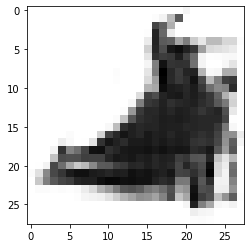

In [91]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('on')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('unconditional_generator.h5')
# generate images
latent_points = generate_latent_points(100, 1)
# generate images
X = model.predict(latent_points)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')

# Conditional GAN

In [92]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # initial input layer - takes {0,9} class label
    in_label = Input(shape=(1,))
    # converts input into 50-length vector representation
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # input image matrix from generator
    in_image = Input(shape=in_shape)
    # merge embedding of class label and image, which are same dimension
    merge = Concatenate()([in_image, li])
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    
    # now that we have all the layers, define the model using Functional API
    model = Model([in_image, in_label], out_layer)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)
    # we're training the discriminator directly, so compile it
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer, metrics=['accuracy'])
    return model

In [107]:
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # turn label into 50-length embedding
    li = Embedding(n_classes, 50)(in_label)
    # turn embedding into 7x7 to match size needed for upsampling
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    li = Reshape((7,7,1))(li)
    # add latent_dimension as another model input layer
    in_lat = Input(shape=(latent_dim,))
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7,7,128))(gen)
    # merge label and latent_dim partial image before upsampling
    merge = Concatenate()([gen, li])
    # begin upsampling
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    
    # with layers initializes, make model using Functional API
    model = Model([in_lat, in_label], out_layer)
    # since we're not directly training the generator, don't compile, just return
    return model

In [96]:
def define_gan(g_model, d_model):
    # force discriminator weights to not be trainable (it's already being trianed?)
    d_model.trainable = False
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output
    # pass the correct image and label data from generator to discriminator
    gan_output = d_model([gen_output, gen_label])
    model = Model([gen_noise, gen_label], gan_output)
    gan_optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=gan_optimizer)
    return model

In [97]:
def load_real_samples():
    (trainX, trainy), (_,_) = load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return [X, trainy]

def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    # pick some random images from dataset
    ix = np.random.randint(0, images.shape[0], n_samples)
    # labels contains the class labels for these images
    X, labels = images[ix], labels[ix]
    # all these images are real
    y = np.ones((n_samples, 1))
    return [X, labels], y

In [98]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    x_input = np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate random labels for this "noise"
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # all these images are fake
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

In [103]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    batch_per_epoch = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # go through the specified # of epochs
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            # get the real samples for half the batch
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate fake samples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare some "noise" for generator input
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # these fake samples get inverted labels b/c generator trains opposite of disc.
            y_gan = np.ones((n_batch, 1))
            # update generator with discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # print the loss for this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
                 (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
    
    # save generator model
    g_model.save('conditional_generator.h5')

In [108]:
from keras.models import Model
from keras.layers import Input, Embedding, Concatenate

latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

C:\Users\centa\.conda\envs\ds\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\centa\.conda\envs\ds\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\centa\.conda\envs\ds\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\centa\.conda\envs\ds\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433:

>1, 1/468, d1=0.720, d2=0.695, g=0.692
>1, 2/468, d1=0.654, d2=0.699, g=0.688
>1, 3/468, d1=0.588, d2=0.707, g=0.680
>1, 4/468, d1=0.536, d2=0.718, g=0.670


C:\Users\centa\.conda\envs\ds\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 5/468, d1=0.482, d2=0.736, g=0.655
>1, 6/468, d1=0.441, d2=0.760, g=0.639
>1, 7/468, d1=0.399, d2=0.792, g=0.620
>1, 8/468, d1=0.364, d2=0.820, g=0.612
>1, 9/468, d1=0.348, d2=0.821, g=0.627
>1, 10/468, d1=0.357, d2=0.785, g=0.675
>1, 11/468, d1=0.347, d2=0.718, g=0.765
>1, 12/468, d1=0.360, d2=0.620, g=0.860
>1, 13/468, d1=0.344, d2=0.544, g=0.984
>1, 14/468, d1=0.371, d2=0.500, g=1.024
>1, 15/468, d1=0.277, d2=0.482, g=1.033
>1, 16/468, d1=0.339, d2=0.520, g=0.932
>1, 17/468, d1=0.341, d2=0.587, g=0.830
>1, 18/468, d1=0.249, d2=0.648, g=0.756
>1, 19/468, d1=0.271, d2=0.703, g=0.701
>1, 20/468, d1=0.217, d2=0.783, g=0.633
>1, 21/468, d1=0.208, d2=0.897, g=0.562
>1, 22/468, d1=0.203, d2=1.001, g=0.519
>1, 23/468, d1=0.146, d2=1.027, g=0.525
>1, 24/468, d1=0.134, d2=0.937, g=0.598
>1, 25/468, d1=0.120, d2=0.777, g=0.750
>1, 26/468, d1=0.096, d2=0.600, g=0.950
>1, 27/468, d1=0.095, d2=0.458, g=1.118
>1, 28/468, d1=0.078, d2=0.424, g=1.173
>1, 29/468, d1=0.068, d2=0.438, g=1.092
>1, 3

>1, 209/468, d1=0.659, d2=0.723, g=0.742
>1, 210/468, d1=0.668, d2=0.724, g=0.714
>1, 211/468, d1=0.688, d2=0.753, g=0.705
>1, 212/468, d1=0.710, d2=0.757, g=0.723
>1, 213/468, d1=0.748, d2=0.774, g=0.696
>1, 214/468, d1=0.697, d2=0.779, g=0.721
>1, 215/468, d1=0.714, d2=0.767, g=0.690
>1, 216/468, d1=0.702, d2=0.742, g=0.708
>1, 217/468, d1=0.659, d2=0.738, g=0.718
>1, 218/468, d1=0.709, d2=0.723, g=0.714
>1, 219/468, d1=0.692, d2=0.706, g=0.723
>1, 220/468, d1=0.696, d2=0.726, g=0.733
>1, 221/468, d1=0.693, d2=0.688, g=0.747
>1, 222/468, d1=0.703, d2=0.704, g=0.719
>1, 223/468, d1=0.631, d2=0.712, g=0.733
>1, 224/468, d1=0.631, d2=0.709, g=0.753
>1, 225/468, d1=0.645, d2=0.711, g=0.741
>1, 226/468, d1=0.665, d2=0.719, g=0.742
>1, 227/468, d1=0.668, d2=0.700, g=0.754
>1, 228/468, d1=0.651, d2=0.697, g=0.743
>1, 229/468, d1=0.676, d2=0.676, g=0.753
>1, 230/468, d1=0.643, d2=0.690, g=0.766
>1, 231/468, d1=0.674, d2=0.675, g=0.777
>1, 232/468, d1=0.697, d2=0.691, g=0.790
>1, 233/468, d1=

>1, 412/468, d1=0.688, d2=0.636, g=0.795
>1, 413/468, d1=0.685, d2=0.620, g=0.820
>1, 414/468, d1=0.721, d2=0.623, g=0.812
>1, 415/468, d1=0.679, d2=0.607, g=0.809
>1, 416/468, d1=0.674, d2=0.662, g=0.816
>1, 417/468, d1=0.674, d2=0.608, g=0.794
>1, 418/468, d1=0.665, d2=0.654, g=0.773
>1, 419/468, d1=0.696, d2=0.658, g=0.763
>1, 420/468, d1=0.680, d2=0.667, g=0.759
>1, 421/468, d1=0.699, d2=0.709, g=0.728
>1, 422/468, d1=0.680, d2=0.716, g=0.738
>1, 423/468, d1=0.695, d2=0.737, g=0.700
>1, 424/468, d1=0.691, d2=0.720, g=0.693
>1, 425/468, d1=0.704, d2=0.751, g=0.701
>1, 426/468, d1=0.683, d2=0.731, g=0.718
>1, 427/468, d1=0.692, d2=0.710, g=0.737
>1, 428/468, d1=0.703, d2=0.692, g=0.739
>1, 429/468, d1=0.694, d2=0.671, g=0.760
>1, 430/468, d1=0.701, d2=0.641, g=0.786
>1, 431/468, d1=0.715, d2=0.637, g=0.819
>1, 432/468, d1=0.707, d2=0.634, g=0.822
>1, 433/468, d1=0.715, d2=0.585, g=0.810
>1, 434/468, d1=0.688, d2=0.610, g=0.829
>1, 435/468, d1=0.698, d2=0.607, g=0.846
>1, 436/468, d1=

>2, 149/468, d1=0.617, d2=0.732, g=0.740
>2, 150/468, d1=0.669, d2=0.697, g=0.755
>2, 151/468, d1=0.665, d2=0.649, g=0.775
>2, 152/468, d1=0.658, d2=0.638, g=0.832
>2, 153/468, d1=0.668, d2=0.613, g=0.828
>2, 154/468, d1=0.659, d2=0.627, g=0.828
>2, 155/468, d1=0.662, d2=0.622, g=0.817
>2, 156/468, d1=0.636, d2=0.614, g=0.798
>2, 157/468, d1=0.618, d2=0.626, g=0.773
>2, 158/468, d1=0.626, d2=0.665, g=0.763
>2, 159/468, d1=0.607, d2=0.667, g=0.754
>2, 160/468, d1=0.610, d2=0.707, g=0.751
>2, 161/468, d1=0.604, d2=0.708, g=0.728
>2, 162/468, d1=0.620, d2=0.721, g=0.720
>2, 163/468, d1=0.617, d2=0.702, g=0.730
>2, 164/468, d1=0.628, d2=0.704, g=0.752
>2, 165/468, d1=0.596, d2=0.665, g=0.735
>2, 166/468, d1=0.577, d2=0.667, g=0.767
>2, 167/468, d1=0.566, d2=0.670, g=0.798
>2, 168/468, d1=0.564, d2=0.629, g=0.825
>2, 169/468, d1=0.590, d2=0.634, g=0.822
>2, 170/468, d1=0.550, d2=0.626, g=0.826
>2, 171/468, d1=0.618, d2=0.643, g=0.842
>2, 172/468, d1=0.544, d2=0.632, g=0.822
>2, 173/468, d1=

>2, 350/468, d1=0.656, d2=0.693, g=0.756
>2, 351/468, d1=0.677, d2=0.702, g=0.746
>2, 352/468, d1=0.633, d2=0.681, g=0.766
>2, 353/468, d1=0.682, d2=0.680, g=0.754
>2, 354/468, d1=0.640, d2=0.698, g=0.759
>2, 355/468, d1=0.594, d2=0.681, g=0.734
>2, 356/468, d1=0.628, d2=0.717, g=0.747
>2, 357/468, d1=0.638, d2=0.691, g=0.773
>2, 358/468, d1=0.648, d2=0.671, g=0.749
>2, 359/468, d1=0.641, d2=0.679, g=0.763
>2, 360/468, d1=0.671, d2=0.683, g=0.765
>2, 361/468, d1=0.678, d2=0.681, g=0.757
>2, 362/468, d1=0.618, d2=0.703, g=0.774
>2, 363/468, d1=0.656, d2=0.686, g=0.754
>2, 364/468, d1=0.639, d2=0.684, g=0.739
>2, 365/468, d1=0.633, d2=0.683, g=0.772
>2, 366/468, d1=0.654, d2=0.673, g=0.762
>2, 367/468, d1=0.632, d2=0.687, g=0.763
>2, 368/468, d1=0.617, d2=0.674, g=0.773
>2, 369/468, d1=0.650, d2=0.670, g=0.771
>2, 370/468, d1=0.628, d2=0.694, g=0.780
>2, 371/468, d1=0.681, d2=0.673, g=0.774
>2, 372/468, d1=0.680, d2=0.680, g=0.768
>2, 373/468, d1=0.664, d2=0.678, g=0.793
>2, 374/468, d1=

>3, 84/468, d1=0.654, d2=0.647, g=0.808
>3, 85/468, d1=0.671, d2=0.644, g=0.806
>3, 86/468, d1=0.657, d2=0.642, g=0.770
>3, 87/468, d1=0.646, d2=0.679, g=0.778
>3, 88/468, d1=0.660, d2=0.718, g=0.746
>3, 89/468, d1=0.649, d2=0.731, g=0.779
>3, 90/468, d1=0.673, d2=0.676, g=0.795
>3, 91/468, d1=0.635, d2=0.657, g=0.798
>3, 92/468, d1=0.686, d2=0.636, g=0.828
>3, 93/468, d1=0.700, d2=0.608, g=0.861
>3, 94/468, d1=0.680, d2=0.605, g=0.884
>3, 95/468, d1=0.679, d2=0.624, g=0.879
>3, 96/468, d1=0.726, d2=0.627, g=0.840
>3, 97/468, d1=0.693, d2=0.650, g=0.847
>3, 98/468, d1=0.664, d2=0.643, g=0.790
>3, 99/468, d1=0.640, d2=0.646, g=0.814
>3, 100/468, d1=0.701, d2=0.662, g=0.794
>3, 101/468, d1=0.680, d2=0.654, g=0.780
>3, 102/468, d1=0.697, d2=0.661, g=0.775
>3, 103/468, d1=0.670, d2=0.681, g=0.791
>3, 104/468, d1=0.669, d2=0.650, g=0.796
>3, 105/468, d1=0.634, d2=0.638, g=0.813
>3, 106/468, d1=0.654, d2=0.639, g=0.804
>3, 107/468, d1=0.639, d2=0.644, g=0.798
>3, 108/468, d1=0.616, d2=0.669,

>3, 287/468, d1=0.656, d2=0.689, g=0.763
>3, 288/468, d1=0.673, d2=0.660, g=0.761
>3, 289/468, d1=0.649, d2=0.672, g=0.758
>3, 290/468, d1=0.649, d2=0.685, g=0.769
>3, 291/468, d1=0.639, d2=0.661, g=0.771
>3, 292/468, d1=0.628, d2=0.661, g=0.755
>3, 293/468, d1=0.655, d2=0.688, g=0.769
>3, 294/468, d1=0.666, d2=0.685, g=0.761
>3, 295/468, d1=0.618, d2=0.692, g=0.765
>3, 296/468, d1=0.668, d2=0.663, g=0.749
>3, 297/468, d1=0.661, d2=0.688, g=0.756
>3, 298/468, d1=0.681, d2=0.656, g=0.759
>3, 299/468, d1=0.666, d2=0.653, g=0.785
>3, 300/468, d1=0.726, d2=0.645, g=0.782
>3, 301/468, d1=0.646, d2=0.651, g=0.808
>3, 302/468, d1=0.665, d2=0.628, g=0.801
>3, 303/468, d1=0.667, d2=0.638, g=0.811
>3, 304/468, d1=0.679, d2=0.649, g=0.803
>3, 305/468, d1=0.654, d2=0.639, g=0.785
>3, 306/468, d1=0.668, d2=0.631, g=0.781
>3, 307/468, d1=0.657, d2=0.657, g=0.768
>3, 308/468, d1=0.700, d2=0.686, g=0.768
>3, 309/468, d1=0.669, d2=0.681, g=0.763
>3, 310/468, d1=0.638, d2=0.657, g=0.753
>3, 311/468, d1=

>4, 21/468, d1=0.721, d2=0.650, g=0.819
>4, 22/468, d1=0.732, d2=0.647, g=0.793
>4, 23/468, d1=0.685, d2=0.664, g=0.770
>4, 24/468, d1=0.663, d2=0.672, g=0.773
>4, 25/468, d1=0.666, d2=0.695, g=0.758
>4, 26/468, d1=0.669, d2=0.687, g=0.785
>4, 27/468, d1=0.642, d2=0.675, g=0.828
>4, 28/468, d1=0.658, d2=0.629, g=0.815
>4, 29/468, d1=0.657, d2=0.632, g=0.804
>4, 30/468, d1=0.695, d2=0.632, g=0.793
>4, 31/468, d1=0.673, d2=0.651, g=0.801
>4, 32/468, d1=0.652, d2=0.673, g=0.764
>4, 33/468, d1=0.646, d2=0.678, g=0.766
>4, 34/468, d1=0.649, d2=0.677, g=0.774
>4, 35/468, d1=0.638, d2=0.656, g=0.783
>4, 36/468, d1=0.670, d2=0.663, g=0.814
>4, 37/468, d1=0.652, d2=0.645, g=0.814
>4, 38/468, d1=0.701, d2=0.632, g=0.834
>4, 39/468, d1=0.689, d2=0.641, g=0.796
>4, 40/468, d1=0.660, d2=0.633, g=0.786
>4, 41/468, d1=0.675, d2=0.633, g=0.797
>4, 42/468, d1=0.693, d2=0.662, g=0.801
>4, 43/468, d1=0.685, d2=0.655, g=0.770
>4, 44/468, d1=0.674, d2=0.644, g=0.768
>4, 45/468, d1=0.674, d2=0.665, g=0.774


>4, 224/468, d1=0.597, d2=0.720, g=0.743
>4, 225/468, d1=0.622, d2=0.719, g=0.728
>4, 226/468, d1=0.619, d2=0.712, g=0.755
>4, 227/468, d1=0.669, d2=0.709, g=0.802
>4, 228/468, d1=0.690, d2=0.656, g=0.853
>4, 229/468, d1=0.693, d2=0.611, g=0.875
>4, 230/468, d1=0.746, d2=0.564, g=0.907
>4, 231/468, d1=0.734, d2=0.545, g=0.947
>4, 232/468, d1=0.700, d2=0.571, g=0.914
>4, 233/468, d1=0.720, d2=0.595, g=0.835
>4, 234/468, d1=0.739, d2=0.639, g=0.822
>4, 235/468, d1=0.741, d2=0.667, g=0.771
>4, 236/468, d1=0.621, d2=0.675, g=0.766
>4, 237/468, d1=0.679, d2=0.686, g=0.764
>4, 238/468, d1=0.669, d2=0.658, g=0.767
>4, 239/468, d1=0.674, d2=0.636, g=0.796
>4, 240/468, d1=0.641, d2=0.662, g=0.822
>4, 241/468, d1=0.655, d2=0.619, g=0.793
>4, 242/468, d1=0.630, d2=0.647, g=0.812
>4, 243/468, d1=0.627, d2=0.654, g=0.806
>4, 244/468, d1=0.626, d2=0.682, g=0.764
>4, 245/468, d1=0.641, d2=0.710, g=0.769
>4, 246/468, d1=0.657, d2=0.723, g=0.731
>4, 247/468, d1=0.676, d2=0.700, g=0.780
>4, 248/468, d1=

>4, 426/468, d1=0.633, d2=0.698, g=0.783
>4, 427/468, d1=0.683, d2=0.644, g=0.847
>4, 428/468, d1=0.703, d2=0.571, g=0.883
>4, 429/468, d1=0.696, d2=0.585, g=0.912
>4, 430/468, d1=0.714, d2=0.582, g=0.876
>4, 431/468, d1=0.692, d2=0.658, g=0.859
>4, 432/468, d1=0.652, d2=0.662, g=0.788
>4, 433/468, d1=0.702, d2=0.712, g=0.746
>4, 434/468, d1=0.686, d2=0.741, g=0.713
>4, 435/468, d1=0.685, d2=0.718, g=0.734
>4, 436/468, d1=0.683, d2=0.695, g=0.754
>4, 437/468, d1=0.652, d2=0.677, g=0.788
>4, 438/468, d1=0.633, d2=0.641, g=0.832
>4, 439/468, d1=0.619, d2=0.609, g=0.862
>4, 440/468, d1=0.647, d2=0.632, g=0.854
>4, 441/468, d1=0.656, d2=0.642, g=0.809
>4, 442/468, d1=0.622, d2=0.658, g=0.800
>4, 443/468, d1=0.635, d2=0.722, g=0.796
>4, 444/468, d1=0.658, d2=0.705, g=0.789
>4, 445/468, d1=0.667, d2=0.669, g=0.803
>4, 446/468, d1=0.632, d2=0.647, g=0.798
>4, 447/468, d1=0.669, d2=0.640, g=0.840
>4, 448/468, d1=0.667, d2=0.612, g=0.868
>4, 449/468, d1=0.653, d2=0.613, g=0.908
>4, 450/468, d1=

>5, 162/468, d1=0.644, d2=0.663, g=0.787
>5, 163/468, d1=0.674, d2=0.682, g=0.782
>5, 164/468, d1=0.647, d2=0.662, g=0.775
>5, 165/468, d1=0.660, d2=0.670, g=0.771
>5, 166/468, d1=0.663, d2=0.639, g=0.788
>5, 167/468, d1=0.651, d2=0.657, g=0.773
>5, 168/468, d1=0.678, d2=0.673, g=0.795
>5, 169/468, d1=0.689, d2=0.661, g=0.794
>5, 170/468, d1=0.660, d2=0.666, g=0.769
>5, 171/468, d1=0.694, d2=0.647, g=0.764
>5, 172/468, d1=0.658, d2=0.664, g=0.777
>5, 173/468, d1=0.667, d2=0.641, g=0.806
>5, 174/468, d1=0.680, d2=0.667, g=0.783
>5, 175/468, d1=0.694, d2=0.691, g=0.774
>5, 176/468, d1=0.688, d2=0.676, g=0.785
>5, 177/468, d1=0.698, d2=0.663, g=0.764
>5, 178/468, d1=0.702, d2=0.663, g=0.794
>5, 179/468, d1=0.655, d2=0.668, g=0.763
>5, 180/468, d1=0.643, d2=0.671, g=0.747
>5, 181/468, d1=0.642, d2=0.700, g=0.763
>5, 182/468, d1=0.621, d2=0.744, g=0.744
>5, 183/468, d1=0.661, d2=0.689, g=0.741
>5, 184/468, d1=0.641, d2=0.682, g=0.787
>5, 185/468, d1=0.687, d2=0.617, g=0.786
>5, 186/468, d1=

>5, 362/468, d1=0.673, d2=0.665, g=0.753
>5, 363/468, d1=0.628, d2=0.662, g=0.782
>5, 364/468, d1=0.646, d2=0.647, g=0.772
>5, 365/468, d1=0.618, d2=0.652, g=0.764
>5, 366/468, d1=0.668, d2=0.689, g=0.777
>5, 367/468, d1=0.646, d2=0.702, g=0.754
>5, 368/468, d1=0.640, d2=0.687, g=0.762
>5, 369/468, d1=0.654, d2=0.671, g=0.788
>5, 370/468, d1=0.679, d2=0.652, g=0.779
>5, 371/468, d1=0.685, d2=0.630, g=0.818
>5, 372/468, d1=0.692, d2=0.669, g=0.814
>5, 373/468, d1=0.685, d2=0.626, g=0.769
>5, 374/468, d1=0.648, d2=0.667, g=0.769
>5, 375/468, d1=0.673, d2=0.656, g=0.789
>5, 376/468, d1=0.687, d2=0.672, g=0.769
>5, 377/468, d1=0.685, d2=0.686, g=0.786
>5, 378/468, d1=0.631, d2=0.670, g=0.762
>5, 379/468, d1=0.665, d2=0.629, g=0.782
>5, 380/468, d1=0.636, d2=0.657, g=0.786
>5, 381/468, d1=0.652, d2=0.677, g=0.770
>5, 382/468, d1=0.660, d2=0.675, g=0.770
>5, 383/468, d1=0.688, d2=0.687, g=0.735
>5, 384/468, d1=0.616, d2=0.670, g=0.770
>5, 385/468, d1=0.670, d2=0.637, g=0.811
>5, 386/468, d1=

>6, 96/468, d1=0.624, d2=0.692, g=0.742
>6, 97/468, d1=0.658, d2=0.720, g=0.761
>6, 98/468, d1=0.704, d2=0.699, g=0.778
>6, 99/468, d1=0.674, d2=0.658, g=0.832
>6, 100/468, d1=0.660, d2=0.584, g=0.856
>6, 101/468, d1=0.693, d2=0.588, g=0.924
>6, 102/468, d1=0.680, d2=0.618, g=0.862
>6, 103/468, d1=0.698, d2=0.623, g=0.850
>6, 104/468, d1=0.701, d2=0.657, g=0.792
>6, 105/468, d1=0.703, d2=0.678, g=0.757
>6, 106/468, d1=0.677, d2=0.710, g=0.756
>6, 107/468, d1=0.691, d2=0.652, g=0.820
>6, 108/468, d1=0.676, d2=0.596, g=0.840
>6, 109/468, d1=0.667, d2=0.567, g=0.871
>6, 110/468, d1=0.681, d2=0.605, g=0.894
>6, 111/468, d1=0.673, d2=0.623, g=0.802
>6, 112/468, d1=0.667, d2=0.684, g=0.778
>6, 113/468, d1=0.707, d2=0.775, g=0.752
>6, 114/468, d1=0.682, d2=0.703, g=0.763
>6, 115/468, d1=0.682, d2=0.668, g=0.816
>6, 116/468, d1=0.701, d2=0.611, g=0.886
>6, 117/468, d1=0.702, d2=0.583, g=0.958
>6, 118/468, d1=0.693, d2=0.516, g=1.022
>6, 119/468, d1=0.756, d2=0.573, g=0.930
>6, 120/468, d1=0.69

>6, 296/468, d1=0.653, d2=0.627, g=0.781
>6, 297/468, d1=0.694, d2=0.655, g=0.785
>6, 298/468, d1=0.696, d2=0.675, g=0.789
>6, 299/468, d1=0.669, d2=0.657, g=0.773
>6, 300/468, d1=0.662, d2=0.663, g=0.775
>6, 301/468, d1=0.666, d2=0.659, g=0.775
>6, 302/468, d1=0.646, d2=0.645, g=0.763
>6, 303/468, d1=0.661, d2=0.645, g=0.780
>6, 304/468, d1=0.668, d2=0.682, g=0.781
>6, 305/468, d1=0.659, d2=0.672, g=0.776
>6, 306/468, d1=0.618, d2=0.640, g=0.772
>6, 307/468, d1=0.662, d2=0.673, g=0.782
>6, 308/468, d1=0.642, d2=0.669, g=0.773
>6, 309/468, d1=0.674, d2=0.676, g=0.779
>6, 310/468, d1=0.659, d2=0.643, g=0.789
>6, 311/468, d1=0.671, d2=0.700, g=0.743
>6, 312/468, d1=0.651, d2=0.708, g=0.745
>6, 313/468, d1=0.652, d2=0.675, g=0.751
>6, 314/468, d1=0.646, d2=0.678, g=0.753
>6, 315/468, d1=0.686, d2=0.652, g=0.758
>6, 316/468, d1=0.637, d2=0.670, g=0.761
>6, 317/468, d1=0.679, d2=0.668, g=0.772
>6, 318/468, d1=0.681, d2=0.659, g=0.776
>6, 319/468, d1=0.651, d2=0.674, g=0.756
>6, 320/468, d1=

>7, 30/468, d1=0.703, d2=0.706, g=0.748
>7, 31/468, d1=0.634, d2=0.692, g=0.734
>7, 32/468, d1=0.662, d2=0.693, g=0.758
>7, 33/468, d1=0.650, d2=0.657, g=0.777
>7, 34/468, d1=0.621, d2=0.653, g=0.802
>7, 35/468, d1=0.623, d2=0.658, g=0.788
>7, 36/468, d1=0.629, d2=0.672, g=0.774
>7, 37/468, d1=0.636, d2=0.718, g=0.756
>7, 38/468, d1=0.614, d2=0.738, g=0.744
>7, 39/468, d1=0.645, d2=0.688, g=0.783
>7, 40/468, d1=0.663, d2=0.638, g=0.792
>7, 41/468, d1=0.668, d2=0.647, g=0.814
>7, 42/468, d1=0.670, d2=0.623, g=0.821
>7, 43/468, d1=0.675, d2=0.668, g=0.779
>7, 44/468, d1=0.688, d2=0.646, g=0.790
>7, 45/468, d1=0.681, d2=0.684, g=0.764
>7, 46/468, d1=0.653, d2=0.648, g=0.806
>7, 47/468, d1=0.704, d2=0.661, g=0.774
>7, 48/468, d1=0.685, d2=0.654, g=0.778
>7, 49/468, d1=0.675, d2=0.671, g=0.783
>7, 50/468, d1=0.654, d2=0.670, g=0.773
>7, 51/468, d1=0.663, d2=0.636, g=0.779
>7, 52/468, d1=0.677, d2=0.636, g=0.762
>7, 53/468, d1=0.672, d2=0.647, g=0.752
>7, 54/468, d1=0.673, d2=0.664, g=0.769


>7, 232/468, d1=0.669, d2=0.641, g=0.807
>7, 233/468, d1=0.650, d2=0.678, g=0.792
>7, 234/468, d1=0.645, d2=0.664, g=0.778
>7, 235/468, d1=0.666, d2=0.630, g=0.815
>7, 236/468, d1=0.683, d2=0.658, g=0.793
>7, 237/468, d1=0.687, d2=0.632, g=0.790
>7, 238/468, d1=0.653, d2=0.655, g=0.780
>7, 239/468, d1=0.666, d2=0.646, g=0.785
>7, 240/468, d1=0.661, d2=0.660, g=0.769
>7, 241/468, d1=0.659, d2=0.667, g=0.771
>7, 242/468, d1=0.659, d2=0.645, g=0.795
>7, 243/468, d1=0.666, d2=0.651, g=0.769
>7, 244/468, d1=0.678, d2=0.695, g=0.759
>7, 245/468, d1=0.655, d2=0.656, g=0.775
>7, 246/468, d1=0.654, d2=0.656, g=0.795
>7, 247/468, d1=0.712, d2=0.643, g=0.785
>7, 248/468, d1=0.668, d2=0.643, g=0.820
>7, 249/468, d1=0.674, d2=0.675, g=0.802
>7, 250/468, d1=0.671, d2=0.648, g=0.783
>7, 251/468, d1=0.686, d2=0.631, g=0.803
>7, 252/468, d1=0.660, d2=0.628, g=0.804
>7, 253/468, d1=0.677, d2=0.625, g=0.791
>7, 254/468, d1=0.657, d2=0.662, g=0.812
>7, 255/468, d1=0.670, d2=0.657, g=0.793
>7, 256/468, d1=

>7, 432/468, d1=0.715, d2=0.645, g=0.833
>7, 433/468, d1=0.687, d2=0.637, g=0.783
>7, 434/468, d1=0.685, d2=0.674, g=0.785
>7, 435/468, d1=0.684, d2=0.657, g=0.778
>7, 436/468, d1=0.674, d2=0.630, g=0.832
>7, 437/468, d1=0.666, d2=0.637, g=0.832
>7, 438/468, d1=0.629, d2=0.643, g=0.815
>7, 439/468, d1=0.663, d2=0.659, g=0.771
>7, 440/468, d1=0.671, d2=0.675, g=0.781
>7, 441/468, d1=0.679, d2=0.660, g=0.780
>7, 442/468, d1=0.655, d2=0.693, g=0.780
>7, 443/468, d1=0.689, d2=0.646, g=0.826
>7, 444/468, d1=0.686, d2=0.594, g=0.858
>7, 445/468, d1=0.699, d2=0.596, g=0.883
>7, 446/468, d1=0.687, d2=0.631, g=0.836
>7, 447/468, d1=0.662, d2=0.637, g=0.819
>7, 448/468, d1=0.680, d2=0.647, g=0.769
>7, 449/468, d1=0.693, d2=0.658, g=0.791
>7, 450/468, d1=0.665, d2=0.643, g=0.821
>7, 451/468, d1=0.670, d2=0.621, g=0.837
>7, 452/468, d1=0.678, d2=0.661, g=0.820
>7, 453/468, d1=0.679, d2=0.666, g=0.783
>7, 454/468, d1=0.648, d2=0.681, g=0.754
>7, 455/468, d1=0.694, d2=0.672, g=0.767
>7, 456/468, d1=

>8, 167/468, d1=0.703, d2=0.650, g=0.785
>8, 168/468, d1=0.681, d2=0.690, g=0.772
>8, 169/468, d1=0.655, d2=0.633, g=0.773
>8, 170/468, d1=0.664, d2=0.686, g=0.794
>8, 171/468, d1=0.673, d2=0.682, g=0.764
>8, 172/468, d1=0.666, d2=0.681, g=0.748
>8, 173/468, d1=0.669, d2=0.696, g=0.773
>8, 174/468, d1=0.669, d2=0.645, g=0.772
>8, 175/468, d1=0.681, d2=0.668, g=0.781
>8, 176/468, d1=0.665, d2=0.675, g=0.783
>8, 177/468, d1=0.664, d2=0.638, g=0.767
>8, 178/468, d1=0.671, d2=0.676, g=0.774
>8, 179/468, d1=0.664, d2=0.675, g=0.781
>8, 180/468, d1=0.658, d2=0.641, g=0.784
>8, 181/468, d1=0.691, d2=0.631, g=0.780
>8, 182/468, d1=0.669, d2=0.671, g=0.756
>8, 183/468, d1=0.651, d2=0.703, g=0.771
>8, 184/468, d1=0.637, d2=0.675, g=0.767
>8, 185/468, d1=0.700, d2=0.669, g=0.789
>8, 186/468, d1=0.661, d2=0.647, g=0.790
>8, 187/468, d1=0.698, d2=0.644, g=0.763
>8, 188/468, d1=0.650, d2=0.672, g=0.779
>8, 189/468, d1=0.673, d2=0.685, g=0.746
>8, 190/468, d1=0.651, d2=0.670, g=0.785
>8, 191/468, d1=

>8, 368/468, d1=0.680, d2=0.683, g=0.752
>8, 369/468, d1=0.657, d2=0.654, g=0.773
>8, 370/468, d1=0.669, d2=0.660, g=0.775
>8, 371/468, d1=0.634, d2=0.645, g=0.775
>8, 372/468, d1=0.684, d2=0.683, g=0.747
>8, 373/468, d1=0.653, d2=0.677, g=0.746
>8, 374/468, d1=0.685, d2=0.696, g=0.766
>8, 375/468, d1=0.641, d2=0.679, g=0.775
>8, 376/468, d1=0.685, d2=0.634, g=0.788
>8, 377/468, d1=0.691, d2=0.643, g=0.813
>8, 378/468, d1=0.677, d2=0.669, g=0.799
>8, 379/468, d1=0.660, d2=0.682, g=0.774
>8, 380/468, d1=0.700, d2=0.701, g=0.774
>8, 381/468, d1=0.665, d2=0.667, g=0.805
>8, 382/468, d1=0.699, d2=0.648, g=0.797
>8, 383/468, d1=0.658, d2=0.638, g=0.782
>8, 384/468, d1=0.678, d2=0.659, g=0.777
>8, 385/468, d1=0.674, d2=0.679, g=0.767
>8, 386/468, d1=0.695, d2=0.689, g=0.750
>8, 387/468, d1=0.674, d2=0.674, g=0.756
>8, 388/468, d1=0.704, d2=0.698, g=0.758
>8, 389/468, d1=0.673, d2=0.640, g=0.794
>8, 390/468, d1=0.694, d2=0.666, g=0.772
>8, 391/468, d1=0.643, d2=0.644, g=0.763
>8, 392/468, d1=

>9, 104/468, d1=0.706, d2=0.679, g=0.761
>9, 105/468, d1=0.675, d2=0.640, g=0.765
>9, 106/468, d1=0.703, d2=0.648, g=0.777
>9, 107/468, d1=0.700, d2=0.647, g=0.782
>9, 108/468, d1=0.665, d2=0.656, g=0.756
>9, 109/468, d1=0.690, d2=0.642, g=0.758
>9, 110/468, d1=0.636, d2=0.657, g=0.787
>9, 111/468, d1=0.647, d2=0.660, g=0.760
>9, 112/468, d1=0.673, d2=0.635, g=0.784
>9, 113/468, d1=0.656, d2=0.644, g=0.770
>9, 114/468, d1=0.681, d2=0.639, g=0.756
>9, 115/468, d1=0.674, d2=0.685, g=0.774
>9, 116/468, d1=0.666, d2=0.638, g=0.749
>9, 117/468, d1=0.682, d2=0.693, g=0.750
>9, 118/468, d1=0.663, d2=0.697, g=0.754
>9, 119/468, d1=0.671, d2=0.664, g=0.734
>9, 120/468, d1=0.658, d2=0.690, g=0.760
>9, 121/468, d1=0.653, d2=0.675, g=0.779
>9, 122/468, d1=0.660, d2=0.674, g=0.763
>9, 123/468, d1=0.652, d2=0.703, g=0.774
>9, 124/468, d1=0.645, d2=0.694, g=0.767
>9, 125/468, d1=0.680, d2=0.655, g=0.772
>9, 126/468, d1=0.682, d2=0.643, g=0.768
>9, 127/468, d1=0.649, d2=0.655, g=0.762
>9, 128/468, d1=

>9, 303/468, d1=0.667, d2=0.636, g=0.784
>9, 304/468, d1=0.688, d2=0.667, g=0.773
>9, 305/468, d1=0.682, d2=0.674, g=0.773
>9, 306/468, d1=0.650, d2=0.719, g=0.743
>9, 307/468, d1=0.698, d2=0.676, g=0.763
>9, 308/468, d1=0.683, d2=0.660, g=0.771
>9, 309/468, d1=0.700, d2=0.679, g=0.793
>9, 310/468, d1=0.631, d2=0.675, g=0.782
>9, 311/468, d1=0.670, d2=0.635, g=0.785
>9, 312/468, d1=0.708, d2=0.660, g=0.787
>9, 313/468, d1=0.665, d2=0.639, g=0.781
>9, 314/468, d1=0.725, d2=0.691, g=0.759
>9, 315/468, d1=0.678, d2=0.668, g=0.782
>9, 316/468, d1=0.676, d2=0.652, g=0.788
>9, 317/468, d1=0.656, d2=0.658, g=0.761
>9, 318/468, d1=0.651, d2=0.697, g=0.742
>9, 319/468, d1=0.670, d2=0.696, g=0.763
>9, 320/468, d1=0.666, d2=0.665, g=0.778
>9, 321/468, d1=0.651, d2=0.649, g=0.784
>9, 322/468, d1=0.678, d2=0.656, g=0.783
>9, 323/468, d1=0.674, d2=0.641, g=0.790
>9, 324/468, d1=0.697, d2=0.656, g=0.791
>9, 325/468, d1=0.684, d2=0.661, g=0.766
>9, 326/468, d1=0.678, d2=0.668, g=0.787
>9, 327/468, d1=

>10, 38/468, d1=0.712, d2=0.644, g=0.809
>10, 39/468, d1=0.672, d2=0.673, g=0.757
>10, 40/468, d1=0.696, d2=0.692, g=0.754
>10, 41/468, d1=0.676, d2=0.669, g=0.744
>10, 42/468, d1=0.647, d2=0.671, g=0.764
>10, 43/468, d1=0.657, d2=0.661, g=0.757
>10, 44/468, d1=0.631, d2=0.657, g=0.806
>10, 45/468, d1=0.679, d2=0.646, g=0.809
>10, 46/468, d1=0.665, d2=0.698, g=0.732
>10, 47/468, d1=0.660, d2=0.691, g=0.740
>10, 48/468, d1=0.675, d2=0.711, g=0.758
>10, 49/468, d1=0.647, d2=0.673, g=0.781
>10, 50/468, d1=0.643, d2=0.662, g=0.805
>10, 51/468, d1=0.682, d2=0.637, g=0.816
>10, 52/468, d1=0.682, d2=0.657, g=0.800
>10, 53/468, d1=0.702, d2=0.692, g=0.782
>10, 54/468, d1=0.673, d2=0.663, g=0.743
>10, 55/468, d1=0.649, d2=0.693, g=0.738
>10, 56/468, d1=0.655, d2=0.692, g=0.726
>10, 57/468, d1=0.672, d2=0.695, g=0.753
>10, 58/468, d1=0.656, d2=0.675, g=0.769
>10, 59/468, d1=0.665, d2=0.694, g=0.756
>10, 60/468, d1=0.623, d2=0.685, g=0.756
>10, 61/468, d1=0.633, d2=0.666, g=0.757
>10, 62/468, d1=

>10, 235/468, d1=0.670, d2=0.694, g=0.790
>10, 236/468, d1=0.679, d2=0.638, g=0.787
>10, 237/468, d1=0.666, d2=0.679, g=0.793
>10, 238/468, d1=0.716, d2=0.655, g=0.771
>10, 239/468, d1=0.663, d2=0.673, g=0.752
>10, 240/468, d1=0.680, d2=0.703, g=0.760
>10, 241/468, d1=0.659, d2=0.669, g=0.787
>10, 242/468, d1=0.646, d2=0.645, g=0.833
>10, 243/468, d1=0.668, d2=0.626, g=0.807
>10, 244/468, d1=0.668, d2=0.640, g=0.764
>10, 245/468, d1=0.654, d2=0.687, g=0.758
>10, 246/468, d1=0.686, d2=0.700, g=0.778
>10, 247/468, d1=0.695, d2=0.685, g=0.796
>10, 248/468, d1=0.681, d2=0.673, g=0.843
>10, 249/468, d1=0.688, d2=0.620, g=0.869
>10, 250/468, d1=0.722, d2=0.609, g=0.829
>10, 251/468, d1=0.707, d2=0.638, g=0.755
>10, 252/468, d1=0.690, d2=0.683, g=0.760
>10, 253/468, d1=0.694, d2=0.698, g=0.748
>10, 254/468, d1=0.666, d2=0.683, g=0.798
>10, 255/468, d1=0.655, d2=0.647, g=0.813
>10, 256/468, d1=0.629, d2=0.674, g=0.801
>10, 257/468, d1=0.670, d2=0.637, g=0.749
>10, 258/468, d1=0.674, d2=0.667, 

>10, 432/468, d1=0.687, d2=0.673, g=0.774
>10, 433/468, d1=0.663, d2=0.641, g=0.780
>10, 434/468, d1=0.692, d2=0.690, g=0.763
>10, 435/468, d1=0.677, d2=0.658, g=0.774
>10, 436/468, d1=0.700, d2=0.651, g=0.762
>10, 437/468, d1=0.670, d2=0.672, g=0.786
>10, 438/468, d1=0.661, d2=0.646, g=0.776
>10, 439/468, d1=0.658, d2=0.683, g=0.790
>10, 440/468, d1=0.653, d2=0.676, g=0.774
>10, 441/468, d1=0.657, d2=0.656, g=0.785
>10, 442/468, d1=0.671, d2=0.690, g=0.776
>10, 443/468, d1=0.668, d2=0.664, g=0.756
>10, 444/468, d1=0.659, d2=0.661, g=0.779
>10, 445/468, d1=0.650, d2=0.655, g=0.774
>10, 446/468, d1=0.649, d2=0.692, g=0.767
>10, 447/468, d1=0.657, d2=0.685, g=0.764
>10, 448/468, d1=0.651, d2=0.673, g=0.779
>10, 449/468, d1=0.665, d2=0.648, g=0.785
>10, 450/468, d1=0.674, d2=0.646, g=0.770
>10, 451/468, d1=0.655, d2=0.665, g=0.776
>10, 452/468, d1=0.674, d2=0.648, g=0.777
>10, 453/468, d1=0.698, d2=0.636, g=0.769
>10, 454/468, d1=0.674, d2=0.654, g=0.794
>10, 455/468, d1=0.672, d2=0.657, 

>11, 161/468, d1=0.699, d2=0.665, g=0.784
>11, 162/468, d1=0.699, d2=0.648, g=0.767
>11, 163/468, d1=0.648, d2=0.668, g=0.788
>11, 164/468, d1=0.698, d2=0.678, g=0.811
>11, 165/468, d1=0.688, d2=0.626, g=0.774
>11, 166/468, d1=0.661, d2=0.678, g=0.773
>11, 167/468, d1=0.704, d2=0.678, g=0.776
>11, 168/468, d1=0.661, d2=0.670, g=0.772
>11, 169/468, d1=0.657, d2=0.647, g=0.799
>11, 170/468, d1=0.711, d2=0.675, g=0.806
>11, 171/468, d1=0.674, d2=0.651, g=0.790
>11, 172/468, d1=0.671, d2=0.663, g=0.766
>11, 173/468, d1=0.682, d2=0.686, g=0.766
>11, 174/468, d1=0.697, d2=0.651, g=0.754
>11, 175/468, d1=0.656, d2=0.693, g=0.771
>11, 176/468, d1=0.684, d2=0.690, g=0.767
>11, 177/468, d1=0.680, d2=0.646, g=0.782
>11, 178/468, d1=0.671, d2=0.646, g=0.761
>11, 179/468, d1=0.685, d2=0.698, g=0.759
>11, 180/468, d1=0.679, d2=0.665, g=0.728
>11, 181/468, d1=0.653, d2=0.728, g=0.754
>11, 182/468, d1=0.632, d2=0.657, g=0.772
>11, 183/468, d1=0.657, d2=0.646, g=0.767
>11, 184/468, d1=0.690, d2=0.659, 

>11, 357/468, d1=0.654, d2=0.688, g=0.754
>11, 358/468, d1=0.660, d2=0.671, g=0.777
>11, 359/468, d1=0.673, d2=0.639, g=0.798
>11, 360/468, d1=0.709, d2=0.640, g=0.805
>11, 361/468, d1=0.685, d2=0.657, g=0.751
>11, 362/468, d1=0.660, d2=0.662, g=0.766
>11, 363/468, d1=0.686, d2=0.679, g=0.764
>11, 364/468, d1=0.636, d2=0.706, g=0.758
>11, 365/468, d1=0.656, d2=0.630, g=0.779
>11, 366/468, d1=0.673, d2=0.656, g=0.776
>11, 367/468, d1=0.631, d2=0.659, g=0.791
>11, 368/468, d1=0.719, d2=0.699, g=0.764
>11, 369/468, d1=0.658, d2=0.684, g=0.754
>11, 370/468, d1=0.658, d2=0.699, g=0.745
>11, 371/468, d1=0.663, d2=0.669, g=0.771
>11, 372/468, d1=0.670, d2=0.675, g=0.782
>11, 373/468, d1=0.689, d2=0.682, g=0.753
>11, 374/468, d1=0.646, d2=0.676, g=0.759
>11, 375/468, d1=0.648, d2=0.680, g=0.757
>11, 376/468, d1=0.664, d2=0.699, g=0.762
>11, 377/468, d1=0.682, d2=0.683, g=0.763
>11, 378/468, d1=0.641, d2=0.663, g=0.768
>11, 379/468, d1=0.682, d2=0.684, g=0.767
>11, 380/468, d1=0.680, d2=0.649, 

>12, 89/468, d1=0.669, d2=0.663, g=0.792
>12, 90/468, d1=0.651, d2=0.643, g=0.797
>12, 91/468, d1=0.713, d2=0.690, g=0.769
>12, 92/468, d1=0.680, d2=0.702, g=0.768
>12, 93/468, d1=0.650, d2=0.709, g=0.789
>12, 94/468, d1=0.679, d2=0.637, g=0.823
>12, 95/468, d1=0.717, d2=0.669, g=0.841
>12, 96/468, d1=0.720, d2=0.648, g=0.820
>12, 97/468, d1=0.699, d2=0.625, g=0.824
>12, 98/468, d1=0.755, d2=0.691, g=0.793
>12, 99/468, d1=0.711, d2=0.687, g=0.766
>12, 100/468, d1=0.688, d2=0.663, g=0.762
>12, 101/468, d1=0.680, d2=0.655, g=0.766
>12, 102/468, d1=0.641, d2=0.628, g=0.786
>12, 103/468, d1=0.672, d2=0.632, g=0.783
>12, 104/468, d1=0.638, d2=0.680, g=0.783
>12, 105/468, d1=0.651, d2=0.692, g=0.781
>12, 106/468, d1=0.686, d2=0.662, g=0.794
>12, 107/468, d1=0.715, d2=0.685, g=0.777
>12, 108/468, d1=0.665, d2=0.640, g=0.777
>12, 109/468, d1=0.676, d2=0.650, g=0.786
>12, 110/468, d1=0.672, d2=0.670, g=0.807
>12, 111/468, d1=0.672, d2=0.672, g=0.806
>12, 112/468, d1=0.733, d2=0.647, g=0.800
>12

>12, 285/468, d1=0.715, d2=0.701, g=0.765
>12, 286/468, d1=0.674, d2=0.695, g=0.769
>12, 287/468, d1=0.683, d2=0.630, g=0.810
>12, 288/468, d1=0.665, d2=0.634, g=0.794
>12, 289/468, d1=0.653, d2=0.614, g=0.800
>12, 290/468, d1=0.690, d2=0.664, g=0.756
>12, 291/468, d1=0.655, d2=0.696, g=0.722
>12, 292/468, d1=0.659, d2=0.684, g=0.785
>12, 293/468, d1=0.671, d2=0.655, g=0.825
>12, 294/468, d1=0.679, d2=0.643, g=0.812
>12, 295/468, d1=0.699, d2=0.682, g=0.826
>12, 296/468, d1=0.675, d2=0.627, g=0.795
>12, 297/468, d1=0.683, d2=0.669, g=0.801
>12, 298/468, d1=0.712, d2=0.679, g=0.759
>12, 299/468, d1=0.692, d2=0.672, g=0.770
>12, 300/468, d1=0.658, d2=0.684, g=0.788
>12, 301/468, d1=0.688, d2=0.678, g=0.771
>12, 302/468, d1=0.669, d2=0.719, g=0.757
>12, 303/468, d1=0.655, d2=0.657, g=0.774
>12, 304/468, d1=0.697, d2=0.658, g=0.808
>12, 305/468, d1=0.670, d2=0.660, g=0.775
>12, 306/468, d1=0.676, d2=0.646, g=0.767
>12, 307/468, d1=0.656, d2=0.638, g=0.774
>12, 308/468, d1=0.660, d2=0.669, 

>13, 12/468, d1=0.652, d2=0.682, g=0.742
>13, 13/468, d1=0.692, d2=0.675, g=0.785
>13, 14/468, d1=0.688, d2=0.692, g=0.781
>13, 15/468, d1=0.705, d2=0.643, g=0.764
>13, 16/468, d1=0.674, d2=0.672, g=0.765
>13, 17/468, d1=0.688, d2=0.634, g=0.780
>13, 18/468, d1=0.704, d2=0.675, g=0.782
>13, 19/468, d1=0.685, d2=0.634, g=0.787
>13, 20/468, d1=0.686, d2=0.650, g=0.772
>13, 21/468, d1=0.644, d2=0.681, g=0.784
>13, 22/468, d1=0.688, d2=0.660, g=0.741
>13, 23/468, d1=0.696, d2=0.661, g=0.765
>13, 24/468, d1=0.648, d2=0.676, g=0.774
>13, 25/468, d1=0.663, d2=0.700, g=0.760
>13, 26/468, d1=0.697, d2=0.684, g=0.769
>13, 27/468, d1=0.654, d2=0.688, g=0.759
>13, 28/468, d1=0.665, d2=0.692, g=0.794
>13, 29/468, d1=0.703, d2=0.662, g=0.784
>13, 30/468, d1=0.693, d2=0.644, g=0.753
>13, 31/468, d1=0.670, d2=0.678, g=0.750
>13, 32/468, d1=0.660, d2=0.682, g=0.746
>13, 33/468, d1=0.651, d2=0.678, g=0.783
>13, 34/468, d1=0.675, d2=0.691, g=0.780
>13, 35/468, d1=0.693, d2=0.660, g=0.797
>13, 36/468, d1=

>13, 209/468, d1=0.655, d2=0.691, g=0.819
>13, 210/468, d1=0.672, d2=0.675, g=0.769
>13, 211/468, d1=0.666, d2=0.728, g=0.767
>13, 212/468, d1=0.648, d2=0.705, g=0.777
>13, 213/468, d1=0.652, d2=0.685, g=0.766
>13, 214/468, d1=0.733, d2=0.679, g=0.794
>13, 215/468, d1=0.697, d2=0.629, g=0.808
>13, 216/468, d1=0.687, d2=0.658, g=0.776
>13, 217/468, d1=0.656, d2=0.692, g=0.772
>13, 218/468, d1=0.685, d2=0.673, g=0.778
>13, 219/468, d1=0.689, d2=0.681, g=0.764
>13, 220/468, d1=0.628, d2=0.683, g=0.765
>13, 221/468, d1=0.657, d2=0.644, g=0.765
>13, 222/468, d1=0.663, d2=0.667, g=0.793
>13, 223/468, d1=0.640, d2=0.677, g=0.753
>13, 224/468, d1=0.610, d2=0.693, g=0.750
>13, 225/468, d1=0.662, d2=0.675, g=0.764
>13, 226/468, d1=0.695, d2=0.691, g=0.767
>13, 227/468, d1=0.690, d2=0.696, g=0.825
>13, 228/468, d1=0.683, d2=0.638, g=0.833
>13, 229/468, d1=0.648, d2=0.652, g=0.802
>13, 230/468, d1=0.668, d2=0.676, g=0.796
>13, 231/468, d1=0.697, d2=0.694, g=0.757
>13, 232/468, d1=0.667, d2=0.674, 

>13, 406/468, d1=0.662, d2=0.699, g=0.754
>13, 407/468, d1=0.678, d2=0.671, g=0.763
>13, 408/468, d1=0.694, d2=0.636, g=0.773
>13, 409/468, d1=0.694, d2=0.651, g=0.831
>13, 410/468, d1=0.679, d2=0.623, g=0.853
>13, 411/468, d1=0.665, d2=0.667, g=0.791
>13, 412/468, d1=0.639, d2=0.681, g=0.749
>13, 413/468, d1=0.703, d2=0.683, g=0.747
>13, 414/468, d1=0.685, d2=0.680, g=0.798
>13, 415/468, d1=0.698, d2=0.620, g=0.839
>13, 416/468, d1=0.705, d2=0.622, g=0.821
>13, 417/468, d1=0.653, d2=0.660, g=0.807
>13, 418/468, d1=0.662, d2=0.664, g=0.770
>13, 419/468, d1=0.656, d2=0.770, g=0.748
>13, 420/468, d1=0.691, d2=0.689, g=0.778
>13, 421/468, d1=0.658, d2=0.699, g=0.775
>13, 422/468, d1=0.697, d2=0.610, g=0.874
>13, 423/468, d1=0.674, d2=0.563, g=0.840
>13, 424/468, d1=0.671, d2=0.643, g=0.847
>13, 425/468, d1=0.692, d2=0.725, g=0.769
>13, 426/468, d1=0.693, d2=0.741, g=0.762
>13, 427/468, d1=0.669, d2=0.690, g=0.818
>13, 428/468, d1=0.635, d2=0.614, g=0.858
>13, 429/468, d1=0.654, d2=0.612, 

>14, 136/468, d1=0.694, d2=0.673, g=0.775
>14, 137/468, d1=0.673, d2=0.662, g=0.774
>14, 138/468, d1=0.679, d2=0.660, g=0.760
>14, 139/468, d1=0.678, d2=0.691, g=0.769
>14, 140/468, d1=0.664, d2=0.679, g=0.767
>14, 141/468, d1=0.684, d2=0.684, g=0.757
>14, 142/468, d1=0.671, d2=0.695, g=0.759
>14, 143/468, d1=0.670, d2=0.667, g=0.799
>14, 144/468, d1=0.682, d2=0.653, g=0.782
>14, 145/468, d1=0.696, d2=0.663, g=0.779
>14, 146/468, d1=0.695, d2=0.668, g=0.781
>14, 147/468, d1=0.701, d2=0.676, g=0.751
>14, 148/468, d1=0.651, d2=0.655, g=0.767
>14, 149/468, d1=0.693, d2=0.693, g=0.775
>14, 150/468, d1=0.668, d2=0.644, g=0.783
>14, 151/468, d1=0.679, d2=0.668, g=0.771
>14, 152/468, d1=0.707, d2=0.671, g=0.759
>14, 153/468, d1=0.698, d2=0.691, g=0.764
>14, 154/468, d1=0.666, d2=0.677, g=0.792
>14, 155/468, d1=0.700, d2=0.641, g=0.776
>14, 156/468, d1=0.687, d2=0.651, g=0.781
>14, 157/468, d1=0.693, d2=0.659, g=0.778
>14, 158/468, d1=0.686, d2=0.656, g=0.743
>14, 159/468, d1=0.664, d2=0.685, 

>14, 333/468, d1=0.690, d2=0.683, g=0.765
>14, 334/468, d1=0.667, d2=0.658, g=0.796
>14, 335/468, d1=0.645, d2=0.657, g=0.789
>14, 336/468, d1=0.672, d2=0.668, g=0.779
>14, 337/468, d1=0.654, d2=0.665, g=0.779
>14, 338/468, d1=0.695, d2=0.665, g=0.762
>14, 339/468, d1=0.662, d2=0.671, g=0.747
>14, 340/468, d1=0.666, d2=0.664, g=0.795
>14, 341/468, d1=0.662, d2=0.646, g=0.786
>14, 342/468, d1=0.662, d2=0.662, g=0.853
>14, 343/468, d1=0.739, d2=0.635, g=0.785
>14, 344/468, d1=0.661, d2=0.676, g=0.775
>14, 345/468, d1=0.655, d2=0.654, g=0.745
>14, 346/468, d1=0.654, d2=0.681, g=0.765
>14, 347/468, d1=0.705, d2=0.670, g=0.785
>14, 348/468, d1=0.684, d2=0.665, g=0.814
>14, 349/468, d1=0.682, d2=0.676, g=0.764
>14, 350/468, d1=0.676, d2=0.695, g=0.759
>14, 351/468, d1=0.678, d2=0.725, g=0.767
>14, 352/468, d1=0.683, d2=0.672, g=0.806
>14, 353/468, d1=0.714, d2=0.669, g=0.808
>14, 354/468, d1=0.659, d2=0.642, g=0.800
>14, 355/468, d1=0.680, d2=0.645, g=0.791
>14, 356/468, d1=0.665, d2=0.632, 

>15, 62/468, d1=0.694, d2=0.693, g=0.759
>15, 63/468, d1=0.648, d2=0.662, g=0.758
>15, 64/468, d1=0.678, d2=0.681, g=0.750
>15, 65/468, d1=0.671, d2=0.687, g=0.774
>15, 66/468, d1=0.657, d2=0.669, g=0.769
>15, 67/468, d1=0.698, d2=0.643, g=0.764
>15, 68/468, d1=0.653, d2=0.678, g=0.772
>15, 69/468, d1=0.698, d2=0.668, g=0.758
>15, 70/468, d1=0.649, d2=0.672, g=0.751
>15, 71/468, d1=0.671, d2=0.643, g=0.770
>15, 72/468, d1=0.654, d2=0.650, g=0.763
>15, 73/468, d1=0.649, d2=0.666, g=0.785
>15, 74/468, d1=0.648, d2=0.660, g=0.736
>15, 75/468, d1=0.643, d2=0.692, g=0.747
>15, 76/468, d1=0.681, d2=0.694, g=0.782
>15, 77/468, d1=0.651, d2=0.655, g=0.775
>15, 78/468, d1=0.668, d2=0.657, g=0.795
>15, 79/468, d1=0.761, d2=0.660, g=0.765
>15, 80/468, d1=0.694, d2=0.679, g=0.754
>15, 81/468, d1=0.662, d2=0.669, g=0.756
>15, 82/468, d1=0.689, d2=0.684, g=0.770
>15, 83/468, d1=0.636, d2=0.655, g=0.767
>15, 84/468, d1=0.694, d2=0.656, g=0.738
>15, 85/468, d1=0.650, d2=0.656, g=0.772
>15, 86/468, d1=

>15, 258/468, d1=0.667, d2=0.668, g=0.747
>15, 259/468, d1=0.690, d2=0.682, g=0.738
>15, 260/468, d1=0.675, d2=0.702, g=0.751
>15, 261/468, d1=0.692, d2=0.671, g=0.804
>15, 262/468, d1=0.668, d2=0.641, g=0.801
>15, 263/468, d1=0.701, d2=0.665, g=0.760
>15, 264/468, d1=0.719, d2=0.669, g=0.779
>15, 265/468, d1=0.667, d2=0.676, g=0.780
>15, 266/468, d1=0.667, d2=0.639, g=0.754
>15, 267/468, d1=0.660, d2=0.708, g=0.765
>15, 268/468, d1=0.660, d2=0.669, g=0.767
>15, 269/468, d1=0.653, d2=0.683, g=0.747
>15, 270/468, d1=0.702, d2=0.643, g=0.764
>15, 271/468, d1=0.674, d2=0.663, g=0.777
>15, 272/468, d1=0.656, d2=0.644, g=0.793
>15, 273/468, d1=0.668, d2=0.665, g=0.798
>15, 274/468, d1=0.672, d2=0.638, g=0.806
>15, 275/468, d1=0.704, d2=0.663, g=0.768
>15, 276/468, d1=0.683, d2=0.671, g=0.759
>15, 277/468, d1=0.638, d2=0.668, g=0.781
>15, 278/468, d1=0.717, d2=0.659, g=0.767
>15, 279/468, d1=0.672, d2=0.659, g=0.779
>15, 280/468, d1=0.617, d2=0.679, g=0.781
>15, 281/468, d1=0.674, d2=0.702, 

>15, 456/468, d1=0.632, d2=0.666, g=0.772
>15, 457/468, d1=0.651, d2=0.704, g=0.784
>15, 458/468, d1=0.623, d2=0.687, g=0.767
>15, 459/468, d1=0.672, d2=0.672, g=0.774
>15, 460/468, d1=0.700, d2=0.683, g=0.778
>15, 461/468, d1=0.675, d2=0.672, g=0.807
>15, 462/468, d1=0.680, d2=0.653, g=0.787
>15, 463/468, d1=0.702, d2=0.631, g=0.800
>15, 464/468, d1=0.663, d2=0.649, g=0.782
>15, 465/468, d1=0.671, d2=0.663, g=0.756
>15, 466/468, d1=0.650, d2=0.671, g=0.773
>15, 467/468, d1=0.673, d2=0.637, g=0.795
>15, 468/468, d1=0.745, d2=0.663, g=0.779
>16, 1/468, d1=0.660, d2=0.691, g=0.772
>16, 2/468, d1=0.711, d2=0.676, g=0.773
>16, 3/468, d1=0.725, d2=0.650, g=0.772
>16, 4/468, d1=0.665, d2=0.670, g=0.736
>16, 5/468, d1=0.674, d2=0.677, g=0.746
>16, 6/468, d1=0.673, d2=0.684, g=0.742
>16, 7/468, d1=0.722, d2=0.689, g=0.742
>16, 8/468, d1=0.666, d2=0.654, g=0.753
>16, 9/468, d1=0.684, d2=0.666, g=0.757
>16, 10/468, d1=0.676, d2=0.696, g=0.749
>16, 11/468, d1=0.669, d2=0.698, g=0.749
>16, 12/468,

>16, 188/468, d1=0.673, d2=0.692, g=0.748
>16, 189/468, d1=0.698, d2=0.686, g=0.770
>16, 190/468, d1=0.694, d2=0.673, g=0.790
>16, 191/468, d1=0.666, d2=0.650, g=0.789
>16, 192/468, d1=0.619, d2=0.659, g=0.768
>16, 193/468, d1=0.659, d2=0.708, g=0.777
>16, 194/468, d1=0.676, d2=0.666, g=0.793
>16, 195/468, d1=0.685, d2=0.658, g=0.830
>16, 196/468, d1=0.700, d2=0.648, g=0.798
>16, 197/468, d1=0.709, d2=0.691, g=0.787
>16, 198/468, d1=0.672, d2=0.697, g=0.781
>16, 199/468, d1=0.669, d2=0.693, g=0.772
>16, 200/468, d1=0.678, d2=0.653, g=0.799
>16, 201/468, d1=0.695, d2=0.652, g=0.819
>16, 202/468, d1=0.683, d2=0.622, g=0.804
>16, 203/468, d1=0.700, d2=0.715, g=0.766
>16, 204/468, d1=0.638, d2=0.679, g=0.746
>16, 205/468, d1=0.673, d2=0.694, g=0.790
>16, 206/468, d1=0.692, d2=0.640, g=0.818
>16, 207/468, d1=0.694, d2=0.606, g=0.845
>16, 208/468, d1=0.693, d2=0.651, g=0.837
>16, 209/468, d1=0.710, d2=0.637, g=0.789
>16, 210/468, d1=0.733, d2=0.707, g=0.735
>16, 211/468, d1=0.661, d2=0.696, 

>16, 384/468, d1=0.710, d2=0.700, g=0.776
>16, 385/468, d1=0.703, d2=0.654, g=0.793
>16, 386/468, d1=0.638, d2=0.620, g=0.869
>16, 387/468, d1=0.679, d2=0.635, g=0.825
>16, 388/468, d1=0.638, d2=0.661, g=0.808
>16, 389/468, d1=0.687, d2=0.687, g=0.751
>16, 390/468, d1=0.684, d2=0.703, g=0.791
>16, 391/468, d1=0.643, d2=0.650, g=0.819
>16, 392/468, d1=0.691, d2=0.643, g=0.851
>16, 393/468, d1=0.695, d2=0.635, g=0.807
>16, 394/468, d1=0.704, d2=0.675, g=0.778
>16, 395/468, d1=0.713, d2=0.677, g=0.752
>16, 396/468, d1=0.671, d2=0.679, g=0.798
>16, 397/468, d1=0.685, d2=0.653, g=0.776
>16, 398/468, d1=0.690, d2=0.654, g=0.795
>16, 399/468, d1=0.639, d2=0.732, g=0.769
>16, 400/468, d1=0.647, d2=0.730, g=0.765
>16, 401/468, d1=0.679, d2=0.713, g=0.802
>16, 402/468, d1=0.689, d2=0.659, g=0.839
>16, 403/468, d1=0.707, d2=0.630, g=0.841
>16, 404/468, d1=0.693, d2=0.630, g=0.801
>16, 405/468, d1=0.683, d2=0.724, g=0.783
>16, 406/468, d1=0.727, d2=0.690, g=0.771
>16, 407/468, d1=0.708, d2=0.661, 

>17, 116/468, d1=0.717, d2=0.676, g=0.765
>17, 117/468, d1=0.663, d2=0.658, g=0.778
>17, 118/468, d1=0.668, d2=0.651, g=0.775
>17, 119/468, d1=0.693, d2=0.679, g=0.766
>17, 120/468, d1=0.667, d2=0.649, g=0.754
>17, 121/468, d1=0.680, d2=0.667, g=0.774
>17, 122/468, d1=0.643, d2=0.682, g=0.761
>17, 123/468, d1=0.665, d2=0.696, g=0.762
>17, 124/468, d1=0.671, d2=0.661, g=0.783
>17, 125/468, d1=0.681, d2=0.679, g=0.768
>17, 126/468, d1=0.641, d2=0.662, g=0.756
>17, 127/468, d1=0.678, d2=0.631, g=0.749
>17, 128/468, d1=0.692, d2=0.664, g=0.754
>17, 129/468, d1=0.706, d2=0.697, g=0.765
>17, 130/468, d1=0.664, d2=0.671, g=0.772
>17, 131/468, d1=0.684, d2=0.655, g=0.738
>17, 132/468, d1=0.691, d2=0.668, g=0.755
>17, 133/468, d1=0.652, d2=0.688, g=0.762
>17, 134/468, d1=0.656, d2=0.664, g=0.772
>17, 135/468, d1=0.689, d2=0.661, g=0.753
>17, 136/468, d1=0.670, d2=0.684, g=0.772
>17, 137/468, d1=0.670, d2=0.668, g=0.767
>17, 138/468, d1=0.673, d2=0.673, g=0.747
>17, 139/468, d1=0.667, d2=0.666, 

>17, 314/468, d1=0.678, d2=0.671, g=0.767
>17, 315/468, d1=0.647, d2=0.650, g=0.775
>17, 316/468, d1=0.701, d2=0.665, g=0.777
>17, 317/468, d1=0.679, d2=0.664, g=0.764
>17, 318/468, d1=0.639, d2=0.671, g=0.745
>17, 319/468, d1=0.659, d2=0.670, g=0.753
>17, 320/468, d1=0.668, d2=0.694, g=0.763
>17, 321/468, d1=0.663, d2=0.671, g=0.759
>17, 322/468, d1=0.678, d2=0.663, g=0.767
>17, 323/468, d1=0.666, d2=0.704, g=0.759
>17, 324/468, d1=0.682, d2=0.682, g=0.761
>17, 325/468, d1=0.690, d2=0.699, g=0.761
>17, 326/468, d1=0.674, d2=0.632, g=0.760
>17, 327/468, d1=0.670, d2=0.619, g=0.772
>17, 328/468, d1=0.680, d2=0.662, g=0.797
>17, 329/468, d1=0.673, d2=0.670, g=0.763
>17, 330/468, d1=0.696, d2=0.685, g=0.746
>17, 331/468, d1=0.657, d2=0.699, g=0.768
>17, 332/468, d1=0.642, d2=0.649, g=0.777
>17, 333/468, d1=0.661, d2=0.653, g=0.806
>17, 334/468, d1=0.705, d2=0.703, g=0.759
>17, 335/468, d1=0.644, d2=0.691, g=0.727
>17, 336/468, d1=0.649, d2=0.687, g=0.746
>17, 337/468, d1=0.630, d2=0.675, 

>18, 45/468, d1=0.669, d2=0.651, g=0.753
>18, 46/468, d1=0.690, d2=0.669, g=0.773
>18, 47/468, d1=0.698, d2=0.666, g=0.780
>18, 48/468, d1=0.690, d2=0.657, g=0.735
>18, 49/468, d1=0.650, d2=0.674, g=0.761
>18, 50/468, d1=0.659, d2=0.689, g=0.765
>18, 51/468, d1=0.682, d2=0.690, g=0.740
>18, 52/468, d1=0.656, d2=0.664, g=0.790
>18, 53/468, d1=0.681, d2=0.688, g=0.747
>18, 54/468, d1=0.685, d2=0.693, g=0.766
>18, 55/468, d1=0.679, d2=0.629, g=0.766
>18, 56/468, d1=0.678, d2=0.646, g=0.752
>18, 57/468, d1=0.689, d2=0.679, g=0.757
>18, 58/468, d1=0.677, d2=0.665, g=0.777
>18, 59/468, d1=0.670, d2=0.690, g=0.772
>18, 60/468, d1=0.647, d2=0.656, g=0.783
>18, 61/468, d1=0.683, d2=0.668, g=0.762
>18, 62/468, d1=0.658, d2=0.673, g=0.744
>18, 63/468, d1=0.680, d2=0.660, g=0.781
>18, 64/468, d1=0.655, d2=0.670, g=0.767
>18, 65/468, d1=0.701, d2=0.681, g=0.740
>18, 66/468, d1=0.696, d2=0.709, g=0.739
>18, 67/468, d1=0.682, d2=0.700, g=0.743
>18, 68/468, d1=0.695, d2=0.670, g=0.751
>18, 69/468, d1=

>18, 242/468, d1=0.713, d2=0.648, g=0.771
>18, 243/468, d1=0.707, d2=0.657, g=0.772
>18, 244/468, d1=0.647, d2=0.684, g=0.776
>18, 245/468, d1=0.671, d2=0.670, g=0.766
>18, 246/468, d1=0.680, d2=0.675, g=0.781
>18, 247/468, d1=0.661, d2=0.677, g=0.777
>18, 248/468, d1=0.654, d2=0.653, g=0.751
>18, 249/468, d1=0.654, d2=0.676, g=0.750
>18, 250/468, d1=0.702, d2=0.707, g=0.766
>18, 251/468, d1=0.661, d2=0.687, g=0.762
>18, 252/468, d1=0.659, d2=0.654, g=0.776
>18, 253/468, d1=0.715, d2=0.657, g=0.797
>18, 254/468, d1=0.721, d2=0.688, g=0.787
>18, 255/468, d1=0.651, d2=0.685, g=0.768
>18, 256/468, d1=0.669, d2=0.663, g=0.788
>18, 257/468, d1=0.666, d2=0.681, g=0.766
>18, 258/468, d1=0.713, d2=0.670, g=0.771
>18, 259/468, d1=0.684, d2=0.657, g=0.760
>18, 260/468, d1=0.692, d2=0.678, g=0.796
>18, 261/468, d1=0.666, d2=0.669, g=0.782
>18, 262/468, d1=0.698, d2=0.686, g=0.776
>18, 263/468, d1=0.657, d2=0.646, g=0.799
>18, 264/468, d1=0.680, d2=0.692, g=0.753
>18, 265/468, d1=0.663, d2=0.644, 

>18, 438/468, d1=0.670, d2=0.666, g=0.765
>18, 439/468, d1=0.709, d2=0.660, g=0.757
>18, 440/468, d1=0.688, d2=0.695, g=0.774
>18, 441/468, d1=0.637, d2=0.692, g=0.756
>18, 442/468, d1=0.690, d2=0.702, g=0.776
>18, 443/468, d1=0.635, d2=0.687, g=0.755
>18, 444/468, d1=0.654, d2=0.650, g=0.759
>18, 445/468, d1=0.677, d2=0.728, g=0.746
>18, 446/468, d1=0.655, d2=0.638, g=0.757
>18, 447/468, d1=0.731, d2=0.679, g=0.789
>18, 448/468, d1=0.649, d2=0.660, g=0.758
>18, 449/468, d1=0.677, d2=0.639, g=0.768
>18, 450/468, d1=0.663, d2=0.670, g=0.777
>18, 451/468, d1=0.687, d2=0.654, g=0.776
>18, 452/468, d1=0.668, d2=0.671, g=0.785
>18, 453/468, d1=0.657, d2=0.648, g=0.789
>18, 454/468, d1=0.712, d2=0.694, g=0.770
>18, 455/468, d1=0.694, d2=0.660, g=0.776
>18, 456/468, d1=0.688, d2=0.661, g=0.787
>18, 457/468, d1=0.634, d2=0.669, g=0.772
>18, 458/468, d1=0.706, d2=0.663, g=0.773
>18, 459/468, d1=0.655, d2=0.672, g=0.773
>18, 460/468, d1=0.686, d2=0.652, g=0.782
>18, 461/468, d1=0.649, d2=0.637, 

>19, 170/468, d1=0.678, d2=0.718, g=0.767
>19, 171/468, d1=0.663, d2=0.665, g=0.762
>19, 172/468, d1=0.657, d2=0.663, g=0.789
>19, 173/468, d1=0.672, d2=0.645, g=0.790
>19, 174/468, d1=0.692, d2=0.665, g=0.764
>19, 175/468, d1=0.675, d2=0.654, g=0.770
>19, 176/468, d1=0.707, d2=0.658, g=0.781
>19, 177/468, d1=0.686, d2=0.678, g=0.773
>19, 178/468, d1=0.663, d2=0.643, g=0.773
>19, 179/468, d1=0.665, d2=0.701, g=0.769
>19, 180/468, d1=0.688, d2=0.669, g=0.753
>19, 181/468, d1=0.691, d2=0.641, g=0.787
>19, 182/468, d1=0.677, d2=0.663, g=0.746
>19, 183/468, d1=0.678, d2=0.674, g=0.742
>19, 184/468, d1=0.662, d2=0.665, g=0.761
>19, 185/468, d1=0.635, d2=0.677, g=0.765
>19, 186/468, d1=0.723, d2=0.689, g=0.750
>19, 187/468, d1=0.679, d2=0.680, g=0.752
>19, 188/468, d1=0.656, d2=0.650, g=0.774
>19, 189/468, d1=0.668, d2=0.666, g=0.769
>19, 190/468, d1=0.650, d2=0.683, g=0.772
>19, 191/468, d1=0.653, d2=0.707, g=0.770
>19, 192/468, d1=0.687, d2=0.680, g=0.795
>19, 193/468, d1=0.665, d2=0.619, 

>19, 367/468, d1=0.691, d2=0.672, g=0.788
>19, 368/468, d1=0.687, d2=0.684, g=0.756
>19, 369/468, d1=0.663, d2=0.699, g=0.758
>19, 370/468, d1=0.675, d2=0.646, g=0.770
>19, 371/468, d1=0.686, d2=0.635, g=0.760
>19, 372/468, d1=0.636, d2=0.667, g=0.771
>19, 373/468, d1=0.655, d2=0.673, g=0.743
>19, 374/468, d1=0.639, d2=0.703, g=0.751
>19, 375/468, d1=0.647, d2=0.680, g=0.792
>19, 376/468, d1=0.676, d2=0.684, g=0.816
>19, 377/468, d1=0.687, d2=0.640, g=0.807
>19, 378/468, d1=0.667, d2=0.647, g=0.793
>19, 379/468, d1=0.693, d2=0.658, g=0.785
>19, 380/468, d1=0.669, d2=0.700, g=0.756
>19, 381/468, d1=0.687, d2=0.664, g=0.793
>19, 382/468, d1=0.678, d2=0.678, g=0.783
>19, 383/468, d1=0.683, d2=0.641, g=0.773
>19, 384/468, d1=0.678, d2=0.717, g=0.753
>19, 385/468, d1=0.651, d2=0.686, g=0.764
>19, 386/468, d1=0.695, d2=0.647, g=0.736
>19, 387/468, d1=0.681, d2=0.663, g=0.769
>19, 388/468, d1=0.657, d2=0.671, g=0.794
>19, 389/468, d1=0.687, d2=0.648, g=0.762
>19, 390/468, d1=0.674, d2=0.654, 

>20, 96/468, d1=0.666, d2=0.659, g=0.776
>20, 97/468, d1=0.663, d2=0.651, g=0.770
>20, 98/468, d1=0.695, d2=0.673, g=0.765
>20, 99/468, d1=0.666, d2=0.668, g=0.756
>20, 100/468, d1=0.675, d2=0.684, g=0.763
>20, 101/468, d1=0.635, d2=0.645, g=0.762
>20, 102/468, d1=0.651, d2=0.650, g=0.796
>20, 103/468, d1=0.674, d2=0.710, g=0.779
>20, 104/468, d1=0.672, d2=0.685, g=0.776
>20, 105/468, d1=0.640, d2=0.703, g=0.763
>20, 106/468, d1=0.649, d2=0.671, g=0.754
>20, 107/468, d1=0.666, d2=0.677, g=0.769
>20, 108/468, d1=0.640, d2=0.650, g=0.800
>20, 109/468, d1=0.689, d2=0.674, g=0.810
>20, 110/468, d1=0.664, d2=0.672, g=0.786
>20, 111/468, d1=0.702, d2=0.663, g=0.786
>20, 112/468, d1=0.668, d2=0.688, g=0.770
>20, 113/468, d1=0.667, d2=0.657, g=0.763
>20, 114/468, d1=0.669, d2=0.644, g=0.775
>20, 115/468, d1=0.648, d2=0.645, g=0.817
>20, 116/468, d1=0.672, d2=0.637, g=0.782
>20, 117/468, d1=0.697, d2=0.664, g=0.771
>20, 118/468, d1=0.656, d2=0.690, g=0.750
>20, 119/468, d1=0.694, d2=0.626, g=0.

>20, 294/468, d1=0.713, d2=0.644, g=0.855
>20, 295/468, d1=0.677, d2=0.645, g=0.785
>20, 296/468, d1=0.667, d2=0.627, g=0.748
>20, 297/468, d1=0.648, d2=0.701, g=0.710
>20, 298/468, d1=0.683, d2=0.691, g=0.790
>20, 299/468, d1=0.672, d2=0.631, g=0.905
>20, 300/468, d1=0.670, d2=0.566, g=0.895
>20, 301/468, d1=0.659, d2=0.686, g=0.797
>20, 302/468, d1=0.673, d2=0.734, g=0.729
>20, 303/468, d1=0.711, d2=0.764, g=0.780
>20, 304/468, d1=0.659, d2=0.592, g=0.919
>20, 305/468, d1=0.642, d2=0.586, g=0.971
>20, 306/468, d1=0.751, d2=0.576, g=0.901
>20, 307/468, d1=0.705, d2=0.700, g=0.802
>20, 308/468, d1=0.634, d2=0.764, g=0.740
>20, 309/468, d1=0.665, d2=0.676, g=0.784
>20, 310/468, d1=0.681, d2=0.603, g=0.840
>20, 311/468, d1=0.680, d2=0.640, g=0.872
>20, 312/468, d1=0.656, d2=0.644, g=0.795
>20, 313/468, d1=0.631, d2=0.688, g=0.744
>20, 314/468, d1=0.701, d2=0.736, g=0.723
>20, 315/468, d1=0.628, d2=0.673, g=0.752
>20, 316/468, d1=0.655, d2=0.636, g=0.834
>20, 317/468, d1=0.653, d2=0.637, 

>21, 22/468, d1=0.709, d2=0.635, g=0.779
>21, 23/468, d1=0.678, d2=0.665, g=0.782
>21, 24/468, d1=0.620, d2=0.657, g=0.779
>21, 25/468, d1=0.699, d2=0.675, g=0.792
>21, 26/468, d1=0.706, d2=0.691, g=0.771
>21, 27/468, d1=0.670, d2=0.713, g=0.768
>21, 28/468, d1=0.668, d2=0.660, g=0.759
>21, 29/468, d1=0.655, d2=0.679, g=0.749
>21, 30/468, d1=0.681, d2=0.699, g=0.787
>21, 31/468, d1=0.661, d2=0.668, g=0.767
>21, 32/468, d1=0.684, d2=0.641, g=0.755
>21, 33/468, d1=0.711, d2=0.671, g=0.763
>21, 34/468, d1=0.671, d2=0.688, g=0.768
>21, 35/468, d1=0.646, d2=0.657, g=0.769
>21, 36/468, d1=0.671, d2=0.650, g=0.783
>21, 37/468, d1=0.673, d2=0.700, g=0.794
>21, 38/468, d1=0.675, d2=0.672, g=0.782
>21, 39/468, d1=0.712, d2=0.637, g=0.779
>21, 40/468, d1=0.659, d2=0.677, g=0.788
>21, 41/468, d1=0.699, d2=0.667, g=0.773
>21, 42/468, d1=0.665, d2=0.665, g=0.771
>21, 43/468, d1=0.691, d2=0.655, g=0.780
>21, 44/468, d1=0.667, d2=0.672, g=0.779
>21, 45/468, d1=0.679, d2=0.673, g=0.734
>21, 46/468, d1=

>21, 222/468, d1=0.666, d2=0.678, g=0.785
>21, 223/468, d1=0.708, d2=0.637, g=0.788
>21, 224/468, d1=0.694, d2=0.649, g=0.767
>21, 225/468, d1=0.662, d2=0.663, g=0.775
>21, 226/468, d1=0.692, d2=0.682, g=0.763
>21, 227/468, d1=0.687, d2=0.680, g=0.784
>21, 228/468, d1=0.669, d2=0.653, g=0.767
>21, 229/468, d1=0.666, d2=0.666, g=0.780
>21, 230/468, d1=0.678, d2=0.699, g=0.771
>21, 231/468, d1=0.653, d2=0.668, g=0.762
>21, 232/468, d1=0.676, d2=0.669, g=0.773
>21, 233/468, d1=0.678, d2=0.654, g=0.774
>21, 234/468, d1=0.691, d2=0.675, g=0.784
>21, 235/468, d1=0.662, d2=0.655, g=0.768
>21, 236/468, d1=0.682, d2=0.682, g=0.777
>21, 237/468, d1=0.694, d2=0.670, g=0.750
>21, 238/468, d1=0.678, d2=0.685, g=0.743
>21, 239/468, d1=0.664, d2=0.674, g=0.765
>21, 240/468, d1=0.638, d2=0.656, g=0.789
>21, 241/468, d1=0.658, d2=0.681, g=0.763
>21, 242/468, d1=0.665, d2=0.671, g=0.772
>21, 243/468, d1=0.671, d2=0.655, g=0.780
>21, 244/468, d1=0.662, d2=0.656, g=0.776
>21, 245/468, d1=0.673, d2=0.642, 

>21, 419/468, d1=0.640, d2=0.699, g=0.775
>21, 420/468, d1=0.666, d2=0.674, g=0.776
>21, 421/468, d1=0.672, d2=0.674, g=0.786
>21, 422/468, d1=0.695, d2=0.639, g=0.750
>21, 423/468, d1=0.664, d2=0.657, g=0.762
>21, 424/468, d1=0.656, d2=0.667, g=0.772
>21, 425/468, d1=0.679, d2=0.688, g=0.773
>21, 426/468, d1=0.661, d2=0.681, g=0.772
>21, 427/468, d1=0.666, d2=0.675, g=0.775
>21, 428/468, d1=0.676, d2=0.678, g=0.785
>21, 429/468, d1=0.702, d2=0.686, g=0.789
>21, 430/468, d1=0.659, d2=0.635, g=0.790
>21, 431/468, d1=0.723, d2=0.653, g=0.783
>21, 432/468, d1=0.691, d2=0.664, g=0.779
>21, 433/468, d1=0.683, d2=0.666, g=0.796
>21, 434/468, d1=0.686, d2=0.677, g=0.748
>21, 435/468, d1=0.719, d2=0.674, g=0.756
>21, 436/468, d1=0.668, d2=0.698, g=0.763
>21, 437/468, d1=0.690, d2=0.647, g=0.783
>21, 438/468, d1=0.643, d2=0.678, g=0.768
>21, 439/468, d1=0.669, d2=0.683, g=0.775
>21, 440/468, d1=0.688, d2=0.647, g=0.760
>21, 441/468, d1=0.662, d2=0.693, g=0.777
>21, 442/468, d1=0.662, d2=0.652, 

>22, 148/468, d1=0.657, d2=0.673, g=0.766
>22, 149/468, d1=0.710, d2=0.709, g=0.753
>22, 150/468, d1=0.693, d2=0.665, g=0.786
>22, 151/468, d1=0.647, d2=0.649, g=0.773
>22, 152/468, d1=0.704, d2=0.672, g=0.777
>22, 153/468, d1=0.679, d2=0.644, g=0.815
>22, 154/468, d1=0.705, d2=0.683, g=0.785
>22, 155/468, d1=0.690, d2=0.694, g=0.762
>22, 156/468, d1=0.660, d2=0.675, g=0.781
>22, 157/468, d1=0.653, d2=0.667, g=0.759
>22, 158/468, d1=0.696, d2=0.686, g=0.749
>22, 159/468, d1=0.709, d2=0.674, g=0.764
>22, 160/468, d1=0.682, d2=0.696, g=0.762
>22, 161/468, d1=0.688, d2=0.703, g=0.765
>22, 162/468, d1=0.625, d2=0.686, g=0.759
>22, 163/468, d1=0.700, d2=0.677, g=0.786
>22, 164/468, d1=0.649, d2=0.646, g=0.788
>22, 165/468, d1=0.666, d2=0.677, g=0.766
>22, 166/468, d1=0.664, d2=0.643, g=0.780
>22, 167/468, d1=0.679, d2=0.645, g=0.784
>22, 168/468, d1=0.693, d2=0.634, g=0.772
>22, 169/468, d1=0.688, d2=0.640, g=0.753
>22, 170/468, d1=0.688, d2=0.666, g=0.764
>22, 171/468, d1=0.698, d2=0.642, 

>22, 343/468, d1=0.641, d2=0.635, g=0.745
>22, 344/468, d1=0.641, d2=0.692, g=0.799
>22, 345/468, d1=0.664, d2=0.711, g=0.787
>22, 346/468, d1=0.654, d2=0.673, g=0.802
>22, 347/468, d1=0.691, d2=0.639, g=0.764
>22, 348/468, d1=0.674, d2=0.626, g=0.803
>22, 349/468, d1=0.694, d2=0.664, g=0.774
>22, 350/468, d1=0.704, d2=0.724, g=0.778
>22, 351/468, d1=0.704, d2=0.678, g=0.794
>22, 352/468, d1=0.653, d2=0.634, g=0.806
>22, 353/468, d1=0.669, d2=0.685, g=0.771
>22, 354/468, d1=0.700, d2=0.727, g=0.770
>22, 355/468, d1=0.680, d2=0.677, g=0.732
>22, 356/468, d1=0.656, d2=0.692, g=0.774
>22, 357/468, d1=0.667, d2=0.656, g=0.806
>22, 358/468, d1=0.710, d2=0.633, g=0.815
>22, 359/468, d1=0.688, d2=0.655, g=0.799
>22, 360/468, d1=0.653, d2=0.635, g=0.792
>22, 361/468, d1=0.679, d2=0.653, g=0.761
>22, 362/468, d1=0.655, d2=0.676, g=0.744
>22, 363/468, d1=0.655, d2=0.633, g=0.756
>22, 364/468, d1=0.657, d2=0.683, g=0.767
>22, 365/468, d1=0.665, d2=0.661, g=0.776
>22, 366/468, d1=0.650, d2=0.691, 

>23, 74/468, d1=0.643, d2=0.679, g=0.774
>23, 75/468, d1=0.698, d2=0.663, g=0.748
>23, 76/468, d1=0.677, d2=0.660, g=0.782
>23, 77/468, d1=0.719, d2=0.670, g=0.770
>23, 78/468, d1=0.633, d2=0.665, g=0.771
>23, 79/468, d1=0.658, d2=0.683, g=0.760
>23, 80/468, d1=0.662, d2=0.680, g=0.756
>23, 81/468, d1=0.686, d2=0.678, g=0.790
>23, 82/468, d1=0.695, d2=0.654, g=0.777
>23, 83/468, d1=0.681, d2=0.668, g=0.768
>23, 84/468, d1=0.669, d2=0.694, g=0.770
>23, 85/468, d1=0.673, d2=0.657, g=0.747
>23, 86/468, d1=0.680, d2=0.688, g=0.760
>23, 87/468, d1=0.670, d2=0.658, g=0.778
>23, 88/468, d1=0.671, d2=0.656, g=0.766
>23, 89/468, d1=0.687, d2=0.697, g=0.775
>23, 90/468, d1=0.620, d2=0.681, g=0.773
>23, 91/468, d1=0.666, d2=0.647, g=0.794
>23, 92/468, d1=0.684, d2=0.662, g=0.780
>23, 93/468, d1=0.659, d2=0.684, g=0.789
>23, 94/468, d1=0.654, d2=0.636, g=0.790
>23, 95/468, d1=0.692, d2=0.674, g=0.800
>23, 96/468, d1=0.697, d2=0.673, g=0.774
>23, 97/468, d1=0.677, d2=0.641, g=0.774
>23, 98/468, d1=

>23, 269/468, d1=0.679, d2=0.657, g=0.797
>23, 270/468, d1=0.664, d2=0.608, g=0.827
>23, 271/468, d1=0.687, d2=0.681, g=0.790
>23, 272/468, d1=0.681, d2=0.622, g=0.781
>23, 273/468, d1=0.700, d2=0.693, g=0.775
>23, 274/468, d1=0.658, d2=0.651, g=0.812
>23, 275/468, d1=0.638, d2=0.645, g=0.869
>23, 276/468, d1=0.657, d2=0.668, g=0.789
>23, 277/468, d1=0.677, d2=0.677, g=0.776
>23, 278/468, d1=0.679, d2=0.694, g=0.753
>23, 279/468, d1=0.663, d2=0.688, g=0.789
>23, 280/468, d1=0.668, d2=0.697, g=0.786
>23, 281/468, d1=0.656, d2=0.668, g=0.781
>23, 282/468, d1=0.674, d2=0.682, g=0.788
>23, 283/468, d1=0.678, d2=0.678, g=0.766
>23, 284/468, d1=0.683, d2=0.670, g=0.746
>23, 285/468, d1=0.682, d2=0.682, g=0.764
>23, 286/468, d1=0.664, d2=0.652, g=0.799
>23, 287/468, d1=0.650, d2=0.655, g=0.790
>23, 288/468, d1=0.659, d2=0.715, g=0.766
>23, 289/468, d1=0.640, d2=0.686, g=0.798
>23, 290/468, d1=0.729, d2=0.632, g=0.772
>23, 291/468, d1=0.681, d2=0.675, g=0.765
>23, 292/468, d1=0.690, d2=0.633, 

>23, 467/468, d1=0.694, d2=0.656, g=0.799
>23, 468/468, d1=0.691, d2=0.702, g=0.787
>24, 1/468, d1=0.651, d2=0.670, g=0.765
>24, 2/468, d1=0.665, d2=0.652, g=0.770
>24, 3/468, d1=0.696, d2=0.653, g=0.787
>24, 4/468, d1=0.689, d2=0.693, g=0.749
>24, 5/468, d1=0.657, d2=0.668, g=0.775
>24, 6/468, d1=0.681, d2=0.657, g=0.770
>24, 7/468, d1=0.673, d2=0.662, g=0.758
>24, 8/468, d1=0.648, d2=0.686, g=0.802
>24, 9/468, d1=0.666, d2=0.683, g=0.765
>24, 10/468, d1=0.687, d2=0.665, g=0.781
>24, 11/468, d1=0.670, d2=0.671, g=0.776
>24, 12/468, d1=0.640, d2=0.639, g=0.788
>24, 13/468, d1=0.673, d2=0.711, g=0.778
>24, 14/468, d1=0.696, d2=0.692, g=0.775
>24, 15/468, d1=0.684, d2=0.627, g=0.782
>24, 16/468, d1=0.660, d2=0.672, g=0.788
>24, 17/468, d1=0.693, d2=0.684, g=0.760
>24, 18/468, d1=0.664, d2=0.664, g=0.763
>24, 19/468, d1=0.702, d2=0.667, g=0.781
>24, 20/468, d1=0.694, d2=0.674, g=0.807
>24, 21/468, d1=0.684, d2=0.662, g=0.796
>24, 22/468, d1=0.661, d2=0.634, g=0.773
>24, 23/468, d1=0.694, 

>24, 197/468, d1=0.645, d2=0.698, g=0.770
>24, 198/468, d1=0.675, d2=0.685, g=0.780
>24, 199/468, d1=0.662, d2=0.658, g=0.766
>24, 200/468, d1=0.685, d2=0.645, g=0.774
>24, 201/468, d1=0.698, d2=0.673, g=0.776
>24, 202/468, d1=0.686, d2=0.685, g=0.787
>24, 203/468, d1=0.701, d2=0.666, g=0.778
>24, 204/468, d1=0.631, d2=0.665, g=0.768
>24, 205/468, d1=0.640, d2=0.625, g=0.775
>24, 206/468, d1=0.657, d2=0.674, g=0.742
>24, 207/468, d1=0.691, d2=0.710, g=0.771
>24, 208/468, d1=0.679, d2=0.698, g=0.800
>24, 209/468, d1=0.670, d2=0.671, g=0.777
>24, 210/468, d1=0.669, d2=0.644, g=0.798
>24, 211/468, d1=0.689, d2=0.668, g=0.791
>24, 212/468, d1=0.663, d2=0.660, g=0.787
>24, 213/468, d1=0.670, d2=0.661, g=0.769
>24, 214/468, d1=0.672, d2=0.652, g=0.797
>24, 215/468, d1=0.690, d2=0.640, g=0.766
>24, 216/468, d1=0.690, d2=0.651, g=0.759
>24, 217/468, d1=0.689, d2=0.674, g=0.775
>24, 218/468, d1=0.644, d2=0.658, g=0.748
>24, 219/468, d1=0.676, d2=0.666, g=0.758
>24, 220/468, d1=0.636, d2=0.676, 

>24, 396/468, d1=0.685, d2=0.670, g=0.791
>24, 397/468, d1=0.661, d2=0.631, g=0.807
>24, 398/468, d1=0.644, d2=0.674, g=0.787
>24, 399/468, d1=0.654, d2=0.663, g=0.765
>24, 400/468, d1=0.674, d2=0.687, g=0.757
>24, 401/468, d1=0.673, d2=0.654, g=0.798
>24, 402/468, d1=0.673, d2=0.668, g=0.825
>24, 403/468, d1=0.686, d2=0.701, g=0.780
>24, 404/468, d1=0.698, d2=0.696, g=0.759
>24, 405/468, d1=0.687, d2=0.674, g=0.766
>24, 406/468, d1=0.666, d2=0.659, g=0.763
>24, 407/468, d1=0.659, d2=0.666, g=0.770
>24, 408/468, d1=0.696, d2=0.675, g=0.784
>24, 409/468, d1=0.692, d2=0.674, g=0.753
>24, 410/468, d1=0.654, d2=0.693, g=0.772
>24, 411/468, d1=0.686, d2=0.671, g=0.767
>24, 412/468, d1=0.645, d2=0.672, g=0.778
>24, 413/468, d1=0.682, d2=0.698, g=0.789
>24, 414/468, d1=0.662, d2=0.684, g=0.766
>24, 415/468, d1=0.681, d2=0.645, g=0.777
>24, 416/468, d1=0.703, d2=0.657, g=0.799
>24, 417/468, d1=0.691, d2=0.647, g=0.800
>24, 418/468, d1=0.670, d2=0.661, g=0.788
>24, 419/468, d1=0.673, d2=0.642, 

>25, 128/468, d1=0.640, d2=0.661, g=0.806
>25, 129/468, d1=0.661, d2=0.642, g=0.777
>25, 130/468, d1=0.677, d2=0.668, g=0.778
>25, 131/468, d1=0.735, d2=0.632, g=0.777
>25, 132/468, d1=0.669, d2=0.642, g=0.789
>25, 133/468, d1=0.630, d2=0.626, g=0.798
>25, 134/468, d1=0.689, d2=0.679, g=0.801
>25, 135/468, d1=0.676, d2=0.669, g=0.792
>25, 136/468, d1=0.737, d2=0.658, g=0.785
>25, 137/468, d1=0.644, d2=0.661, g=0.782
>25, 138/468, d1=0.706, d2=0.661, g=0.808
>25, 139/468, d1=0.650, d2=0.656, g=0.782
>25, 140/468, d1=0.673, d2=0.682, g=0.745
>25, 141/468, d1=0.679, d2=0.678, g=0.763
>25, 142/468, d1=0.702, d2=0.666, g=0.760
>25, 143/468, d1=0.655, d2=0.672, g=0.772
>25, 144/468, d1=0.658, d2=0.660, g=0.757
>25, 145/468, d1=0.671, d2=0.649, g=0.790
>25, 146/468, d1=0.660, d2=0.653, g=0.768
>25, 147/468, d1=0.651, d2=0.695, g=0.750
>25, 148/468, d1=0.662, d2=0.697, g=0.799
>25, 149/468, d1=0.673, d2=0.662, g=0.797
>25, 150/468, d1=0.678, d2=0.658, g=0.760
>25, 151/468, d1=0.675, d2=0.658, 

>25, 327/468, d1=0.662, d2=0.670, g=0.776
>25, 328/468, d1=0.677, d2=0.692, g=0.803
>25, 329/468, d1=0.677, d2=0.694, g=0.819
>25, 330/468, d1=0.690, d2=0.622, g=0.816
>25, 331/468, d1=0.709, d2=0.624, g=0.813
>25, 332/468, d1=0.738, d2=0.669, g=0.762
>25, 333/468, d1=0.683, d2=0.689, g=0.769
>25, 334/468, d1=0.702, d2=0.671, g=0.812
>25, 335/468, d1=0.675, d2=0.644, g=0.835
>25, 336/468, d1=0.681, d2=0.676, g=0.752
>25, 337/468, d1=0.677, d2=0.682, g=0.742
>25, 338/468, d1=0.627, d2=0.694, g=0.771
>25, 339/468, d1=0.639, d2=0.659, g=0.780
>25, 340/468, d1=0.675, d2=0.650, g=0.820
>25, 341/468, d1=0.680, d2=0.654, g=0.795
>25, 342/468, d1=0.687, d2=0.641, g=0.798
>25, 343/468, d1=0.689, d2=0.658, g=0.774
>25, 344/468, d1=0.679, d2=0.685, g=0.764
>25, 345/468, d1=0.670, d2=0.650, g=0.805
>25, 346/468, d1=0.704, d2=0.655, g=0.797
>25, 347/468, d1=0.652, d2=0.681, g=0.803
>25, 348/468, d1=0.654, d2=0.697, g=0.766
>25, 349/468, d1=0.673, d2=0.638, g=0.749
>25, 350/468, d1=0.684, d2=0.687, 

>26, 58/468, d1=0.662, d2=0.669, g=0.780
>26, 59/468, d1=0.681, d2=0.700, g=0.746
>26, 60/468, d1=0.659, d2=0.706, g=0.781
>26, 61/468, d1=0.649, d2=0.704, g=0.828
>26, 62/468, d1=0.690, d2=0.625, g=0.854
>26, 63/468, d1=0.654, d2=0.619, g=0.822
>26, 64/468, d1=0.683, d2=0.650, g=0.788
>26, 65/468, d1=0.691, d2=0.669, g=0.789
>26, 66/468, d1=0.629, d2=0.664, g=0.786
>26, 67/468, d1=0.690, d2=0.651, g=0.780
>26, 68/468, d1=0.639, d2=0.664, g=0.811
>26, 69/468, d1=0.658, d2=0.645, g=0.791
>26, 70/468, d1=0.677, d2=0.685, g=0.761
>26, 71/468, d1=0.667, d2=0.662, g=0.761
>26, 72/468, d1=0.648, d2=0.729, g=0.829
>26, 73/468, d1=0.652, d2=0.656, g=0.814
>26, 74/468, d1=0.676, d2=0.646, g=0.815
>26, 75/468, d1=0.723, d2=0.651, g=0.802
>26, 76/468, d1=0.670, d2=0.685, g=0.776
>26, 77/468, d1=0.650, d2=0.658, g=0.801
>26, 78/468, d1=0.674, d2=0.616, g=0.835
>26, 79/468, d1=0.620, d2=0.666, g=0.824
>26, 80/468, d1=0.664, d2=0.680, g=0.755
>26, 81/468, d1=0.669, d2=0.710, g=0.757
>26, 82/468, d1=

>26, 256/468, d1=0.699, d2=0.683, g=0.755
>26, 257/468, d1=0.676, d2=0.757, g=0.768
>26, 258/468, d1=0.674, d2=0.624, g=0.806
>26, 259/468, d1=0.641, d2=0.657, g=0.822
>26, 260/468, d1=0.658, d2=0.654, g=0.791
>26, 261/468, d1=0.664, d2=0.677, g=0.771
>26, 262/468, d1=0.701, d2=0.678, g=0.763
>26, 263/468, d1=0.654, d2=0.662, g=0.778
>26, 264/468, d1=0.628, d2=0.645, g=0.775
>26, 265/468, d1=0.697, d2=0.659, g=0.790
>26, 266/468, d1=0.645, d2=0.646, g=0.794
>26, 267/468, d1=0.689, d2=0.664, g=0.766
>26, 268/468, d1=0.700, d2=0.638, g=0.760
>26, 269/468, d1=0.630, d2=0.686, g=0.784
>26, 270/468, d1=0.693, d2=0.669, g=0.790
>26, 271/468, d1=0.669, d2=0.648, g=0.780
>26, 272/468, d1=0.669, d2=0.673, g=0.787
>26, 273/468, d1=0.666, d2=0.673, g=0.743
>26, 274/468, d1=0.654, d2=0.650, g=0.791
>26, 275/468, d1=0.684, d2=0.646, g=0.773
>26, 276/468, d1=0.641, d2=0.641, g=0.734
>26, 277/468, d1=0.670, d2=0.708, g=0.772
>26, 278/468, d1=0.671, d2=0.651, g=0.756
>26, 279/468, d1=0.666, d2=0.675, 

>26, 454/468, d1=0.686, d2=0.675, g=0.786
>26, 455/468, d1=0.662, d2=0.672, g=0.774
>26, 456/468, d1=0.708, d2=0.643, g=0.792
>26, 457/468, d1=0.656, d2=0.679, g=0.779
>26, 458/468, d1=0.656, d2=0.671, g=0.806
>26, 459/468, d1=0.672, d2=0.659, g=0.761
>26, 460/468, d1=0.700, d2=0.680, g=0.767
>26, 461/468, d1=0.699, d2=0.666, g=0.768
>26, 462/468, d1=0.657, d2=0.659, g=0.791
>26, 463/468, d1=0.658, d2=0.684, g=0.749
>26, 464/468, d1=0.668, d2=0.662, g=0.796
>26, 465/468, d1=0.675, d2=0.678, g=0.777
>26, 466/468, d1=0.710, d2=0.666, g=0.785
>26, 467/468, d1=0.669, d2=0.641, g=0.774
>26, 468/468, d1=0.682, d2=0.644, g=0.800
>27, 1/468, d1=0.679, d2=0.638, g=0.782
>27, 2/468, d1=0.674, d2=0.651, g=0.736
>27, 3/468, d1=0.647, d2=0.722, g=0.765
>27, 4/468, d1=0.687, d2=0.684, g=0.796
>27, 5/468, d1=0.662, d2=0.635, g=0.808
>27, 6/468, d1=0.699, d2=0.647, g=0.791
>27, 7/468, d1=0.679, d2=0.615, g=0.812
>27, 8/468, d1=0.698, d2=0.695, g=0.765
>27, 9/468, d1=0.677, d2=0.662, g=0.727
>27, 10/46

>27, 183/468, d1=0.684, d2=0.673, g=0.782
>27, 184/468, d1=0.636, d2=0.637, g=0.770
>27, 185/468, d1=0.693, d2=0.669, g=0.758
>27, 186/468, d1=0.704, d2=0.709, g=0.763
>27, 187/468, d1=0.662, d2=0.677, g=0.775
>27, 188/468, d1=0.673, d2=0.664, g=0.782
>27, 189/468, d1=0.688, d2=0.681, g=0.781
>27, 190/468, d1=0.667, d2=0.683, g=0.787
>27, 191/468, d1=0.672, d2=0.641, g=0.778
>27, 192/468, d1=0.661, d2=0.687, g=0.773
>27, 193/468, d1=0.678, d2=0.714, g=0.807
>27, 194/468, d1=0.689, d2=0.650, g=0.769
>27, 195/468, d1=0.687, d2=0.667, g=0.782
>27, 196/468, d1=0.636, d2=0.668, g=0.753
>27, 197/468, d1=0.667, d2=0.653, g=0.766
>27, 198/468, d1=0.667, d2=0.684, g=0.776
>27, 199/468, d1=0.664, d2=0.666, g=0.790
>27, 200/468, d1=0.676, d2=0.651, g=0.791
>27, 201/468, d1=0.647, d2=0.675, g=0.772
>27, 202/468, d1=0.686, d2=0.639, g=0.788
>27, 203/468, d1=0.666, d2=0.675, g=0.755
>27, 204/468, d1=0.672, d2=0.682, g=0.748
>27, 205/468, d1=0.656, d2=0.685, g=0.785
>27, 206/468, d1=0.676, d2=0.652, 

>27, 381/468, d1=0.697, d2=0.681, g=0.772
>27, 382/468, d1=0.669, d2=0.672, g=0.775
>27, 383/468, d1=0.699, d2=0.679, g=0.774
>27, 384/468, d1=0.678, d2=0.682, g=0.759
>27, 385/468, d1=0.665, d2=0.639, g=0.748
>27, 386/468, d1=0.666, d2=0.685, g=0.742
>27, 387/468, d1=0.658, d2=0.663, g=0.787
>27, 388/468, d1=0.653, d2=0.641, g=0.810
>27, 389/468, d1=0.689, d2=0.632, g=0.797
>27, 390/468, d1=0.675, d2=0.678, g=0.787
>27, 391/468, d1=0.664, d2=0.660, g=0.790
>27, 392/468, d1=0.710, d2=0.677, g=0.797
>27, 393/468, d1=0.668, d2=0.639, g=0.858
>27, 394/468, d1=0.659, d2=0.606, g=0.853
>27, 395/468, d1=0.697, d2=0.638, g=0.819
>27, 396/468, d1=0.714, d2=0.741, g=0.753
>27, 397/468, d1=0.704, d2=0.683, g=0.798
>27, 398/468, d1=0.653, d2=0.618, g=0.849
>27, 399/468, d1=0.680, d2=0.668, g=0.828
>27, 400/468, d1=0.705, d2=0.646, g=0.802
>27, 401/468, d1=0.677, d2=0.685, g=0.769
>27, 402/468, d1=0.692, d2=0.683, g=0.788
>27, 403/468, d1=0.642, d2=0.624, g=0.790
>27, 404/468, d1=0.676, d2=0.673, 

>28, 113/468, d1=0.671, d2=0.716, g=0.789
>28, 114/468, d1=0.716, d2=0.648, g=0.781
>28, 115/468, d1=0.673, d2=0.658, g=0.793
>28, 116/468, d1=0.696, d2=0.657, g=0.787
>28, 117/468, d1=0.690, d2=0.665, g=0.786
>28, 118/468, d1=0.646, d2=0.646, g=0.776
>28, 119/468, d1=0.693, d2=0.665, g=0.785
>28, 120/468, d1=0.655, d2=0.636, g=0.772
>28, 121/468, d1=0.675, d2=0.642, g=0.772
>28, 122/468, d1=0.665, d2=0.689, g=0.789
>28, 123/468, d1=0.671, d2=0.619, g=0.785
>28, 124/468, d1=0.673, d2=0.646, g=0.786
>28, 125/468, d1=0.691, d2=0.668, g=0.772
>28, 126/468, d1=0.697, d2=0.660, g=0.750
>28, 127/468, d1=0.667, d2=0.659, g=0.787
>28, 128/468, d1=0.679, d2=0.653, g=0.781
>28, 129/468, d1=0.592, d2=0.670, g=0.776
>28, 130/468, d1=0.631, d2=0.699, g=0.782
>28, 131/468, d1=0.690, d2=0.663, g=0.800
>28, 132/468, d1=0.681, d2=0.620, g=0.808
>28, 133/468, d1=0.674, d2=0.646, g=0.816
>28, 134/468, d1=0.696, d2=0.684, g=0.771
>28, 135/468, d1=0.660, d2=0.713, g=0.788
>28, 136/468, d1=0.701, d2=0.681, 

>28, 311/468, d1=0.680, d2=0.650, g=0.787
>28, 312/468, d1=0.682, d2=0.669, g=0.775
>28, 313/468, d1=0.740, d2=0.658, g=0.775
>28, 314/468, d1=0.679, d2=0.672, g=0.765
>28, 315/468, d1=0.669, d2=0.634, g=0.784
>28, 316/468, d1=0.677, d2=0.662, g=0.778
>28, 317/468, d1=0.694, d2=0.697, g=0.744
>28, 318/468, d1=0.654, d2=0.650, g=0.750
>28, 319/468, d1=0.656, d2=0.687, g=0.774
>28, 320/468, d1=0.653, d2=0.666, g=0.797
>28, 321/468, d1=0.700, d2=0.630, g=0.790
>28, 322/468, d1=0.700, d2=0.652, g=0.816
>28, 323/468, d1=0.673, d2=0.650, g=0.769
>28, 324/468, d1=0.681, d2=0.626, g=0.785
>28, 325/468, d1=0.679, d2=0.670, g=0.789
>28, 326/468, d1=0.712, d2=0.656, g=0.785
>28, 327/468, d1=0.666, d2=0.681, g=0.776
>28, 328/468, d1=0.660, d2=0.715, g=0.766
>28, 329/468, d1=0.692, d2=0.667, g=0.762
>28, 330/468, d1=0.703, d2=0.639, g=0.779
>28, 331/468, d1=0.660, d2=0.669, g=0.790
>28, 332/468, d1=0.659, d2=0.660, g=0.751
>28, 333/468, d1=0.679, d2=0.648, g=0.764
>28, 334/468, d1=0.657, d2=0.683, 

>29, 41/468, d1=0.688, d2=0.634, g=0.791
>29, 42/468, d1=0.683, d2=0.684, g=0.767
>29, 43/468, d1=0.722, d2=0.629, g=0.751
>29, 44/468, d1=0.648, d2=0.692, g=0.773
>29, 45/468, d1=0.668, d2=0.645, g=0.826
>29, 46/468, d1=0.728, d2=0.673, g=0.800
>29, 47/468, d1=0.661, d2=0.673, g=0.781
>29, 48/468, d1=0.657, d2=0.687, g=0.755
>29, 49/468, d1=0.692, d2=0.671, g=0.765
>29, 50/468, d1=0.672, d2=0.693, g=0.796
>29, 51/468, d1=0.638, d2=0.672, g=0.774
>29, 52/468, d1=0.690, d2=0.672, g=0.753
>29, 53/468, d1=0.709, d2=0.643, g=0.766
>29, 54/468, d1=0.676, d2=0.711, g=0.761
>29, 55/468, d1=0.633, d2=0.660, g=0.776
>29, 56/468, d1=0.684, d2=0.654, g=0.746
>29, 57/468, d1=0.667, d2=0.647, g=0.764
>29, 58/468, d1=0.633, d2=0.675, g=0.745
>29, 59/468, d1=0.705, d2=0.664, g=0.763
>29, 60/468, d1=0.699, d2=0.682, g=0.780
>29, 61/468, d1=0.696, d2=0.685, g=0.740
>29, 62/468, d1=0.655, d2=0.692, g=0.750
>29, 63/468, d1=0.642, d2=0.678, g=0.775
>29, 64/468, d1=0.641, d2=0.693, g=0.794
>29, 65/468, d1=

>29, 239/468, d1=0.646, d2=0.668, g=0.782
>29, 240/468, d1=0.661, d2=0.730, g=0.753
>29, 241/468, d1=0.671, d2=0.674, g=0.789
>29, 242/468, d1=0.653, d2=0.680, g=0.778
>29, 243/468, d1=0.645, d2=0.618, g=0.758
>29, 244/468, d1=0.704, d2=0.653, g=0.808
>29, 245/468, d1=0.632, d2=0.671, g=0.802
>29, 246/468, d1=0.703, d2=0.679, g=0.757
>29, 247/468, d1=0.675, d2=0.704, g=0.795
>29, 248/468, d1=0.700, d2=0.650, g=0.773
>29, 249/468, d1=0.673, d2=0.663, g=0.799
>29, 250/468, d1=0.680, d2=0.638, g=0.797
>29, 251/468, d1=0.678, d2=0.669, g=0.761
>29, 252/468, d1=0.684, d2=0.648, g=0.761
>29, 253/468, d1=0.700, d2=0.685, g=0.767
>29, 254/468, d1=0.652, d2=0.641, g=0.774
>29, 255/468, d1=0.678, d2=0.689, g=0.777
>29, 256/468, d1=0.648, d2=0.648, g=0.801
>29, 257/468, d1=0.688, d2=0.672, g=0.784
>29, 258/468, d1=0.692, d2=0.662, g=0.786
>29, 259/468, d1=0.645, d2=0.659, g=0.772
>29, 260/468, d1=0.659, d2=0.657, g=0.784
>29, 261/468, d1=0.673, d2=0.671, g=0.773
>29, 262/468, d1=0.658, d2=0.677, 

>29, 435/468, d1=0.671, d2=0.659, g=0.774
>29, 436/468, d1=0.615, d2=0.682, g=0.759
>29, 437/468, d1=0.648, d2=0.681, g=0.788
>29, 438/468, d1=0.641, d2=0.665, g=0.791
>29, 439/468, d1=0.685, d2=0.682, g=0.785
>29, 440/468, d1=0.663, d2=0.655, g=0.795
>29, 441/468, d1=0.667, d2=0.656, g=0.790
>29, 442/468, d1=0.706, d2=0.678, g=0.789
>29, 443/468, d1=0.657, d2=0.659, g=0.811
>29, 444/468, d1=0.710, d2=0.696, g=0.762
>29, 445/468, d1=0.690, d2=0.632, g=0.792
>29, 446/468, d1=0.646, d2=0.662, g=0.805
>29, 447/468, d1=0.673, d2=0.664, g=0.795
>29, 448/468, d1=0.677, d2=0.668, g=0.774
>29, 449/468, d1=0.673, d2=0.708, g=0.737
>29, 450/468, d1=0.640, d2=0.717, g=0.794
>29, 451/468, d1=0.657, d2=0.629, g=0.823
>29, 452/468, d1=0.711, d2=0.643, g=0.829
>29, 453/468, d1=0.698, d2=0.695, g=0.789
>29, 454/468, d1=0.673, d2=0.644, g=0.778
>29, 455/468, d1=0.683, d2=0.672, g=0.748
>29, 456/468, d1=0.656, d2=0.650, g=0.772
>29, 457/468, d1=0.693, d2=0.666, g=0.792
>29, 458/468, d1=0.673, d2=0.681, 

>30, 164/468, d1=0.649, d2=0.702, g=0.777
>30, 165/468, d1=0.697, d2=0.674, g=0.791
>30, 166/468, d1=0.695, d2=0.665, g=0.765
>30, 167/468, d1=0.689, d2=0.674, g=0.765
>30, 168/468, d1=0.695, d2=0.698, g=0.773
>30, 169/468, d1=0.639, d2=0.680, g=0.768
>30, 170/468, d1=0.704, d2=0.680, g=0.781
>30, 171/468, d1=0.683, d2=0.670, g=0.785
>30, 172/468, d1=0.645, d2=0.661, g=0.801
>30, 173/468, d1=0.683, d2=0.651, g=0.743
>30, 174/468, d1=0.683, d2=0.674, g=0.772
>30, 175/468, d1=0.651, d2=0.653, g=0.751
>30, 176/468, d1=0.643, d2=0.683, g=0.757
>30, 177/468, d1=0.647, d2=0.636, g=0.756
>30, 178/468, d1=0.652, d2=0.717, g=0.768
>30, 179/468, d1=0.717, d2=0.681, g=0.760
>30, 180/468, d1=0.624, d2=0.666, g=0.759
>30, 181/468, d1=0.691, d2=0.668, g=0.765
>30, 182/468, d1=0.686, d2=0.671, g=0.771
>30, 183/468, d1=0.654, d2=0.671, g=0.766
>30, 184/468, d1=0.664, d2=0.655, g=0.778
>30, 185/468, d1=0.651, d2=0.652, g=0.795
>30, 186/468, d1=0.685, d2=0.645, g=0.788
>30, 187/468, d1=0.664, d2=0.650, 

>30, 362/468, d1=0.653, d2=0.693, g=0.797
>30, 363/468, d1=0.650, d2=0.703, g=0.790
>30, 364/468, d1=0.728, d2=0.656, g=0.773
>30, 365/468, d1=0.683, d2=0.658, g=0.783
>30, 366/468, d1=0.670, d2=0.644, g=0.813
>30, 367/468, d1=0.709, d2=0.654, g=0.822
>30, 368/468, d1=0.674, d2=0.680, g=0.806
>30, 369/468, d1=0.665, d2=0.673, g=0.766
>30, 370/468, d1=0.706, d2=0.675, g=0.788
>30, 371/468, d1=0.667, d2=0.678, g=0.780
>30, 372/468, d1=0.701, d2=0.658, g=0.797
>30, 373/468, d1=0.657, d2=0.670, g=0.771
>30, 374/468, d1=0.742, d2=0.678, g=0.779
>30, 375/468, d1=0.677, d2=0.668, g=0.766
>30, 376/468, d1=0.691, d2=0.660, g=0.766
>30, 377/468, d1=0.674, d2=0.657, g=0.808
>30, 378/468, d1=0.669, d2=0.669, g=0.790
>30, 379/468, d1=0.741, d2=0.676, g=0.753
>30, 380/468, d1=0.717, d2=0.734, g=0.772
>30, 381/468, d1=0.684, d2=0.687, g=0.782
>30, 382/468, d1=0.677, d2=0.638, g=0.774
>30, 383/468, d1=0.644, d2=0.706, g=0.774
>30, 384/468, d1=0.697, d2=0.702, g=0.775
>30, 385/468, d1=0.702, d2=0.678, 

>31, 94/468, d1=0.654, d2=0.675, g=0.747
>31, 95/468, d1=0.622, d2=0.700, g=0.778
>31, 96/468, d1=0.675, d2=0.672, g=0.775
>31, 97/468, d1=0.675, d2=0.700, g=0.806
>31, 98/468, d1=0.711, d2=0.657, g=0.760
>31, 99/468, d1=0.669, d2=0.673, g=0.768
>31, 100/468, d1=0.693, d2=0.697, g=0.793
>31, 101/468, d1=0.635, d2=0.687, g=0.779
>31, 102/468, d1=0.668, d2=0.648, g=0.770
>31, 103/468, d1=0.668, d2=0.646, g=0.772
>31, 104/468, d1=0.671, d2=0.681, g=0.786
>31, 105/468, d1=0.710, d2=0.712, g=0.770
>31, 106/468, d1=0.685, d2=0.630, g=0.788
>31, 107/468, d1=0.689, d2=0.648, g=0.798
>31, 108/468, d1=0.638, d2=0.680, g=0.760
>31, 109/468, d1=0.676, d2=0.649, g=0.776
>31, 110/468, d1=0.637, d2=0.644, g=0.779
>31, 111/468, d1=0.645, d2=0.661, g=0.777
>31, 112/468, d1=0.676, d2=0.697, g=0.778
>31, 113/468, d1=0.698, d2=0.695, g=0.770
>31, 114/468, d1=0.701, d2=0.660, g=0.767
>31, 115/468, d1=0.673, d2=0.657, g=0.786
>31, 116/468, d1=0.707, d2=0.701, g=0.777
>31, 117/468, d1=0.672, d2=0.678, g=0.76

>31, 292/468, d1=0.711, d2=0.651, g=0.822
>31, 293/468, d1=0.663, d2=0.671, g=0.778
>31, 294/468, d1=0.646, d2=0.715, g=0.734
>31, 295/468, d1=0.671, d2=0.688, g=0.737
>31, 296/468, d1=0.650, d2=0.675, g=0.800
>31, 297/468, d1=0.627, d2=0.665, g=0.827
>31, 298/468, d1=0.741, d2=0.630, g=0.842
>31, 299/468, d1=0.697, d2=0.640, g=0.787
>31, 300/468, d1=0.665, d2=0.705, g=0.759
>31, 301/468, d1=0.691, d2=0.655, g=0.782
>31, 302/468, d1=0.703, d2=0.641, g=0.809
>31, 303/468, d1=0.655, d2=0.666, g=0.790
>31, 304/468, d1=0.647, d2=0.693, g=0.775
>31, 305/468, d1=0.717, d2=0.666, g=0.764
>31, 306/468, d1=0.667, d2=0.649, g=0.803
>31, 307/468, d1=0.656, d2=0.639, g=0.800
>31, 308/468, d1=0.694, d2=0.662, g=0.842
>31, 309/468, d1=0.676, d2=0.672, g=0.798
>31, 310/468, d1=0.672, d2=0.681, g=0.745
>31, 311/468, d1=0.652, d2=0.657, g=0.785
>31, 312/468, d1=0.622, d2=0.635, g=0.851
>31, 313/468, d1=0.704, d2=0.653, g=0.784
>31, 314/468, d1=0.663, d2=0.651, g=0.743
>31, 315/468, d1=0.692, d2=0.715, 

>32, 22/468, d1=0.698, d2=0.681, g=0.792
>32, 23/468, d1=0.666, d2=0.657, g=0.793
>32, 24/468, d1=0.659, d2=0.673, g=0.777
>32, 25/468, d1=0.677, d2=0.687, g=0.795
>32, 26/468, d1=0.646, d2=0.654, g=0.795
>32, 27/468, d1=0.737, d2=0.664, g=0.811
>32, 28/468, d1=0.689, d2=0.627, g=0.786
>32, 29/468, d1=0.677, d2=0.662, g=0.800
>32, 30/468, d1=0.654, d2=0.650, g=0.796
>32, 31/468, d1=0.672, d2=0.673, g=0.805
>32, 32/468, d1=0.638, d2=0.691, g=0.787
>32, 33/468, d1=0.678, d2=0.686, g=0.788
>32, 34/468, d1=0.656, d2=0.680, g=0.783
>32, 35/468, d1=0.708, d2=0.679, g=0.778
>32, 36/468, d1=0.681, d2=0.658, g=0.793
>32, 37/468, d1=0.674, d2=0.666, g=0.812
>32, 38/468, d1=0.711, d2=0.631, g=0.811
>32, 39/468, d1=0.684, d2=0.656, g=0.788
>32, 40/468, d1=0.694, d2=0.696, g=0.784
>32, 41/468, d1=0.677, d2=0.668, g=0.757
>32, 42/468, d1=0.642, d2=0.659, g=0.762
>32, 43/468, d1=0.693, d2=0.681, g=0.757
>32, 44/468, d1=0.663, d2=0.661, g=0.791
>32, 45/468, d1=0.678, d2=0.679, g=0.770
>32, 46/468, d1=

>32, 220/468, d1=0.661, d2=0.650, g=0.770
>32, 221/468, d1=0.654, d2=0.698, g=0.752
>32, 222/468, d1=0.673, d2=0.666, g=0.764
>32, 223/468, d1=0.681, d2=0.624, g=0.836
>32, 224/468, d1=0.643, d2=0.632, g=0.823
>32, 225/468, d1=0.628, d2=0.651, g=0.819
>32, 226/468, d1=0.710, d2=0.640, g=0.763
>32, 227/468, d1=0.684, d2=0.692, g=0.766
>32, 228/468, d1=0.658, d2=0.649, g=0.787
>32, 229/468, d1=0.694, d2=0.641, g=0.802
>32, 230/468, d1=0.691, d2=0.678, g=0.771
>32, 231/468, d1=0.649, d2=0.660, g=0.763
>32, 232/468, d1=0.669, d2=0.655, g=0.757
>32, 233/468, d1=0.655, d2=0.679, g=0.763
>32, 234/468, d1=0.678, d2=0.687, g=0.762
>32, 235/468, d1=0.653, d2=0.639, g=0.786
>32, 236/468, d1=0.687, d2=0.669, g=0.811
>32, 237/468, d1=0.674, d2=0.681, g=0.789
>32, 238/468, d1=0.591, d2=0.641, g=0.736
>32, 239/468, d1=0.684, d2=0.715, g=0.773
>32, 240/468, d1=0.669, d2=0.655, g=0.788
>32, 241/468, d1=0.662, d2=0.687, g=0.758
>32, 242/468, d1=0.674, d2=0.696, g=0.767
>32, 243/468, d1=0.686, d2=0.651, 

>32, 416/468, d1=0.676, d2=0.697, g=0.767
>32, 417/468, d1=0.672, d2=0.696, g=0.742
>32, 418/468, d1=0.658, d2=0.650, g=0.756
>32, 419/468, d1=0.658, d2=0.697, g=0.765
>32, 420/468, d1=0.689, d2=0.688, g=0.783
>32, 421/468, d1=0.660, d2=0.663, g=0.813
>32, 422/468, d1=0.722, d2=0.657, g=0.796
>32, 423/468, d1=0.706, d2=0.641, g=0.764
>32, 424/468, d1=0.638, d2=0.700, g=0.773
>32, 425/468, d1=0.651, d2=0.698, g=0.783
>32, 426/468, d1=0.669, d2=0.667, g=0.789
>32, 427/468, d1=0.689, d2=0.672, g=0.777
>32, 428/468, d1=0.663, d2=0.654, g=0.793
>32, 429/468, d1=0.668, d2=0.719, g=0.775
>32, 430/468, d1=0.688, d2=0.679, g=0.785
>32, 431/468, d1=0.669, d2=0.704, g=0.771
>32, 432/468, d1=0.641, d2=0.690, g=0.805
>32, 433/468, d1=0.672, d2=0.683, g=0.799
>32, 434/468, d1=0.667, d2=0.654, g=0.803
>32, 435/468, d1=0.679, d2=0.676, g=0.813
>32, 436/468, d1=0.664, d2=0.677, g=0.772
>32, 437/468, d1=0.672, d2=0.667, g=0.799
>32, 438/468, d1=0.688, d2=0.650, g=0.794
>32, 439/468, d1=0.693, d2=0.659, 

>33, 148/468, d1=0.690, d2=0.665, g=0.791
>33, 149/468, d1=0.681, d2=0.645, g=0.787
>33, 150/468, d1=0.710, d2=0.650, g=0.777
>33, 151/468, d1=0.680, d2=0.660, g=0.755
>33, 152/468, d1=0.632, d2=0.644, g=0.777
>33, 153/468, d1=0.702, d2=0.711, g=0.751
>33, 154/468, d1=0.674, d2=0.686, g=0.820
>33, 155/468, d1=0.625, d2=0.693, g=0.776
>33, 156/468, d1=0.670, d2=0.680, g=0.780
>33, 157/468, d1=0.683, d2=0.659, g=0.774
>33, 158/468, d1=0.723, d2=0.664, g=0.769
>33, 159/468, d1=0.676, d2=0.677, g=0.778
>33, 160/468, d1=0.674, d2=0.645, g=0.777
>33, 161/468, d1=0.677, d2=0.693, g=0.788
>33, 162/468, d1=0.641, d2=0.658, g=0.787
>33, 163/468, d1=0.641, d2=0.653, g=0.765
>33, 164/468, d1=0.674, d2=0.674, g=0.790
>33, 165/468, d1=0.692, d2=0.624, g=0.784
>33, 166/468, d1=0.680, d2=0.635, g=0.773
>33, 167/468, d1=0.709, d2=0.691, g=0.761
>33, 168/468, d1=0.702, d2=0.684, g=0.785
>33, 169/468, d1=0.675, d2=0.679, g=0.782
>33, 170/468, d1=0.690, d2=0.666, g=0.781
>33, 171/468, d1=0.643, d2=0.694, 

>33, 344/468, d1=0.710, d2=0.694, g=0.791
>33, 345/468, d1=0.671, d2=0.654, g=0.799
>33, 346/468, d1=0.704, d2=0.678, g=0.787
>33, 347/468, d1=0.697, d2=0.652, g=0.817
>33, 348/468, d1=0.653, d2=0.654, g=0.791
>33, 349/468, d1=0.645, d2=0.695, g=0.780
>33, 350/468, d1=0.719, d2=0.679, g=0.753
>33, 351/468, d1=0.699, d2=0.661, g=0.797
>33, 352/468, d1=0.675, d2=0.695, g=0.802
>33, 353/468, d1=0.687, d2=0.651, g=0.804
>33, 354/468, d1=0.661, d2=0.711, g=0.746
>33, 355/468, d1=0.662, d2=0.691, g=0.743
>33, 356/468, d1=0.649, d2=0.652, g=0.789
>33, 357/468, d1=0.704, d2=0.651, g=0.806
>33, 358/468, d1=0.707, d2=0.657, g=0.799
>33, 359/468, d1=0.670, d2=0.676, g=0.800
>33, 360/468, d1=0.720, d2=0.662, g=0.776
>33, 361/468, d1=0.639, d2=0.713, g=0.779
>33, 362/468, d1=0.716, d2=0.663, g=0.785
>33, 363/468, d1=0.682, d2=0.650, g=0.768
>33, 364/468, d1=0.675, d2=0.681, g=0.815
>33, 365/468, d1=0.703, d2=0.650, g=0.770
>33, 366/468, d1=0.693, d2=0.662, g=0.775
>33, 367/468, d1=0.659, d2=0.659, 

>34, 76/468, d1=0.671, d2=0.672, g=0.758
>34, 77/468, d1=0.679, d2=0.665, g=0.774
>34, 78/468, d1=0.693, d2=0.669, g=0.828
>34, 79/468, d1=0.661, d2=0.666, g=0.791
>34, 80/468, d1=0.637, d2=0.718, g=0.778
>34, 81/468, d1=0.687, d2=0.659, g=0.783
>34, 82/468, d1=0.684, d2=0.680, g=0.766
>34, 83/468, d1=0.670, d2=0.669, g=0.780
>34, 84/468, d1=0.692, d2=0.649, g=0.801
>34, 85/468, d1=0.738, d2=0.701, g=0.787
>34, 86/468, d1=0.699, d2=0.675, g=0.767
>34, 87/468, d1=0.692, d2=0.671, g=0.794
>34, 88/468, d1=0.683, d2=0.640, g=0.739
>34, 89/468, d1=0.662, d2=0.664, g=0.763
>34, 90/468, d1=0.686, d2=0.680, g=0.753
>34, 91/468, d1=0.644, d2=0.661, g=0.760
>34, 92/468, d1=0.637, d2=0.665, g=0.773
>34, 93/468, d1=0.691, d2=0.647, g=0.756
>34, 94/468, d1=0.691, d2=0.643, g=0.760
>34, 95/468, d1=0.678, d2=0.649, g=0.754
>34, 96/468, d1=0.649, d2=0.660, g=0.786
>34, 97/468, d1=0.665, d2=0.641, g=0.761
>34, 98/468, d1=0.699, d2=0.669, g=0.763
>34, 99/468, d1=0.647, d2=0.709, g=0.761
>34, 100/468, d1

>34, 274/468, d1=0.695, d2=0.658, g=0.769
>34, 275/468, d1=0.630, d2=0.676, g=0.773
>34, 276/468, d1=0.693, d2=0.665, g=0.773
>34, 277/468, d1=0.690, d2=0.645, g=0.773
>34, 278/468, d1=0.685, d2=0.672, g=0.754
>34, 279/468, d1=0.687, d2=0.667, g=0.753
>34, 280/468, d1=0.646, d2=0.671, g=0.785
>34, 281/468, d1=0.611, d2=0.649, g=0.794
>34, 282/468, d1=0.638, d2=0.659, g=0.776
>34, 283/468, d1=0.634, d2=0.674, g=0.781
>34, 284/468, d1=0.668, d2=0.695, g=0.778
>34, 285/468, d1=0.706, d2=0.672, g=0.762
>34, 286/468, d1=0.633, d2=0.635, g=0.834
>34, 287/468, d1=0.672, d2=0.711, g=0.779
>34, 288/468, d1=0.695, d2=0.686, g=0.772
>34, 289/468, d1=0.670, d2=0.651, g=0.772
>34, 290/468, d1=0.697, d2=0.663, g=0.769
>34, 291/468, d1=0.664, d2=0.698, g=0.749
>34, 292/468, d1=0.658, d2=0.649, g=0.758
>34, 293/468, d1=0.669, d2=0.663, g=0.781
>34, 294/468, d1=0.700, d2=0.643, g=0.775
>34, 295/468, d1=0.681, d2=0.644, g=0.796
>34, 296/468, d1=0.704, d2=0.645, g=0.775
>34, 297/468, d1=0.661, d2=0.688, 

>35, 3/468, d1=0.655, d2=0.744, g=0.766
>35, 4/468, d1=0.671, d2=0.714, g=0.786
>35, 5/468, d1=0.707, d2=0.626, g=0.848
>35, 6/468, d1=0.694, d2=0.654, g=0.859
>35, 7/468, d1=0.683, d2=0.690, g=0.756
>35, 8/468, d1=0.672, d2=0.706, g=0.780
>35, 9/468, d1=0.661, d2=0.682, g=0.787
>35, 10/468, d1=0.694, d2=0.605, g=0.868
>35, 11/468, d1=0.602, d2=0.641, g=0.899
>35, 12/468, d1=0.643, d2=0.689, g=0.773
>35, 13/468, d1=0.658, d2=0.695, g=0.721
>35, 14/468, d1=0.660, d2=0.701, g=0.778
>35, 15/468, d1=0.669, d2=0.639, g=0.863
>35, 16/468, d1=0.674, d2=0.637, g=0.874
>35, 17/468, d1=0.667, d2=0.655, g=0.845
>35, 18/468, d1=0.621, d2=0.680, g=0.783
>35, 19/468, d1=0.700, d2=0.681, g=0.735
>35, 20/468, d1=0.672, d2=0.646, g=0.843
>35, 21/468, d1=0.683, d2=0.574, g=0.904
>35, 22/468, d1=0.664, d2=0.638, g=0.877
>35, 23/468, d1=0.652, d2=0.740, g=0.789
>35, 24/468, d1=0.686, d2=0.679, g=0.772
>35, 25/468, d1=0.644, d2=0.700, g=0.785
>35, 26/468, d1=0.704, d2=0.645, g=0.824
>35, 27/468, d1=0.668, 

>35, 200/468, d1=0.727, d2=0.657, g=0.791
>35, 201/468, d1=0.680, d2=0.693, g=0.754
>35, 202/468, d1=0.662, d2=0.654, g=0.769
>35, 203/468, d1=0.666, d2=0.658, g=0.802
>35, 204/468, d1=0.693, d2=0.653, g=0.786
>35, 205/468, d1=0.699, d2=0.712, g=0.768
>35, 206/468, d1=0.670, d2=0.667, g=0.782
>35, 207/468, d1=0.695, d2=0.700, g=0.745
>35, 208/468, d1=0.691, d2=0.641, g=0.786
>35, 209/468, d1=0.645, d2=0.697, g=0.766
>35, 210/468, d1=0.658, d2=0.674, g=0.736
>35, 211/468, d1=0.659, d2=0.660, g=0.770
>35, 212/468, d1=0.641, d2=0.710, g=0.808
>35, 213/468, d1=0.703, d2=0.694, g=0.788
>35, 214/468, d1=0.726, d2=0.669, g=0.751
>35, 215/468, d1=0.647, d2=0.707, g=0.773
>35, 216/468, d1=0.661, d2=0.663, g=0.810
>35, 217/468, d1=0.695, d2=0.666, g=0.794
>35, 218/468, d1=0.675, d2=0.685, g=0.812
>35, 219/468, d1=0.713, d2=0.650, g=0.793
>35, 220/468, d1=0.739, d2=0.673, g=0.784
>35, 221/468, d1=0.667, d2=0.642, g=0.771
>35, 222/468, d1=0.647, d2=0.656, g=0.777
>35, 223/468, d1=0.690, d2=0.694, 

>35, 397/468, d1=0.686, d2=0.679, g=0.807
>35, 398/468, d1=0.687, d2=0.636, g=0.784
>35, 399/468, d1=0.673, d2=0.686, g=0.773
>35, 400/468, d1=0.693, d2=0.669, g=0.764
>35, 401/468, d1=0.698, d2=0.708, g=0.817
>35, 402/468, d1=0.677, d2=0.648, g=0.799
>35, 403/468, d1=0.697, d2=0.638, g=0.816
>35, 404/468, d1=0.654, d2=0.667, g=0.774
>35, 405/468, d1=0.648, d2=0.651, g=0.771
>35, 406/468, d1=0.685, d2=0.679, g=0.805
>35, 407/468, d1=0.650, d2=0.662, g=0.757
>35, 408/468, d1=0.657, d2=0.698, g=0.753
>35, 409/468, d1=0.637, d2=0.662, g=0.794
>35, 410/468, d1=0.649, d2=0.669, g=0.780
>35, 411/468, d1=0.674, d2=0.650, g=0.766
>35, 412/468, d1=0.718, d2=0.672, g=0.813
>35, 413/468, d1=0.634, d2=0.665, g=0.762
>35, 414/468, d1=0.639, d2=0.690, g=0.771
>35, 415/468, d1=0.651, d2=0.661, g=0.775
>35, 416/468, d1=0.681, d2=0.683, g=0.792
>35, 417/468, d1=0.637, d2=0.664, g=0.816
>35, 418/468, d1=0.701, d2=0.650, g=0.820
>35, 419/468, d1=0.701, d2=0.654, g=0.794
>35, 420/468, d1=0.685, d2=0.669, 

>36, 127/468, d1=0.668, d2=0.679, g=0.765
>36, 128/468, d1=0.630, d2=0.686, g=0.765
>36, 129/468, d1=0.676, d2=0.693, g=0.798
>36, 130/468, d1=0.682, d2=0.652, g=0.773
>36, 131/468, d1=0.670, d2=0.625, g=0.785
>36, 132/468, d1=0.660, d2=0.665, g=0.774
>36, 133/468, d1=0.644, d2=0.659, g=0.781
>36, 134/468, d1=0.665, d2=0.661, g=0.770
>36, 135/468, d1=0.721, d2=0.638, g=0.776
>36, 136/468, d1=0.651, d2=0.668, g=0.779
>36, 137/468, d1=0.686, d2=0.658, g=0.790
>36, 138/468, d1=0.712, d2=0.683, g=0.770
>36, 139/468, d1=0.678, d2=0.678, g=0.787
>36, 140/468, d1=0.690, d2=0.658, g=0.771
>36, 141/468, d1=0.711, d2=0.660, g=0.750
>36, 142/468, d1=0.629, d2=0.674, g=0.763
>36, 143/468, d1=0.733, d2=0.699, g=0.761
>36, 144/468, d1=0.664, d2=0.688, g=0.748
>36, 145/468, d1=0.660, d2=0.671, g=0.785
>36, 146/468, d1=0.666, d2=0.642, g=0.745
>36, 147/468, d1=0.692, d2=0.695, g=0.753
>36, 148/468, d1=0.664, d2=0.686, g=0.769
>36, 149/468, d1=0.684, d2=0.683, g=0.781
>36, 150/468, d1=0.686, d2=0.685, 

>36, 323/468, d1=0.660, d2=0.648, g=0.801
>36, 324/468, d1=0.655, d2=0.653, g=0.807
>36, 325/468, d1=0.656, d2=0.619, g=0.813
>36, 326/468, d1=0.644, d2=0.678, g=0.769
>36, 327/468, d1=0.673, d2=0.704, g=0.789
>36, 328/468, d1=0.700, d2=0.661, g=0.805
>36, 329/468, d1=0.686, d2=0.646, g=0.841
>36, 330/468, d1=0.674, d2=0.638, g=0.780
>36, 331/468, d1=0.684, d2=0.629, g=0.794
>36, 332/468, d1=0.655, d2=0.672, g=0.792
>36, 333/468, d1=0.666, d2=0.690, g=0.772
>36, 334/468, d1=0.693, d2=0.683, g=0.794
>36, 335/468, d1=0.681, d2=0.674, g=0.762
>36, 336/468, d1=0.671, d2=0.652, g=0.743
>36, 337/468, d1=0.674, d2=0.678, g=0.768
>36, 338/468, d1=0.688, d2=0.656, g=0.802
>36, 339/468, d1=0.679, d2=0.658, g=0.809
>36, 340/468, d1=0.647, d2=0.638, g=0.810
>36, 341/468, d1=0.699, d2=0.667, g=0.799
>36, 342/468, d1=0.638, d2=0.720, g=0.768
>36, 343/468, d1=0.649, d2=0.671, g=0.800
>36, 344/468, d1=0.663, d2=0.661, g=0.816
>36, 345/468, d1=0.686, d2=0.650, g=0.801
>36, 346/468, d1=0.695, d2=0.675, 

>37, 54/468, d1=0.713, d2=0.651, g=0.802
>37, 55/468, d1=0.663, d2=0.666, g=0.797
>37, 56/468, d1=0.713, d2=0.671, g=0.760
>37, 57/468, d1=0.714, d2=0.697, g=0.771
>37, 58/468, d1=0.688, d2=0.656, g=0.777
>37, 59/468, d1=0.680, d2=0.685, g=0.777
>37, 60/468, d1=0.668, d2=0.643, g=0.781
>37, 61/468, d1=0.623, d2=0.689, g=0.798
>37, 62/468, d1=0.683, d2=0.730, g=0.753
>37, 63/468, d1=0.678, d2=0.644, g=0.782
>37, 64/468, d1=0.653, d2=0.690, g=0.776
>37, 65/468, d1=0.652, d2=0.645, g=0.792
>37, 66/468, d1=0.706, d2=0.664, g=0.823
>37, 67/468, d1=0.703, d2=0.667, g=0.780
>37, 68/468, d1=0.730, d2=0.665, g=0.772
>37, 69/468, d1=0.676, d2=0.652, g=0.782
>37, 70/468, d1=0.680, d2=0.692, g=0.773
>37, 71/468, d1=0.686, d2=0.660, g=0.771
>37, 72/468, d1=0.677, d2=0.685, g=0.779
>37, 73/468, d1=0.683, d2=0.730, g=0.729
>37, 74/468, d1=0.681, d2=0.710, g=0.784
>37, 75/468, d1=0.705, d2=0.677, g=0.762
>37, 76/468, d1=0.640, d2=0.650, g=0.799
>37, 77/468, d1=0.701, d2=0.687, g=0.771
>37, 78/468, d1=

>37, 254/468, d1=0.663, d2=0.656, g=0.757
>37, 255/468, d1=0.685, d2=0.662, g=0.829
>37, 256/468, d1=0.724, d2=0.675, g=0.801
>37, 257/468, d1=0.691, d2=0.683, g=0.741
>37, 258/468, d1=0.676, d2=0.696, g=0.759
>37, 259/468, d1=0.665, d2=0.688, g=0.784
>37, 260/468, d1=0.655, d2=0.700, g=0.759
>37, 261/468, d1=0.686, d2=0.682, g=0.785
>37, 262/468, d1=0.677, d2=0.641, g=0.755
>37, 263/468, d1=0.700, d2=0.685, g=0.756
>37, 264/468, d1=0.677, d2=0.656, g=0.793
>37, 265/468, d1=0.672, d2=0.639, g=0.822
>37, 266/468, d1=0.674, d2=0.675, g=0.798
>37, 267/468, d1=0.649, d2=0.676, g=0.780
>37, 268/468, d1=0.704, d2=0.673, g=0.782
>37, 269/468, d1=0.698, d2=0.657, g=0.780
>37, 270/468, d1=0.649, d2=0.686, g=0.796
>37, 271/468, d1=0.657, d2=0.654, g=0.823
>37, 272/468, d1=0.707, d2=0.661, g=0.777
>37, 273/468, d1=0.708, d2=0.664, g=0.791
>37, 274/468, d1=0.687, d2=0.637, g=0.784
>37, 275/468, d1=0.715, d2=0.672, g=0.790
>37, 276/468, d1=0.671, d2=0.657, g=0.800
>37, 277/468, d1=0.661, d2=0.693, 

>37, 450/468, d1=0.674, d2=0.663, g=0.796
>37, 451/468, d1=0.695, d2=0.674, g=0.763
>37, 452/468, d1=0.675, d2=0.659, g=0.779
>37, 453/468, d1=0.652, d2=0.723, g=0.763
>37, 454/468, d1=0.655, d2=0.654, g=0.759
>37, 455/468, d1=0.675, d2=0.649, g=0.798
>37, 456/468, d1=0.667, d2=0.670, g=0.796
>37, 457/468, d1=0.650, d2=0.669, g=0.790
>37, 458/468, d1=0.670, d2=0.666, g=0.764
>37, 459/468, d1=0.657, d2=0.685, g=0.780
>37, 460/468, d1=0.689, d2=0.695, g=0.766
>37, 461/468, d1=0.670, d2=0.659, g=0.801
>37, 462/468, d1=0.742, d2=0.654, g=0.780
>37, 463/468, d1=0.647, d2=0.702, g=0.807
>37, 464/468, d1=0.704, d2=0.663, g=0.778
>37, 465/468, d1=0.687, d2=0.684, g=0.769
>37, 466/468, d1=0.707, d2=0.712, g=0.783
>37, 467/468, d1=0.665, d2=0.700, g=0.778
>37, 468/468, d1=0.676, d2=0.668, g=0.782
>38, 1/468, d1=0.661, d2=0.665, g=0.800
>38, 2/468, d1=0.679, d2=0.677, g=0.790
>38, 3/468, d1=0.683, d2=0.652, g=0.818
>38, 4/468, d1=0.654, d2=0.647, g=0.791
>38, 5/468, d1=0.662, d2=0.658, g=0.767
>3

>38, 182/468, d1=0.705, d2=0.645, g=0.757
>38, 183/468, d1=0.670, d2=0.675, g=0.788
>38, 184/468, d1=0.683, d2=0.697, g=0.804
>38, 185/468, d1=0.656, d2=0.677, g=0.777
>38, 186/468, d1=0.667, d2=0.691, g=0.767
>38, 187/468, d1=0.675, d2=0.661, g=0.778
>38, 188/468, d1=0.690, d2=0.639, g=0.791
>38, 189/468, d1=0.730, d2=0.671, g=0.816
>38, 190/468, d1=0.692, d2=0.675, g=0.775
>38, 191/468, d1=0.641, d2=0.678, g=0.772
>38, 192/468, d1=0.685, d2=0.668, g=0.780
>38, 193/468, d1=0.686, d2=0.665, g=0.783
>38, 194/468, d1=0.687, d2=0.664, g=0.765
>38, 195/468, d1=0.661, d2=0.663, g=0.773
>38, 196/468, d1=0.642, d2=0.658, g=0.792
>38, 197/468, d1=0.680, d2=0.670, g=0.765
>38, 198/468, d1=0.671, d2=0.640, g=0.756
>38, 199/468, d1=0.685, d2=0.698, g=0.769
>38, 200/468, d1=0.667, d2=0.675, g=0.766
>38, 201/468, d1=0.627, d2=0.672, g=0.818
>38, 202/468, d1=0.689, d2=0.674, g=0.801
>38, 203/468, d1=0.708, d2=0.652, g=0.793
>38, 204/468, d1=0.673, d2=0.669, g=0.793
>38, 205/468, d1=0.674, d2=0.654, 

>38, 378/468, d1=0.705, d2=0.642, g=0.841
>38, 379/468, d1=0.688, d2=0.649, g=0.808
>38, 380/468, d1=0.705, d2=0.702, g=0.742
>38, 381/468, d1=0.608, d2=0.684, g=0.801
>38, 382/468, d1=0.710, d2=0.625, g=0.824
>38, 383/468, d1=0.699, d2=0.634, g=0.850
>38, 384/468, d1=0.680, d2=0.642, g=0.770
>38, 385/468, d1=0.664, d2=0.689, g=0.807
>38, 386/468, d1=0.696, d2=0.673, g=0.809
>38, 387/468, d1=0.660, d2=0.692, g=0.780
>38, 388/468, d1=0.670, d2=0.684, g=0.826
>38, 389/468, d1=0.698, d2=0.669, g=0.775
>38, 390/468, d1=0.696, d2=0.657, g=0.785
>38, 391/468, d1=0.645, d2=0.705, g=0.764
>38, 392/468, d1=0.674, d2=0.656, g=0.789
>38, 393/468, d1=0.657, d2=0.673, g=0.781
>38, 394/468, d1=0.667, d2=0.719, g=0.778
>38, 395/468, d1=0.648, d2=0.695, g=0.769
>38, 396/468, d1=0.690, d2=0.623, g=0.800
>38, 397/468, d1=0.693, d2=0.639, g=0.791
>38, 398/468, d1=0.683, d2=0.656, g=0.782
>38, 399/468, d1=0.708, d2=0.661, g=0.802
>38, 400/468, d1=0.695, d2=0.662, g=0.761
>38, 401/468, d1=0.670, d2=0.679, 

>39, 107/468, d1=0.667, d2=0.632, g=0.797
>39, 108/468, d1=0.690, d2=0.638, g=0.827
>39, 109/468, d1=0.627, d2=0.670, g=0.777
>39, 110/468, d1=0.705, d2=0.708, g=0.802
>39, 111/468, d1=0.697, d2=0.655, g=0.781
>39, 112/468, d1=0.687, d2=0.664, g=0.810
>39, 113/468, d1=0.697, d2=0.678, g=0.796
>39, 114/468, d1=0.665, d2=0.666, g=0.791
>39, 115/468, d1=0.688, d2=0.685, g=0.766
>39, 116/468, d1=0.687, d2=0.691, g=0.771
>39, 117/468, d1=0.655, d2=0.695, g=0.810
>39, 118/468, d1=0.651, d2=0.663, g=0.816
>39, 119/468, d1=0.690, d2=0.647, g=0.777
>39, 120/468, d1=0.695, d2=0.684, g=0.777
>39, 121/468, d1=0.645, d2=0.671, g=0.799
>39, 122/468, d1=0.778, d2=0.655, g=0.782
>39, 123/468, d1=0.671, d2=0.701, g=0.807
>39, 124/468, d1=0.668, d2=0.651, g=0.811
>39, 125/468, d1=0.686, d2=0.670, g=0.777
>39, 126/468, d1=0.686, d2=0.656, g=0.773
>39, 127/468, d1=0.673, d2=0.692, g=0.761
>39, 128/468, d1=0.699, d2=0.685, g=0.789
>39, 129/468, d1=0.709, d2=0.682, g=0.786
>39, 130/468, d1=0.664, d2=0.704, 

>39, 303/468, d1=0.677, d2=0.678, g=0.815
>39, 304/468, d1=0.637, d2=0.673, g=0.781
>39, 305/468, d1=0.697, d2=0.697, g=0.800
>39, 306/468, d1=0.679, d2=0.663, g=0.804
>39, 307/468, d1=0.662, d2=0.626, g=0.838
>39, 308/468, d1=0.654, d2=0.638, g=0.804
>39, 309/468, d1=0.711, d2=0.662, g=0.731
>39, 310/468, d1=0.654, d2=0.667, g=0.793
>39, 311/468, d1=0.674, d2=0.653, g=0.844
>39, 312/468, d1=0.675, d2=0.615, g=0.799
>39, 313/468, d1=0.709, d2=0.728, g=0.776
>39, 314/468, d1=0.659, d2=0.675, g=0.761
>39, 315/468, d1=0.682, d2=0.661, g=0.761
>39, 316/468, d1=0.636, d2=0.664, g=0.808
>39, 317/468, d1=0.653, d2=0.667, g=0.816
>39, 318/468, d1=0.660, d2=0.718, g=0.772
>39, 319/468, d1=0.710, d2=0.682, g=0.785
>39, 320/468, d1=0.684, d2=0.673, g=0.796
>39, 321/468, d1=0.702, d2=0.668, g=0.790
>39, 322/468, d1=0.671, d2=0.662, g=0.798
>39, 323/468, d1=0.657, d2=0.692, g=0.751
>39, 324/468, d1=0.669, d2=0.672, g=0.798
>39, 325/468, d1=0.662, d2=0.657, g=0.795
>39, 326/468, d1=0.655, d2=0.656, 

>40, 31/468, d1=0.662, d2=0.704, g=0.770
>40, 32/468, d1=0.676, d2=0.658, g=0.773
>40, 33/468, d1=0.679, d2=0.643, g=0.770
>40, 34/468, d1=0.704, d2=0.691, g=0.766
>40, 35/468, d1=0.672, d2=0.717, g=0.759
>40, 36/468, d1=0.673, d2=0.702, g=0.774
>40, 37/468, d1=0.695, d2=0.673, g=0.762
>40, 38/468, d1=0.705, d2=0.687, g=0.767
>40, 39/468, d1=0.650, d2=0.667, g=0.770
>40, 40/468, d1=0.681, d2=0.685, g=0.768
>40, 41/468, d1=0.704, d2=0.663, g=0.745
>40, 42/468, d1=0.682, d2=0.667, g=0.784
>40, 43/468, d1=0.657, d2=0.675, g=0.768
>40, 44/468, d1=0.653, d2=0.699, g=0.778
>40, 45/468, d1=0.647, d2=0.700, g=0.765
>40, 46/468, d1=0.665, d2=0.704, g=0.773
>40, 47/468, d1=0.670, d2=0.647, g=0.782
>40, 48/468, d1=0.707, d2=0.620, g=0.773
>40, 49/468, d1=0.659, d2=0.688, g=0.775
>40, 50/468, d1=0.680, d2=0.679, g=0.764
>40, 51/468, d1=0.662, d2=0.646, g=0.760
>40, 52/468, d1=0.647, d2=0.711, g=0.764
>40, 53/468, d1=0.699, d2=0.697, g=0.773
>40, 54/468, d1=0.652, d2=0.673, g=0.761
>40, 55/468, d1=

>40, 228/468, d1=0.680, d2=0.635, g=0.810
>40, 229/468, d1=0.736, d2=0.632, g=0.803
>40, 230/468, d1=0.732, d2=0.685, g=0.778
>40, 231/468, d1=0.662, d2=0.675, g=0.789
>40, 232/468, d1=0.664, d2=0.695, g=0.809
>40, 233/468, d1=0.665, d2=0.662, g=0.757
>40, 234/468, d1=0.646, d2=0.648, g=0.787
>40, 235/468, d1=0.680, d2=0.711, g=0.796
>40, 236/468, d1=0.659, d2=0.678, g=0.795
>40, 237/468, d1=0.673, d2=0.643, g=0.772
>40, 238/468, d1=0.646, d2=0.685, g=0.796
>40, 239/468, d1=0.637, d2=0.622, g=0.779
>40, 240/468, d1=0.657, d2=0.663, g=0.781
>40, 241/468, d1=0.659, d2=0.692, g=0.771
>40, 242/468, d1=0.660, d2=0.669, g=0.776
>40, 243/468, d1=0.663, d2=0.702, g=0.814
>40, 244/468, d1=0.676, d2=0.665, g=0.795
>40, 245/468, d1=0.668, d2=0.666, g=0.796
>40, 246/468, d1=0.689, d2=0.633, g=0.770
>40, 247/468, d1=0.663, d2=0.641, g=0.762
>40, 248/468, d1=0.684, d2=0.709, g=0.761
>40, 249/468, d1=0.663, d2=0.631, g=0.827
>40, 250/468, d1=0.680, d2=0.680, g=0.824
>40, 251/468, d1=0.675, d2=0.643, 

>40, 425/468, d1=0.706, d2=0.658, g=0.773
>40, 426/468, d1=0.677, d2=0.670, g=0.790
>40, 427/468, d1=0.702, d2=0.643, g=0.772
>40, 428/468, d1=0.699, d2=0.677, g=0.779
>40, 429/468, d1=0.658, d2=0.680, g=0.794
>40, 430/468, d1=0.676, d2=0.690, g=0.761
>40, 431/468, d1=0.662, d2=0.678, g=0.802
>40, 432/468, d1=0.726, d2=0.664, g=0.795
>40, 433/468, d1=0.687, d2=0.649, g=0.776
>40, 434/468, d1=0.672, d2=0.656, g=0.772
>40, 435/468, d1=0.682, d2=0.708, g=0.787
>40, 436/468, d1=0.668, d2=0.644, g=0.786
>40, 437/468, d1=0.685, d2=0.636, g=0.791
>40, 438/468, d1=0.668, d2=0.690, g=0.796
>40, 439/468, d1=0.709, d2=0.686, g=0.773
>40, 440/468, d1=0.677, d2=0.657, g=0.763
>40, 441/468, d1=0.647, d2=0.664, g=0.786
>40, 442/468, d1=0.666, d2=0.675, g=0.793
>40, 443/468, d1=0.694, d2=0.668, g=0.786
>40, 444/468, d1=0.648, d2=0.685, g=0.785
>40, 445/468, d1=0.660, d2=0.657, g=0.788
>40, 446/468, d1=0.625, d2=0.655, g=0.797
>40, 447/468, d1=0.711, d2=0.646, g=0.808
>40, 448/468, d1=0.708, d2=0.690, 

>41, 154/468, d1=0.711, d2=0.644, g=0.798
>41, 155/468, d1=0.672, d2=0.695, g=0.767
>41, 156/468, d1=0.676, d2=0.668, g=0.771
>41, 157/468, d1=0.685, d2=0.662, g=0.766
>41, 158/468, d1=0.675, d2=0.716, g=0.775
>41, 159/468, d1=0.674, d2=0.662, g=0.755
>41, 160/468, d1=0.626, d2=0.677, g=0.750
>41, 161/468, d1=0.654, d2=0.699, g=0.765
>41, 162/468, d1=0.690, d2=0.672, g=0.761
>41, 163/468, d1=0.661, d2=0.654, g=0.764
>41, 164/468, d1=0.702, d2=0.661, g=0.783
>41, 165/468, d1=0.643, d2=0.684, g=0.777
>41, 166/468, d1=0.678, d2=0.711, g=0.760
>41, 167/468, d1=0.656, d2=0.687, g=0.769
>41, 168/468, d1=0.660, d2=0.697, g=0.761
>41, 169/468, d1=0.683, d2=0.698, g=0.779
>41, 170/468, d1=0.700, d2=0.675, g=0.768
>41, 171/468, d1=0.635, d2=0.659, g=0.772
>41, 172/468, d1=0.671, d2=0.647, g=0.811
>41, 173/468, d1=0.660, d2=0.651, g=0.775
>41, 174/468, d1=0.647, d2=0.681, g=0.788
>41, 175/468, d1=0.665, d2=0.661, g=0.784
>41, 176/468, d1=0.710, d2=0.641, g=0.783
>41, 177/468, d1=0.673, d2=0.656, 

>41, 349/468, d1=0.703, d2=0.651, g=0.815
>41, 350/468, d1=0.715, d2=0.681, g=0.760
>41, 351/468, d1=0.635, d2=0.667, g=0.767
>41, 352/468, d1=0.670, d2=0.636, g=0.774
>41, 353/468, d1=0.643, d2=0.681, g=0.777
>41, 354/468, d1=0.631, d2=0.667, g=0.801
>41, 355/468, d1=0.694, d2=0.677, g=0.788
>41, 356/468, d1=0.689, d2=0.721, g=0.777
>41, 357/468, d1=0.684, d2=0.653, g=0.807
>41, 358/468, d1=0.670, d2=0.668, g=0.785
>41, 359/468, d1=0.678, d2=0.657, g=0.761
>41, 360/468, d1=0.670, d2=0.672, g=0.770
>41, 361/468, d1=0.663, d2=0.650, g=0.779
>41, 362/468, d1=0.673, d2=0.646, g=0.804
>41, 363/468, d1=0.681, d2=0.695, g=0.794
>41, 364/468, d1=0.713, d2=0.669, g=0.783
>41, 365/468, d1=0.691, d2=0.666, g=0.761
>41, 366/468, d1=0.678, d2=0.649, g=0.787
>41, 367/468, d1=0.654, d2=0.651, g=0.805
>41, 368/468, d1=0.677, d2=0.685, g=0.768
>41, 369/468, d1=0.706, d2=0.689, g=0.779
>41, 370/468, d1=0.727, d2=0.694, g=0.795
>41, 371/468, d1=0.654, d2=0.650, g=0.802
>41, 372/468, d1=0.668, d2=0.682, 

>42, 79/468, d1=0.683, d2=0.667, g=0.784
>42, 80/468, d1=0.691, d2=0.675, g=0.793
>42, 81/468, d1=0.630, d2=0.653, g=0.826
>42, 82/468, d1=0.641, d2=0.708, g=0.777
>42, 83/468, d1=0.647, d2=0.705, g=0.778
>42, 84/468, d1=0.657, d2=0.660, g=0.783
>42, 85/468, d1=0.691, d2=0.698, g=0.793
>42, 86/468, d1=0.679, d2=0.643, g=0.782
>42, 87/468, d1=0.690, d2=0.659, g=0.765
>42, 88/468, d1=0.719, d2=0.689, g=0.766
>42, 89/468, d1=0.647, d2=0.663, g=0.781
>42, 90/468, d1=0.650, d2=0.687, g=0.803
>42, 91/468, d1=0.674, d2=0.640, g=0.820
>42, 92/468, d1=0.748, d2=0.656, g=0.773
>42, 93/468, d1=0.636, d2=0.670, g=0.788
>42, 94/468, d1=0.650, d2=0.732, g=0.802
>42, 95/468, d1=0.741, d2=0.685, g=0.823
>42, 96/468, d1=0.665, d2=0.645, g=0.806
>42, 97/468, d1=0.719, d2=0.661, g=0.748
>42, 98/468, d1=0.736, d2=0.683, g=0.751
>42, 99/468, d1=0.669, d2=0.680, g=0.776
>42, 100/468, d1=0.664, d2=0.652, g=0.824
>42, 101/468, d1=0.693, d2=0.693, g=0.811
>42, 102/468, d1=0.628, d2=0.653, g=0.777
>42, 103/468,

>42, 275/468, d1=0.680, d2=0.671, g=0.815
>42, 276/468, d1=0.692, d2=0.642, g=0.773
>42, 277/468, d1=0.639, d2=0.714, g=0.786
>42, 278/468, d1=0.697, d2=0.699, g=0.783
>42, 279/468, d1=0.637, d2=0.683, g=0.834
>42, 280/468, d1=0.684, d2=0.664, g=0.837
>42, 281/468, d1=0.687, d2=0.691, g=0.784
>42, 282/468, d1=0.673, d2=0.678, g=0.785
>42, 283/468, d1=0.699, d2=0.672, g=0.796
>42, 284/468, d1=0.704, d2=0.657, g=0.797
>42, 285/468, d1=0.655, d2=0.647, g=0.772
>42, 286/468, d1=0.672, d2=0.658, g=0.777
>42, 287/468, d1=0.733, d2=0.687, g=0.772
>42, 288/468, d1=0.676, d2=0.673, g=0.798
>42, 289/468, d1=0.674, d2=0.626, g=0.832
>42, 290/468, d1=0.686, d2=0.626, g=0.791
>42, 291/468, d1=0.726, d2=0.752, g=0.745
>42, 292/468, d1=0.693, d2=0.693, g=0.816
>42, 293/468, d1=0.651, d2=0.619, g=0.850
>42, 294/468, d1=0.690, d2=0.641, g=0.795
>42, 295/468, d1=0.660, d2=0.715, g=0.780
>42, 296/468, d1=0.611, d2=0.709, g=0.750
>42, 297/468, d1=0.686, d2=0.663, g=0.813
>42, 298/468, d1=0.697, d2=0.632, 

>43, 3/468, d1=0.668, d2=0.687, g=0.770
>43, 4/468, d1=0.686, d2=0.722, g=0.780
>43, 5/468, d1=0.694, d2=0.675, g=0.783
>43, 6/468, d1=0.663, d2=0.676, g=0.800
>43, 7/468, d1=0.716, d2=0.662, g=0.753
>43, 8/468, d1=0.647, d2=0.661, g=0.787
>43, 9/468, d1=0.699, d2=0.671, g=0.761
>43, 10/468, d1=0.665, d2=0.679, g=0.761
>43, 11/468, d1=0.631, d2=0.637, g=0.779
>43, 12/468, d1=0.649, d2=0.654, g=0.793
>43, 13/468, d1=0.727, d2=0.635, g=0.804
>43, 14/468, d1=0.698, d2=0.688, g=0.757
>43, 15/468, d1=0.710, d2=0.648, g=0.805
>43, 16/468, d1=0.669, d2=0.664, g=0.769
>43, 17/468, d1=0.697, d2=0.707, g=0.769
>43, 18/468, d1=0.687, d2=0.670, g=0.774
>43, 19/468, d1=0.683, d2=0.681, g=0.783
>43, 20/468, d1=0.672, d2=0.660, g=0.797
>43, 21/468, d1=0.683, d2=0.690, g=0.781
>43, 22/468, d1=0.679, d2=0.703, g=0.756
>43, 23/468, d1=0.713, d2=0.654, g=0.778
>43, 24/468, d1=0.666, d2=0.642, g=0.774
>43, 25/468, d1=0.675, d2=0.631, g=0.762
>43, 26/468, d1=0.662, d2=0.674, g=0.769
>43, 27/468, d1=0.649, 

>43, 202/468, d1=0.689, d2=0.669, g=0.799
>43, 203/468, d1=0.671, d2=0.718, g=0.790
>43, 204/468, d1=0.703, d2=0.635, g=0.764
>43, 205/468, d1=0.679, d2=0.668, g=0.775
>43, 206/468, d1=0.666, d2=0.652, g=0.742
>43, 207/468, d1=0.690, d2=0.656, g=0.773
>43, 208/468, d1=0.685, d2=0.664, g=0.736
>43, 209/468, d1=0.669, d2=0.680, g=0.767
>43, 210/468, d1=0.679, d2=0.678, g=0.757
>43, 211/468, d1=0.700, d2=0.667, g=0.746
>43, 212/468, d1=0.715, d2=0.670, g=0.777
>43, 213/468, d1=0.660, d2=0.705, g=0.745
>43, 214/468, d1=0.690, d2=0.685, g=0.750
>43, 215/468, d1=0.686, d2=0.697, g=0.759
>43, 216/468, d1=0.655, d2=0.695, g=0.748
>43, 217/468, d1=0.673, d2=0.705, g=0.755
>43, 218/468, d1=0.713, d2=0.652, g=0.762
>43, 219/468, d1=0.683, d2=0.696, g=0.755
>43, 220/468, d1=0.646, d2=0.675, g=0.793
>43, 221/468, d1=0.606, d2=0.645, g=0.790
>43, 222/468, d1=0.730, d2=0.657, g=0.792
>43, 223/468, d1=0.669, d2=0.654, g=0.777
>43, 224/468, d1=0.636, d2=0.640, g=0.751
>43, 225/468, d1=0.693, d2=0.673, 

>43, 397/468, d1=0.637, d2=0.686, g=0.752
>43, 398/468, d1=0.686, d2=0.709, g=0.780
>43, 399/468, d1=0.696, d2=0.684, g=0.784
>43, 400/468, d1=0.662, d2=0.677, g=0.779
>43, 401/468, d1=0.739, d2=0.652, g=0.745
>43, 402/468, d1=0.698, d2=0.697, g=0.755
>43, 403/468, d1=0.684, d2=0.661, g=0.766
>43, 404/468, d1=0.688, d2=0.666, g=0.796
>43, 405/468, d1=0.666, d2=0.646, g=0.782
>43, 406/468, d1=0.640, d2=0.695, g=0.752
>43, 407/468, d1=0.636, d2=0.710, g=0.767
>43, 408/468, d1=0.669, d2=0.689, g=0.819
>43, 409/468, d1=0.671, d2=0.675, g=0.758
>43, 410/468, d1=0.707, d2=0.671, g=0.797
>43, 411/468, d1=0.668, d2=0.654, g=0.766
>43, 412/468, d1=0.658, d2=0.647, g=0.794
>43, 413/468, d1=0.648, d2=0.677, g=0.789
>43, 414/468, d1=0.699, d2=0.672, g=0.775
>43, 415/468, d1=0.689, d2=0.681, g=0.777
>43, 416/468, d1=0.657, d2=0.655, g=0.791
>43, 417/468, d1=0.671, d2=0.669, g=0.773
>43, 418/468, d1=0.674, d2=0.661, g=0.800
>43, 419/468, d1=0.659, d2=0.664, g=0.771
>43, 420/468, d1=0.694, d2=0.678, 

>44, 129/468, d1=0.680, d2=0.662, g=0.783
>44, 130/468, d1=0.699, d2=0.647, g=0.788
>44, 131/468, d1=0.647, d2=0.656, g=0.791
>44, 132/468, d1=0.684, d2=0.682, g=0.753
>44, 133/468, d1=0.720, d2=0.670, g=0.764
>44, 134/468, d1=0.664, d2=0.668, g=0.758
>44, 135/468, d1=0.683, d2=0.675, g=0.779
>44, 136/468, d1=0.656, d2=0.669, g=0.785
>44, 137/468, d1=0.693, d2=0.687, g=0.782
>44, 138/468, d1=0.697, d2=0.659, g=0.765
>44, 139/468, d1=0.703, d2=0.674, g=0.762
>44, 140/468, d1=0.706, d2=0.705, g=0.771
>44, 141/468, d1=0.670, d2=0.692, g=0.753
>44, 142/468, d1=0.649, d2=0.714, g=0.782
>44, 143/468, d1=0.638, d2=0.681, g=0.799
>44, 144/468, d1=0.635, d2=0.653, g=0.766
>44, 145/468, d1=0.676, d2=0.677, g=0.769
>44, 146/468, d1=0.694, d2=0.681, g=0.794
>44, 147/468, d1=0.680, d2=0.665, g=0.778
>44, 148/468, d1=0.694, d2=0.649, g=0.774
>44, 149/468, d1=0.669, d2=0.678, g=0.771
>44, 150/468, d1=0.667, d2=0.685, g=0.786
>44, 151/468, d1=0.653, d2=0.672, g=0.787
>44, 152/468, d1=0.668, d2=0.677, 

>44, 327/468, d1=0.658, d2=0.638, g=0.803
>44, 328/468, d1=0.686, d2=0.727, g=0.777
>44, 329/468, d1=0.715, d2=0.644, g=0.783
>44, 330/468, d1=0.677, d2=0.661, g=0.808
>44, 331/468, d1=0.671, d2=0.680, g=0.771
>44, 332/468, d1=0.674, d2=0.676, g=0.777
>44, 333/468, d1=0.736, d2=0.649, g=0.771
>44, 334/468, d1=0.704, d2=0.678, g=0.778
>44, 335/468, d1=0.677, d2=0.670, g=0.760
>44, 336/468, d1=0.649, d2=0.697, g=0.747
>44, 337/468, d1=0.615, d2=0.682, g=0.757
>44, 338/468, d1=0.672, d2=0.670, g=0.760
>44, 339/468, d1=0.637, d2=0.688, g=0.797
>44, 340/468, d1=0.687, d2=0.652, g=0.786
>44, 341/468, d1=0.689, d2=0.668, g=0.792
>44, 342/468, d1=0.661, d2=0.664, g=0.777
>44, 343/468, d1=0.663, d2=0.682, g=0.758
>44, 344/468, d1=0.638, d2=0.678, g=0.769
>44, 345/468, d1=0.712, d2=0.675, g=0.759
>44, 346/468, d1=0.680, d2=0.679, g=0.775
>44, 347/468, d1=0.679, d2=0.640, g=0.802
>44, 348/468, d1=0.634, d2=0.681, g=0.778
>44, 349/468, d1=0.706, d2=0.653, g=0.756
>44, 350/468, d1=0.689, d2=0.672, 

>45, 56/468, d1=0.689, d2=0.671, g=0.786
>45, 57/468, d1=0.634, d2=0.685, g=0.784
>45, 58/468, d1=0.663, d2=0.663, g=0.798
>45, 59/468, d1=0.672, d2=0.694, g=0.778
>45, 60/468, d1=0.620, d2=0.678, g=0.797
>45, 61/468, d1=0.705, d2=0.669, g=0.770
>45, 62/468, d1=0.670, d2=0.671, g=0.760
>45, 63/468, d1=0.680, d2=0.653, g=0.768
>45, 64/468, d1=0.705, d2=0.685, g=0.768
>45, 65/468, d1=0.702, d2=0.651, g=0.793
>45, 66/468, d1=0.651, d2=0.659, g=0.812
>45, 67/468, d1=0.651, d2=0.661, g=0.757
>45, 68/468, d1=0.702, d2=0.716, g=0.757
>45, 69/468, d1=0.687, d2=0.718, g=0.807
>45, 70/468, d1=0.656, d2=0.656, g=0.818
>45, 71/468, d1=0.685, d2=0.663, g=0.814
>45, 72/468, d1=0.711, d2=0.644, g=0.805
>45, 73/468, d1=0.682, d2=0.659, g=0.784
>45, 74/468, d1=0.718, d2=0.641, g=0.814
>45, 75/468, d1=0.720, d2=0.645, g=0.786
>45, 76/468, d1=0.672, d2=0.702, g=0.787
>45, 77/468, d1=0.677, d2=0.709, g=0.774
>45, 78/468, d1=0.678, d2=0.657, g=0.778
>45, 79/468, d1=0.678, d2=0.684, g=0.791
>45, 80/468, d1=

>45, 253/468, d1=0.668, d2=0.698, g=0.755
>45, 254/468, d1=0.710, d2=0.695, g=0.786
>45, 255/468, d1=0.677, d2=0.670, g=0.772
>45, 256/468, d1=0.648, d2=0.682, g=0.771
>45, 257/468, d1=0.643, d2=0.700, g=0.762
>45, 258/468, d1=0.678, d2=0.682, g=0.780
>45, 259/468, d1=0.678, d2=0.675, g=0.794
>45, 260/468, d1=0.722, d2=0.673, g=0.766
>45, 261/468, d1=0.652, d2=0.674, g=0.770
>45, 262/468, d1=0.674, d2=0.659, g=0.789
>45, 263/468, d1=0.665, d2=0.689, g=0.749
>45, 264/468, d1=0.675, d2=0.674, g=0.793
>45, 265/468, d1=0.675, d2=0.664, g=0.773
>45, 266/468, d1=0.649, d2=0.671, g=0.770
>45, 267/468, d1=0.695, d2=0.644, g=0.802
>45, 268/468, d1=0.638, d2=0.651, g=0.797
>45, 269/468, d1=0.684, d2=0.670, g=0.782
>45, 270/468, d1=0.662, d2=0.667, g=0.785
>45, 271/468, d1=0.645, d2=0.665, g=0.756
>45, 272/468, d1=0.681, d2=0.650, g=0.778
>45, 273/468, d1=0.692, d2=0.664, g=0.801
>45, 274/468, d1=0.677, d2=0.648, g=0.809
>45, 275/468, d1=0.700, d2=0.658, g=0.761
>45, 276/468, d1=0.662, d2=0.636, 

>45, 449/468, d1=0.658, d2=0.643, g=0.795
>45, 450/468, d1=0.676, d2=0.648, g=0.755
>45, 451/468, d1=0.614, d2=0.728, g=0.771
>45, 452/468, d1=0.689, d2=0.670, g=0.755
>45, 453/468, d1=0.703, d2=0.725, g=0.799
>45, 454/468, d1=0.703, d2=0.654, g=0.744
>45, 455/468, d1=0.692, d2=0.666, g=0.763
>45, 456/468, d1=0.634, d2=0.699, g=0.765
>45, 457/468, d1=0.687, d2=0.690, g=0.768
>45, 458/468, d1=0.715, d2=0.677, g=0.792
>45, 459/468, d1=0.657, d2=0.654, g=0.761
>45, 460/468, d1=0.691, d2=0.698, g=0.765
>45, 461/468, d1=0.661, d2=0.686, g=0.758
>45, 462/468, d1=0.671, d2=0.701, g=0.781
>45, 463/468, d1=0.695, d2=0.686, g=0.758
>45, 464/468, d1=0.658, d2=0.663, g=0.767
>45, 465/468, d1=0.737, d2=0.670, g=0.753
>45, 466/468, d1=0.678, d2=0.654, g=0.769
>45, 467/468, d1=0.722, d2=0.680, g=0.771
>45, 468/468, d1=0.679, d2=0.679, g=0.757
>46, 1/468, d1=0.663, d2=0.669, g=0.815
>46, 2/468, d1=0.684, d2=0.682, g=0.783
>46, 3/468, d1=0.724, d2=0.701, g=0.769
>46, 4/468, d1=0.733, d2=0.654, g=0.779


>46, 180/468, d1=0.703, d2=0.656, g=0.795
>46, 181/468, d1=0.706, d2=0.698, g=0.756
>46, 182/468, d1=0.673, d2=0.656, g=0.794
>46, 183/468, d1=0.661, d2=0.656, g=0.788
>46, 184/468, d1=0.683, d2=0.682, g=0.752
>46, 185/468, d1=0.681, d2=0.688, g=0.753
>46, 186/468, d1=0.673, d2=0.665, g=0.763
>46, 187/468, d1=0.675, d2=0.693, g=0.759
>46, 188/468, d1=0.680, d2=0.713, g=0.775
>46, 189/468, d1=0.665, d2=0.657, g=0.771
>46, 190/468, d1=0.680, d2=0.729, g=0.785
>46, 191/468, d1=0.669, d2=0.654, g=0.769
>46, 192/468, d1=0.671, d2=0.663, g=0.767
>46, 193/468, d1=0.675, d2=0.705, g=0.794
>46, 194/468, d1=0.647, d2=0.660, g=0.792
>46, 195/468, d1=0.707, d2=0.667, g=0.801
>46, 196/468, d1=0.703, d2=0.652, g=0.758
>46, 197/468, d1=0.683, d2=0.652, g=0.772
>46, 198/468, d1=0.679, d2=0.637, g=0.778
>46, 199/468, d1=0.663, d2=0.656, g=0.786
>46, 200/468, d1=0.681, d2=0.663, g=0.763
>46, 201/468, d1=0.668, d2=0.694, g=0.751
>46, 202/468, d1=0.646, d2=0.658, g=0.776
>46, 203/468, d1=0.702, d2=0.676, 

>46, 377/468, d1=0.683, d2=0.660, g=0.828
>46, 378/468, d1=0.696, d2=0.674, g=0.822
>46, 379/468, d1=0.689, d2=0.628, g=0.793
>46, 380/468, d1=0.660, d2=0.620, g=0.794
>46, 381/468, d1=0.711, d2=0.692, g=0.772
>46, 382/468, d1=0.679, d2=0.663, g=0.796
>46, 383/468, d1=0.672, d2=0.659, g=0.771
>46, 384/468, d1=0.665, d2=0.661, g=0.783
>46, 385/468, d1=0.669, d2=0.667, g=0.776
>46, 386/468, d1=0.626, d2=0.694, g=0.811
>46, 387/468, d1=0.685, d2=0.673, g=0.771
>46, 388/468, d1=0.722, d2=0.692, g=0.766
>46, 389/468, d1=0.746, d2=0.683, g=0.767
>46, 390/468, d1=0.663, d2=0.694, g=0.766
>46, 391/468, d1=0.679, d2=0.644, g=0.792
>46, 392/468, d1=0.714, d2=0.669, g=0.769
>46, 393/468, d1=0.693, d2=0.678, g=0.791
>46, 394/468, d1=0.687, d2=0.662, g=0.759
>46, 395/468, d1=0.680, d2=0.641, g=0.755
>46, 396/468, d1=0.659, d2=0.653, g=0.761
>46, 397/468, d1=0.655, d2=0.665, g=0.734
>46, 398/468, d1=0.668, d2=0.683, g=0.750
>46, 399/468, d1=0.675, d2=0.728, g=0.773
>46, 400/468, d1=0.648, d2=0.673, 

>47, 110/468, d1=0.672, d2=0.673, g=0.766
>47, 111/468, d1=0.686, d2=0.666, g=0.761
>47, 112/468, d1=0.642, d2=0.679, g=0.769
>47, 113/468, d1=0.674, d2=0.633, g=0.761
>47, 114/468, d1=0.701, d2=0.676, g=0.749
>47, 115/468, d1=0.672, d2=0.672, g=0.738
>47, 116/468, d1=0.690, d2=0.689, g=0.745
>47, 117/468, d1=0.694, d2=0.714, g=0.750
>47, 118/468, d1=0.679, d2=0.684, g=0.795
>47, 119/468, d1=0.641, d2=0.673, g=0.792
>47, 120/468, d1=0.674, d2=0.675, g=0.769
>47, 121/468, d1=0.674, d2=0.648, g=0.781
>47, 122/468, d1=0.674, d2=0.662, g=0.761
>47, 123/468, d1=0.660, d2=0.679, g=0.774
>47, 124/468, d1=0.685, d2=0.697, g=0.769
>47, 125/468, d1=0.646, d2=0.682, g=0.768
>47, 126/468, d1=0.690, d2=0.663, g=0.794
>47, 127/468, d1=0.700, d2=0.690, g=0.768
>47, 128/468, d1=0.694, d2=0.667, g=0.788
>47, 129/468, d1=0.724, d2=0.656, g=0.791
>47, 130/468, d1=0.709, d2=0.694, g=0.792
>47, 131/468, d1=0.719, d2=0.632, g=0.755
>47, 132/468, d1=0.670, d2=0.683, g=0.781
>47, 133/468, d1=0.687, d2=0.662, 

>47, 307/468, d1=0.625, d2=0.677, g=0.816
>47, 308/468, d1=0.705, d2=0.654, g=0.802
>47, 309/468, d1=0.690, d2=0.647, g=0.826
>47, 310/468, d1=0.691, d2=0.644, g=0.835
>47, 311/468, d1=0.650, d2=0.653, g=0.784
>47, 312/468, d1=0.684, d2=0.697, g=0.807
>47, 313/468, d1=0.685, d2=0.645, g=0.813
>47, 314/468, d1=0.694, d2=0.640, g=0.782
>47, 315/468, d1=0.696, d2=0.686, g=0.778
>47, 316/468, d1=0.660, d2=0.675, g=0.757
>47, 317/468, d1=0.636, d2=0.664, g=0.772
>47, 318/468, d1=0.663, d2=0.677, g=0.807
>47, 319/468, d1=0.687, d2=0.614, g=0.815
>47, 320/468, d1=0.704, d2=0.650, g=0.790
>47, 321/468, d1=0.709, d2=0.714, g=0.733
>47, 322/468, d1=0.718, d2=0.653, g=0.773
>47, 323/468, d1=0.673, d2=0.652, g=0.852
>47, 324/468, d1=0.680, d2=0.645, g=0.811
>47, 325/468, d1=0.707, d2=0.713, g=0.755
>47, 326/468, d1=0.672, d2=0.672, g=0.791
>47, 327/468, d1=0.651, d2=0.670, g=0.832
>47, 328/468, d1=0.688, d2=0.627, g=0.800
>47, 329/468, d1=0.673, d2=0.702, g=0.750
>47, 330/468, d1=0.665, d2=0.726, 

>48, 38/468, d1=0.671, d2=0.672, g=0.765
>48, 39/468, d1=0.687, d2=0.642, g=0.777
>48, 40/468, d1=0.715, d2=0.682, g=0.736
>48, 41/468, d1=0.634, d2=0.687, g=0.742
>48, 42/468, d1=0.633, d2=0.621, g=0.783
>48, 43/468, d1=0.671, d2=0.636, g=0.768
>48, 44/468, d1=0.661, d2=0.683, g=0.790
>48, 45/468, d1=0.700, d2=0.679, g=0.784
>48, 46/468, d1=0.659, d2=0.684, g=0.781
>48, 47/468, d1=0.663, d2=0.649, g=0.765
>48, 48/468, d1=0.682, d2=0.669, g=0.779
>48, 49/468, d1=0.671, d2=0.673, g=0.771
>48, 50/468, d1=0.635, d2=0.658, g=0.776
>48, 51/468, d1=0.697, d2=0.676, g=0.754
>48, 52/468, d1=0.647, d2=0.695, g=0.769
>48, 53/468, d1=0.682, d2=0.677, g=0.771
>48, 54/468, d1=0.692, d2=0.686, g=0.738
>48, 55/468, d1=0.684, d2=0.697, g=0.763
>48, 56/468, d1=0.678, d2=0.652, g=0.756
>48, 57/468, d1=0.663, d2=0.678, g=0.777
>48, 58/468, d1=0.686, d2=0.665, g=0.793
>48, 59/468, d1=0.634, d2=0.660, g=0.747
>48, 60/468, d1=0.703, d2=0.691, g=0.756
>48, 61/468, d1=0.682, d2=0.661, g=0.762
>48, 62/468, d1=

>48, 236/468, d1=0.681, d2=0.655, g=0.752
>48, 237/468, d1=0.672, d2=0.663, g=0.773
>48, 238/468, d1=0.675, d2=0.704, g=0.797
>48, 239/468, d1=0.680, d2=0.665, g=0.782
>48, 240/468, d1=0.646, d2=0.656, g=0.803
>48, 241/468, d1=0.674, d2=0.662, g=0.828
>48, 242/468, d1=0.690, d2=0.681, g=0.791
>48, 243/468, d1=0.720, d2=0.658, g=0.787
>48, 244/468, d1=0.657, d2=0.686, g=0.788
>48, 245/468, d1=0.668, d2=0.661, g=0.775
>48, 246/468, d1=0.667, d2=0.663, g=0.799
>48, 247/468, d1=0.677, d2=0.687, g=0.786
>48, 248/468, d1=0.708, d2=0.663, g=0.770
>48, 249/468, d1=0.661, d2=0.645, g=0.795
>48, 250/468, d1=0.633, d2=0.677, g=0.802
>48, 251/468, d1=0.673, d2=0.675, g=0.796
>48, 252/468, d1=0.665, d2=0.644, g=0.773
>48, 253/468, d1=0.656, d2=0.654, g=0.770
>48, 254/468, d1=0.663, d2=0.675, g=0.802
>48, 255/468, d1=0.647, d2=0.629, g=0.801
>48, 256/468, d1=0.627, d2=0.645, g=0.748
>48, 257/468, d1=0.669, d2=0.659, g=0.777
>48, 258/468, d1=0.656, d2=0.686, g=0.795
>48, 259/468, d1=0.668, d2=0.671, 

>48, 433/468, d1=0.681, d2=0.654, g=0.792
>48, 434/468, d1=0.693, d2=0.668, g=0.779
>48, 435/468, d1=0.695, d2=0.629, g=0.796
>48, 436/468, d1=0.666, d2=0.642, g=0.770
>48, 437/468, d1=0.701, d2=0.655, g=0.791
>48, 438/468, d1=0.691, d2=0.678, g=0.778
>48, 439/468, d1=0.683, d2=0.696, g=0.764
>48, 440/468, d1=0.705, d2=0.685, g=0.770
>48, 441/468, d1=0.730, d2=0.667, g=0.775
>48, 442/468, d1=0.680, d2=0.667, g=0.745
>48, 443/468, d1=0.702, d2=0.637, g=0.750
>48, 444/468, d1=0.679, d2=0.697, g=0.757
>48, 445/468, d1=0.661, d2=0.690, g=0.795
>48, 446/468, d1=0.673, d2=0.670, g=0.784
>48, 447/468, d1=0.659, d2=0.663, g=0.766
>48, 448/468, d1=0.672, d2=0.679, g=0.747
>48, 449/468, d1=0.707, d2=0.689, g=0.761
>48, 450/468, d1=0.690, d2=0.698, g=0.795
>48, 451/468, d1=0.674, d2=0.647, g=0.795
>48, 452/468, d1=0.662, d2=0.658, g=0.801
>48, 453/468, d1=0.744, d2=0.725, g=0.799
>48, 454/468, d1=0.663, d2=0.722, g=0.765
>48, 455/468, d1=0.661, d2=0.660, g=0.790
>48, 456/468, d1=0.678, d2=0.662, 

>49, 165/468, d1=0.699, d2=0.675, g=0.790
>49, 166/468, d1=0.683, d2=0.686, g=0.767
>49, 167/468, d1=0.670, d2=0.678, g=0.797
>49, 168/468, d1=0.672, d2=0.642, g=0.785
>49, 169/468, d1=0.669, d2=0.657, g=0.778
>49, 170/468, d1=0.717, d2=0.688, g=0.767
>49, 171/468, d1=0.664, d2=0.651, g=0.776
>49, 172/468, d1=0.638, d2=0.690, g=0.792
>49, 173/468, d1=0.681, d2=0.668, g=0.785
>49, 174/468, d1=0.680, d2=0.678, g=0.773
>49, 175/468, d1=0.718, d2=0.658, g=0.786
>49, 176/468, d1=0.683, d2=0.657, g=0.804
>49, 177/468, d1=0.702, d2=0.656, g=0.798
>49, 178/468, d1=0.676, d2=0.661, g=0.801
>49, 179/468, d1=0.665, d2=0.691, g=0.782
>49, 180/468, d1=0.685, d2=0.667, g=0.780
>49, 181/468, d1=0.662, d2=0.662, g=0.783
>49, 182/468, d1=0.653, d2=0.652, g=0.760
>49, 183/468, d1=0.646, d2=0.669, g=0.762
>49, 184/468, d1=0.683, d2=0.673, g=0.790
>49, 185/468, d1=0.641, d2=0.664, g=0.763
>49, 186/468, d1=0.674, d2=0.692, g=0.806
>49, 187/468, d1=0.666, d2=0.690, g=0.769
>49, 188/468, d1=0.644, d2=0.663, 

>49, 364/468, d1=0.696, d2=0.714, g=0.773
>49, 365/468, d1=0.708, d2=0.671, g=0.773
>49, 366/468, d1=0.678, d2=0.653, g=0.782
>49, 367/468, d1=0.632, d2=0.683, g=0.796
>49, 368/468, d1=0.671, d2=0.649, g=0.766
>49, 369/468, d1=0.725, d2=0.663, g=0.799
>49, 370/468, d1=0.694, d2=0.689, g=0.723
>49, 371/468, d1=0.651, d2=0.654, g=0.796
>49, 372/468, d1=0.673, d2=0.668, g=0.756
>49, 373/468, d1=0.665, d2=0.686, g=0.792
>49, 374/468, d1=0.671, d2=0.684, g=0.760
>49, 375/468, d1=0.655, d2=0.685, g=0.770
>49, 376/468, d1=0.665, d2=0.658, g=0.768
>49, 377/468, d1=0.694, d2=0.702, g=0.779
>49, 378/468, d1=0.687, d2=0.689, g=0.781
>49, 379/468, d1=0.662, d2=0.674, g=0.779
>49, 380/468, d1=0.690, d2=0.654, g=0.788
>49, 381/468, d1=0.692, d2=0.659, g=0.788
>49, 382/468, d1=0.708, d2=0.680, g=0.773
>49, 383/468, d1=0.672, d2=0.650, g=0.799
>49, 384/468, d1=0.676, d2=0.701, g=0.787
>49, 385/468, d1=0.678, d2=0.689, g=0.771
>49, 386/468, d1=0.679, d2=0.660, g=0.788
>49, 387/468, d1=0.683, d2=0.684, 

>50, 94/468, d1=0.682, d2=0.705, g=0.799
>50, 95/468, d1=0.659, d2=0.686, g=0.787
>50, 96/468, d1=0.670, d2=0.671, g=0.762
>50, 97/468, d1=0.644, d2=0.670, g=0.780
>50, 98/468, d1=0.674, d2=0.692, g=0.794
>50, 99/468, d1=0.652, d2=0.641, g=0.788
>50, 100/468, d1=0.655, d2=0.646, g=0.807
>50, 101/468, d1=0.664, d2=0.639, g=0.784
>50, 102/468, d1=0.685, d2=0.664, g=0.825
>50, 103/468, d1=0.634, d2=0.655, g=0.779
>50, 104/468, d1=0.730, d2=0.650, g=0.795
>50, 105/468, d1=0.643, d2=0.686, g=0.782
>50, 106/468, d1=0.695, d2=0.656, g=0.759
>50, 107/468, d1=0.727, d2=0.666, g=0.771
>50, 108/468, d1=0.652, d2=0.654, g=0.769
>50, 109/468, d1=0.661, d2=0.696, g=0.769
>50, 110/468, d1=0.633, d2=0.674, g=0.729
>50, 111/468, d1=0.682, d2=0.688, g=0.795
>50, 112/468, d1=0.692, d2=0.667, g=0.761
>50, 113/468, d1=0.693, d2=0.687, g=0.774
>50, 114/468, d1=0.633, d2=0.668, g=0.806
>50, 115/468, d1=0.672, d2=0.690, g=0.752
>50, 116/468, d1=0.642, d2=0.687, g=0.793
>50, 117/468, d1=0.671, d2=0.685, g=0.76

>50, 292/468, d1=0.667, d2=0.643, g=0.793
>50, 293/468, d1=0.642, d2=0.641, g=0.788
>50, 294/468, d1=0.708, d2=0.685, g=0.748
>50, 295/468, d1=0.678, d2=0.666, g=0.731
>50, 296/468, d1=0.698, d2=0.690, g=0.744
>50, 297/468, d1=0.677, d2=0.687, g=0.759
>50, 298/468, d1=0.681, d2=0.662, g=0.773
>50, 299/468, d1=0.670, d2=0.665, g=0.738
>50, 300/468, d1=0.679, d2=0.700, g=0.753
>50, 301/468, d1=0.688, d2=0.721, g=0.764
>50, 302/468, d1=0.698, d2=0.645, g=0.763
>50, 303/468, d1=0.703, d2=0.652, g=0.758
>50, 304/468, d1=0.665, d2=0.692, g=0.767
>50, 305/468, d1=0.660, d2=0.664, g=0.782
>50, 306/468, d1=0.640, d2=0.666, g=0.768
>50, 307/468, d1=0.705, d2=0.715, g=0.795
>50, 308/468, d1=0.667, d2=0.651, g=0.777
>50, 309/468, d1=0.677, d2=0.677, g=0.782
>50, 310/468, d1=0.688, d2=0.656, g=0.789
>50, 311/468, d1=0.671, d2=0.690, g=0.775
>50, 312/468, d1=0.698, d2=0.650, g=0.773
>50, 313/468, d1=0.637, d2=0.689, g=0.788
>50, 314/468, d1=0.677, d2=0.704, g=0.804
>50, 315/468, d1=0.702, d2=0.621, 

>51, 21/468, d1=0.691, d2=0.665, g=0.762
>51, 22/468, d1=0.675, d2=0.654, g=0.747
>51, 23/468, d1=0.660, d2=0.712, g=0.774
>51, 24/468, d1=0.670, d2=0.670, g=0.802
>51, 25/468, d1=0.693, d2=0.639, g=0.804
>51, 26/468, d1=0.647, d2=0.713, g=0.784
>51, 27/468, d1=0.703, d2=0.666, g=0.748
>51, 28/468, d1=0.664, d2=0.658, g=0.771
>51, 29/468, d1=0.709, d2=0.644, g=0.795
>51, 30/468, d1=0.671, d2=0.642, g=0.833
>51, 31/468, d1=0.683, d2=0.665, g=0.798
>51, 32/468, d1=0.676, d2=0.689, g=0.777
>51, 33/468, d1=0.697, d2=0.674, g=0.782
>51, 34/468, d1=0.619, d2=0.661, g=0.800
>51, 35/468, d1=0.643, d2=0.679, g=0.784
>51, 36/468, d1=0.692, d2=0.623, g=0.769
>51, 37/468, d1=0.684, d2=0.743, g=0.738
>51, 38/468, d1=0.662, d2=0.715, g=0.767
>51, 39/468, d1=0.710, d2=0.676, g=0.815
>51, 40/468, d1=0.700, d2=0.624, g=0.833
>51, 41/468, d1=0.717, d2=0.670, g=0.770
>51, 42/468, d1=0.668, d2=0.686, g=0.778
>51, 43/468, d1=0.641, d2=0.659, g=0.779
>51, 44/468, d1=0.669, d2=0.666, g=0.805
>51, 45/468, d1=

>51, 219/468, d1=0.648, d2=0.681, g=0.765
>51, 220/468, d1=0.664, d2=0.686, g=0.765
>51, 221/468, d1=0.681, d2=0.701, g=0.783
>51, 222/468, d1=0.679, d2=0.683, g=0.766
>51, 223/468, d1=0.680, d2=0.683, g=0.761
>51, 224/468, d1=0.687, d2=0.685, g=0.794
>51, 225/468, d1=0.658, d2=0.671, g=0.766
>51, 226/468, d1=0.674, d2=0.685, g=0.802
>51, 227/468, d1=0.660, d2=0.665, g=0.756
>51, 228/468, d1=0.677, d2=0.725, g=0.770
>51, 229/468, d1=0.720, d2=0.655, g=0.796
>51, 230/468, d1=0.689, d2=0.654, g=0.775
>51, 231/468, d1=0.672, d2=0.676, g=0.752
>51, 232/468, d1=0.717, d2=0.661, g=0.781
>51, 233/468, d1=0.646, d2=0.646, g=0.788
>51, 234/468, d1=0.708, d2=0.683, g=0.782
>51, 235/468, d1=0.609, d2=0.693, g=0.780
>51, 236/468, d1=0.676, d2=0.666, g=0.791
>51, 237/468, d1=0.680, d2=0.678, g=0.794
>51, 238/468, d1=0.669, d2=0.628, g=0.812
>51, 239/468, d1=0.659, d2=0.676, g=0.806
>51, 240/468, d1=0.730, d2=0.683, g=0.773
>51, 241/468, d1=0.654, d2=0.677, g=0.780
>51, 242/468, d1=0.636, d2=0.680, 

>51, 415/468, d1=0.683, d2=0.686, g=0.781
>51, 416/468, d1=0.676, d2=0.649, g=0.765
>51, 417/468, d1=0.641, d2=0.685, g=0.766
>51, 418/468, d1=0.702, d2=0.675, g=0.772
>51, 419/468, d1=0.650, d2=0.669, g=0.762
>51, 420/468, d1=0.658, d2=0.715, g=0.779
>51, 421/468, d1=0.696, d2=0.662, g=0.760
>51, 422/468, d1=0.661, d2=0.692, g=0.777
>51, 423/468, d1=0.646, d2=0.651, g=0.770
>51, 424/468, d1=0.710, d2=0.695, g=0.798
>51, 425/468, d1=0.700, d2=0.671, g=0.772
>51, 426/468, d1=0.709, d2=0.646, g=0.795
>51, 427/468, d1=0.672, d2=0.655, g=0.768
>51, 428/468, d1=0.642, d2=0.643, g=0.752
>51, 429/468, d1=0.675, d2=0.643, g=0.772
>51, 430/468, d1=0.652, d2=0.695, g=0.762
>51, 431/468, d1=0.681, d2=0.677, g=0.764
>51, 432/468, d1=0.689, d2=0.697, g=0.775
>51, 433/468, d1=0.661, d2=0.703, g=0.794
>51, 434/468, d1=0.675, d2=0.645, g=0.799
>51, 435/468, d1=0.682, d2=0.622, g=0.778
>51, 436/468, d1=0.679, d2=0.689, g=0.803
>51, 437/468, d1=0.651, d2=0.630, g=0.791
>51, 438/468, d1=0.684, d2=0.636, 

>52, 144/468, d1=0.687, d2=0.668, g=0.791
>52, 145/468, d1=0.700, d2=0.675, g=0.826
>52, 146/468, d1=0.722, d2=0.659, g=0.754
>52, 147/468, d1=0.695, d2=0.724, g=0.751
>52, 148/468, d1=0.704, d2=0.727, g=0.804
>52, 149/468, d1=0.638, d2=0.650, g=0.785
>52, 150/468, d1=0.633, d2=0.713, g=0.823
>52, 151/468, d1=0.669, d2=0.692, g=0.765
>52, 152/468, d1=0.704, d2=0.657, g=0.790
>52, 153/468, d1=0.712, d2=0.655, g=0.785
>52, 154/468, d1=0.679, d2=0.668, g=0.834
>52, 155/468, d1=0.673, d2=0.701, g=0.772
>52, 156/468, d1=0.683, d2=0.676, g=0.766
>52, 157/468, d1=0.636, d2=0.650, g=0.805
>52, 158/468, d1=0.682, d2=0.635, g=0.779
>52, 159/468, d1=0.695, d2=0.675, g=0.790
>52, 160/468, d1=0.673, d2=0.688, g=0.762
>52, 161/468, d1=0.707, d2=0.674, g=0.796
>52, 162/468, d1=0.689, d2=0.672, g=0.817
>52, 163/468, d1=0.704, d2=0.649, g=0.787
>52, 164/468, d1=0.666, d2=0.655, g=0.777
>52, 165/468, d1=0.645, d2=0.687, g=0.755
>52, 166/468, d1=0.675, d2=0.678, g=0.810
>52, 167/468, d1=0.636, d2=0.681, 

>52, 342/468, d1=0.682, d2=0.672, g=0.795
>52, 343/468, d1=0.699, d2=0.713, g=0.777
>52, 344/468, d1=0.672, d2=0.662, g=0.793
>52, 345/468, d1=0.671, d2=0.690, g=0.803
>52, 346/468, d1=0.713, d2=0.651, g=0.802
>52, 347/468, d1=0.686, d2=0.636, g=0.803
>52, 348/468, d1=0.702, d2=0.662, g=0.785
>52, 349/468, d1=0.642, d2=0.691, g=0.753
>52, 350/468, d1=0.678, d2=0.665, g=0.763
>52, 351/468, d1=0.633, d2=0.667, g=0.764
>52, 352/468, d1=0.681, d2=0.671, g=0.776
>52, 353/468, d1=0.678, d2=0.660, g=0.765
>52, 354/468, d1=0.651, d2=0.686, g=0.795
>52, 355/468, d1=0.682, d2=0.686, g=0.755
>52, 356/468, d1=0.696, d2=0.666, g=0.762
>52, 357/468, d1=0.660, d2=0.660, g=0.793
>52, 358/468, d1=0.687, d2=0.672, g=0.789
>52, 359/468, d1=0.652, d2=0.708, g=0.784
>52, 360/468, d1=0.693, d2=0.734, g=0.755
>52, 361/468, d1=0.631, d2=0.689, g=0.781
>52, 362/468, d1=0.674, d2=0.652, g=0.792
>52, 363/468, d1=0.667, d2=0.637, g=0.834
>52, 364/468, d1=0.672, d2=0.647, g=0.794
>52, 365/468, d1=0.707, d2=0.701, 

>53, 71/468, d1=0.699, d2=0.639, g=0.772
>53, 72/468, d1=0.697, d2=0.672, g=0.746
>53, 73/468, d1=0.664, d2=0.686, g=0.791
>53, 74/468, d1=0.668, d2=0.679, g=0.791
>53, 75/468, d1=0.684, d2=0.677, g=0.786
>53, 76/468, d1=0.700, d2=0.687, g=0.752
>53, 77/468, d1=0.699, d2=0.677, g=0.757
>53, 78/468, d1=0.692, d2=0.715, g=0.781
>53, 79/468, d1=0.680, d2=0.681, g=0.772
>53, 80/468, d1=0.680, d2=0.657, g=0.773
>53, 81/468, d1=0.702, d2=0.661, g=0.767
>53, 82/468, d1=0.695, d2=0.709, g=0.751
>53, 83/468, d1=0.660, d2=0.674, g=0.749
>53, 84/468, d1=0.693, d2=0.688, g=0.764
>53, 85/468, d1=0.638, d2=0.672, g=0.793
>53, 86/468, d1=0.718, d2=0.704, g=0.777
>53, 87/468, d1=0.665, d2=0.663, g=0.732
>53, 88/468, d1=0.671, d2=0.632, g=0.763
>53, 89/468, d1=0.635, d2=0.716, g=0.750
>53, 90/468, d1=0.706, d2=0.658, g=0.754
>53, 91/468, d1=0.673, d2=0.675, g=0.770
>53, 92/468, d1=0.682, d2=0.693, g=0.781
>53, 93/468, d1=0.646, d2=0.704, g=0.764
>53, 94/468, d1=0.705, d2=0.663, g=0.741
>53, 95/468, d1=

>53, 268/468, d1=0.705, d2=0.674, g=0.750
>53, 269/468, d1=0.685, d2=0.695, g=0.768
>53, 270/468, d1=0.668, d2=0.714, g=0.777
>53, 271/468, d1=0.738, d2=0.662, g=0.777
>53, 272/468, d1=0.711, d2=0.655, g=0.763
>53, 273/468, d1=0.673, d2=0.667, g=0.786
>53, 274/468, d1=0.666, d2=0.673, g=0.759
>53, 275/468, d1=0.701, d2=0.648, g=0.780
>53, 276/468, d1=0.718, d2=0.655, g=0.768
>53, 277/468, d1=0.674, d2=0.679, g=0.788
>53, 278/468, d1=0.680, d2=0.659, g=0.783
>53, 279/468, d1=0.695, d2=0.706, g=0.805
>53, 280/468, d1=0.676, d2=0.647, g=0.765
>53, 281/468, d1=0.690, d2=0.700, g=0.772
>53, 282/468, d1=0.709, d2=0.699, g=0.755
>53, 283/468, d1=0.681, d2=0.681, g=0.810
>53, 284/468, d1=0.665, d2=0.686, g=0.819
>53, 285/468, d1=0.695, d2=0.681, g=0.760
>53, 286/468, d1=0.691, d2=0.639, g=0.769
>53, 287/468, d1=0.672, d2=0.686, g=0.761
>53, 288/468, d1=0.682, d2=0.676, g=0.785
>53, 289/468, d1=0.693, d2=0.653, g=0.758
>53, 290/468, d1=0.677, d2=0.651, g=0.768
>53, 291/468, d1=0.683, d2=0.682, 

>53, 463/468, d1=0.653, d2=0.644, g=0.788
>53, 464/468, d1=0.634, d2=0.665, g=0.773
>53, 465/468, d1=0.693, d2=0.650, g=0.782
>53, 466/468, d1=0.669, d2=0.685, g=0.793
>53, 467/468, d1=0.704, d2=0.651, g=0.775
>53, 468/468, d1=0.693, d2=0.638, g=0.765
>54, 1/468, d1=0.664, d2=0.628, g=0.784
>54, 2/468, d1=0.666, d2=0.677, g=0.738
>54, 3/468, d1=0.674, d2=0.702, g=0.746
>54, 4/468, d1=0.647, d2=0.716, g=0.754
>54, 5/468, d1=0.673, d2=0.688, g=0.773
>54, 6/468, d1=0.695, d2=0.654, g=0.768
>54, 7/468, d1=0.703, d2=0.656, g=0.774
>54, 8/468, d1=0.704, d2=0.673, g=0.764
>54, 9/468, d1=0.685, d2=0.693, g=0.786
>54, 10/468, d1=0.675, d2=0.662, g=0.797
>54, 11/468, d1=0.674, d2=0.637, g=0.796
>54, 12/468, d1=0.691, d2=0.657, g=0.795
>54, 13/468, d1=0.707, d2=0.714, g=0.765
>54, 14/468, d1=0.653, d2=0.647, g=0.809
>54, 15/468, d1=0.696, d2=0.657, g=0.789
>54, 16/468, d1=0.671, d2=0.655, g=0.777
>54, 17/468, d1=0.662, d2=0.702, g=0.763
>54, 18/468, d1=0.676, d2=0.675, g=0.772
>54, 19/468, d1=0.7

>54, 192/468, d1=0.657, d2=0.686, g=0.763
>54, 193/468, d1=0.643, d2=0.670, g=0.755
>54, 194/468, d1=0.680, d2=0.647, g=0.763
>54, 195/468, d1=0.665, d2=0.667, g=0.785
>54, 196/468, d1=0.673, d2=0.691, g=0.774
>54, 197/468, d1=0.673, d2=0.675, g=0.748
>54, 198/468, d1=0.686, d2=0.692, g=0.781
>54, 199/468, d1=0.697, d2=0.706, g=0.754
>54, 200/468, d1=0.707, d2=0.656, g=0.767
>54, 201/468, d1=0.722, d2=0.672, g=0.751
>54, 202/468, d1=0.712, d2=0.650, g=0.764
>54, 203/468, d1=0.673, d2=0.662, g=0.772
>54, 204/468, d1=0.654, d2=0.633, g=0.751
>54, 205/468, d1=0.685, d2=0.682, g=0.766
>54, 206/468, d1=0.715, d2=0.659, g=0.781
>54, 207/468, d1=0.685, d2=0.671, g=0.816
>54, 208/468, d1=0.690, d2=0.664, g=0.774
>54, 209/468, d1=0.654, d2=0.676, g=0.763
>54, 210/468, d1=0.675, d2=0.677, g=0.764
>54, 211/468, d1=0.726, d2=0.703, g=0.743
>54, 212/468, d1=0.665, d2=0.638, g=0.819
>54, 213/468, d1=0.669, d2=0.657, g=0.766
>54, 214/468, d1=0.677, d2=0.723, g=0.773
>54, 215/468, d1=0.689, d2=0.688, 

>54, 387/468, d1=0.670, d2=0.689, g=0.805
>54, 388/468, d1=0.690, d2=0.673, g=0.794
>54, 389/468, d1=0.696, d2=0.705, g=0.777
>54, 390/468, d1=0.695, d2=0.645, g=0.773
>54, 391/468, d1=0.655, d2=0.670, g=0.787
>54, 392/468, d1=0.701, d2=0.658, g=0.777
>54, 393/468, d1=0.666, d2=0.654, g=0.753
>54, 394/468, d1=0.614, d2=0.717, g=0.725
>54, 395/468, d1=0.667, d2=0.690, g=0.792
>54, 396/468, d1=0.712, d2=0.645, g=0.781
>54, 397/468, d1=0.653, d2=0.667, g=0.740
>54, 398/468, d1=0.674, d2=0.666, g=0.760
>54, 399/468, d1=0.666, d2=0.690, g=0.814
>54, 400/468, d1=0.704, d2=0.672, g=0.772
>54, 401/468, d1=0.686, d2=0.682, g=0.765
>54, 402/468, d1=0.634, d2=0.644, g=0.801
>54, 403/468, d1=0.717, d2=0.667, g=0.792
>54, 404/468, d1=0.661, d2=0.638, g=0.770
>54, 405/468, d1=0.653, d2=0.718, g=0.772
>54, 406/468, d1=0.722, d2=0.690, g=0.791
>54, 407/468, d1=0.641, d2=0.652, g=0.844
>54, 408/468, d1=0.708, d2=0.677, g=0.804
>54, 409/468, d1=0.679, d2=0.718, g=0.735
>54, 410/468, d1=0.646, d2=0.703, 

>55, 116/468, d1=0.685, d2=0.649, g=0.759
>55, 117/468, d1=0.652, d2=0.673, g=0.745
>55, 118/468, d1=0.673, d2=0.676, g=0.763
>55, 119/468, d1=0.682, d2=0.645, g=0.783
>55, 120/468, d1=0.681, d2=0.667, g=0.759
>55, 121/468, d1=0.714, d2=0.699, g=0.755
>55, 122/468, d1=0.694, d2=0.664, g=0.794
>55, 123/468, d1=0.612, d2=0.686, g=0.780
>55, 124/468, d1=0.712, d2=0.670, g=0.799
>55, 125/468, d1=0.681, d2=0.692, g=0.778
>55, 126/468, d1=0.670, d2=0.682, g=0.786
>55, 127/468, d1=0.681, d2=0.672, g=0.803
>55, 128/468, d1=0.672, d2=0.670, g=0.762
>55, 129/468, d1=0.666, d2=0.649, g=0.775
>55, 130/468, d1=0.684, d2=0.703, g=0.767
>55, 131/468, d1=0.685, d2=0.703, g=0.781
>55, 132/468, d1=0.709, d2=0.630, g=0.786
>55, 133/468, d1=0.674, d2=0.639, g=0.778
>55, 134/468, d1=0.656, d2=0.658, g=0.779
>55, 135/468, d1=0.692, d2=0.702, g=0.783
>55, 136/468, d1=0.656, d2=0.661, g=0.771
>55, 137/468, d1=0.737, d2=0.643, g=0.760
>55, 138/468, d1=0.700, d2=0.685, g=0.773
>55, 139/468, d1=0.660, d2=0.689, 

>55, 313/468, d1=0.660, d2=0.697, g=0.776
>55, 314/468, d1=0.677, d2=0.707, g=0.803
>55, 315/468, d1=0.678, d2=0.687, g=0.776
>55, 316/468, d1=0.680, d2=0.657, g=0.777
>55, 317/468, d1=0.699, d2=0.673, g=0.786
>55, 318/468, d1=0.706, d2=0.687, g=0.757
>55, 319/468, d1=0.663, d2=0.696, g=0.779
>55, 320/468, d1=0.684, d2=0.673, g=0.790
>55, 321/468, d1=0.693, d2=0.659, g=0.801
>55, 322/468, d1=0.671, d2=0.667, g=0.798
>55, 323/468, d1=0.654, d2=0.672, g=0.771
>55, 324/468, d1=0.710, d2=0.689, g=0.813
>55, 325/468, d1=0.705, d2=0.659, g=0.786
>55, 326/468, d1=0.671, d2=0.647, g=0.761
>55, 327/468, d1=0.668, d2=0.665, g=0.782
>55, 328/468, d1=0.660, d2=0.713, g=0.783
>55, 329/468, d1=0.650, d2=0.672, g=0.788
>55, 330/468, d1=0.718, d2=0.646, g=0.794
>55, 331/468, d1=0.674, d2=0.683, g=0.775
>55, 332/468, d1=0.682, d2=0.705, g=0.773
>55, 333/468, d1=0.622, d2=0.684, g=0.764
>55, 334/468, d1=0.668, d2=0.649, g=0.810
>55, 335/468, d1=0.685, d2=0.676, g=0.808
>55, 336/468, d1=0.684, d2=0.655, 

>56, 44/468, d1=0.663, d2=0.670, g=0.766
>56, 45/468, d1=0.660, d2=0.702, g=0.780
>56, 46/468, d1=0.691, d2=0.692, g=0.762
>56, 47/468, d1=0.690, d2=0.672, g=0.783
>56, 48/468, d1=0.649, d2=0.678, g=0.775
>56, 49/468, d1=0.726, d2=0.684, g=0.775
>56, 50/468, d1=0.670, d2=0.672, g=0.772
>56, 51/468, d1=0.654, d2=0.667, g=0.728
>56, 52/468, d1=0.669, d2=0.676, g=0.797
>56, 53/468, d1=0.726, d2=0.664, g=0.753
>56, 54/468, d1=0.688, d2=0.676, g=0.777
>56, 55/468, d1=0.712, d2=0.686, g=0.784
>56, 56/468, d1=0.652, d2=0.665, g=0.791
>56, 57/468, d1=0.709, d2=0.673, g=0.769
>56, 58/468, d1=0.661, d2=0.704, g=0.763
>56, 59/468, d1=0.668, d2=0.676, g=0.812
>56, 60/468, d1=0.676, d2=0.690, g=0.757
>56, 61/468, d1=0.724, d2=0.661, g=0.772
>56, 62/468, d1=0.705, d2=0.655, g=0.776
>56, 63/468, d1=0.697, d2=0.684, g=0.787
>56, 64/468, d1=0.698, d2=0.636, g=0.774
>56, 65/468, d1=0.685, d2=0.716, g=0.786
>56, 66/468, d1=0.678, d2=0.696, g=0.766
>56, 67/468, d1=0.701, d2=0.666, g=0.772
>56, 68/468, d1=

>56, 240/468, d1=0.678, d2=0.707, g=0.773
>56, 241/468, d1=0.667, d2=0.656, g=0.770
>56, 242/468, d1=0.643, d2=0.680, g=0.763
>56, 243/468, d1=0.651, d2=0.684, g=0.766
>56, 244/468, d1=0.704, d2=0.679, g=0.773
>56, 245/468, d1=0.652, d2=0.649, g=0.793
>56, 246/468, d1=0.705, d2=0.690, g=0.774
>56, 247/468, d1=0.694, d2=0.725, g=0.795
>56, 248/468, d1=0.658, d2=0.665, g=0.768
>56, 249/468, d1=0.631, d2=0.667, g=0.783
>56, 250/468, d1=0.693, d2=0.660, g=0.777
>56, 251/468, d1=0.713, d2=0.687, g=0.773
>56, 252/468, d1=0.699, d2=0.653, g=0.789
>56, 253/468, d1=0.647, d2=0.679, g=0.797
>56, 254/468, d1=0.682, d2=0.690, g=0.757
>56, 255/468, d1=0.684, d2=0.665, g=0.778
>56, 256/468, d1=0.695, d2=0.679, g=0.753
>56, 257/468, d1=0.658, d2=0.696, g=0.790
>56, 258/468, d1=0.664, d2=0.676, g=0.780
>56, 259/468, d1=0.649, d2=0.679, g=0.801
>56, 260/468, d1=0.677, d2=0.707, g=0.784
>56, 261/468, d1=0.737, d2=0.668, g=0.768
>56, 262/468, d1=0.658, d2=0.679, g=0.754
>56, 263/468, d1=0.659, d2=0.698, 

>56, 435/468, d1=0.733, d2=0.634, g=0.768
>56, 436/468, d1=0.687, d2=0.730, g=0.737
>56, 437/468, d1=0.662, d2=0.704, g=0.760
>56, 438/468, d1=0.650, d2=0.684, g=0.799
>56, 439/468, d1=0.681, d2=0.627, g=0.799
>56, 440/468, d1=0.727, d2=0.704, g=0.776
>56, 441/468, d1=0.669, d2=0.660, g=0.749
>56, 442/468, d1=0.712, d2=0.651, g=0.730
>56, 443/468, d1=0.681, d2=0.667, g=0.758
>56, 444/468, d1=0.672, d2=0.705, g=0.756
>56, 445/468, d1=0.673, d2=0.683, g=0.780
>56, 446/468, d1=0.663, d2=0.697, g=0.772
>56, 447/468, d1=0.696, d2=0.670, g=0.767
>56, 448/468, d1=0.698, d2=0.664, g=0.787
>56, 449/468, d1=0.673, d2=0.677, g=0.763
>56, 450/468, d1=0.675, d2=0.664, g=0.790
>56, 451/468, d1=0.668, d2=0.671, g=0.787
>56, 452/468, d1=0.708, d2=0.704, g=0.801
>56, 453/468, d1=0.709, d2=0.655, g=0.752
>56, 454/468, d1=0.688, d2=0.676, g=0.778
>56, 455/468, d1=0.681, d2=0.684, g=0.786
>56, 456/468, d1=0.669, d2=0.698, g=0.803
>56, 457/468, d1=0.679, d2=0.655, g=0.788
>56, 458/468, d1=0.691, d2=0.676, 

>57, 165/468, d1=0.663, d2=0.668, g=0.764
>57, 166/468, d1=0.677, d2=0.697, g=0.824
>57, 167/468, d1=0.634, d2=0.665, g=0.781
>57, 168/468, d1=0.695, d2=0.667, g=0.745
>57, 169/468, d1=0.656, d2=0.694, g=0.768
>57, 170/468, d1=0.685, d2=0.673, g=0.758
>57, 171/468, d1=0.676, d2=0.691, g=0.785
>57, 172/468, d1=0.657, d2=0.657, g=0.787
>57, 173/468, d1=0.654, d2=0.631, g=0.779
>57, 174/468, d1=0.681, d2=0.656, g=0.750
>57, 175/468, d1=0.661, d2=0.680, g=0.798
>57, 176/468, d1=0.676, d2=0.675, g=0.800
>57, 177/468, d1=0.695, d2=0.647, g=0.770
>57, 178/468, d1=0.671, d2=0.709, g=0.734
>57, 179/468, d1=0.659, d2=0.721, g=0.796
>57, 180/468, d1=0.696, d2=0.637, g=0.816
>57, 181/468, d1=0.680, d2=0.684, g=0.756
>57, 182/468, d1=0.661, d2=0.691, g=0.773
>57, 183/468, d1=0.693, d2=0.705, g=0.809
>57, 184/468, d1=0.677, d2=0.643, g=0.797
>57, 185/468, d1=0.689, d2=0.643, g=0.782
>57, 186/468, d1=0.644, d2=0.656, g=0.777
>57, 187/468, d1=0.698, d2=0.650, g=0.802
>57, 188/468, d1=0.715, d2=0.691, 

>57, 363/468, d1=0.690, d2=0.689, g=0.740
>57, 364/468, d1=0.659, d2=0.696, g=0.789
>57, 365/468, d1=0.668, d2=0.650, g=0.781
>57, 366/468, d1=0.648, d2=0.627, g=0.781
>57, 367/468, d1=0.703, d2=0.696, g=0.772
>57, 368/468, d1=0.682, d2=0.705, g=0.751
>57, 369/468, d1=0.681, d2=0.683, g=0.773
>57, 370/468, d1=0.722, d2=0.709, g=0.787
>57, 371/468, d1=0.693, d2=0.677, g=0.746
>57, 372/468, d1=0.639, d2=0.682, g=0.777
>57, 373/468, d1=0.668, d2=0.660, g=0.779
>57, 374/468, d1=0.699, d2=0.695, g=0.749
>57, 375/468, d1=0.663, d2=0.678, g=0.792
>57, 376/468, d1=0.718, d2=0.691, g=0.773
>57, 377/468, d1=0.665, d2=0.689, g=0.758
>57, 378/468, d1=0.682, d2=0.683, g=0.817
>57, 379/468, d1=0.727, d2=0.674, g=0.752
>57, 380/468, d1=0.686, d2=0.685, g=0.760
>57, 381/468, d1=0.692, d2=0.705, g=0.775
>57, 382/468, d1=0.678, d2=0.674, g=0.784
>57, 383/468, d1=0.706, d2=0.667, g=0.789
>57, 384/468, d1=0.683, d2=0.657, g=0.779
>57, 385/468, d1=0.685, d2=0.688, g=0.773
>57, 386/468, d1=0.662, d2=0.645, 

>58, 94/468, d1=0.662, d2=0.749, g=0.771
>58, 95/468, d1=0.661, d2=0.665, g=0.846
>58, 96/468, d1=0.719, d2=0.643, g=0.844
>58, 97/468, d1=0.717, d2=0.629, g=0.859
>58, 98/468, d1=0.659, d2=0.693, g=0.783
>58, 99/468, d1=0.717, d2=0.692, g=0.805
>58, 100/468, d1=0.756, d2=0.672, g=0.802
>58, 101/468, d1=0.701, d2=0.647, g=0.877
>58, 102/468, d1=0.662, d2=0.647, g=0.799
>58, 103/468, d1=0.696, d2=0.668, g=0.776
>58, 104/468, d1=0.718, d2=0.690, g=0.745
>58, 105/468, d1=0.701, d2=0.664, g=0.808
>58, 106/468, d1=0.724, d2=0.628, g=0.800
>58, 107/468, d1=0.670, d2=0.667, g=0.777
>58, 108/468, d1=0.691, d2=0.654, g=0.786
>58, 109/468, d1=0.638, d2=0.706, g=0.805
>58, 110/468, d1=0.697, d2=0.674, g=0.777
>58, 111/468, d1=0.672, d2=0.650, g=0.763
>58, 112/468, d1=0.673, d2=0.650, g=0.761
>58, 113/468, d1=0.731, d2=0.641, g=0.776
>58, 114/468, d1=0.686, d2=0.704, g=0.765
>58, 115/468, d1=0.710, d2=0.690, g=0.767
>58, 116/468, d1=0.683, d2=0.699, g=0.758
>58, 117/468, d1=0.659, d2=0.679, g=0.79

>58, 290/468, d1=0.699, d2=0.672, g=0.763
>58, 291/468, d1=0.657, d2=0.695, g=0.759
>58, 292/468, d1=0.665, d2=0.642, g=0.754
>58, 293/468, d1=0.678, d2=0.685, g=0.772
>58, 294/468, d1=0.687, d2=0.695, g=0.762
>58, 295/468, d1=0.689, d2=0.665, g=0.792
>58, 296/468, d1=0.646, d2=0.669, g=0.773
>58, 297/468, d1=0.666, d2=0.684, g=0.768
>58, 298/468, d1=0.668, d2=0.678, g=0.754
>58, 299/468, d1=0.681, d2=0.682, g=0.739
>58, 300/468, d1=0.634, d2=0.677, g=0.753
>58, 301/468, d1=0.635, d2=0.666, g=0.809
>58, 302/468, d1=0.628, d2=0.668, g=0.790
>58, 303/468, d1=0.657, d2=0.694, g=0.791
>58, 304/468, d1=0.689, d2=0.660, g=0.773
>58, 305/468, d1=0.723, d2=0.640, g=0.766
>58, 306/468, d1=0.642, d2=0.676, g=0.787
>58, 307/468, d1=0.699, d2=0.671, g=0.800
>58, 308/468, d1=0.665, d2=0.694, g=0.770
>58, 309/468, d1=0.679, d2=0.717, g=0.764
>58, 310/468, d1=0.701, d2=0.666, g=0.751
>58, 311/468, d1=0.681, d2=0.676, g=0.762
>58, 312/468, d1=0.679, d2=0.671, g=0.750
>58, 313/468, d1=0.695, d2=0.672, 

>59, 20/468, d1=0.684, d2=0.667, g=0.723
>59, 21/468, d1=0.682, d2=0.759, g=0.779
>59, 22/468, d1=0.669, d2=0.690, g=0.810
>59, 23/468, d1=0.645, d2=0.670, g=0.829
>59, 24/468, d1=0.707, d2=0.651, g=0.806
>59, 25/468, d1=0.709, d2=0.706, g=0.775
>59, 26/468, d1=0.683, d2=0.681, g=0.754
>59, 27/468, d1=0.705, d2=0.693, g=0.793
>59, 28/468, d1=0.666, d2=0.666, g=0.778
>59, 29/468, d1=0.692, d2=0.651, g=0.743
>59, 30/468, d1=0.669, d2=0.682, g=0.747
>59, 31/468, d1=0.675, d2=0.714, g=0.743
>59, 32/468, d1=0.656, d2=0.699, g=0.769
>59, 33/468, d1=0.675, d2=0.702, g=0.771
>59, 34/468, d1=0.702, d2=0.662, g=0.780
>59, 35/468, d1=0.644, d2=0.687, g=0.776
>59, 36/468, d1=0.710, d2=0.679, g=0.786
>59, 37/468, d1=0.650, d2=0.680, g=0.770
>59, 38/468, d1=0.679, d2=0.663, g=0.800
>59, 39/468, d1=0.690, d2=0.653, g=0.764
>59, 40/468, d1=0.690, d2=0.715, g=0.730
>59, 41/468, d1=0.680, d2=0.659, g=0.742
>59, 42/468, d1=0.671, d2=0.693, g=0.775
>59, 43/468, d1=0.648, d2=0.673, g=0.771
>59, 44/468, d1=

>59, 217/468, d1=0.709, d2=0.694, g=0.773
>59, 218/468, d1=0.677, d2=0.687, g=0.812
>59, 219/468, d1=0.691, d2=0.670, g=0.803
>59, 220/468, d1=0.678, d2=0.699, g=0.781
>59, 221/468, d1=0.669, d2=0.697, g=0.808
>59, 222/468, d1=0.668, d2=0.623, g=0.801
>59, 223/468, d1=0.688, d2=0.657, g=0.819
>59, 224/468, d1=0.677, d2=0.670, g=0.789
>59, 225/468, d1=0.672, d2=0.661, g=0.768
>59, 226/468, d1=0.703, d2=0.651, g=0.774
>59, 227/468, d1=0.672, d2=0.715, g=0.773
>59, 228/468, d1=0.707, d2=0.673, g=0.753
>59, 229/468, d1=0.674, d2=0.688, g=0.775
>59, 230/468, d1=0.674, d2=0.667, g=0.780
>59, 231/468, d1=0.700, d2=0.715, g=0.771
>59, 232/468, d1=0.675, d2=0.693, g=0.781
>59, 233/468, d1=0.677, d2=0.663, g=0.765
>59, 234/468, d1=0.687, d2=0.667, g=0.776
>59, 235/468, d1=0.692, d2=0.677, g=0.750
>59, 236/468, d1=0.659, d2=0.690, g=0.791
>59, 237/468, d1=0.645, d2=0.702, g=0.789
>59, 238/468, d1=0.685, d2=0.656, g=0.819
>59, 239/468, d1=0.730, d2=0.671, g=0.828
>59, 240/468, d1=0.711, d2=0.664, 

>59, 417/468, d1=0.642, d2=0.686, g=0.764
>59, 418/468, d1=0.674, d2=0.701, g=0.794
>59, 419/468, d1=0.682, d2=0.694, g=0.776
>59, 420/468, d1=0.676, d2=0.643, g=0.780
>59, 421/468, d1=0.690, d2=0.671, g=0.802
>59, 422/468, d1=0.681, d2=0.672, g=0.786
>59, 423/468, d1=0.714, d2=0.664, g=0.779
>59, 424/468, d1=0.663, d2=0.668, g=0.782
>59, 425/468, d1=0.651, d2=0.679, g=0.781
>59, 426/468, d1=0.741, d2=0.680, g=0.781
>59, 427/468, d1=0.703, d2=0.711, g=0.738
>59, 428/468, d1=0.689, d2=0.671, g=0.788
>59, 429/468, d1=0.663, d2=0.636, g=0.776
>59, 430/468, d1=0.664, d2=0.653, g=0.776
>59, 431/468, d1=0.686, d2=0.652, g=0.743
>59, 432/468, d1=0.662, d2=0.629, g=0.789
>59, 433/468, d1=0.667, d2=0.635, g=0.753
>59, 434/468, d1=0.676, d2=0.687, g=0.765
>59, 435/468, d1=0.666, d2=0.681, g=0.775
>59, 436/468, d1=0.679, d2=0.684, g=0.781
>59, 437/468, d1=0.696, d2=0.637, g=0.813
>59, 438/468, d1=0.671, d2=0.648, g=0.808
>59, 439/468, d1=0.675, d2=0.710, g=0.772
>59, 440/468, d1=0.702, d2=0.683, 

>60, 149/468, d1=0.680, d2=0.640, g=0.790
>60, 150/468, d1=0.677, d2=0.672, g=0.757
>60, 151/468, d1=0.682, d2=0.711, g=0.765
>60, 152/468, d1=0.689, d2=0.659, g=0.812
>60, 153/468, d1=0.679, d2=0.665, g=0.844
>60, 154/468, d1=0.676, d2=0.666, g=0.782
>60, 155/468, d1=0.649, d2=0.666, g=0.784
>60, 156/468, d1=0.683, d2=0.715, g=0.800
>60, 157/468, d1=0.701, d2=0.671, g=0.801
>60, 158/468, d1=0.697, d2=0.671, g=0.766
>60, 159/468, d1=0.733, d2=0.659, g=0.771
>60, 160/468, d1=0.678, d2=0.693, g=0.782
>60, 161/468, d1=0.597, d2=0.692, g=0.752
>60, 162/468, d1=0.671, d2=0.674, g=0.763
>60, 163/468, d1=0.690, d2=0.669, g=0.771
>60, 164/468, d1=0.688, d2=0.661, g=0.791
>60, 165/468, d1=0.660, d2=0.647, g=0.746
>60, 166/468, d1=0.681, d2=0.656, g=0.762
>60, 167/468, d1=0.665, d2=0.669, g=0.767
>60, 168/468, d1=0.652, d2=0.665, g=0.766
>60, 169/468, d1=0.658, d2=0.694, g=0.768
>60, 170/468, d1=0.690, d2=0.676, g=0.773
>60, 171/468, d1=0.716, d2=0.712, g=0.764
>60, 172/468, d1=0.660, d2=0.683, 

>60, 345/468, d1=0.693, d2=0.680, g=0.753
>60, 346/468, d1=0.700, d2=0.686, g=0.747
>60, 347/468, d1=0.687, d2=0.668, g=0.781
>60, 348/468, d1=0.634, d2=0.651, g=0.750
>60, 349/468, d1=0.674, d2=0.713, g=0.779
>60, 350/468, d1=0.695, d2=0.685, g=0.771
>60, 351/468, d1=0.716, d2=0.686, g=0.775
>60, 352/468, d1=0.678, d2=0.661, g=0.767
>60, 353/468, d1=0.675, d2=0.657, g=0.767
>60, 354/468, d1=0.705, d2=0.664, g=0.755
>60, 355/468, d1=0.710, d2=0.646, g=0.751
>60, 356/468, d1=0.672, d2=0.656, g=0.770
>60, 357/468, d1=0.692, d2=0.706, g=0.754
>60, 358/468, d1=0.672, d2=0.701, g=0.727
>60, 359/468, d1=0.637, d2=0.732, g=0.740
>60, 360/468, d1=0.698, d2=0.695, g=0.772
>60, 361/468, d1=0.670, d2=0.664, g=0.812
>60, 362/468, d1=0.694, d2=0.706, g=0.759
>60, 363/468, d1=0.723, d2=0.697, g=0.745
>60, 364/468, d1=0.653, d2=0.668, g=0.783
>60, 365/468, d1=0.703, d2=0.613, g=0.813
>60, 366/468, d1=0.672, d2=0.647, g=0.783
>60, 367/468, d1=0.691, d2=0.728, g=0.786
>60, 368/468, d1=0.637, d2=0.699, 

>61, 77/468, d1=0.687, d2=0.674, g=0.762
>61, 78/468, d1=0.678, d2=0.678, g=0.772
>61, 79/468, d1=0.649, d2=0.656, g=0.775
>61, 80/468, d1=0.697, d2=0.649, g=0.763
>61, 81/468, d1=0.672, d2=0.723, g=0.773
>61, 82/468, d1=0.705, d2=0.682, g=0.780
>61, 83/468, d1=0.690, d2=0.690, g=0.751
>61, 84/468, d1=0.661, d2=0.680, g=0.755
>61, 85/468, d1=0.651, d2=0.678, g=0.794
>61, 86/468, d1=0.665, d2=0.663, g=0.750
>61, 87/468, d1=0.709, d2=0.682, g=0.764
>61, 88/468, d1=0.686, d2=0.667, g=0.731
>61, 89/468, d1=0.723, d2=0.674, g=0.772
>61, 90/468, d1=0.657, d2=0.652, g=0.783
>61, 91/468, d1=0.687, d2=0.708, g=0.757
>61, 92/468, d1=0.684, d2=0.686, g=0.767
>61, 93/468, d1=0.651, d2=0.675, g=0.786
>61, 94/468, d1=0.701, d2=0.677, g=0.759
>61, 95/468, d1=0.667, d2=0.657, g=0.710
>61, 96/468, d1=0.669, d2=0.671, g=0.781
>61, 97/468, d1=0.677, d2=0.650, g=0.789
>61, 98/468, d1=0.683, d2=0.715, g=0.756
>61, 99/468, d1=0.716, d2=0.672, g=0.769
>61, 100/468, d1=0.640, d2=0.695, g=0.786
>61, 101/468, d

>61, 272/468, d1=0.711, d2=0.671, g=0.796
>61, 273/468, d1=0.690, d2=0.650, g=0.771
>61, 274/468, d1=0.704, d2=0.653, g=0.774
>61, 275/468, d1=0.671, d2=0.674, g=0.777
>61, 276/468, d1=0.666, d2=0.702, g=0.762
>61, 277/468, d1=0.653, d2=0.671, g=0.796
>61, 278/468, d1=0.688, d2=0.677, g=0.764
>61, 279/468, d1=0.662, d2=0.632, g=0.779
>61, 280/468, d1=0.704, d2=0.705, g=0.775
>61, 281/468, d1=0.679, d2=0.669, g=0.795
>61, 282/468, d1=0.678, d2=0.675, g=0.801
>61, 283/468, d1=0.697, d2=0.640, g=0.773
>61, 284/468, d1=0.679, d2=0.648, g=0.781
>61, 285/468, d1=0.668, d2=0.701, g=0.774
>61, 286/468, d1=0.687, d2=0.699, g=0.768
>61, 287/468, d1=0.664, d2=0.685, g=0.793
>61, 288/468, d1=0.676, d2=0.698, g=0.785
>61, 289/468, d1=0.696, d2=0.672, g=0.784
>61, 290/468, d1=0.686, d2=0.663, g=0.771
>61, 291/468, d1=0.731, d2=0.663, g=0.787
>61, 292/468, d1=0.662, d2=0.681, g=0.791
>61, 293/468, d1=0.695, d2=0.646, g=0.784
>61, 294/468, d1=0.684, d2=0.669, g=0.803
>61, 295/468, d1=0.644, d2=0.669, 

>61, 468/468, d1=0.634, d2=0.694, g=0.754
>62, 1/468, d1=0.670, d2=0.668, g=0.765
>62, 2/468, d1=0.676, d2=0.658, g=0.752
>62, 3/468, d1=0.699, d2=0.661, g=0.761
>62, 4/468, d1=0.693, d2=0.699, g=0.753
>62, 5/468, d1=0.675, d2=0.699, g=0.727
>62, 6/468, d1=0.694, d2=0.666, g=0.771
>62, 7/468, d1=0.680, d2=0.684, g=0.762
>62, 8/468, d1=0.650, d2=0.643, g=0.747
>62, 9/468, d1=0.719, d2=0.668, g=0.765
>62, 10/468, d1=0.661, d2=0.730, g=0.764
>62, 11/468, d1=0.684, d2=0.696, g=0.757
>62, 12/468, d1=0.685, d2=0.701, g=0.785
>62, 13/468, d1=0.712, d2=0.684, g=0.759
>62, 14/468, d1=0.669, d2=0.673, g=0.760
>62, 15/468, d1=0.656, d2=0.676, g=0.785
>62, 16/468, d1=0.689, d2=0.664, g=0.786
>62, 17/468, d1=0.680, d2=0.673, g=0.761
>62, 18/468, d1=0.677, d2=0.677, g=0.774
>62, 19/468, d1=0.694, d2=0.670, g=0.773
>62, 20/468, d1=0.646, d2=0.678, g=0.783
>62, 21/468, d1=0.650, d2=0.657, g=0.776
>62, 22/468, d1=0.717, d2=0.641, g=0.774
>62, 23/468, d1=0.699, d2=0.673, g=0.758
>62, 24/468, d1=0.673, d

>62, 200/468, d1=0.660, d2=0.693, g=0.764
>62, 201/468, d1=0.710, d2=0.662, g=0.738
>62, 202/468, d1=0.659, d2=0.701, g=0.753
>62, 203/468, d1=0.648, d2=0.689, g=0.760
>62, 204/468, d1=0.688, d2=0.658, g=0.800
>62, 205/468, d1=0.685, d2=0.659, g=0.787
>62, 206/468, d1=0.667, d2=0.707, g=0.757
>62, 207/468, d1=0.675, d2=0.688, g=0.789
>62, 208/468, d1=0.694, d2=0.658, g=0.787
>62, 209/468, d1=0.693, d2=0.646, g=0.773
>62, 210/468, d1=0.687, d2=0.676, g=0.761
>62, 211/468, d1=0.645, d2=0.658, g=0.784
>62, 212/468, d1=0.684, d2=0.692, g=0.778
>62, 213/468, d1=0.706, d2=0.650, g=0.754
>62, 214/468, d1=0.644, d2=0.665, g=0.767
>62, 215/468, d1=0.639, d2=0.696, g=0.773
>62, 216/468, d1=0.689, d2=0.637, g=0.770
>62, 217/468, d1=0.697, d2=0.677, g=0.777
>62, 218/468, d1=0.718, d2=0.675, g=0.769
>62, 219/468, d1=0.701, d2=0.641, g=0.768
>62, 220/468, d1=0.693, d2=0.695, g=0.780
>62, 221/468, d1=0.634, d2=0.691, g=0.777
>62, 222/468, d1=0.681, d2=0.684, g=0.760
>62, 223/468, d1=0.681, d2=0.689, 

>62, 395/468, d1=0.655, d2=0.707, g=0.751
>62, 396/468, d1=0.708, d2=0.697, g=0.773
>62, 397/468, d1=0.686, d2=0.673, g=0.794
>62, 398/468, d1=0.673, d2=0.716, g=0.753
>62, 399/468, d1=0.682, d2=0.662, g=0.766
>62, 400/468, d1=0.629, d2=0.704, g=0.773
>62, 401/468, d1=0.691, d2=0.684, g=0.769
>62, 402/468, d1=0.681, d2=0.709, g=0.742
>62, 403/468, d1=0.665, d2=0.677, g=0.763
>62, 404/468, d1=0.662, d2=0.662, g=0.824
>62, 405/468, d1=0.695, d2=0.628, g=0.803
>62, 406/468, d1=0.677, d2=0.656, g=0.760
>62, 407/468, d1=0.657, d2=0.684, g=0.781
>62, 408/468, d1=0.678, d2=0.643, g=0.770
>62, 409/468, d1=0.669, d2=0.698, g=0.762
>62, 410/468, d1=0.675, d2=0.660, g=0.788
>62, 411/468, d1=0.716, d2=0.661, g=0.790
>62, 412/468, d1=0.684, d2=0.631, g=0.771
>62, 413/468, d1=0.676, d2=0.702, g=0.726
>62, 414/468, d1=0.676, d2=0.700, g=0.734
>62, 415/468, d1=0.751, d2=0.681, g=0.767
>62, 416/468, d1=0.664, d2=0.651, g=0.784
>62, 417/468, d1=0.705, d2=0.629, g=0.796
>62, 418/468, d1=0.684, d2=0.687, 

>63, 124/468, d1=0.689, d2=0.670, g=0.773
>63, 125/468, d1=0.703, d2=0.699, g=0.777
>63, 126/468, d1=0.683, d2=0.673, g=0.762
>63, 127/468, d1=0.696, d2=0.699, g=0.749
>63, 128/468, d1=0.683, d2=0.695, g=0.767
>63, 129/468, d1=0.666, d2=0.694, g=0.766
>63, 130/468, d1=0.659, d2=0.689, g=0.767
>63, 131/468, d1=0.745, d2=0.687, g=0.783
>63, 132/468, d1=0.678, d2=0.669, g=0.780
>63, 133/468, d1=0.674, d2=0.673, g=0.778
>63, 134/468, d1=0.736, d2=0.638, g=0.759
>63, 135/468, d1=0.670, d2=0.674, g=0.742
>63, 136/468, d1=0.679, d2=0.673, g=0.774
>63, 137/468, d1=0.653, d2=0.693, g=0.756
>63, 138/468, d1=0.724, d2=0.668, g=0.781
>63, 139/468, d1=0.661, d2=0.678, g=0.797
>63, 140/468, d1=0.695, d2=0.648, g=0.794
>63, 141/468, d1=0.694, d2=0.678, g=0.762
>63, 142/468, d1=0.638, d2=0.643, g=0.754
>63, 143/468, d1=0.695, d2=0.719, g=0.786
>63, 144/468, d1=0.686, d2=0.650, g=0.770
>63, 145/468, d1=0.690, d2=0.674, g=0.765
>63, 146/468, d1=0.696, d2=0.684, g=0.789
>63, 147/468, d1=0.670, d2=0.651, 

>63, 322/468, d1=0.678, d2=0.699, g=0.767
>63, 323/468, d1=0.693, d2=0.671, g=0.757
>63, 324/468, d1=0.691, d2=0.695, g=0.750
>63, 325/468, d1=0.655, d2=0.673, g=0.774
>63, 326/468, d1=0.694, d2=0.625, g=0.780
>63, 327/468, d1=0.690, d2=0.695, g=0.809
>63, 328/468, d1=0.709, d2=0.669, g=0.754
>63, 329/468, d1=0.692, d2=0.698, g=0.745
>63, 330/468, d1=0.687, d2=0.672, g=0.766
>63, 331/468, d1=0.681, d2=0.664, g=0.757
>63, 332/468, d1=0.656, d2=0.684, g=0.741
>63, 333/468, d1=0.662, d2=0.697, g=0.755
>63, 334/468, d1=0.674, d2=0.681, g=0.741
>63, 335/468, d1=0.700, d2=0.687, g=0.779
>63, 336/468, d1=0.645, d2=0.709, g=0.773
>63, 337/468, d1=0.669, d2=0.686, g=0.783
>63, 338/468, d1=0.689, d2=0.670, g=0.781
>63, 339/468, d1=0.726, d2=0.677, g=0.750
>63, 340/468, d1=0.706, d2=0.689, g=0.763
>63, 341/468, d1=0.694, d2=0.684, g=0.751
>63, 342/468, d1=0.634, d2=0.667, g=0.784
>63, 343/468, d1=0.699, d2=0.675, g=0.766
>63, 344/468, d1=0.694, d2=0.677, g=0.745
>63, 345/468, d1=0.661, d2=0.693, 

>64, 51/468, d1=0.732, d2=0.675, g=0.773
>64, 52/468, d1=0.643, d2=0.642, g=0.732
>64, 53/468, d1=0.677, d2=0.667, g=0.767
>64, 54/468, d1=0.654, d2=0.676, g=0.761
>64, 55/468, d1=0.668, d2=0.673, g=0.785
>64, 56/468, d1=0.724, d2=0.742, g=0.769
>64, 57/468, d1=0.669, d2=0.666, g=0.780
>64, 58/468, d1=0.640, d2=0.645, g=0.778
>64, 59/468, d1=0.684, d2=0.654, g=0.822
>64, 60/468, d1=0.667, d2=0.695, g=0.767
>64, 61/468, d1=0.723, d2=0.669, g=0.788
>64, 62/468, d1=0.654, d2=0.661, g=0.777
>64, 63/468, d1=0.694, d2=0.641, g=0.803
>64, 64/468, d1=0.637, d2=0.676, g=0.765
>64, 65/468, d1=0.674, d2=0.687, g=0.784
>64, 66/468, d1=0.718, d2=0.685, g=0.767
>64, 67/468, d1=0.690, d2=0.707, g=0.784
>64, 68/468, d1=0.701, d2=0.643, g=0.752
>64, 69/468, d1=0.682, d2=0.660, g=0.768
>64, 70/468, d1=0.678, d2=0.682, g=0.756
>64, 71/468, d1=0.674, d2=0.637, g=0.771
>64, 72/468, d1=0.654, d2=0.690, g=0.759
>64, 73/468, d1=0.739, d2=0.676, g=0.741
>64, 74/468, d1=0.689, d2=0.682, g=0.764
>64, 75/468, d1=

>64, 247/468, d1=0.669, d2=0.717, g=0.764
>64, 248/468, d1=0.679, d2=0.737, g=0.775
>64, 249/468, d1=0.689, d2=0.671, g=0.796
>64, 250/468, d1=0.690, d2=0.677, g=0.759
>64, 251/468, d1=0.707, d2=0.682, g=0.764
>64, 252/468, d1=0.655, d2=0.701, g=0.755
>64, 253/468, d1=0.677, d2=0.631, g=0.805
>64, 254/468, d1=0.635, d2=0.674, g=0.777
>64, 255/468, d1=0.655, d2=0.660, g=0.760
>64, 256/468, d1=0.669, d2=0.683, g=0.784
>64, 257/468, d1=0.696, d2=0.650, g=0.813
>64, 258/468, d1=0.691, d2=0.645, g=0.756
>64, 259/468, d1=0.702, d2=0.711, g=0.749
>64, 260/468, d1=0.692, d2=0.695, g=0.782
>64, 261/468, d1=0.696, d2=0.662, g=0.839
>64, 262/468, d1=0.676, d2=0.653, g=0.794
>64, 263/468, d1=0.667, d2=0.687, g=0.759
>64, 264/468, d1=0.663, d2=0.693, g=0.793
>64, 265/468, d1=0.710, d2=0.655, g=0.777
>64, 266/468, d1=0.709, d2=0.681, g=0.775
>64, 267/468, d1=0.674, d2=0.673, g=0.771
>64, 268/468, d1=0.678, d2=0.668, g=0.794
>64, 269/468, d1=0.716, d2=0.644, g=0.765
>64, 270/468, d1=0.705, d2=0.630, 

>64, 443/468, d1=0.665, d2=0.647, g=0.747
>64, 444/468, d1=0.677, d2=0.692, g=0.771
>64, 445/468, d1=0.667, d2=0.684, g=0.750
>64, 446/468, d1=0.640, d2=0.661, g=0.756
>64, 447/468, d1=0.671, d2=0.668, g=0.752
>64, 448/468, d1=0.706, d2=0.686, g=0.763
>64, 449/468, d1=0.705, d2=0.707, g=0.765
>64, 450/468, d1=0.678, d2=0.671, g=0.757
>64, 451/468, d1=0.684, d2=0.685, g=0.777
>64, 452/468, d1=0.690, d2=0.646, g=0.770
>64, 453/468, d1=0.688, d2=0.686, g=0.785
>64, 454/468, d1=0.664, d2=0.652, g=0.777
>64, 455/468, d1=0.717, d2=0.654, g=0.773
>64, 456/468, d1=0.686, d2=0.712, g=0.762
>64, 457/468, d1=0.682, d2=0.660, g=0.765
>64, 458/468, d1=0.712, d2=0.674, g=0.752
>64, 459/468, d1=0.676, d2=0.710, g=0.750
>64, 460/468, d1=0.662, d2=0.710, g=0.783
>64, 461/468, d1=0.696, d2=0.678, g=0.770
>64, 462/468, d1=0.658, d2=0.687, g=0.749
>64, 463/468, d1=0.667, d2=0.667, g=0.754
>64, 464/468, d1=0.659, d2=0.702, g=0.792
>64, 465/468, d1=0.690, d2=0.675, g=0.791
>64, 466/468, d1=0.661, d2=0.653, 

>65, 172/468, d1=0.648, d2=0.660, g=0.796
>65, 173/468, d1=0.654, d2=0.671, g=0.808
>65, 174/468, d1=0.707, d2=0.666, g=0.799
>65, 175/468, d1=0.705, d2=0.708, g=0.748
>65, 176/468, d1=0.676, d2=0.696, g=0.798
>65, 177/468, d1=0.646, d2=0.662, g=0.836
>65, 178/468, d1=0.677, d2=0.670, g=0.830
>65, 179/468, d1=0.745, d2=0.691, g=0.734
>65, 180/468, d1=0.674, d2=0.672, g=0.790
>65, 181/468, d1=0.653, d2=0.667, g=0.808
>65, 182/468, d1=0.643, d2=0.632, g=0.824
>65, 183/468, d1=0.696, d2=0.719, g=0.796
>65, 184/468, d1=0.680, d2=0.646, g=0.719
>65, 185/468, d1=0.671, d2=0.709, g=0.739
>65, 186/468, d1=0.691, d2=0.673, g=0.819
>65, 187/468, d1=0.668, d2=0.623, g=0.878
>65, 188/468, d1=0.671, d2=0.650, g=0.802
>65, 189/468, d1=0.695, d2=0.713, g=0.749
>65, 190/468, d1=0.692, d2=0.720, g=0.774
>65, 191/468, d1=0.702, d2=0.676, g=0.855
>65, 192/468, d1=0.686, d2=0.604, g=0.903
>65, 193/468, d1=0.652, d2=0.645, g=0.799
>65, 194/468, d1=0.742, d2=0.679, g=0.763
>65, 195/468, d1=0.721, d2=0.654, 

>65, 370/468, d1=0.661, d2=0.651, g=0.788
>65, 371/468, d1=0.623, d2=0.660, g=0.784
>65, 372/468, d1=0.678, d2=0.713, g=0.767
>65, 373/468, d1=0.684, d2=0.683, g=0.746
>65, 374/468, d1=0.696, d2=0.685, g=0.754
>65, 375/468, d1=0.698, d2=0.683, g=0.783
>65, 376/468, d1=0.684, d2=0.642, g=0.785
>65, 377/468, d1=0.667, d2=0.668, g=0.793
>65, 378/468, d1=0.676, d2=0.649, g=0.726
>65, 379/468, d1=0.699, d2=0.687, g=0.773
>65, 380/468, d1=0.689, d2=0.687, g=0.783
>65, 381/468, d1=0.706, d2=0.645, g=0.786
>65, 382/468, d1=0.669, d2=0.689, g=0.757
>65, 383/468, d1=0.716, d2=0.671, g=0.753
>65, 384/468, d1=0.615, d2=0.700, g=0.744
>65, 385/468, d1=0.668, d2=0.681, g=0.792
>65, 386/468, d1=0.650, d2=0.635, g=0.863
>65, 387/468, d1=0.724, d2=0.598, g=0.808
>65, 388/468, d1=0.688, d2=0.704, g=0.776
>65, 389/468, d1=0.648, d2=0.708, g=0.712
>65, 390/468, d1=0.684, d2=0.718, g=0.791
>65, 391/468, d1=0.700, d2=0.631, g=0.895
>65, 392/468, d1=0.711, d2=0.595, g=0.870
>65, 393/468, d1=0.705, d2=0.727, 

>66, 102/468, d1=0.653, d2=0.713, g=0.754
>66, 103/468, d1=0.669, d2=0.651, g=0.764
>66, 104/468, d1=0.665, d2=0.715, g=0.745
>66, 105/468, d1=0.665, d2=0.659, g=0.786
>66, 106/468, d1=0.704, d2=0.688, g=0.780
>66, 107/468, d1=0.696, d2=0.705, g=0.738
>66, 108/468, d1=0.645, d2=0.683, g=0.768
>66, 109/468, d1=0.685, d2=0.679, g=0.766
>66, 110/468, d1=0.676, d2=0.694, g=0.748
>66, 111/468, d1=0.697, d2=0.669, g=0.778
>66, 112/468, d1=0.630, d2=0.661, g=0.787
>66, 113/468, d1=0.677, d2=0.661, g=0.754
>66, 114/468, d1=0.675, d2=0.670, g=0.761
>66, 115/468, d1=0.653, d2=0.679, g=0.776
>66, 116/468, d1=0.664, d2=0.672, g=0.772
>66, 117/468, d1=0.725, d2=0.653, g=0.767
>66, 118/468, d1=0.720, d2=0.699, g=0.767
>66, 119/468, d1=0.648, d2=0.684, g=0.766
>66, 120/468, d1=0.690, d2=0.659, g=0.768
>66, 121/468, d1=0.683, d2=0.674, g=0.762
>66, 122/468, d1=0.675, d2=0.640, g=0.759
>66, 123/468, d1=0.685, d2=0.684, g=0.790
>66, 124/468, d1=0.679, d2=0.647, g=0.809
>66, 125/468, d1=0.683, d2=0.673, 

>66, 298/468, d1=0.654, d2=0.671, g=0.743
>66, 299/468, d1=0.694, d2=0.690, g=0.752
>66, 300/468, d1=0.677, d2=0.674, g=0.820
>66, 301/468, d1=0.679, d2=0.634, g=0.868
>66, 302/468, d1=0.651, d2=0.634, g=0.837
>66, 303/468, d1=0.688, d2=0.741, g=0.780
>66, 304/468, d1=0.691, d2=0.679, g=0.750
>66, 305/468, d1=0.631, d2=0.682, g=0.834
>66, 306/468, d1=0.661, d2=0.582, g=0.945
>66, 307/468, d1=0.678, d2=0.657, g=0.828
>66, 308/468, d1=0.689, d2=0.727, g=0.728
>66, 309/468, d1=0.652, d2=0.742, g=0.797
>66, 310/468, d1=0.693, d2=0.663, g=0.863
>66, 311/468, d1=0.691, d2=0.631, g=0.874
>66, 312/468, d1=0.691, d2=0.614, g=0.854
>66, 313/468, d1=0.681, d2=0.721, g=0.750
>66, 314/468, d1=0.659, d2=0.739, g=0.775
>66, 315/468, d1=0.690, d2=0.637, g=0.920
>66, 316/468, d1=0.697, d2=0.532, g=0.940
>66, 317/468, d1=0.632, d2=0.659, g=0.804
>66, 318/468, d1=0.669, d2=0.762, g=0.714
>66, 319/468, d1=0.671, d2=0.785, g=0.803
>66, 320/468, d1=0.650, d2=0.636, g=0.887
>66, 321/468, d1=0.679, d2=0.604, 

>67, 27/468, d1=0.666, d2=0.665, g=0.763
>67, 28/468, d1=0.687, d2=0.653, g=0.759
>67, 29/468, d1=0.660, d2=0.634, g=0.762
>67, 30/468, d1=0.699, d2=0.674, g=0.746
>67, 31/468, d1=0.659, d2=0.662, g=0.769
>67, 32/468, d1=0.712, d2=0.683, g=0.773
>67, 33/468, d1=0.695, d2=0.655, g=0.772
>67, 34/468, d1=0.682, d2=0.672, g=0.732
>67, 35/468, d1=0.664, d2=0.694, g=0.772
>67, 36/468, d1=0.715, d2=0.662, g=0.766
>67, 37/468, d1=0.714, d2=0.715, g=0.765
>67, 38/468, d1=0.657, d2=0.670, g=0.789
>67, 39/468, d1=0.699, d2=0.679, g=0.785
>67, 40/468, d1=0.709, d2=0.656, g=0.819
>67, 41/468, d1=0.692, d2=0.675, g=0.748
>67, 42/468, d1=0.728, d2=0.688, g=0.767
>67, 43/468, d1=0.655, d2=0.691, g=0.789
>67, 44/468, d1=0.669, d2=0.677, g=0.789
>67, 45/468, d1=0.689, d2=0.696, g=0.784
>67, 46/468, d1=0.712, d2=0.660, g=0.751
>67, 47/468, d1=0.672, d2=0.655, g=0.775
>67, 48/468, d1=0.658, d2=0.687, g=0.765
>67, 49/468, d1=0.663, d2=0.669, g=0.779
>67, 50/468, d1=0.684, d2=0.654, g=0.795
>67, 51/468, d1=

>67, 225/468, d1=0.712, d2=0.699, g=0.760
>67, 226/468, d1=0.713, d2=0.657, g=0.760
>67, 227/468, d1=0.694, d2=0.637, g=0.800
>67, 228/468, d1=0.638, d2=0.676, g=0.786
>67, 229/468, d1=0.698, d2=0.689, g=0.756
>67, 230/468, d1=0.659, d2=0.690, g=0.786
>67, 231/468, d1=0.672, d2=0.655, g=0.797
>67, 232/468, d1=0.719, d2=0.673, g=0.779
>67, 233/468, d1=0.634, d2=0.682, g=0.773
>67, 234/468, d1=0.723, d2=0.671, g=0.756
>67, 235/468, d1=0.725, d2=0.681, g=0.789
>67, 236/468, d1=0.644, d2=0.612, g=0.833
>67, 237/468, d1=0.686, d2=0.693, g=0.770
>67, 238/468, d1=0.656, d2=0.718, g=0.750
>67, 239/468, d1=0.682, d2=0.671, g=0.730
>67, 240/468, d1=0.679, d2=0.666, g=0.808
>67, 241/468, d1=0.715, d2=0.663, g=0.797
>67, 242/468, d1=0.699, d2=0.641, g=0.760
>67, 243/468, d1=0.691, d2=0.678, g=0.756
>67, 244/468, d1=0.683, d2=0.719, g=0.761
>67, 245/468, d1=0.640, d2=0.692, g=0.785
>67, 246/468, d1=0.663, d2=0.689, g=0.788
>67, 247/468, d1=0.678, d2=0.665, g=0.789
>67, 248/468, d1=0.670, d2=0.685, 

>67, 421/468, d1=0.685, d2=0.708, g=0.737
>67, 422/468, d1=0.662, d2=0.671, g=0.793
>67, 423/468, d1=0.680, d2=0.671, g=0.757
>67, 424/468, d1=0.663, d2=0.666, g=0.761
>67, 425/468, d1=0.673, d2=0.670, g=0.789
>67, 426/468, d1=0.665, d2=0.671, g=0.788
>67, 427/468, d1=0.693, d2=0.697, g=0.767
>67, 428/468, d1=0.704, d2=0.679, g=0.761
>67, 429/468, d1=0.688, d2=0.686, g=0.774
>67, 430/468, d1=0.691, d2=0.675, g=0.770
>67, 431/468, d1=0.695, d2=0.671, g=0.757
>67, 432/468, d1=0.651, d2=0.669, g=0.745
>67, 433/468, d1=0.680, d2=0.680, g=0.780
>67, 434/468, d1=0.673, d2=0.675, g=0.758
>67, 435/468, d1=0.674, d2=0.674, g=0.767
>67, 436/468, d1=0.651, d2=0.665, g=0.779
>67, 437/468, d1=0.655, d2=0.664, g=0.762
>67, 438/468, d1=0.660, d2=0.666, g=0.777
>67, 439/468, d1=0.701, d2=0.643, g=0.771
>67, 440/468, d1=0.674, d2=0.665, g=0.781
>67, 441/468, d1=0.683, d2=0.676, g=0.768
>67, 442/468, d1=0.643, d2=0.684, g=0.774
>67, 443/468, d1=0.700, d2=0.659, g=0.740
>67, 444/468, d1=0.680, d2=0.645, 

>68, 151/468, d1=0.711, d2=0.665, g=0.776
>68, 152/468, d1=0.680, d2=0.666, g=0.780
>68, 153/468, d1=0.662, d2=0.662, g=0.744
>68, 154/468, d1=0.684, d2=0.651, g=0.769
>68, 155/468, d1=0.688, d2=0.670, g=0.771
>68, 156/468, d1=0.668, d2=0.685, g=0.773
>68, 157/468, d1=0.698, d2=0.678, g=0.774
>68, 158/468, d1=0.673, d2=0.657, g=0.798
>68, 159/468, d1=0.661, d2=0.703, g=0.750
>68, 160/468, d1=0.678, d2=0.692, g=0.754
>68, 161/468, d1=0.672, d2=0.659, g=0.796
>68, 162/468, d1=0.696, d2=0.676, g=0.779
>68, 163/468, d1=0.683, d2=0.647, g=0.796
>68, 164/468, d1=0.687, d2=0.710, g=0.764
>68, 165/468, d1=0.672, d2=0.684, g=0.786
>68, 166/468, d1=0.712, d2=0.655, g=0.811
>68, 167/468, d1=0.685, d2=0.661, g=0.774
>68, 168/468, d1=0.652, d2=0.680, g=0.745
>68, 169/468, d1=0.652, d2=0.652, g=0.786
>68, 170/468, d1=0.692, d2=0.715, g=0.751
>68, 171/468, d1=0.647, d2=0.689, g=0.800
>68, 172/468, d1=0.662, d2=0.704, g=0.820
>68, 173/468, d1=0.672, d2=0.709, g=0.758
>68, 174/468, d1=0.726, d2=0.656, 

>68, 348/468, d1=0.684, d2=0.691, g=0.768
>68, 349/468, d1=0.707, d2=0.656, g=0.773
>68, 350/468, d1=0.699, d2=0.721, g=0.774
>68, 351/468, d1=0.716, d2=0.664, g=0.783
>68, 352/468, d1=0.716, d2=0.670, g=0.779
>68, 353/468, d1=0.678, d2=0.698, g=0.810
>68, 354/468, d1=0.665, d2=0.675, g=0.778
>68, 355/468, d1=0.671, d2=0.666, g=0.776
>68, 356/468, d1=0.681, d2=0.690, g=0.813
>68, 357/468, d1=0.691, d2=0.663, g=0.780
>68, 358/468, d1=0.676, d2=0.654, g=0.741
>68, 359/468, d1=0.673, d2=0.692, g=0.757
>68, 360/468, d1=0.679, d2=0.687, g=0.793
>68, 361/468, d1=0.706, d2=0.710, g=0.775
>68, 362/468, d1=0.708, d2=0.693, g=0.743
>68, 363/468, d1=0.691, d2=0.685, g=0.761
>68, 364/468, d1=0.661, d2=0.676, g=0.794
>68, 365/468, d1=0.645, d2=0.688, g=0.761
>68, 366/468, d1=0.676, d2=0.687, g=0.776
>68, 367/468, d1=0.690, d2=0.680, g=0.779
>68, 368/468, d1=0.630, d2=0.674, g=0.779
>68, 369/468, d1=0.685, d2=0.681, g=0.767
>68, 370/468, d1=0.687, d2=0.645, g=0.755
>68, 371/468, d1=0.699, d2=0.674, 

>69, 78/468, d1=0.666, d2=0.648, g=0.820
>69, 79/468, d1=0.674, d2=0.690, g=0.811
>69, 80/468, d1=0.683, d2=0.695, g=0.736
>69, 81/468, d1=0.702, d2=0.732, g=0.745
>69, 82/468, d1=0.654, d2=0.673, g=0.818
>69, 83/468, d1=0.670, d2=0.670, g=0.828
>69, 84/468, d1=0.673, d2=0.701, g=0.769
>69, 85/468, d1=0.677, d2=0.715, g=0.753
>69, 86/468, d1=0.646, d2=0.709, g=0.804
>69, 87/468, d1=0.662, d2=0.677, g=0.821
>69, 88/468, d1=0.697, d2=0.664, g=0.801
>69, 89/468, d1=0.705, d2=0.670, g=0.769
>69, 90/468, d1=0.692, d2=0.704, g=0.765
>69, 91/468, d1=0.701, d2=0.668, g=0.760
>69, 92/468, d1=0.692, d2=0.663, g=0.769
>69, 93/468, d1=0.688, d2=0.692, g=0.748
>69, 94/468, d1=0.718, d2=0.717, g=0.732
>69, 95/468, d1=0.689, d2=0.664, g=0.778
>69, 96/468, d1=0.670, d2=0.668, g=0.794
>69, 97/468, d1=0.682, d2=0.682, g=0.781
>69, 98/468, d1=0.686, d2=0.702, g=0.760
>69, 99/468, d1=0.666, d2=0.667, g=0.791
>69, 100/468, d1=0.672, d2=0.646, g=0.772
>69, 101/468, d1=0.649, d2=0.649, g=0.743
>69, 102/468, 

>69, 277/468, d1=0.691, d2=0.724, g=0.786
>69, 278/468, d1=0.691, d2=0.645, g=0.772
>69, 279/468, d1=0.715, d2=0.691, g=0.726
>69, 280/468, d1=0.715, d2=0.719, g=0.772
>69, 281/468, d1=0.684, d2=0.681, g=0.775
>69, 282/468, d1=0.692, d2=0.702, g=0.758
>69, 283/468, d1=0.686, d2=0.677, g=0.762
>69, 284/468, d1=0.717, d2=0.693, g=0.754
>69, 285/468, d1=0.690, d2=0.677, g=0.765
>69, 286/468, d1=0.607, d2=0.686, g=0.779
>69, 287/468, d1=0.680, d2=0.678, g=0.785
>69, 288/468, d1=0.676, d2=0.688, g=0.793
>69, 289/468, d1=0.758, d2=0.662, g=0.778
>69, 290/468, d1=0.706, d2=0.662, g=0.743
>69, 291/468, d1=0.629, d2=0.697, g=0.785
>69, 292/468, d1=0.704, d2=0.675, g=0.774
>69, 293/468, d1=0.672, d2=0.673, g=0.764
>69, 294/468, d1=0.688, d2=0.673, g=0.761
>69, 295/468, d1=0.678, d2=0.672, g=0.748
>69, 296/468, d1=0.649, d2=0.691, g=0.759
>69, 297/468, d1=0.699, d2=0.673, g=0.763
>69, 298/468, d1=0.702, d2=0.678, g=0.774
>69, 299/468, d1=0.723, d2=0.713, g=0.819
>69, 300/468, d1=0.687, d2=0.671, 

>70, 5/468, d1=0.706, d2=0.689, g=0.793
>70, 6/468, d1=0.687, d2=0.633, g=0.845
>70, 7/468, d1=0.703, d2=0.606, g=0.835
>70, 8/468, d1=0.692, d2=0.665, g=0.749
>70, 9/468, d1=0.655, d2=0.709, g=0.747
>70, 10/468, d1=0.674, d2=0.710, g=0.790
>70, 11/468, d1=0.644, d2=0.662, g=0.770
>70, 12/468, d1=0.656, d2=0.629, g=0.779
>70, 13/468, d1=0.683, d2=0.683, g=0.750
>70, 14/468, d1=0.673, d2=0.681, g=0.754
>70, 15/468, d1=0.654, d2=0.682, g=0.764
>70, 16/468, d1=0.661, d2=0.680, g=0.783
>70, 17/468, d1=0.671, d2=0.672, g=0.738
>70, 18/468, d1=0.672, d2=0.691, g=0.786
>70, 19/468, d1=0.651, d2=0.672, g=0.769
>70, 20/468, d1=0.660, d2=0.681, g=0.768
>70, 21/468, d1=0.679, d2=0.703, g=0.786
>70, 22/468, d1=0.673, d2=0.670, g=0.768
>70, 23/468, d1=0.688, d2=0.704, g=0.747
>70, 24/468, d1=0.690, d2=0.675, g=0.753
>70, 25/468, d1=0.684, d2=0.658, g=0.778
>70, 26/468, d1=0.707, d2=0.700, g=0.721
>70, 27/468, d1=0.665, d2=0.696, g=0.767
>70, 28/468, d1=0.691, d2=0.678, g=0.778
>70, 29/468, d1=0.676

>70, 205/468, d1=0.679, d2=0.647, g=0.787
>70, 206/468, d1=0.711, d2=0.678, g=0.754
>70, 207/468, d1=0.662, d2=0.701, g=0.749
>70, 208/468, d1=0.660, d2=0.690, g=0.762
>70, 209/468, d1=0.701, d2=0.676, g=0.763
>70, 210/468, d1=0.671, d2=0.658, g=0.772
>70, 211/468, d1=0.698, d2=0.695, g=0.756
>70, 212/468, d1=0.661, d2=0.723, g=0.783
>70, 213/468, d1=0.659, d2=0.702, g=0.761
>70, 214/468, d1=0.695, d2=0.652, g=0.761
>70, 215/468, d1=0.670, d2=0.696, g=0.772
>70, 216/468, d1=0.669, d2=0.665, g=0.771
>70, 217/468, d1=0.672, d2=0.657, g=0.749
>70, 218/468, d1=0.676, d2=0.668, g=0.749
>70, 219/468, d1=0.669, d2=0.671, g=0.752
>70, 220/468, d1=0.660, d2=0.647, g=0.762
>70, 221/468, d1=0.703, d2=0.715, g=0.761
>70, 222/468, d1=0.696, d2=0.653, g=0.749
>70, 223/468, d1=0.671, d2=0.699, g=0.749
>70, 224/468, d1=0.672, d2=0.682, g=0.761
>70, 225/468, d1=0.689, d2=0.680, g=0.776
>70, 226/468, d1=0.687, d2=0.670, g=0.759
>70, 227/468, d1=0.699, d2=0.672, g=0.762
>70, 228/468, d1=0.677, d2=0.697, 

>70, 402/468, d1=0.669, d2=0.676, g=0.783
>70, 403/468, d1=0.672, d2=0.694, g=0.771
>70, 404/468, d1=0.688, d2=0.691, g=0.784
>70, 405/468, d1=0.703, d2=0.663, g=0.763
>70, 406/468, d1=0.685, d2=0.674, g=0.773
>70, 407/468, d1=0.694, d2=0.672, g=0.767
>70, 408/468, d1=0.705, d2=0.692, g=0.768
>70, 409/468, d1=0.702, d2=0.682, g=0.763
>70, 410/468, d1=0.671, d2=0.660, g=0.785
>70, 411/468, d1=0.677, d2=0.646, g=0.755
>70, 412/468, d1=0.678, d2=0.678, g=0.758
>70, 413/468, d1=0.710, d2=0.673, g=0.769
>70, 414/468, d1=0.667, d2=0.665, g=0.769
>70, 415/468, d1=0.684, d2=0.649, g=0.755
>70, 416/468, d1=0.687, d2=0.684, g=0.784
>70, 417/468, d1=0.692, d2=0.685, g=0.779
>70, 418/468, d1=0.697, d2=0.670, g=0.769
>70, 419/468, d1=0.680, d2=0.637, g=0.770
>70, 420/468, d1=0.664, d2=0.676, g=0.768
>70, 421/468, d1=0.663, d2=0.661, g=0.727
>70, 422/468, d1=0.660, d2=0.668, g=0.770
>70, 423/468, d1=0.668, d2=0.688, g=0.768
>70, 424/468, d1=0.688, d2=0.674, g=0.786
>70, 425/468, d1=0.708, d2=0.675, 

>71, 132/468, d1=0.683, d2=0.679, g=0.777
>71, 133/468, d1=0.678, d2=0.695, g=0.762
>71, 134/468, d1=0.660, d2=0.677, g=0.761
>71, 135/468, d1=0.658, d2=0.720, g=0.756
>71, 136/468, d1=0.709, d2=0.699, g=0.779
>71, 137/468, d1=0.677, d2=0.681, g=0.763
>71, 138/468, d1=0.645, d2=0.649, g=0.753
>71, 139/468, d1=0.707, d2=0.697, g=0.748
>71, 140/468, d1=0.709, d2=0.701, g=0.808
>71, 141/468, d1=0.655, d2=0.688, g=0.789
>71, 142/468, d1=0.711, d2=0.687, g=0.777
>71, 143/468, d1=0.647, d2=0.672, g=0.775
>71, 144/468, d1=0.694, d2=0.661, g=0.798
>71, 145/468, d1=0.700, d2=0.673, g=0.765
>71, 146/468, d1=0.702, d2=0.685, g=0.767
>71, 147/468, d1=0.680, d2=0.644, g=0.771
>71, 148/468, d1=0.666, d2=0.662, g=0.772
>71, 149/468, d1=0.665, d2=0.680, g=0.798
>71, 150/468, d1=0.667, d2=0.711, g=0.762
>71, 151/468, d1=0.680, d2=0.664, g=0.768
>71, 152/468, d1=0.696, d2=0.637, g=0.820
>71, 153/468, d1=0.664, d2=0.660, g=0.806
>71, 154/468, d1=0.723, d2=0.683, g=0.765
>71, 155/468, d1=0.688, d2=0.659, 

>71, 328/468, d1=0.705, d2=0.629, g=0.779
>71, 329/468, d1=0.692, d2=0.668, g=0.771
>71, 330/468, d1=0.686, d2=0.687, g=0.736
>71, 331/468, d1=0.677, d2=0.670, g=0.760
>71, 332/468, d1=0.641, d2=0.682, g=0.775
>71, 333/468, d1=0.723, d2=0.638, g=0.753
>71, 334/468, d1=0.655, d2=0.685, g=0.721
>71, 335/468, d1=0.669, d2=0.730, g=0.728
>71, 336/468, d1=0.652, d2=0.705, g=0.761
>71, 337/468, d1=0.652, d2=0.642, g=0.821
>71, 338/468, d1=0.689, d2=0.644, g=0.780
>71, 339/468, d1=0.642, d2=0.651, g=0.760
>71, 340/468, d1=0.692, d2=0.678, g=0.773
>71, 341/468, d1=0.657, d2=0.663, g=0.789
>71, 342/468, d1=0.643, d2=0.649, g=0.809
>71, 343/468, d1=0.697, d2=0.676, g=0.775
>71, 344/468, d1=0.682, d2=0.712, g=0.738
>71, 345/468, d1=0.698, d2=0.679, g=0.767
>71, 346/468, d1=0.683, d2=0.655, g=0.760
>71, 347/468, d1=0.686, d2=0.661, g=0.743
>71, 348/468, d1=0.699, d2=0.702, g=0.748
>71, 349/468, d1=0.685, d2=0.663, g=0.754
>71, 350/468, d1=0.679, d2=0.695, g=0.753
>71, 351/468, d1=0.700, d2=0.687, 

>72, 58/468, d1=0.675, d2=0.657, g=0.796
>72, 59/468, d1=0.668, d2=0.662, g=0.757
>72, 60/468, d1=0.685, d2=0.643, g=0.745
>72, 61/468, d1=0.661, d2=0.666, g=0.777
>72, 62/468, d1=0.678, d2=0.715, g=0.759
>72, 63/468, d1=0.715, d2=0.676, g=0.766
>72, 64/468, d1=0.664, d2=0.674, g=0.752
>72, 65/468, d1=0.664, d2=0.686, g=0.775
>72, 66/468, d1=0.695, d2=0.666, g=0.790
>72, 67/468, d1=0.724, d2=0.667, g=0.778
>72, 68/468, d1=0.701, d2=0.650, g=0.767
>72, 69/468, d1=0.715, d2=0.661, g=0.733
>72, 70/468, d1=0.700, d2=0.708, g=0.759
>72, 71/468, d1=0.661, d2=0.649, g=0.803
>72, 72/468, d1=0.698, d2=0.649, g=0.763
>72, 73/468, d1=0.690, d2=0.680, g=0.760
>72, 74/468, d1=0.691, d2=0.665, g=0.756
>72, 75/468, d1=0.668, d2=0.667, g=0.746
>72, 76/468, d1=0.695, d2=0.683, g=0.770
>72, 77/468, d1=0.681, d2=0.680, g=0.733
>72, 78/468, d1=0.650, d2=0.653, g=0.739
>72, 79/468, d1=0.628, d2=0.694, g=0.757
>72, 80/468, d1=0.663, d2=0.673, g=0.757
>72, 81/468, d1=0.670, d2=0.675, g=0.746
>72, 82/468, d1=

>72, 256/468, d1=0.722, d2=0.691, g=0.777
>72, 257/468, d1=0.684, d2=0.657, g=0.720
>72, 258/468, d1=0.669, d2=0.683, g=0.786
>72, 259/468, d1=0.684, d2=0.682, g=0.789
>72, 260/468, d1=0.659, d2=0.684, g=0.768
>72, 261/468, d1=0.708, d2=0.672, g=0.797
>72, 262/468, d1=0.653, d2=0.659, g=0.802
>72, 263/468, d1=0.675, d2=0.680, g=0.784
>72, 264/468, d1=0.702, d2=0.706, g=0.777
>72, 265/468, d1=0.666, d2=0.664, g=0.795
>72, 266/468, d1=0.692, d2=0.638, g=0.778
>72, 267/468, d1=0.695, d2=0.665, g=0.752
>72, 268/468, d1=0.700, d2=0.693, g=0.756
>72, 269/468, d1=0.675, d2=0.697, g=0.768
>72, 270/468, d1=0.706, d2=0.708, g=0.761
>72, 271/468, d1=0.672, d2=0.675, g=0.787
>72, 272/468, d1=0.647, d2=0.641, g=0.791
>72, 273/468, d1=0.643, d2=0.671, g=0.757
>72, 274/468, d1=0.708, d2=0.711, g=0.772
>72, 275/468, d1=0.667, d2=0.685, g=0.785
>72, 276/468, d1=0.679, d2=0.686, g=0.791
>72, 277/468, d1=0.660, d2=0.670, g=0.802
>72, 278/468, d1=0.669, d2=0.698, g=0.755
>72, 279/468, d1=0.710, d2=0.688, 

>72, 453/468, d1=0.702, d2=0.688, g=0.783
>72, 454/468, d1=0.683, d2=0.654, g=0.770
>72, 455/468, d1=0.701, d2=0.647, g=0.748
>72, 456/468, d1=0.685, d2=0.724, g=0.756
>72, 457/468, d1=0.698, d2=0.699, g=0.777
>72, 458/468, d1=0.666, d2=0.694, g=0.758
>72, 459/468, d1=0.654, d2=0.685, g=0.792
>72, 460/468, d1=0.708, d2=0.699, g=0.766
>72, 461/468, d1=0.672, d2=0.724, g=0.729
>72, 462/468, d1=0.719, d2=0.633, g=0.754
>72, 463/468, d1=0.689, d2=0.629, g=0.774
>72, 464/468, d1=0.680, d2=0.689, g=0.751
>72, 465/468, d1=0.685, d2=0.716, g=0.766
>72, 466/468, d1=0.661, d2=0.721, g=0.745
>72, 467/468, d1=0.730, d2=0.721, g=0.749
>72, 468/468, d1=0.665, d2=0.662, g=0.741
>73, 1/468, d1=0.691, d2=0.684, g=0.750
>73, 2/468, d1=0.691, d2=0.680, g=0.795
>73, 3/468, d1=0.704, d2=0.666, g=0.771
>73, 4/468, d1=0.664, d2=0.644, g=0.794
>73, 5/468, d1=0.682, d2=0.697, g=0.780
>73, 6/468, d1=0.670, d2=0.653, g=0.784
>73, 7/468, d1=0.682, d2=0.657, g=0.756
>73, 8/468, d1=0.712, d2=0.660, g=0.762
>73, 9/4

>73, 182/468, d1=0.638, d2=0.693, g=0.728
>73, 183/468, d1=0.665, d2=0.670, g=0.753
>73, 184/468, d1=0.655, d2=0.691, g=0.761
>73, 185/468, d1=0.668, d2=0.658, g=0.752
>73, 186/468, d1=0.705, d2=0.686, g=0.754
>73, 187/468, d1=0.645, d2=0.669, g=0.790
>73, 188/468, d1=0.663, d2=0.676, g=0.770
>73, 189/468, d1=0.674, d2=0.643, g=0.759
>73, 190/468, d1=0.643, d2=0.658, g=0.791
>73, 191/468, d1=0.709, d2=0.669, g=0.773
>73, 192/468, d1=0.684, d2=0.657, g=0.782
>73, 193/468, d1=0.705, d2=0.669, g=0.741
>73, 194/468, d1=0.667, d2=0.651, g=0.772
>73, 195/468, d1=0.654, d2=0.660, g=0.781
>73, 196/468, d1=0.666, d2=0.662, g=0.757
>73, 197/468, d1=0.671, d2=0.675, g=0.768
>73, 198/468, d1=0.696, d2=0.631, g=0.739
>73, 199/468, d1=0.716, d2=0.722, g=0.788
>73, 200/468, d1=0.661, d2=0.656, g=0.807
>73, 201/468, d1=0.702, d2=0.648, g=0.808
>73, 202/468, d1=0.608, d2=0.663, g=0.751
>73, 203/468, d1=0.651, d2=0.737, g=0.764
>73, 204/468, d1=0.691, d2=0.634, g=0.815
>73, 205/468, d1=0.709, d2=0.639, 

>73, 378/468, d1=0.701, d2=0.704, g=0.776
>73, 379/468, d1=0.673, d2=0.640, g=0.778
>73, 380/468, d1=0.682, d2=0.647, g=0.780
>73, 381/468, d1=0.702, d2=0.653, g=0.779
>73, 382/468, d1=0.730, d2=0.708, g=0.755
>73, 383/468, d1=0.667, d2=0.648, g=0.774
>73, 384/468, d1=0.697, d2=0.674, g=0.788
>73, 385/468, d1=0.660, d2=0.683, g=0.776
>73, 386/468, d1=0.693, d2=0.665, g=0.752
>73, 387/468, d1=0.688, d2=0.671, g=0.743
>73, 388/468, d1=0.686, d2=0.717, g=0.763
>73, 389/468, d1=0.749, d2=0.678, g=0.754
>73, 390/468, d1=0.663, d2=0.695, g=0.761
>73, 391/468, d1=0.668, d2=0.659, g=0.772
>73, 392/468, d1=0.698, d2=0.699, g=0.759
>73, 393/468, d1=0.656, d2=0.684, g=0.755
>73, 394/468, d1=0.676, d2=0.687, g=0.771
>73, 395/468, d1=0.699, d2=0.660, g=0.781
>73, 396/468, d1=0.707, d2=0.701, g=0.769
>73, 397/468, d1=0.688, d2=0.685, g=0.773
>73, 398/468, d1=0.696, d2=0.665, g=0.775
>73, 399/468, d1=0.657, d2=0.676, g=0.787
>73, 400/468, d1=0.711, d2=0.675, g=0.746
>73, 401/468, d1=0.714, d2=0.699, 

>74, 109/468, d1=0.729, d2=0.693, g=0.749
>74, 110/468, d1=0.690, d2=0.711, g=0.760
>74, 111/468, d1=0.638, d2=0.674, g=0.776
>74, 112/468, d1=0.693, d2=0.671, g=0.756
>74, 113/468, d1=0.664, d2=0.691, g=0.785
>74, 114/468, d1=0.678, d2=0.680, g=0.763
>74, 115/468, d1=0.699, d2=0.686, g=0.761
>74, 116/468, d1=0.684, d2=0.673, g=0.748
>74, 117/468, d1=0.717, d2=0.712, g=0.783
>74, 118/468, d1=0.692, d2=0.652, g=0.739
>74, 119/468, d1=0.640, d2=0.708, g=0.783
>74, 120/468, d1=0.699, d2=0.678, g=0.750
>74, 121/468, d1=0.689, d2=0.682, g=0.770
>74, 122/468, d1=0.655, d2=0.662, g=0.813
>74, 123/468, d1=0.675, d2=0.645, g=0.774
>74, 124/468, d1=0.630, d2=0.710, g=0.763
>74, 125/468, d1=0.666, d2=0.679, g=0.786
>74, 126/468, d1=0.692, d2=0.677, g=0.799
>74, 127/468, d1=0.664, d2=0.693, g=0.786
>74, 128/468, d1=0.675, d2=0.693, g=0.755
>74, 129/468, d1=0.671, d2=0.678, g=0.767
>74, 130/468, d1=0.670, d2=0.703, g=0.773
>74, 131/468, d1=0.675, d2=0.669, g=0.774
>74, 132/468, d1=0.668, d2=0.677, 

>74, 307/468, d1=0.687, d2=0.694, g=0.777
>74, 308/468, d1=0.687, d2=0.681, g=0.763
>74, 309/468, d1=0.708, d2=0.619, g=0.772
>74, 310/468, d1=0.744, d2=0.678, g=0.725
>74, 311/468, d1=0.708, d2=0.686, g=0.746
>74, 312/468, d1=0.699, d2=0.685, g=0.762
>74, 313/468, d1=0.642, d2=0.704, g=0.744
>74, 314/468, d1=0.675, d2=0.690, g=0.788
>74, 315/468, d1=0.666, d2=0.684, g=0.753
>74, 316/468, d1=0.656, d2=0.696, g=0.787
>74, 317/468, d1=0.684, d2=0.679, g=0.768
>74, 318/468, d1=0.697, d2=0.697, g=0.792
>74, 319/468, d1=0.679, d2=0.671, g=0.816
>74, 320/468, d1=0.673, d2=0.664, g=0.770
>74, 321/468, d1=0.683, d2=0.710, g=0.799
>74, 322/468, d1=0.680, d2=0.646, g=0.766
>74, 323/468, d1=0.681, d2=0.664, g=0.777
>74, 324/468, d1=0.717, d2=0.679, g=0.757
>74, 325/468, d1=0.669, d2=0.696, g=0.765
>74, 326/468, d1=0.731, d2=0.671, g=0.762
>74, 327/468, d1=0.678, d2=0.691, g=0.771
>74, 328/468, d1=0.661, d2=0.676, g=0.783
>74, 329/468, d1=0.677, d2=0.689, g=0.745
>74, 330/468, d1=0.679, d2=0.672, 

>75, 38/468, d1=0.670, d2=0.682, g=0.805
>75, 39/468, d1=0.701, d2=0.675, g=0.772
>75, 40/468, d1=0.640, d2=0.696, g=0.720
>75, 41/468, d1=0.667, d2=0.694, g=0.771
>75, 42/468, d1=0.667, d2=0.678, g=0.792
>75, 43/468, d1=0.673, d2=0.659, g=0.793
>75, 44/468, d1=0.698, d2=0.670, g=0.792
>75, 45/468, d1=0.695, d2=0.701, g=0.764
>75, 46/468, d1=0.644, d2=0.667, g=0.793
>75, 47/468, d1=0.730, d2=0.664, g=0.815
>75, 48/468, d1=0.692, d2=0.671, g=0.777
>75, 49/468, d1=0.701, d2=0.660, g=0.749
>75, 50/468, d1=0.681, d2=0.656, g=0.755
>75, 51/468, d1=0.660, d2=0.663, g=0.776
>75, 52/468, d1=0.688, d2=0.649, g=0.809
>75, 53/468, d1=0.680, d2=0.653, g=0.784
>75, 54/468, d1=0.707, d2=0.693, g=0.773
>75, 55/468, d1=0.691, d2=0.697, g=0.746
>75, 56/468, d1=0.669, d2=0.650, g=0.816
>75, 57/468, d1=0.678, d2=0.674, g=0.802
>75, 58/468, d1=0.697, d2=0.665, g=0.766
>75, 59/468, d1=0.669, d2=0.672, g=0.768
>75, 60/468, d1=0.715, d2=0.669, g=0.801
>75, 61/468, d1=0.664, d2=0.695, g=0.770
>75, 62/468, d1=

>75, 236/468, d1=0.650, d2=0.658, g=0.770
>75, 237/468, d1=0.681, d2=0.675, g=0.801
>75, 238/468, d1=0.686, d2=0.683, g=0.771
>75, 239/468, d1=0.718, d2=0.640, g=0.810
>75, 240/468, d1=0.673, d2=0.651, g=0.777
>75, 241/468, d1=0.648, d2=0.651, g=0.748
>75, 242/468, d1=0.687, d2=0.682, g=0.751
>75, 243/468, d1=0.676, d2=0.660, g=0.754
>75, 244/468, d1=0.653, d2=0.682, g=0.778
>75, 245/468, d1=0.701, d2=0.713, g=0.761
>75, 246/468, d1=0.679, d2=0.670, g=0.770
>75, 247/468, d1=0.701, d2=0.695, g=0.787
>75, 248/468, d1=0.692, d2=0.670, g=0.768
>75, 249/468, d1=0.687, d2=0.679, g=0.765
>75, 250/468, d1=0.656, d2=0.709, g=0.751
>75, 251/468, d1=0.715, d2=0.688, g=0.742
>75, 252/468, d1=0.714, d2=0.675, g=0.739
>75, 253/468, d1=0.715, d2=0.661, g=0.758
>75, 254/468, d1=0.666, d2=0.670, g=0.771
>75, 255/468, d1=0.694, d2=0.661, g=0.787
>75, 256/468, d1=0.713, d2=0.636, g=0.779
>75, 257/468, d1=0.691, d2=0.723, g=0.761
>75, 258/468, d1=0.695, d2=0.700, g=0.769
>75, 259/468, d1=0.687, d2=0.679, 

>75, 431/468, d1=0.690, d2=0.693, g=0.749
>75, 432/468, d1=0.734, d2=0.737, g=0.764
>75, 433/468, d1=0.647, d2=0.681, g=0.794
>75, 434/468, d1=0.649, d2=0.671, g=0.794
>75, 435/468, d1=0.653, d2=0.647, g=0.770
>75, 436/468, d1=0.739, d2=0.651, g=0.770
>75, 437/468, d1=0.696, d2=0.646, g=0.801
>75, 438/468, d1=0.632, d2=0.672, g=0.769
>75, 439/468, d1=0.713, d2=0.703, g=0.750
>75, 440/468, d1=0.665, d2=0.702, g=0.799
>75, 441/468, d1=0.646, d2=0.658, g=0.761
>75, 442/468, d1=0.663, d2=0.643, g=0.803
>75, 443/468, d1=0.716, d2=0.683, g=0.768
>75, 444/468, d1=0.707, d2=0.680, g=0.747
>75, 445/468, d1=0.717, d2=0.658, g=0.740
>75, 446/468, d1=0.648, d2=0.657, g=0.781
>75, 447/468, d1=0.698, d2=0.692, g=0.732
>75, 448/468, d1=0.656, d2=0.730, g=0.754
>75, 449/468, d1=0.695, d2=0.694, g=0.770
>75, 450/468, d1=0.675, d2=0.678, g=0.741
>75, 451/468, d1=0.667, d2=0.652, g=0.761
>75, 452/468, d1=0.708, d2=0.677, g=0.764
>75, 453/468, d1=0.688, d2=0.684, g=0.758
>75, 454/468, d1=0.678, d2=0.680, 

>76, 163/468, d1=0.677, d2=0.680, g=0.805
>76, 164/468, d1=0.706, d2=0.677, g=0.775
>76, 165/468, d1=0.683, d2=0.652, g=0.762
>76, 166/468, d1=0.696, d2=0.633, g=0.758
>76, 167/468, d1=0.687, d2=0.679, g=0.752
>76, 168/468, d1=0.683, d2=0.706, g=0.763
>76, 169/468, d1=0.661, d2=0.701, g=0.731
>76, 170/468, d1=0.687, d2=0.687, g=0.779
>76, 171/468, d1=0.673, d2=0.671, g=0.786
>76, 172/468, d1=0.686, d2=0.683, g=0.782
>76, 173/468, d1=0.675, d2=0.669, g=0.741
>76, 174/468, d1=0.669, d2=0.643, g=0.767
>76, 175/468, d1=0.716, d2=0.685, g=0.775
>76, 176/468, d1=0.654, d2=0.669, g=0.778
>76, 177/468, d1=0.684, d2=0.665, g=0.755
>76, 178/468, d1=0.681, d2=0.685, g=0.792
>76, 179/468, d1=0.673, d2=0.674, g=0.787
>76, 180/468, d1=0.664, d2=0.686, g=0.756
>76, 181/468, d1=0.690, d2=0.699, g=0.773
>76, 182/468, d1=0.700, d2=0.678, g=0.766
>76, 183/468, d1=0.687, d2=0.687, g=0.775
>76, 184/468, d1=0.711, d2=0.664, g=0.752
>76, 185/468, d1=0.686, d2=0.686, g=0.727
>76, 186/468, d1=0.686, d2=0.718, 

>76, 358/468, d1=0.707, d2=0.675, g=0.739
>76, 359/468, d1=0.681, d2=0.680, g=0.739
>76, 360/468, d1=0.675, d2=0.685, g=0.734
>76, 361/468, d1=0.707, d2=0.658, g=0.773
>76, 362/468, d1=0.680, d2=0.697, g=0.763
>76, 363/468, d1=0.679, d2=0.688, g=0.756
>76, 364/468, d1=0.660, d2=0.700, g=0.785
>76, 365/468, d1=0.651, d2=0.624, g=0.735
>76, 366/468, d1=0.665, d2=0.704, g=0.756
>76, 367/468, d1=0.631, d2=0.717, g=0.783
>76, 368/468, d1=0.677, d2=0.648, g=0.758
>76, 369/468, d1=0.722, d2=0.672, g=0.805
>76, 370/468, d1=0.671, d2=0.667, g=0.792
>76, 371/468, d1=0.668, d2=0.677, g=0.790
>76, 372/468, d1=0.684, d2=0.653, g=0.815
>76, 373/468, d1=0.718, d2=0.623, g=0.804
>76, 374/468, d1=0.715, d2=0.672, g=0.760
>76, 375/468, d1=0.647, d2=0.633, g=0.786
>76, 376/468, d1=0.678, d2=0.649, g=0.742
>76, 377/468, d1=0.650, d2=0.685, g=0.770
>76, 378/468, d1=0.686, d2=0.696, g=0.765
>76, 379/468, d1=0.697, d2=0.674, g=0.761
>76, 380/468, d1=0.717, d2=0.664, g=0.811
>76, 381/468, d1=0.698, d2=0.671, 

>77, 87/468, d1=0.694, d2=0.691, g=0.770
>77, 88/468, d1=0.663, d2=0.694, g=0.747
>77, 89/468, d1=0.716, d2=0.678, g=0.798
>77, 90/468, d1=0.655, d2=0.678, g=0.787
>77, 91/468, d1=0.715, d2=0.649, g=0.792
>77, 92/468, d1=0.629, d2=0.672, g=0.786
>77, 93/468, d1=0.652, d2=0.699, g=0.748
>77, 94/468, d1=0.633, d2=0.678, g=0.794
>77, 95/468, d1=0.696, d2=0.642, g=0.779
>77, 96/468, d1=0.700, d2=0.641, g=0.806
>77, 97/468, d1=0.682, d2=0.666, g=0.767
>77, 98/468, d1=0.686, d2=0.690, g=0.741
>77, 99/468, d1=0.693, d2=0.694, g=0.792
>77, 100/468, d1=0.695, d2=0.641, g=0.826
>77, 101/468, d1=0.635, d2=0.660, g=0.753
>77, 102/468, d1=0.651, d2=0.673, g=0.742
>77, 103/468, d1=0.642, d2=0.669, g=0.781
>77, 104/468, d1=0.708, d2=0.675, g=0.807
>77, 105/468, d1=0.698, d2=0.670, g=0.774
>77, 106/468, d1=0.705, d2=0.661, g=0.776
>77, 107/468, d1=0.682, d2=0.666, g=0.761
>77, 108/468, d1=0.654, d2=0.692, g=0.807
>77, 109/468, d1=0.662, d2=0.650, g=0.843
>77, 110/468, d1=0.696, d2=0.640, g=0.784
>77, 

>77, 283/468, d1=0.691, d2=0.685, g=0.761
>77, 284/468, d1=0.695, d2=0.657, g=0.761
>77, 285/468, d1=0.665, d2=0.656, g=0.773
>77, 286/468, d1=0.675, d2=0.678, g=0.748
>77, 287/468, d1=0.709, d2=0.665, g=0.758
>77, 288/468, d1=0.660, d2=0.703, g=0.767
>77, 289/468, d1=0.669, d2=0.640, g=0.760
>77, 290/468, d1=0.698, d2=0.692, g=0.771
>77, 291/468, d1=0.684, d2=0.667, g=0.771
>77, 292/468, d1=0.667, d2=0.670, g=0.779
>77, 293/468, d1=0.678, d2=0.703, g=0.796
>77, 294/468, d1=0.711, d2=0.661, g=0.746
>77, 295/468, d1=0.693, d2=0.649, g=0.785
>77, 296/468, d1=0.672, d2=0.668, g=0.748
>77, 297/468, d1=0.686, d2=0.667, g=0.784
>77, 298/468, d1=0.679, d2=0.678, g=0.752
>77, 299/468, d1=0.644, d2=0.660, g=0.780
>77, 300/468, d1=0.635, d2=0.690, g=0.767
>77, 301/468, d1=0.694, d2=0.675, g=0.773
>77, 302/468, d1=0.679, d2=0.658, g=0.751
>77, 303/468, d1=0.672, d2=0.665, g=0.798
>77, 304/468, d1=0.662, d2=0.683, g=0.809
>77, 305/468, d1=0.716, d2=0.667, g=0.772
>77, 306/468, d1=0.682, d2=0.657, 

>78, 12/468, d1=0.693, d2=0.648, g=0.765
>78, 13/468, d1=0.672, d2=0.703, g=0.756
>78, 14/468, d1=0.680, d2=0.673, g=0.800
>78, 15/468, d1=0.650, d2=0.668, g=0.765
>78, 16/468, d1=0.662, d2=0.660, g=0.781
>78, 17/468, d1=0.721, d2=0.649, g=0.758
>78, 18/468, d1=0.674, d2=0.646, g=0.770
>78, 19/468, d1=0.645, d2=0.678, g=0.780
>78, 20/468, d1=0.703, d2=0.665, g=0.765
>78, 21/468, d1=0.666, d2=0.701, g=0.767
>78, 22/468, d1=0.686, d2=0.692, g=0.761
>78, 23/468, d1=0.667, d2=0.669, g=0.786
>78, 24/468, d1=0.646, d2=0.660, g=0.775
>78, 25/468, d1=0.662, d2=0.665, g=0.767
>78, 26/468, d1=0.682, d2=0.684, g=0.741
>78, 27/468, d1=0.679, d2=0.664, g=0.811
>78, 28/468, d1=0.683, d2=0.671, g=0.790
>78, 29/468, d1=0.687, d2=0.656, g=0.785
>78, 30/468, d1=0.688, d2=0.709, g=0.786
>78, 31/468, d1=0.676, d2=0.677, g=0.750
>78, 32/468, d1=0.702, d2=0.633, g=0.770
>78, 33/468, d1=0.711, d2=0.680, g=0.786
>78, 34/468, d1=0.664, d2=0.706, g=0.748
>78, 35/468, d1=0.659, d2=0.668, g=0.798
>78, 36/468, d1=

>78, 210/468, d1=0.683, d2=0.671, g=0.783
>78, 211/468, d1=0.672, d2=0.665, g=0.775
>78, 212/468, d1=0.659, d2=0.689, g=0.789
>78, 213/468, d1=0.668, d2=0.694, g=0.754
>78, 214/468, d1=0.674, d2=0.641, g=0.751
>78, 215/468, d1=0.627, d2=0.705, g=0.758
>78, 216/468, d1=0.703, d2=0.704, g=0.768
>78, 217/468, d1=0.643, d2=0.669, g=0.758
>78, 218/468, d1=0.703, d2=0.655, g=0.746
>78, 219/468, d1=0.705, d2=0.702, g=0.751
>78, 220/468, d1=0.677, d2=0.650, g=0.750
>78, 221/468, d1=0.683, d2=0.682, g=0.754
>78, 222/468, d1=0.694, d2=0.664, g=0.761
>78, 223/468, d1=0.735, d2=0.678, g=0.766
>78, 224/468, d1=0.668, d2=0.668, g=0.776
>78, 225/468, d1=0.660, d2=0.689, g=0.776
>78, 226/468, d1=0.663, d2=0.696, g=0.780
>78, 227/468, d1=0.654, d2=0.701, g=0.781
>78, 228/468, d1=0.738, d2=0.664, g=0.772
>78, 229/468, d1=0.695, d2=0.695, g=0.757
>78, 230/468, d1=0.667, d2=0.671, g=0.795
>78, 231/468, d1=0.670, d2=0.670, g=0.770
>78, 232/468, d1=0.671, d2=0.649, g=0.782
>78, 233/468, d1=0.669, d2=0.710, 

>78, 406/468, d1=0.687, d2=0.672, g=0.798
>78, 407/468, d1=0.681, d2=0.656, g=0.806
>78, 408/468, d1=0.663, d2=0.645, g=0.763
>78, 409/468, d1=0.718, d2=0.704, g=0.736
>78, 410/468, d1=0.649, d2=0.688, g=0.779
>78, 411/468, d1=0.698, d2=0.674, g=0.795
>78, 412/468, d1=0.701, d2=0.729, g=0.772
>78, 413/468, d1=0.681, d2=0.667, g=0.767
>78, 414/468, d1=0.670, d2=0.669, g=0.788
>78, 415/468, d1=0.710, d2=0.686, g=0.776
>78, 416/468, d1=0.670, d2=0.668, g=0.768
>78, 417/468, d1=0.695, d2=0.697, g=0.762
>78, 418/468, d1=0.707, d2=0.662, g=0.785
>78, 419/468, d1=0.670, d2=0.640, g=0.804
>78, 420/468, d1=0.644, d2=0.656, g=0.797
>78, 421/468, d1=0.709, d2=0.637, g=0.736
>78, 422/468, d1=0.694, d2=0.700, g=0.759
>78, 423/468, d1=0.683, d2=0.650, g=0.766
>78, 424/468, d1=0.701, d2=0.683, g=0.761
>78, 425/468, d1=0.695, d2=0.694, g=0.767
>78, 426/468, d1=0.657, d2=0.690, g=0.764
>78, 427/468, d1=0.677, d2=0.659, g=0.789
>78, 428/468, d1=0.672, d2=0.690, g=0.766
>78, 429/468, d1=0.708, d2=0.668, 

>79, 136/468, d1=0.685, d2=0.634, g=0.763
>79, 137/468, d1=0.686, d2=0.685, g=0.751
>79, 138/468, d1=0.677, d2=0.697, g=0.782
>79, 139/468, d1=0.655, d2=0.663, g=0.772
>79, 140/468, d1=0.698, d2=0.686, g=0.790
>79, 141/468, d1=0.680, d2=0.666, g=0.776
>79, 142/468, d1=0.681, d2=0.672, g=0.757
>79, 143/468, d1=0.682, d2=0.678, g=0.756
>79, 144/468, d1=0.640, d2=0.650, g=0.774
>79, 145/468, d1=0.686, d2=0.698, g=0.787
>79, 146/468, d1=0.637, d2=0.688, g=0.759
>79, 147/468, d1=0.685, d2=0.725, g=0.736
>79, 148/468, d1=0.718, d2=0.665, g=0.767
>79, 149/468, d1=0.671, d2=0.677, g=0.794
>79, 150/468, d1=0.744, d2=0.667, g=0.776
>79, 151/468, d1=0.636, d2=0.696, g=0.751
>79, 152/468, d1=0.657, d2=0.690, g=0.775
>79, 153/468, d1=0.670, d2=0.681, g=0.805
>79, 154/468, d1=0.626, d2=0.694, g=0.765
>79, 155/468, d1=0.686, d2=0.683, g=0.760
>79, 156/468, d1=0.679, d2=0.677, g=0.741
>79, 157/468, d1=0.653, d2=0.687, g=0.780
>79, 158/468, d1=0.668, d2=0.683, g=0.767
>79, 159/468, d1=0.685, d2=0.669, 

>79, 334/468, d1=0.682, d2=0.677, g=0.804
>79, 335/468, d1=0.683, d2=0.648, g=0.821
>79, 336/468, d1=0.699, d2=0.654, g=0.769
>79, 337/468, d1=0.695, d2=0.704, g=0.767
>79, 338/468, d1=0.679, d2=0.680, g=0.786
>79, 339/468, d1=0.720, d2=0.683, g=0.801
>79, 340/468, d1=0.667, d2=0.736, g=0.760
>79, 341/468, d1=0.713, d2=0.662, g=0.741
>79, 342/468, d1=0.684, d2=0.695, g=0.766
>79, 343/468, d1=0.679, d2=0.707, g=0.791
>79, 344/468, d1=0.672, d2=0.673, g=0.787
>79, 345/468, d1=0.709, d2=0.711, g=0.767
>79, 346/468, d1=0.701, d2=0.668, g=0.774
>79, 347/468, d1=0.658, d2=0.672, g=0.797
>79, 348/468, d1=0.674, d2=0.683, g=0.767
>79, 349/468, d1=0.652, d2=0.679, g=0.751
>79, 350/468, d1=0.670, d2=0.694, g=0.789
>79, 351/468, d1=0.674, d2=0.648, g=0.784
>79, 352/468, d1=0.689, d2=0.675, g=0.755
>79, 353/468, d1=0.719, d2=0.672, g=0.771
>79, 354/468, d1=0.706, d2=0.676, g=0.771
>79, 355/468, d1=0.705, d2=0.683, g=0.764
>79, 356/468, d1=0.671, d2=0.688, g=0.775
>79, 357/468, d1=0.688, d2=0.670, 

>80, 65/468, d1=0.693, d2=0.663, g=0.782
>80, 66/468, d1=0.656, d2=0.637, g=0.796
>80, 67/468, d1=0.698, d2=0.682, g=0.770
>80, 68/468, d1=0.652, d2=0.682, g=0.767
>80, 69/468, d1=0.717, d2=0.684, g=0.754
>80, 70/468, d1=0.720, d2=0.698, g=0.754
>80, 71/468, d1=0.688, d2=0.670, g=0.777
>80, 72/468, d1=0.677, d2=0.665, g=0.761
>80, 73/468, d1=0.649, d2=0.706, g=0.760
>80, 74/468, d1=0.685, d2=0.643, g=0.786
>80, 75/468, d1=0.710, d2=0.661, g=0.777
>80, 76/468, d1=0.690, d2=0.640, g=0.765
>80, 77/468, d1=0.673, d2=0.678, g=0.766
>80, 78/468, d1=0.677, d2=0.708, g=0.775
>80, 79/468, d1=0.665, d2=0.680, g=0.780
>80, 80/468, d1=0.685, d2=0.670, g=0.771
>80, 81/468, d1=0.714, d2=0.675, g=0.799
>80, 82/468, d1=0.680, d2=0.670, g=0.802
>80, 83/468, d1=0.688, d2=0.668, g=0.788
>80, 84/468, d1=0.701, d2=0.664, g=0.794
>80, 85/468, d1=0.665, d2=0.692, g=0.771
>80, 86/468, d1=0.722, d2=0.664, g=0.782
>80, 87/468, d1=0.711, d2=0.676, g=0.790
>80, 88/468, d1=0.670, d2=0.686, g=0.778
>80, 89/468, d1=

>80, 262/468, d1=0.663, d2=0.675, g=0.765
>80, 263/468, d1=0.669, d2=0.673, g=0.748
>80, 264/468, d1=0.694, d2=0.674, g=0.783
>80, 265/468, d1=0.679, d2=0.666, g=0.756
>80, 266/468, d1=0.712, d2=0.677, g=0.762
>80, 267/468, d1=0.659, d2=0.684, g=0.762
>80, 268/468, d1=0.649, d2=0.689, g=0.770
>80, 269/468, d1=0.687, d2=0.688, g=0.799
>80, 270/468, d1=0.666, d2=0.667, g=0.770
>80, 271/468, d1=0.716, d2=0.678, g=0.759
>80, 272/468, d1=0.695, d2=0.633, g=0.784
>80, 273/468, d1=0.662, d2=0.686, g=0.768
>80, 274/468, d1=0.701, d2=0.674, g=0.742
>80, 275/468, d1=0.677, d2=0.694, g=0.791
>80, 276/468, d1=0.655, d2=0.662, g=0.805
>80, 277/468, d1=0.666, d2=0.655, g=0.778
>80, 278/468, d1=0.725, d2=0.654, g=0.767
>80, 279/468, d1=0.671, d2=0.634, g=0.786
>80, 280/468, d1=0.723, d2=0.649, g=0.805
>80, 281/468, d1=0.739, d2=0.685, g=0.761
>80, 282/468, d1=0.718, d2=0.660, g=0.730
>80, 283/468, d1=0.668, d2=0.681, g=0.770
>80, 284/468, d1=0.697, d2=0.679, g=0.790
>80, 285/468, d1=0.648, d2=0.664, 

>80, 458/468, d1=0.663, d2=0.699, g=0.746
>80, 459/468, d1=0.685, d2=0.693, g=0.778
>80, 460/468, d1=0.667, d2=0.682, g=0.770
>80, 461/468, d1=0.658, d2=0.687, g=0.778
>80, 462/468, d1=0.697, d2=0.671, g=0.768
>80, 463/468, d1=0.699, d2=0.624, g=0.760
>80, 464/468, d1=0.686, d2=0.688, g=0.783
>80, 465/468, d1=0.733, d2=0.651, g=0.781
>80, 466/468, d1=0.700, d2=0.706, g=0.773
>80, 467/468, d1=0.674, d2=0.666, g=0.761
>80, 468/468, d1=0.725, d2=0.653, g=0.759
>81, 1/468, d1=0.681, d2=0.706, g=0.775
>81, 2/468, d1=0.724, d2=0.677, g=0.730
>81, 3/468, d1=0.704, d2=0.713, g=0.757
>81, 4/468, d1=0.700, d2=0.644, g=0.764
>81, 5/468, d1=0.681, d2=0.678, g=0.747
>81, 6/468, d1=0.651, d2=0.677, g=0.759
>81, 7/468, d1=0.691, d2=0.652, g=0.738
>81, 8/468, d1=0.692, d2=0.710, g=0.759
>81, 9/468, d1=0.652, d2=0.665, g=0.788
>81, 10/468, d1=0.675, d2=0.684, g=0.775
>81, 11/468, d1=0.639, d2=0.696, g=0.773
>81, 12/468, d1=0.701, d2=0.687, g=0.770
>81, 13/468, d1=0.703, d2=0.654, g=0.766
>81, 14/468, d

>81, 187/468, d1=0.697, d2=0.698, g=0.737
>81, 188/468, d1=0.683, d2=0.706, g=0.763
>81, 189/468, d1=0.685, d2=0.629, g=0.837
>81, 190/468, d1=0.672, d2=0.628, g=0.797
>81, 191/468, d1=0.680, d2=0.658, g=0.795
>81, 192/468, d1=0.686, d2=0.655, g=0.754
>81, 193/468, d1=0.696, d2=0.640, g=0.778
>81, 194/468, d1=0.687, d2=0.737, g=0.778
>81, 195/468, d1=0.652, d2=0.657, g=0.797
>81, 196/468, d1=0.700, d2=0.710, g=0.749
>81, 197/468, d1=0.687, d2=0.687, g=0.785
>81, 198/468, d1=0.644, d2=0.652, g=0.786
>81, 199/468, d1=0.683, d2=0.639, g=0.768
>81, 200/468, d1=0.709, d2=0.661, g=0.762
>81, 201/468, d1=0.677, d2=0.697, g=0.779
>81, 202/468, d1=0.663, d2=0.667, g=0.803
>81, 203/468, d1=0.697, d2=0.700, g=0.779
>81, 204/468, d1=0.680, d2=0.715, g=0.698
>81, 205/468, d1=0.735, d2=0.671, g=0.754
>81, 206/468, d1=0.614, d2=0.631, g=0.797
>81, 207/468, d1=0.676, d2=0.673, g=0.770
>81, 208/468, d1=0.723, d2=0.706, g=0.726
>81, 209/468, d1=0.669, d2=0.713, g=0.743
>81, 210/468, d1=0.690, d2=0.664, 

>81, 384/468, d1=0.734, d2=0.693, g=0.754
>81, 385/468, d1=0.641, d2=0.685, g=0.758
>81, 386/468, d1=0.697, d2=0.663, g=0.772
>81, 387/468, d1=0.650, d2=0.661, g=0.794
>81, 388/468, d1=0.646, d2=0.728, g=0.780
>81, 389/468, d1=0.714, d2=0.683, g=0.763
>81, 390/468, d1=0.653, d2=0.688, g=0.791
>81, 391/468, d1=0.667, d2=0.687, g=0.805
>81, 392/468, d1=0.710, d2=0.648, g=0.788
>81, 393/468, d1=0.687, d2=0.664, g=0.750
>81, 394/468, d1=0.687, d2=0.633, g=0.757
>81, 395/468, d1=0.721, d2=0.667, g=0.758
>81, 396/468, d1=0.627, d2=0.681, g=0.757
>81, 397/468, d1=0.674, d2=0.691, g=0.782
>81, 398/468, d1=0.701, d2=0.667, g=0.763
>81, 399/468, d1=0.695, d2=0.656, g=0.784
>81, 400/468, d1=0.645, d2=0.682, g=0.753
>81, 401/468, d1=0.716, d2=0.690, g=0.759
>81, 402/468, d1=0.701, d2=0.660, g=0.781
>81, 403/468, d1=0.693, d2=0.685, g=0.795
>81, 404/468, d1=0.652, d2=0.681, g=0.782
>81, 405/468, d1=0.694, d2=0.653, g=0.764
>81, 406/468, d1=0.696, d2=0.681, g=0.761
>81, 407/468, d1=0.665, d2=0.710, 

>82, 115/468, d1=0.640, d2=0.707, g=0.756
>82, 116/468, d1=0.689, d2=0.686, g=0.780
>82, 117/468, d1=0.679, d2=0.677, g=0.749
>82, 118/468, d1=0.669, d2=0.686, g=0.766
>82, 119/468, d1=0.700, d2=0.683, g=0.768
>82, 120/468, d1=0.622, d2=0.698, g=0.771
>82, 121/468, d1=0.707, d2=0.682, g=0.774
>82, 122/468, d1=0.688, d2=0.658, g=0.778
>82, 123/468, d1=0.636, d2=0.687, g=0.757
>82, 124/468, d1=0.673, d2=0.691, g=0.770
>82, 125/468, d1=0.677, d2=0.648, g=0.782
>82, 126/468, d1=0.682, d2=0.685, g=0.774
>82, 127/468, d1=0.664, d2=0.665, g=0.793
>82, 128/468, d1=0.681, d2=0.659, g=0.768
>82, 129/468, d1=0.671, d2=0.649, g=0.780
>82, 130/468, d1=0.655, d2=0.673, g=0.788
>82, 131/468, d1=0.705, d2=0.667, g=0.763
>82, 132/468, d1=0.697, d2=0.654, g=0.789
>82, 133/468, d1=0.702, d2=0.663, g=0.766
>82, 134/468, d1=0.683, d2=0.649, g=0.745
>82, 135/468, d1=0.717, d2=0.674, g=0.754
>82, 136/468, d1=0.668, d2=0.662, g=0.766
>82, 137/468, d1=0.702, d2=0.663, g=0.751
>82, 138/468, d1=0.720, d2=0.644, 

>82, 314/468, d1=0.670, d2=0.652, g=0.811
>82, 315/468, d1=0.702, d2=0.675, g=0.810
>82, 316/468, d1=0.672, d2=0.641, g=0.800
>82, 317/468, d1=0.697, d2=0.695, g=0.758
>82, 318/468, d1=0.680, d2=0.689, g=0.771
>82, 319/468, d1=0.690, d2=0.655, g=0.767
>82, 320/468, d1=0.669, d2=0.636, g=0.781
>82, 321/468, d1=0.697, d2=0.655, g=0.774
>82, 322/468, d1=0.694, d2=0.679, g=0.767
>82, 323/468, d1=0.682, d2=0.655, g=0.777
>82, 324/468, d1=0.675, d2=0.648, g=0.797
>82, 325/468, d1=0.652, d2=0.718, g=0.752
>82, 326/468, d1=0.689, d2=0.704, g=0.745
>82, 327/468, d1=0.664, d2=0.678, g=0.756
>82, 328/468, d1=0.711, d2=0.655, g=0.777
>82, 329/468, d1=0.656, d2=0.663, g=0.759
>82, 330/468, d1=0.663, d2=0.672, g=0.746
>82, 331/468, d1=0.697, d2=0.667, g=0.776
>82, 332/468, d1=0.728, d2=0.676, g=0.763
>82, 333/468, d1=0.678, d2=0.682, g=0.779
>82, 334/468, d1=0.684, d2=0.659, g=0.774
>82, 335/468, d1=0.677, d2=0.696, g=0.746
>82, 336/468, d1=0.669, d2=0.649, g=0.752
>82, 337/468, d1=0.651, d2=0.675, 

>83, 44/468, d1=0.675, d2=0.689, g=0.758
>83, 45/468, d1=0.656, d2=0.678, g=0.760
>83, 46/468, d1=0.646, d2=0.673, g=0.753
>83, 47/468, d1=0.705, d2=0.701, g=0.753
>83, 48/468, d1=0.690, d2=0.657, g=0.803
>83, 49/468, d1=0.688, d2=0.685, g=0.792
>83, 50/468, d1=0.665, d2=0.675, g=0.800
>83, 51/468, d1=0.710, d2=0.667, g=0.791
>83, 52/468, d1=0.680, d2=0.679, g=0.773
>83, 53/468, d1=0.690, d2=0.674, g=0.769
>83, 54/468, d1=0.701, d2=0.666, g=0.779
>83, 55/468, d1=0.709, d2=0.666, g=0.753
>83, 56/468, d1=0.686, d2=0.699, g=0.770
>83, 57/468, d1=0.673, d2=0.683, g=0.788
>83, 58/468, d1=0.712, d2=0.671, g=0.769
>83, 59/468, d1=0.623, d2=0.652, g=0.769
>83, 60/468, d1=0.698, d2=0.715, g=0.766
>83, 61/468, d1=0.680, d2=0.673, g=0.763
>83, 62/468, d1=0.649, d2=0.652, g=0.742
>83, 63/468, d1=0.689, d2=0.660, g=0.766
>83, 64/468, d1=0.668, d2=0.689, g=0.751
>83, 65/468, d1=0.665, d2=0.707, g=0.763
>83, 66/468, d1=0.679, d2=0.673, g=0.742
>83, 67/468, d1=0.657, d2=0.726, g=0.759
>83, 68/468, d1=

>83, 243/468, d1=0.704, d2=0.663, g=0.797
>83, 244/468, d1=0.708, d2=0.674, g=0.768
>83, 245/468, d1=0.689, d2=0.672, g=0.786
>83, 246/468, d1=0.645, d2=0.695, g=0.841
>83, 247/468, d1=0.650, d2=0.648, g=0.818
>83, 248/468, d1=0.685, d2=0.663, g=0.758
>83, 249/468, d1=0.669, d2=0.691, g=0.748
>83, 250/468, d1=0.687, d2=0.722, g=0.773
>83, 251/468, d1=0.719, d2=0.670, g=0.824
>83, 252/468, d1=0.729, d2=0.647, g=0.805
>83, 253/468, d1=0.695, d2=0.694, g=0.783
>83, 254/468, d1=0.668, d2=0.701, g=0.779
>83, 255/468, d1=0.695, d2=0.670, g=0.778
>83, 256/468, d1=0.689, d2=0.666, g=0.832
>83, 257/468, d1=0.660, d2=0.667, g=0.791
>83, 258/468, d1=0.682, d2=0.703, g=0.788
>83, 259/468, d1=0.696, d2=0.680, g=0.774
>83, 260/468, d1=0.713, d2=0.654, g=0.774
>83, 261/468, d1=0.648, d2=0.684, g=0.786
>83, 262/468, d1=0.639, d2=0.698, g=0.796
>83, 263/468, d1=0.647, d2=0.690, g=0.789
>83, 264/468, d1=0.675, d2=0.689, g=0.785
>83, 265/468, d1=0.689, d2=0.672, g=0.757
>83, 266/468, d1=0.664, d2=0.664, 

>83, 440/468, d1=0.684, d2=0.630, g=0.778
>83, 441/468, d1=0.665, d2=0.679, g=0.796
>83, 442/468, d1=0.676, d2=0.690, g=0.730
>83, 443/468, d1=0.685, d2=0.712, g=0.755
>83, 444/468, d1=0.681, d2=0.681, g=0.812
>83, 445/468, d1=0.698, d2=0.595, g=0.835
>83, 446/468, d1=0.649, d2=0.636, g=0.778
>83, 447/468, d1=0.702, d2=0.767, g=0.722
>83, 448/468, d1=0.662, d2=0.664, g=0.789
>83, 449/468, d1=0.688, d2=0.655, g=0.865
>83, 450/468, d1=0.658, d2=0.572, g=0.884
>83, 451/468, d1=0.690, d2=0.662, g=0.841
>83, 452/468, d1=0.673, d2=0.719, g=0.779
>83, 453/468, d1=0.637, d2=0.753, g=0.770
>83, 454/468, d1=0.707, d2=0.660, g=0.835
>83, 455/468, d1=0.685, d2=0.583, g=0.925
>83, 456/468, d1=0.700, d2=0.600, g=0.868
>83, 457/468, d1=0.659, d2=0.756, g=0.736
>83, 458/468, d1=0.649, d2=0.746, g=0.752
>83, 459/468, d1=0.678, d2=0.635, g=0.861
>83, 460/468, d1=0.679, d2=0.577, g=0.985
>83, 461/468, d1=0.718, d2=0.615, g=0.883
>83, 462/468, d1=0.679, d2=0.651, g=0.797
>83, 463/468, d1=0.726, d2=0.705, 

>84, 173/468, d1=0.682, d2=0.688, g=0.787
>84, 174/468, d1=0.670, d2=0.660, g=0.751
>84, 175/468, d1=0.636, d2=0.664, g=0.763
>84, 176/468, d1=0.690, d2=0.718, g=0.756
>84, 177/468, d1=0.676, d2=0.695, g=0.749
>84, 178/468, d1=0.662, d2=0.728, g=0.759
>84, 179/468, d1=0.677, d2=0.698, g=0.760
>84, 180/468, d1=0.656, d2=0.690, g=0.780
>84, 181/468, d1=0.716, d2=0.649, g=0.745
>84, 182/468, d1=0.672, d2=0.728, g=0.773
>84, 183/468, d1=0.717, d2=0.617, g=0.786
>84, 184/468, d1=0.678, d2=0.675, g=0.783
>84, 185/468, d1=0.699, d2=0.675, g=0.788
>84, 186/468, d1=0.692, d2=0.666, g=0.769
>84, 187/468, d1=0.668, d2=0.640, g=0.778
>84, 188/468, d1=0.733, d2=0.651, g=0.757
>84, 189/468, d1=0.703, d2=0.681, g=0.769
>84, 190/468, d1=0.690, d2=0.693, g=0.770
>84, 191/468, d1=0.691, d2=0.696, g=0.772
>84, 192/468, d1=0.686, d2=0.647, g=0.785
>84, 193/468, d1=0.672, d2=0.652, g=0.737
>84, 194/468, d1=0.685, d2=0.644, g=0.759
>84, 195/468, d1=0.645, d2=0.699, g=0.739
>84, 196/468, d1=0.711, d2=0.646, 

>84, 368/468, d1=0.681, d2=0.694, g=0.742
>84, 369/468, d1=0.681, d2=0.668, g=0.780
>84, 370/468, d1=0.674, d2=0.670, g=0.756
>84, 371/468, d1=0.700, d2=0.660, g=0.748
>84, 372/468, d1=0.665, d2=0.678, g=0.747
>84, 373/468, d1=0.664, d2=0.692, g=0.757
>84, 374/468, d1=0.724, d2=0.640, g=0.776
>84, 375/468, d1=0.668, d2=0.677, g=0.787
>84, 376/468, d1=0.674, d2=0.679, g=0.754
>84, 377/468, d1=0.675, d2=0.749, g=0.752
>84, 378/468, d1=0.641, d2=0.676, g=0.756
>84, 379/468, d1=0.666, d2=0.702, g=0.743
>84, 380/468, d1=0.690, d2=0.712, g=0.741
>84, 381/468, d1=0.695, d2=0.669, g=0.780
>84, 382/468, d1=0.684, d2=0.638, g=0.800
>84, 383/468, d1=0.675, d2=0.708, g=0.778
>84, 384/468, d1=0.673, d2=0.663, g=0.760
>84, 385/468, d1=0.711, d2=0.679, g=0.777
>84, 386/468, d1=0.682, d2=0.671, g=0.761
>84, 387/468, d1=0.673, d2=0.662, g=0.809
>84, 388/468, d1=0.707, d2=0.698, g=0.775
>84, 389/468, d1=0.678, d2=0.670, g=0.756
>84, 390/468, d1=0.694, d2=0.651, g=0.797
>84, 391/468, d1=0.703, d2=0.675, 

>85, 97/468, d1=0.665, d2=0.643, g=0.752
>85, 98/468, d1=0.711, d2=0.678, g=0.764
>85, 99/468, d1=0.680, d2=0.684, g=0.746
>85, 100/468, d1=0.729, d2=0.695, g=0.753
>85, 101/468, d1=0.680, d2=0.690, g=0.760
>85, 102/468, d1=0.713, d2=0.659, g=0.762
>85, 103/468, d1=0.685, d2=0.694, g=0.763
>85, 104/468, d1=0.663, d2=0.668, g=0.763
>85, 105/468, d1=0.680, d2=0.717, g=0.767
>85, 106/468, d1=0.708, d2=0.694, g=0.745
>85, 107/468, d1=0.685, d2=0.692, g=0.773
>85, 108/468, d1=0.705, d2=0.672, g=0.752
>85, 109/468, d1=0.690, d2=0.680, g=0.747
>85, 110/468, d1=0.698, d2=0.687, g=0.759
>85, 111/468, d1=0.715, d2=0.677, g=0.752
>85, 112/468, d1=0.683, d2=0.669, g=0.742
>85, 113/468, d1=0.702, d2=0.697, g=0.772
>85, 114/468, d1=0.710, d2=0.709, g=0.768
>85, 115/468, d1=0.708, d2=0.673, g=0.763
>85, 116/468, d1=0.676, d2=0.688, g=0.750
>85, 117/468, d1=0.663, d2=0.673, g=0.772
>85, 118/468, d1=0.671, d2=0.651, g=0.793
>85, 119/468, d1=0.704, d2=0.676, g=0.763
>85, 120/468, d1=0.686, d2=0.685, g=0

>85, 294/468, d1=0.686, d2=0.708, g=0.774
>85, 295/468, d1=0.706, d2=0.658, g=0.766
>85, 296/468, d1=0.719, d2=0.702, g=0.752
>85, 297/468, d1=0.702, d2=0.665, g=0.763
>85, 298/468, d1=0.680, d2=0.656, g=0.763
>85, 299/468, d1=0.713, d2=0.712, g=0.775
>85, 300/468, d1=0.670, d2=0.675, g=0.760
>85, 301/468, d1=0.683, d2=0.716, g=0.761
>85, 302/468, d1=0.657, d2=0.675, g=0.811
>85, 303/468, d1=0.668, d2=0.675, g=0.825
>85, 304/468, d1=0.704, d2=0.661, g=0.776
>85, 305/468, d1=0.698, d2=0.694, g=0.784
>85, 306/468, d1=0.675, d2=0.685, g=0.784
>85, 307/468, d1=0.723, d2=0.648, g=0.795
>85, 308/468, d1=0.719, d2=0.677, g=0.788
>85, 309/468, d1=0.750, d2=0.710, g=0.751
>85, 310/468, d1=0.663, d2=0.699, g=0.778
>85, 311/468, d1=0.685, d2=0.643, g=0.820
>85, 312/468, d1=0.702, d2=0.633, g=0.826
>85, 313/468, d1=0.727, d2=0.629, g=0.775
>85, 314/468, d1=0.718, d2=0.749, g=0.757
>85, 315/468, d1=0.683, d2=0.686, g=0.778
>85, 316/468, d1=0.658, d2=0.651, g=0.817
>85, 317/468, d1=0.727, d2=0.719, 

>86, 23/468, d1=0.691, d2=0.699, g=0.738
>86, 24/468, d1=0.683, d2=0.688, g=0.743
>86, 25/468, d1=0.673, d2=0.694, g=0.754
>86, 26/468, d1=0.696, d2=0.675, g=0.756
>86, 27/468, d1=0.668, d2=0.650, g=0.738
>86, 28/468, d1=0.686, d2=0.694, g=0.753
>86, 29/468, d1=0.704, d2=0.694, g=0.768
>86, 30/468, d1=0.698, d2=0.694, g=0.737
>86, 31/468, d1=0.672, d2=0.691, g=0.789
>86, 32/468, d1=0.680, d2=0.679, g=0.745
>86, 33/468, d1=0.650, d2=0.669, g=0.789
>86, 34/468, d1=0.702, d2=0.671, g=0.771
>86, 35/468, d1=0.665, d2=0.667, g=0.745
>86, 36/468, d1=0.698, d2=0.697, g=0.758
>86, 37/468, d1=0.679, d2=0.702, g=0.758
>86, 38/468, d1=0.684, d2=0.687, g=0.765
>86, 39/468, d1=0.662, d2=0.658, g=0.768
>86, 40/468, d1=0.721, d2=0.680, g=0.756
>86, 41/468, d1=0.664, d2=0.670, g=0.780
>86, 42/468, d1=0.702, d2=0.683, g=0.776
>86, 43/468, d1=0.656, d2=0.702, g=0.737
>86, 44/468, d1=0.683, d2=0.672, g=0.768
>86, 45/468, d1=0.689, d2=0.682, g=0.760
>86, 46/468, d1=0.688, d2=0.688, g=0.753
>86, 47/468, d1=

>86, 221/468, d1=0.712, d2=0.655, g=0.759
>86, 222/468, d1=0.705, d2=0.722, g=0.753
>86, 223/468, d1=0.650, d2=0.696, g=0.746
>86, 224/468, d1=0.656, d2=0.679, g=0.762
>86, 225/468, d1=0.710, d2=0.667, g=0.769
>86, 226/468, d1=0.700, d2=0.649, g=0.775
>86, 227/468, d1=0.700, d2=0.688, g=0.763
>86, 228/468, d1=0.651, d2=0.715, g=0.748
>86, 229/468, d1=0.695, d2=0.652, g=0.756
>86, 230/468, d1=0.677, d2=0.677, g=0.758
>86, 231/468, d1=0.676, d2=0.684, g=0.774
>86, 232/468, d1=0.632, d2=0.685, g=0.751
>86, 233/468, d1=0.686, d2=0.698, g=0.772
>86, 234/468, d1=0.649, d2=0.674, g=0.779
>86, 235/468, d1=0.717, d2=0.660, g=0.781
>86, 236/468, d1=0.671, d2=0.690, g=0.796
>86, 237/468, d1=0.677, d2=0.650, g=0.783
>86, 238/468, d1=0.694, d2=0.694, g=0.726
>86, 239/468, d1=0.672, d2=0.694, g=0.758
>86, 240/468, d1=0.668, d2=0.707, g=0.740
>86, 241/468, d1=0.695, d2=0.637, g=0.779
>86, 242/468, d1=0.680, d2=0.700, g=0.779
>86, 243/468, d1=0.714, d2=0.701, g=0.764
>86, 244/468, d1=0.712, d2=0.682, 

>86, 419/468, d1=0.665, d2=0.670, g=0.789
>86, 420/468, d1=0.680, d2=0.706, g=0.748
>86, 421/468, d1=0.665, d2=0.681, g=0.751
>86, 422/468, d1=0.668, d2=0.660, g=0.774
>86, 423/468, d1=0.647, d2=0.656, g=0.758
>86, 424/468, d1=0.719, d2=0.694, g=0.742
>86, 425/468, d1=0.684, d2=0.701, g=0.736
>86, 426/468, d1=0.694, d2=0.683, g=0.739
>86, 427/468, d1=0.670, d2=0.721, g=0.754
>86, 428/468, d1=0.670, d2=0.676, g=0.758
>86, 429/468, d1=0.673, d2=0.679, g=0.755
>86, 430/468, d1=0.667, d2=0.699, g=0.793
>86, 431/468, d1=0.646, d2=0.682, g=0.793
>86, 432/468, d1=0.708, d2=0.656, g=0.780
>86, 433/468, d1=0.693, d2=0.676, g=0.732
>86, 434/468, d1=0.750, d2=0.675, g=0.768
>86, 435/468, d1=0.674, d2=0.656, g=0.743
>86, 436/468, d1=0.696, d2=0.715, g=0.760
>86, 437/468, d1=0.663, d2=0.680, g=0.761
>86, 438/468, d1=0.669, d2=0.689, g=0.755
>86, 439/468, d1=0.715, d2=0.670, g=0.755
>86, 440/468, d1=0.681, d2=0.679, g=0.756
>86, 441/468, d1=0.684, d2=0.659, g=0.754
>86, 442/468, d1=0.667, d2=0.686, 

>87, 148/468, d1=0.681, d2=0.678, g=0.779
>87, 149/468, d1=0.671, d2=0.698, g=0.745
>87, 150/468, d1=0.728, d2=0.673, g=0.752
>87, 151/468, d1=0.654, d2=0.707, g=0.760
>87, 152/468, d1=0.727, d2=0.675, g=0.742
>87, 153/468, d1=0.690, d2=0.663, g=0.760
>87, 154/468, d1=0.673, d2=0.705, g=0.751
>87, 155/468, d1=0.703, d2=0.678, g=0.785
>87, 156/468, d1=0.708, d2=0.694, g=0.778
>87, 157/468, d1=0.705, d2=0.657, g=0.748
>87, 158/468, d1=0.686, d2=0.691, g=0.762
>87, 159/468, d1=0.664, d2=0.695, g=0.751
>87, 160/468, d1=0.684, d2=0.682, g=0.736
>87, 161/468, d1=0.710, d2=0.689, g=0.738
>87, 162/468, d1=0.644, d2=0.665, g=0.756
>87, 163/468, d1=0.733, d2=0.710, g=0.736
>87, 164/468, d1=0.672, d2=0.695, g=0.763
>87, 165/468, d1=0.629, d2=0.679, g=0.757
>87, 166/468, d1=0.647, d2=0.664, g=0.762
>87, 167/468, d1=0.711, d2=0.645, g=0.759
>87, 168/468, d1=0.693, d2=0.668, g=0.769
>87, 169/468, d1=0.686, d2=0.692, g=0.755
>87, 170/468, d1=0.732, d2=0.699, g=0.746
>87, 171/468, d1=0.665, d2=0.664, 

>87, 347/468, d1=0.693, d2=0.641, g=0.774
>87, 348/468, d1=0.692, d2=0.683, g=0.767
>87, 349/468, d1=0.693, d2=0.665, g=0.757
>87, 350/468, d1=0.719, d2=0.710, g=0.744
>87, 351/468, d1=0.665, d2=0.682, g=0.767
>87, 352/468, d1=0.662, d2=0.670, g=0.768
>87, 353/468, d1=0.647, d2=0.681, g=0.770
>87, 354/468, d1=0.686, d2=0.694, g=0.779
>87, 355/468, d1=0.698, d2=0.686, g=0.751
>87, 356/468, d1=0.722, d2=0.705, g=0.787
>87, 357/468, d1=0.694, d2=0.666, g=0.762
>87, 358/468, d1=0.713, d2=0.676, g=0.757
>87, 359/468, d1=0.697, d2=0.666, g=0.767
>87, 360/468, d1=0.665, d2=0.669, g=0.763
>87, 361/468, d1=0.672, d2=0.705, g=0.758
>87, 362/468, d1=0.680, d2=0.660, g=0.746
>87, 363/468, d1=0.681, d2=0.684, g=0.803
>87, 364/468, d1=0.687, d2=0.677, g=0.802
>87, 365/468, d1=0.714, d2=0.659, g=0.763
>87, 366/468, d1=0.724, d2=0.657, g=0.777
>87, 367/468, d1=0.715, d2=0.670, g=0.757
>87, 368/468, d1=0.707, d2=0.683, g=0.765
>87, 369/468, d1=0.659, d2=0.693, g=0.771
>87, 370/468, d1=0.716, d2=0.703, 

>88, 76/468, d1=0.712, d2=0.666, g=0.772
>88, 77/468, d1=0.709, d2=0.659, g=0.771
>88, 78/468, d1=0.675, d2=0.686, g=0.770
>88, 79/468, d1=0.670, d2=0.677, g=0.779
>88, 80/468, d1=0.713, d2=0.688, g=0.758
>88, 81/468, d1=0.696, d2=0.658, g=0.762
>88, 82/468, d1=0.697, d2=0.688, g=0.752
>88, 83/468, d1=0.639, d2=0.641, g=0.774
>88, 84/468, d1=0.697, d2=0.683, g=0.747
>88, 85/468, d1=0.682, d2=0.658, g=0.745
>88, 86/468, d1=0.666, d2=0.698, g=0.769
>88, 87/468, d1=0.697, d2=0.669, g=0.773
>88, 88/468, d1=0.700, d2=0.686, g=0.779
>88, 89/468, d1=0.677, d2=0.659, g=0.763
>88, 90/468, d1=0.713, d2=0.671, g=0.759
>88, 91/468, d1=0.693, d2=0.657, g=0.770
>88, 92/468, d1=0.697, d2=0.653, g=0.779
>88, 93/468, d1=0.682, d2=0.650, g=0.773
>88, 94/468, d1=0.657, d2=0.659, g=0.726
>88, 95/468, d1=0.648, d2=0.711, g=0.761
>88, 96/468, d1=0.686, d2=0.678, g=0.754
>88, 97/468, d1=0.680, d2=0.698, g=0.777
>88, 98/468, d1=0.687, d2=0.681, g=0.767
>88, 99/468, d1=0.690, d2=0.660, g=0.738
>88, 100/468, d1

>88, 274/468, d1=0.668, d2=0.629, g=0.827
>88, 275/468, d1=0.709, d2=0.756, g=0.752
>88, 276/468, d1=0.662, d2=0.693, g=0.739
>88, 277/468, d1=0.685, d2=0.666, g=0.787
>88, 278/468, d1=0.672, d2=0.678, g=0.811
>88, 279/468, d1=0.666, d2=0.658, g=0.783
>88, 280/468, d1=0.675, d2=0.699, g=0.760
>88, 281/468, d1=0.667, d2=0.658, g=0.762
>88, 282/468, d1=0.654, d2=0.679, g=0.787
>88, 283/468, d1=0.671, d2=0.675, g=0.769
>88, 284/468, d1=0.709, d2=0.701, g=0.754
>88, 285/468, d1=0.658, d2=0.725, g=0.765
>88, 286/468, d1=0.688, d2=0.716, g=0.786
>88, 287/468, d1=0.696, d2=0.640, g=0.801
>88, 288/468, d1=0.713, d2=0.672, g=0.770
>88, 289/468, d1=0.679, d2=0.714, g=0.758
>88, 290/468, d1=0.660, d2=0.677, g=0.746
>88, 291/468, d1=0.681, d2=0.675, g=0.804
>88, 292/468, d1=0.670, d2=0.667, g=0.788
>88, 293/468, d1=0.625, d2=0.701, g=0.732
>88, 294/468, d1=0.667, d2=0.731, g=0.777
>88, 295/468, d1=0.674, d2=0.668, g=0.791
>88, 296/468, d1=0.692, d2=0.651, g=0.817
>88, 297/468, d1=0.672, d2=0.724, 

>89, 2/468, d1=0.694, d2=0.678, g=0.753
>89, 3/468, d1=0.681, d2=0.657, g=0.743
>89, 4/468, d1=0.674, d2=0.647, g=0.786
>89, 5/468, d1=0.650, d2=0.680, g=0.717
>89, 6/468, d1=0.670, d2=0.687, g=0.779
>89, 7/468, d1=0.696, d2=0.664, g=0.789
>89, 8/468, d1=0.730, d2=0.675, g=0.752
>89, 9/468, d1=0.694, d2=0.700, g=0.767
>89, 10/468, d1=0.681, d2=0.674, g=0.775
>89, 11/468, d1=0.721, d2=0.668, g=0.777
>89, 12/468, d1=0.716, d2=0.648, g=0.786
>89, 13/468, d1=0.679, d2=0.699, g=0.764
>89, 14/468, d1=0.700, d2=0.663, g=0.755
>89, 15/468, d1=0.640, d2=0.687, g=0.780
>89, 16/468, d1=0.703, d2=0.650, g=0.758
>89, 17/468, d1=0.677, d2=0.649, g=0.761
>89, 18/468, d1=0.676, d2=0.710, g=0.757
>89, 19/468, d1=0.689, d2=0.668, g=0.791
>89, 20/468, d1=0.682, d2=0.677, g=0.763
>89, 21/468, d1=0.627, d2=0.670, g=0.745
>89, 22/468, d1=0.639, d2=0.715, g=0.773
>89, 23/468, d1=0.709, d2=0.661, g=0.779
>89, 24/468, d1=0.671, d2=0.688, g=0.792
>89, 25/468, d1=0.726, d2=0.661, g=0.758
>89, 26/468, d1=0.683, d

>89, 199/468, d1=0.707, d2=0.688, g=0.775
>89, 200/468, d1=0.692, d2=0.643, g=0.781
>89, 201/468, d1=0.715, d2=0.655, g=0.772
>89, 202/468, d1=0.688, d2=0.668, g=0.740
>89, 203/468, d1=0.666, d2=0.679, g=0.758
>89, 204/468, d1=0.701, d2=0.641, g=0.765
>89, 205/468, d1=0.709, d2=0.706, g=0.794
>89, 206/468, d1=0.688, d2=0.670, g=0.751
>89, 207/468, d1=0.659, d2=0.639, g=0.780
>89, 208/468, d1=0.671, d2=0.676, g=0.774
>89, 209/468, d1=0.675, d2=0.705, g=0.783
>89, 210/468, d1=0.685, d2=0.682, g=0.763
>89, 211/468, d1=0.659, d2=0.681, g=0.760
>89, 212/468, d1=0.644, d2=0.708, g=0.750
>89, 213/468, d1=0.666, d2=0.676, g=0.757
>89, 214/468, d1=0.733, d2=0.682, g=0.786
>89, 215/468, d1=0.700, d2=0.663, g=0.751
>89, 216/468, d1=0.681, d2=0.636, g=0.766
>89, 217/468, d1=0.683, d2=0.699, g=0.766
>89, 218/468, d1=0.671, d2=0.680, g=0.754
>89, 219/468, d1=0.685, d2=0.704, g=0.799
>89, 220/468, d1=0.660, d2=0.686, g=0.748
>89, 221/468, d1=0.659, d2=0.666, g=0.759
>89, 222/468, d1=0.686, d2=0.672, 

>89, 396/468, d1=0.694, d2=0.706, g=0.778
>89, 397/468, d1=0.681, d2=0.662, g=0.798
>89, 398/468, d1=0.702, d2=0.684, g=0.788
>89, 399/468, d1=0.664, d2=0.682, g=0.760
>89, 400/468, d1=0.721, d2=0.733, g=0.771
>89, 401/468, d1=0.660, d2=0.689, g=0.806
>89, 402/468, d1=0.661, d2=0.651, g=0.791
>89, 403/468, d1=0.670, d2=0.678, g=0.758
>89, 404/468, d1=0.700, d2=0.691, g=0.776
>89, 405/468, d1=0.656, d2=0.708, g=0.760
>89, 406/468, d1=0.706, d2=0.654, g=0.774
>89, 407/468, d1=0.684, d2=0.672, g=0.771
>89, 408/468, d1=0.685, d2=0.683, g=0.778
>89, 409/468, d1=0.725, d2=0.687, g=0.776
>89, 410/468, d1=0.729, d2=0.659, g=0.760
>89, 411/468, d1=0.701, d2=0.655, g=0.788
>89, 412/468, d1=0.691, d2=0.642, g=0.752
>89, 413/468, d1=0.672, d2=0.689, g=0.759
>89, 414/468, d1=0.715, d2=0.641, g=0.763
>89, 415/468, d1=0.702, d2=0.642, g=0.740
>89, 416/468, d1=0.685, d2=0.677, g=0.774
>89, 417/468, d1=0.697, d2=0.669, g=0.783
>89, 418/468, d1=0.645, d2=0.646, g=0.753
>89, 419/468, d1=0.679, d2=0.714, 

>90, 127/468, d1=0.711, d2=0.706, g=0.758
>90, 128/468, d1=0.679, d2=0.728, g=0.753
>90, 129/468, d1=0.691, d2=0.692, g=0.793
>90, 130/468, d1=0.695, d2=0.673, g=0.798
>90, 131/468, d1=0.667, d2=0.705, g=0.764
>90, 132/468, d1=0.727, d2=0.685, g=0.761
>90, 133/468, d1=0.667, d2=0.709, g=0.800
>90, 134/468, d1=0.674, d2=0.647, g=0.788
>90, 135/468, d1=0.712, d2=0.675, g=0.748
>90, 136/468, d1=0.728, d2=0.711, g=0.772
>90, 137/468, d1=0.662, d2=0.680, g=0.782
>90, 138/468, d1=0.662, d2=0.685, g=0.770
>90, 139/468, d1=0.709, d2=0.691, g=0.774
>90, 140/468, d1=0.714, d2=0.673, g=0.782
>90, 141/468, d1=0.686, d2=0.675, g=0.792
>90, 142/468, d1=0.676, d2=0.663, g=0.777
>90, 143/468, d1=0.698, d2=0.649, g=0.774
>90, 144/468, d1=0.671, d2=0.661, g=0.760
>90, 145/468, d1=0.719, d2=0.642, g=0.772
>90, 146/468, d1=0.687, d2=0.699, g=0.770
>90, 147/468, d1=0.681, d2=0.664, g=0.761
>90, 148/468, d1=0.678, d2=0.662, g=0.789
>90, 149/468, d1=0.691, d2=0.648, g=0.785
>90, 150/468, d1=0.663, d2=0.663, 

>90, 324/468, d1=0.733, d2=0.640, g=0.755
>90, 325/468, d1=0.648, d2=0.694, g=0.761
>90, 326/468, d1=0.662, d2=0.660, g=0.762
>90, 327/468, d1=0.705, d2=0.651, g=0.773
>90, 328/468, d1=0.716, d2=0.667, g=0.759
>90, 329/468, d1=0.713, d2=0.633, g=0.802
>90, 330/468, d1=0.672, d2=0.673, g=0.767
>90, 331/468, d1=0.666, d2=0.668, g=0.762
>90, 332/468, d1=0.720, d2=0.711, g=0.762
>90, 333/468, d1=0.709, d2=0.658, g=0.776
>90, 334/468, d1=0.708, d2=0.652, g=0.752
>90, 335/468, d1=0.680, d2=0.659, g=0.733
>90, 336/468, d1=0.711, d2=0.707, g=0.743
>90, 337/468, d1=0.667, d2=0.710, g=0.778
>90, 338/468, d1=0.693, d2=0.686, g=0.772
>90, 339/468, d1=0.664, d2=0.698, g=0.762
>90, 340/468, d1=0.735, d2=0.717, g=0.744
>90, 341/468, d1=0.733, d2=0.708, g=0.751
>90, 342/468, d1=0.676, d2=0.653, g=0.758
>90, 343/468, d1=0.667, d2=0.699, g=0.763
>90, 344/468, d1=0.699, d2=0.671, g=0.773
>90, 345/468, d1=0.700, d2=0.674, g=0.769
>90, 346/468, d1=0.693, d2=0.668, g=0.779
>90, 347/468, d1=0.679, d2=0.658, 

>91, 52/468, d1=0.727, d2=0.705, g=0.740
>91, 53/468, d1=0.671, d2=0.661, g=0.760
>91, 54/468, d1=0.660, d2=0.665, g=0.780
>91, 55/468, d1=0.670, d2=0.673, g=0.784
>91, 56/468, d1=0.703, d2=0.722, g=0.730
>91, 57/468, d1=0.706, d2=0.685, g=0.763
>91, 58/468, d1=0.702, d2=0.703, g=0.775
>91, 59/468, d1=0.695, d2=0.677, g=0.802
>91, 60/468, d1=0.681, d2=0.661, g=0.781
>91, 61/468, d1=0.703, d2=0.677, g=0.786
>91, 62/468, d1=0.686, d2=0.697, g=0.786
>91, 63/468, d1=0.724, d2=0.637, g=0.763
>91, 64/468, d1=0.697, d2=0.657, g=0.763
>91, 65/468, d1=0.675, d2=0.714, g=0.741
>91, 66/468, d1=0.688, d2=0.696, g=0.746
>91, 67/468, d1=0.716, d2=0.693, g=0.754
>91, 68/468, d1=0.672, d2=0.680, g=0.756
>91, 69/468, d1=0.645, d2=0.663, g=0.760
>91, 70/468, d1=0.704, d2=0.684, g=0.795
>91, 71/468, d1=0.687, d2=0.653, g=0.789
>91, 72/468, d1=0.704, d2=0.691, g=0.767
>91, 73/468, d1=0.699, d2=0.706, g=0.738
>91, 74/468, d1=0.664, d2=0.675, g=0.739
>91, 75/468, d1=0.670, d2=0.677, g=0.767
>91, 76/468, d1=

>91, 251/468, d1=0.641, d2=0.627, g=0.842
>91, 252/468, d1=0.717, d2=0.617, g=0.864
>91, 253/468, d1=0.664, d2=0.640, g=0.843
>91, 254/468, d1=0.734, d2=0.720, g=0.767
>91, 255/468, d1=0.666, d2=0.695, g=0.763
>91, 256/468, d1=0.661, d2=0.674, g=0.777
>91, 257/468, d1=0.683, d2=0.620, g=0.824
>91, 258/468, d1=0.630, d2=0.689, g=0.771
>91, 259/468, d1=0.718, d2=0.717, g=0.740
>91, 260/468, d1=0.633, d2=0.713, g=0.757
>91, 261/468, d1=0.670, d2=0.680, g=0.788
>91, 262/468, d1=0.686, d2=0.659, g=0.823
>91, 263/468, d1=0.676, d2=0.695, g=0.767
>91, 264/468, d1=0.691, d2=0.690, g=0.764
>91, 265/468, d1=0.677, d2=0.689, g=0.779
>91, 266/468, d1=0.729, d2=0.665, g=0.802
>91, 267/468, d1=0.628, d2=0.699, g=0.814
>91, 268/468, d1=0.695, d2=0.682, g=0.758
>91, 269/468, d1=0.690, d2=0.708, g=0.753
>91, 270/468, d1=0.670, d2=0.664, g=0.772
>91, 271/468, d1=0.670, d2=0.664, g=0.786
>91, 272/468, d1=0.697, d2=0.682, g=0.781
>91, 273/468, d1=0.679, d2=0.710, g=0.756
>91, 274/468, d1=0.727, d2=0.680, 

>91, 450/468, d1=0.686, d2=0.684, g=0.761
>91, 451/468, d1=0.694, d2=0.656, g=0.762
>91, 452/468, d1=0.646, d2=0.722, g=0.774
>91, 453/468, d1=0.650, d2=0.675, g=0.745
>91, 454/468, d1=0.673, d2=0.658, g=0.762
>91, 455/468, d1=0.664, d2=0.686, g=0.790
>91, 456/468, d1=0.706, d2=0.652, g=0.787
>91, 457/468, d1=0.646, d2=0.661, g=0.767
>91, 458/468, d1=0.680, d2=0.664, g=0.745
>91, 459/468, d1=0.676, d2=0.694, g=0.740
>91, 460/468, d1=0.670, d2=0.679, g=0.783
>91, 461/468, d1=0.669, d2=0.667, g=0.774
>91, 462/468, d1=0.699, d2=0.682, g=0.777
>91, 463/468, d1=0.698, d2=0.696, g=0.778
>91, 464/468, d1=0.692, d2=0.652, g=0.780
>91, 465/468, d1=0.707, d2=0.658, g=0.778
>91, 466/468, d1=0.680, d2=0.681, g=0.749
>91, 467/468, d1=0.650, d2=0.663, g=0.758
>91, 468/468, d1=0.668, d2=0.686, g=0.750
>92, 1/468, d1=0.713, d2=0.685, g=0.783
>92, 2/468, d1=0.682, d2=0.665, g=0.776
>92, 3/468, d1=0.689, d2=0.679, g=0.787
>92, 4/468, d1=0.710, d2=0.675, g=0.762
>92, 5/468, d1=0.741, d2=0.668, g=0.787
>9

>92, 181/468, d1=0.670, d2=0.667, g=0.772
>92, 182/468, d1=0.622, d2=0.679, g=0.802
>92, 183/468, d1=0.728, d2=0.661, g=0.771
>92, 184/468, d1=0.664, d2=0.700, g=0.740
>92, 185/468, d1=0.696, d2=0.674, g=0.736
>92, 186/468, d1=0.726, d2=0.700, g=0.752
>92, 187/468, d1=0.695, d2=0.685, g=0.787
>92, 188/468, d1=0.645, d2=0.694, g=0.799
>92, 189/468, d1=0.729, d2=0.742, g=0.762
>92, 190/468, d1=0.647, d2=0.670, g=0.764
>92, 191/468, d1=0.691, d2=0.660, g=0.791
>92, 192/468, d1=0.700, d2=0.640, g=0.807
>92, 193/468, d1=0.695, d2=0.662, g=0.790
>92, 194/468, d1=0.656, d2=0.696, g=0.768
>92, 195/468, d1=0.694, d2=0.663, g=0.769
>92, 196/468, d1=0.680, d2=0.699, g=0.800
>92, 197/468, d1=0.658, d2=0.661, g=0.755
>92, 198/468, d1=0.680, d2=0.694, g=0.761
>92, 199/468, d1=0.689, d2=0.693, g=0.761
>92, 200/468, d1=0.671, d2=0.645, g=0.789
>92, 201/468, d1=0.696, d2=0.649, g=0.785
>92, 202/468, d1=0.688, d2=0.634, g=0.781
>92, 203/468, d1=0.628, d2=0.667, g=0.770
>92, 204/468, d1=0.706, d2=0.666, 

>92, 378/468, d1=0.684, d2=0.678, g=0.788
>92, 379/468, d1=0.702, d2=0.656, g=0.773
>92, 380/468, d1=0.678, d2=0.651, g=0.760
>92, 381/468, d1=0.699, d2=0.701, g=0.773
>92, 382/468, d1=0.727, d2=0.667, g=0.781
>92, 383/468, d1=0.710, d2=0.656, g=0.743
>92, 384/468, d1=0.657, d2=0.659, g=0.774
>92, 385/468, d1=0.668, d2=0.756, g=0.771
>92, 386/468, d1=0.649, d2=0.650, g=0.736
>92, 387/468, d1=0.665, d2=0.670, g=0.765
>92, 388/468, d1=0.655, d2=0.675, g=0.776
>92, 389/468, d1=0.687, d2=0.681, g=0.772
>92, 390/468, d1=0.635, d2=0.666, g=0.784
>92, 391/468, d1=0.655, d2=0.707, g=0.775
>92, 392/468, d1=0.736, d2=0.684, g=0.764
>92, 393/468, d1=0.684, d2=0.682, g=0.784
>92, 394/468, d1=0.700, d2=0.667, g=0.785
>92, 395/468, d1=0.712, d2=0.665, g=0.738
>92, 396/468, d1=0.670, d2=0.686, g=0.721
>92, 397/468, d1=0.667, d2=0.694, g=0.794
>92, 398/468, d1=0.709, d2=0.660, g=0.765
>92, 399/468, d1=0.732, d2=0.685, g=0.767
>92, 400/468, d1=0.665, d2=0.664, g=0.776
>92, 401/468, d1=0.733, d2=0.688, 

>93, 107/468, d1=0.679, d2=0.704, g=0.751
>93, 108/468, d1=0.735, d2=0.640, g=0.797
>93, 109/468, d1=0.658, d2=0.698, g=0.751
>93, 110/468, d1=0.679, d2=0.684, g=0.783
>93, 111/468, d1=0.670, d2=0.679, g=0.769
>93, 112/468, d1=0.675, d2=0.668, g=0.786
>93, 113/468, d1=0.701, d2=0.666, g=0.754
>93, 114/468, d1=0.677, d2=0.669, g=0.785
>93, 115/468, d1=0.693, d2=0.680, g=0.759
>93, 116/468, d1=0.682, d2=0.702, g=0.765
>93, 117/468, d1=0.722, d2=0.707, g=0.737
>93, 118/468, d1=0.688, d2=0.663, g=0.785
>93, 119/468, d1=0.724, d2=0.680, g=0.764
>93, 120/468, d1=0.677, d2=0.689, g=0.785
>93, 121/468, d1=0.668, d2=0.664, g=0.760
>93, 122/468, d1=0.674, d2=0.637, g=0.770
>93, 123/468, d1=0.685, d2=0.697, g=0.765
>93, 124/468, d1=0.681, d2=0.685, g=0.769
>93, 125/468, d1=0.711, d2=0.675, g=0.758
>93, 126/468, d1=0.711, d2=0.659, g=0.746
>93, 127/468, d1=0.690, d2=0.656, g=0.772
>93, 128/468, d1=0.672, d2=0.668, g=0.752
>93, 129/468, d1=0.667, d2=0.667, g=0.733
>93, 130/468, d1=0.665, d2=0.687, 

>93, 305/468, d1=0.685, d2=0.670, g=0.787
>93, 306/468, d1=0.694, d2=0.661, g=0.761
>93, 307/468, d1=0.700, d2=0.647, g=0.760
>93, 308/468, d1=0.629, d2=0.688, g=0.767
>93, 309/468, d1=0.654, d2=0.711, g=0.753
>93, 310/468, d1=0.687, d2=0.683, g=0.760
>93, 311/468, d1=0.668, d2=0.691, g=0.794
>93, 312/468, d1=0.682, d2=0.690, g=0.765
>93, 313/468, d1=0.725, d2=0.656, g=0.756
>93, 314/468, d1=0.698, d2=0.629, g=0.777
>93, 315/468, d1=0.697, d2=0.650, g=0.790
>93, 316/468, d1=0.692, d2=0.683, g=0.771
>93, 317/468, d1=0.642, d2=0.695, g=0.773
>93, 318/468, d1=0.665, d2=0.677, g=0.769
>93, 319/468, d1=0.665, d2=0.664, g=0.778
>93, 320/468, d1=0.673, d2=0.690, g=0.781
>93, 321/468, d1=0.681, d2=0.659, g=0.781
>93, 322/468, d1=0.739, d2=0.671, g=0.803
>93, 323/468, d1=0.697, d2=0.642, g=0.802
>93, 324/468, d1=0.710, d2=0.657, g=0.778
>93, 325/468, d1=0.707, d2=0.689, g=0.745
>93, 326/468, d1=0.679, d2=0.691, g=0.767
>93, 327/468, d1=0.674, d2=0.688, g=0.768
>93, 328/468, d1=0.701, d2=0.683, 

>94, 34/468, d1=0.673, d2=0.710, g=0.757
>94, 35/468, d1=0.695, d2=0.677, g=0.754
>94, 36/468, d1=0.677, d2=0.703, g=0.762
>94, 37/468, d1=0.647, d2=0.694, g=0.728
>94, 38/468, d1=0.667, d2=0.671, g=0.754
>94, 39/468, d1=0.694, d2=0.668, g=0.780
>94, 40/468, d1=0.707, d2=0.664, g=0.784
>94, 41/468, d1=0.685, d2=0.705, g=0.745
>94, 42/468, d1=0.651, d2=0.673, g=0.779
>94, 43/468, d1=0.715, d2=0.702, g=0.759
>94, 44/468, d1=0.713, d2=0.660, g=0.786
>94, 45/468, d1=0.677, d2=0.690, g=0.783
>94, 46/468, d1=0.702, d2=0.720, g=0.754
>94, 47/468, d1=0.693, d2=0.697, g=0.754
>94, 48/468, d1=0.672, d2=0.670, g=0.774
>94, 49/468, d1=0.693, d2=0.680, g=0.781
>94, 50/468, d1=0.677, d2=0.655, g=0.759
>94, 51/468, d1=0.663, d2=0.723, g=0.778
>94, 52/468, d1=0.660, d2=0.677, g=0.814
>94, 53/468, d1=0.731, d2=0.622, g=0.771
>94, 54/468, d1=0.674, d2=0.712, g=0.779
>94, 55/468, d1=0.709, d2=0.666, g=0.771
>94, 56/468, d1=0.692, d2=0.656, g=0.785
>94, 57/468, d1=0.708, d2=0.691, g=0.762
>94, 58/468, d1=

>94, 233/468, d1=0.676, d2=0.688, g=0.837
>94, 234/468, d1=0.716, d2=0.607, g=0.898
>94, 235/468, d1=0.634, d2=0.641, g=0.857
>94, 236/468, d1=0.692, d2=0.732, g=0.731
>94, 237/468, d1=0.684, d2=0.781, g=0.787
>94, 238/468, d1=0.663, d2=0.632, g=0.833
>94, 239/468, d1=0.652, d2=0.634, g=0.835
>94, 240/468, d1=0.706, d2=0.669, g=0.755
>94, 241/468, d1=0.715, d2=0.697, g=0.767
>94, 242/468, d1=0.699, d2=0.676, g=0.752
>94, 243/468, d1=0.669, d2=0.671, g=0.775
>94, 244/468, d1=0.655, d2=0.701, g=0.717
>94, 245/468, d1=0.667, d2=0.692, g=0.726
>94, 246/468, d1=0.656, d2=0.693, g=0.787
>94, 247/468, d1=0.683, d2=0.650, g=0.769
>94, 248/468, d1=0.669, d2=0.693, g=0.729
>94, 249/468, d1=0.654, d2=0.737, g=0.777
>94, 250/468, d1=0.680, d2=0.674, g=0.750
>94, 251/468, d1=0.683, d2=0.688, g=0.734
>94, 252/468, d1=0.683, d2=0.690, g=0.773
>94, 253/468, d1=0.688, d2=0.682, g=0.769
>94, 254/468, d1=0.676, d2=0.661, g=0.773
>94, 255/468, d1=0.680, d2=0.687, g=0.752
>94, 256/468, d1=0.680, d2=0.673, 

>94, 429/468, d1=0.701, d2=0.659, g=0.754
>94, 430/468, d1=0.657, d2=0.647, g=0.787
>94, 431/468, d1=0.670, d2=0.700, g=0.753
>94, 432/468, d1=0.690, d2=0.698, g=0.734
>94, 433/468, d1=0.690, d2=0.694, g=0.722
>94, 434/468, d1=0.696, d2=0.705, g=0.768
>94, 435/468, d1=0.694, d2=0.696, g=0.761
>94, 436/468, d1=0.675, d2=0.696, g=0.738
>94, 437/468, d1=0.710, d2=0.678, g=0.764
>94, 438/468, d1=0.661, d2=0.665, g=0.773
>94, 439/468, d1=0.709, d2=0.654, g=0.771
>94, 440/468, d1=0.675, d2=0.712, g=0.798
>94, 441/468, d1=0.685, d2=0.719, g=0.754
>94, 442/468, d1=0.680, d2=0.689, g=0.772
>94, 443/468, d1=0.687, d2=0.634, g=0.799
>94, 444/468, d1=0.700, d2=0.676, g=0.753
>94, 445/468, d1=0.640, d2=0.685, g=0.750
>94, 446/468, d1=0.693, d2=0.692, g=0.776
>94, 447/468, d1=0.648, d2=0.670, g=0.760
>94, 448/468, d1=0.671, d2=0.706, g=0.773
>94, 449/468, d1=0.714, d2=0.689, g=0.776
>94, 450/468, d1=0.682, d2=0.677, g=0.776
>94, 451/468, d1=0.657, d2=0.676, g=0.757
>94, 452/468, d1=0.694, d2=0.659, 

>95, 159/468, d1=0.662, d2=0.658, g=0.757
>95, 160/468, d1=0.682, d2=0.703, g=0.769
>95, 161/468, d1=0.699, d2=0.683, g=0.758
>95, 162/468, d1=0.667, d2=0.698, g=0.768
>95, 163/468, d1=0.708, d2=0.672, g=0.768
>95, 164/468, d1=0.679, d2=0.668, g=0.758
>95, 165/468, d1=0.678, d2=0.653, g=0.766
>95, 166/468, d1=0.710, d2=0.704, g=0.764
>95, 167/468, d1=0.707, d2=0.693, g=0.735
>95, 168/468, d1=0.700, d2=0.674, g=0.750
>95, 169/468, d1=0.685, d2=0.741, g=0.765
>95, 170/468, d1=0.657, d2=0.672, g=0.777
>95, 171/468, d1=0.663, d2=0.659, g=0.773
>95, 172/468, d1=0.667, d2=0.729, g=0.756
>95, 173/468, d1=0.726, d2=0.664, g=0.761
>95, 174/468, d1=0.733, d2=0.701, g=0.747
>95, 175/468, d1=0.703, d2=0.679, g=0.753
>95, 176/468, d1=0.673, d2=0.668, g=0.770
>95, 177/468, d1=0.696, d2=0.647, g=0.786
>95, 178/468, d1=0.744, d2=0.675, g=0.781
>95, 179/468, d1=0.648, d2=0.661, g=0.766
>95, 180/468, d1=0.682, d2=0.659, g=0.730
>95, 181/468, d1=0.690, d2=0.672, g=0.756
>95, 182/468, d1=0.647, d2=0.703, 

>95, 354/468, d1=0.670, d2=0.674, g=0.762
>95, 355/468, d1=0.709, d2=0.603, g=0.803
>95, 356/468, d1=0.707, d2=0.677, g=0.806
>95, 357/468, d1=0.714, d2=0.679, g=0.755
>95, 358/468, d1=0.687, d2=0.679, g=0.750
>95, 359/468, d1=0.722, d2=0.666, g=0.734
>95, 360/468, d1=0.661, d2=0.669, g=0.759
>95, 361/468, d1=0.673, d2=0.656, g=0.754
>95, 362/468, d1=0.696, d2=0.698, g=0.759
>95, 363/468, d1=0.699, d2=0.693, g=0.770
>95, 364/468, d1=0.716, d2=0.681, g=0.763
>95, 365/468, d1=0.685, d2=0.679, g=0.798
>95, 366/468, d1=0.699, d2=0.686, g=0.748
>95, 367/468, d1=0.692, d2=0.674, g=0.753
>95, 368/468, d1=0.639, d2=0.683, g=0.782
>95, 369/468, d1=0.717, d2=0.677, g=0.767
>95, 370/468, d1=0.676, d2=0.670, g=0.763
>95, 371/468, d1=0.629, d2=0.664, g=0.763
>95, 372/468, d1=0.701, d2=0.680, g=0.772
>95, 373/468, d1=0.651, d2=0.692, g=0.764
>95, 374/468, d1=0.709, d2=0.658, g=0.783
>95, 375/468, d1=0.671, d2=0.712, g=0.789
>95, 376/468, d1=0.717, d2=0.663, g=0.781
>95, 377/468, d1=0.698, d2=0.687, 

>96, 86/468, d1=0.676, d2=0.661, g=0.774
>96, 87/468, d1=0.668, d2=0.683, g=0.787
>96, 88/468, d1=0.760, d2=0.670, g=0.727
>96, 89/468, d1=0.644, d2=0.713, g=0.734
>96, 90/468, d1=0.667, d2=0.693, g=0.764
>96, 91/468, d1=0.656, d2=0.668, g=0.781
>96, 92/468, d1=0.657, d2=0.693, g=0.801
>96, 93/468, d1=0.669, d2=0.672, g=0.781
>96, 94/468, d1=0.675, d2=0.691, g=0.781
>96, 95/468, d1=0.660, d2=0.634, g=0.787
>96, 96/468, d1=0.673, d2=0.648, g=0.736
>96, 97/468, d1=0.675, d2=0.730, g=0.777
>96, 98/468, d1=0.671, d2=0.644, g=0.773
>96, 99/468, d1=0.670, d2=0.698, g=0.788
>96, 100/468, d1=0.735, d2=0.686, g=0.732
>96, 101/468, d1=0.702, d2=0.689, g=0.773
>96, 102/468, d1=0.680, d2=0.679, g=0.791
>96, 103/468, d1=0.714, d2=0.693, g=0.764
>96, 104/468, d1=0.734, d2=0.694, g=0.740
>96, 105/468, d1=0.686, d2=0.688, g=0.771
>96, 106/468, d1=0.690, d2=0.648, g=0.765
>96, 107/468, d1=0.686, d2=0.697, g=0.777
>96, 108/468, d1=0.698, d2=0.657, g=0.751
>96, 109/468, d1=0.670, d2=0.714, g=0.727
>96, 1

>96, 282/468, d1=0.668, d2=0.673, g=0.763
>96, 283/468, d1=0.700, d2=0.678, g=0.767
>96, 284/468, d1=0.691, d2=0.682, g=0.746
>96, 285/468, d1=0.697, d2=0.677, g=0.750
>96, 286/468, d1=0.705, d2=0.670, g=0.741
>96, 287/468, d1=0.689, d2=0.675, g=0.744
>96, 288/468, d1=0.666, d2=0.673, g=0.766
>96, 289/468, d1=0.686, d2=0.676, g=0.739
>96, 290/468, d1=0.698, d2=0.717, g=0.746
>96, 291/468, d1=0.699, d2=0.702, g=0.769
>96, 292/468, d1=0.737, d2=0.701, g=0.764
>96, 293/468, d1=0.699, d2=0.668, g=0.738
>96, 294/468, d1=0.685, d2=0.688, g=0.759
>96, 295/468, d1=0.686, d2=0.672, g=0.797
>96, 296/468, d1=0.693, d2=0.682, g=0.777
>96, 297/468, d1=0.727, d2=0.710, g=0.773
>96, 298/468, d1=0.712, d2=0.663, g=0.756
>96, 299/468, d1=0.710, d2=0.696, g=0.767
>96, 300/468, d1=0.680, d2=0.679, g=0.746
>96, 301/468, d1=0.718, d2=0.711, g=0.729
>96, 302/468, d1=0.681, d2=0.697, g=0.710
>96, 303/468, d1=0.677, d2=0.674, g=0.759
>96, 304/468, d1=0.650, d2=0.684, g=0.757
>96, 305/468, d1=0.694, d2=0.683, 

>97, 10/468, d1=0.656, d2=0.676, g=0.772
>97, 11/468, d1=0.694, d2=0.694, g=0.763
>97, 12/468, d1=0.698, d2=0.692, g=0.764
>97, 13/468, d1=0.661, d2=0.674, g=0.752
>97, 14/468, d1=0.677, d2=0.668, g=0.781
>97, 15/468, d1=0.685, d2=0.683, g=0.750
>97, 16/468, d1=0.666, d2=0.680, g=0.772
>97, 17/468, d1=0.723, d2=0.685, g=0.759
>97, 18/468, d1=0.678, d2=0.684, g=0.769
>97, 19/468, d1=0.686, d2=0.700, g=0.757
>97, 20/468, d1=0.668, d2=0.685, g=0.756
>97, 21/468, d1=0.697, d2=0.677, g=0.751
>97, 22/468, d1=0.706, d2=0.683, g=0.746
>97, 23/468, d1=0.640, d2=0.647, g=0.750
>97, 24/468, d1=0.689, d2=0.659, g=0.774
>97, 25/468, d1=0.698, d2=0.667, g=0.792
>97, 26/468, d1=0.682, d2=0.670, g=0.742
>97, 27/468, d1=0.681, d2=0.677, g=0.767
>97, 28/468, d1=0.660, d2=0.689, g=0.758
>97, 29/468, d1=0.669, d2=0.671, g=0.765
>97, 30/468, d1=0.659, d2=0.691, g=0.757
>97, 31/468, d1=0.646, d2=0.669, g=0.754
>97, 32/468, d1=0.655, d2=0.725, g=0.743
>97, 33/468, d1=0.704, d2=0.692, g=0.773
>97, 34/468, d1=

>97, 208/468, d1=0.696, d2=0.714, g=0.749
>97, 209/468, d1=0.674, d2=0.680, g=0.761
>97, 210/468, d1=0.699, d2=0.706, g=0.747
>97, 211/468, d1=0.682, d2=0.677, g=0.757
>97, 212/468, d1=0.679, d2=0.692, g=0.766
>97, 213/468, d1=0.654, d2=0.659, g=0.753
>97, 214/468, d1=0.669, d2=0.721, g=0.734
>97, 215/468, d1=0.676, d2=0.656, g=0.754
>97, 216/468, d1=0.700, d2=0.689, g=0.757
>97, 217/468, d1=0.665, d2=0.648, g=0.751
>97, 218/468, d1=0.683, d2=0.694, g=0.765
>97, 219/468, d1=0.670, d2=0.697, g=0.763
>97, 220/468, d1=0.651, d2=0.687, g=0.748
>97, 221/468, d1=0.693, d2=0.652, g=0.765
>97, 222/468, d1=0.696, d2=0.697, g=0.764
>97, 223/468, d1=0.662, d2=0.677, g=0.769
>97, 224/468, d1=0.699, d2=0.646, g=0.766
>97, 225/468, d1=0.690, d2=0.718, g=0.732
>97, 226/468, d1=0.671, d2=0.723, g=0.771
>97, 227/468, d1=0.659, d2=0.702, g=0.777
>97, 228/468, d1=0.695, d2=0.663, g=0.752
>97, 229/468, d1=0.668, d2=0.625, g=0.782
>97, 230/468, d1=0.704, d2=0.702, g=0.751
>97, 231/468, d1=0.693, d2=0.693, 

>97, 403/468, d1=0.669, d2=0.671, g=0.727
>97, 404/468, d1=0.672, d2=0.677, g=0.763
>97, 405/468, d1=0.665, d2=0.669, g=0.740
>97, 406/468, d1=0.649, d2=0.671, g=0.757
>97, 407/468, d1=0.633, d2=0.687, g=0.755
>97, 408/468, d1=0.687, d2=0.698, g=0.766
>97, 409/468, d1=0.675, d2=0.676, g=0.760
>97, 410/468, d1=0.714, d2=0.678, g=0.776
>97, 411/468, d1=0.640, d2=0.688, g=0.749
>97, 412/468, d1=0.698, d2=0.702, g=0.752
>97, 413/468, d1=0.700, d2=0.668, g=0.773
>97, 414/468, d1=0.696, d2=0.676, g=0.761
>97, 415/468, d1=0.702, d2=0.720, g=0.753
>97, 416/468, d1=0.686, d2=0.687, g=0.802
>97, 417/468, d1=0.676, d2=0.638, g=0.813
>97, 418/468, d1=0.645, d2=0.652, g=0.758
>97, 419/468, d1=0.672, d2=0.660, g=0.739
>97, 420/468, d1=0.695, d2=0.682, g=0.794
>97, 421/468, d1=0.693, d2=0.646, g=0.786
>97, 422/468, d1=0.706, d2=0.661, g=0.755
>97, 423/468, d1=0.653, d2=0.655, g=0.768
>97, 424/468, d1=0.694, d2=0.678, g=0.758
>97, 425/468, d1=0.689, d2=0.689, g=0.734
>97, 426/468, d1=0.681, d2=0.695, 

>98, 133/468, d1=0.698, d2=0.687, g=0.774
>98, 134/468, d1=0.680, d2=0.633, g=0.839
>98, 135/468, d1=0.706, d2=0.673, g=0.835
>98, 136/468, d1=0.674, d2=0.679, g=0.760
>98, 137/468, d1=0.716, d2=0.702, g=0.780
>98, 138/468, d1=0.624, d2=0.668, g=0.786
>98, 139/468, d1=0.683, d2=0.676, g=0.824
>98, 140/468, d1=0.703, d2=0.675, g=0.747
>98, 141/468, d1=0.676, d2=0.705, g=0.742
>98, 142/468, d1=0.713, d2=0.696, g=0.779
>98, 143/468, d1=0.686, d2=0.664, g=0.809
>98, 144/468, d1=0.697, d2=0.703, g=0.776
>98, 145/468, d1=0.679, d2=0.658, g=0.762
>98, 146/468, d1=0.693, d2=0.677, g=0.775
>98, 147/468, d1=0.632, d2=0.692, g=0.771
>98, 148/468, d1=0.663, d2=0.695, g=0.793
>98, 149/468, d1=0.702, d2=0.672, g=0.744
>98, 150/468, d1=0.702, d2=0.673, g=0.752
>98, 151/468, d1=0.659, d2=0.640, g=0.752
>98, 152/468, d1=0.657, d2=0.691, g=0.732
>98, 153/468, d1=0.715, d2=0.687, g=0.775
>98, 154/468, d1=0.703, d2=0.697, g=0.745
>98, 155/468, d1=0.682, d2=0.654, g=0.765
>98, 156/468, d1=0.750, d2=0.678, 

>98, 328/468, d1=0.660, d2=0.711, g=0.752
>98, 329/468, d1=0.718, d2=0.649, g=0.735
>98, 330/468, d1=0.691, d2=0.651, g=0.764
>98, 331/468, d1=0.688, d2=0.683, g=0.777
>98, 332/468, d1=0.606, d2=0.671, g=0.784
>98, 333/468, d1=0.659, d2=0.683, g=0.763
>98, 334/468, d1=0.703, d2=0.704, g=0.769
>98, 335/468, d1=0.633, d2=0.658, g=0.774
>98, 336/468, d1=0.706, d2=0.734, g=0.780
>98, 337/468, d1=0.703, d2=0.679, g=0.753
>98, 338/468, d1=0.655, d2=0.689, g=0.757
>98, 339/468, d1=0.706, d2=0.692, g=0.744
>98, 340/468, d1=0.686, d2=0.658, g=0.766
>98, 341/468, d1=0.660, d2=0.668, g=0.774
>98, 342/468, d1=0.701, d2=0.677, g=0.744
>98, 343/468, d1=0.644, d2=0.670, g=0.754
>98, 344/468, d1=0.673, d2=0.677, g=0.701
>98, 345/468, d1=0.702, d2=0.713, g=0.750
>98, 346/468, d1=0.654, d2=0.668, g=0.760
>98, 347/468, d1=0.658, d2=0.673, g=0.777
>98, 348/468, d1=0.672, d2=0.640, g=0.773
>98, 349/468, d1=0.700, d2=0.700, g=0.782
>98, 350/468, d1=0.705, d2=0.699, g=0.756
>98, 351/468, d1=0.690, d2=0.692, 

>99, 57/468, d1=0.669, d2=0.671, g=0.811
>99, 58/468, d1=0.653, d2=0.703, g=0.843
>99, 59/468, d1=0.663, d2=0.662, g=0.742
>99, 60/468, d1=0.681, d2=0.728, g=0.775
>99, 61/468, d1=0.677, d2=0.640, g=0.753
>99, 62/468, d1=0.692, d2=0.678, g=0.780
>99, 63/468, d1=0.654, d2=0.701, g=0.728
>99, 64/468, d1=0.714, d2=0.687, g=0.759
>99, 65/468, d1=0.698, d2=0.687, g=0.774
>99, 66/468, d1=0.689, d2=0.661, g=0.782
>99, 67/468, d1=0.695, d2=0.678, g=0.749
>99, 68/468, d1=0.661, d2=0.707, g=0.741
>99, 69/468, d1=0.665, d2=0.690, g=0.779
>99, 70/468, d1=0.685, d2=0.623, g=0.803
>99, 71/468, d1=0.731, d2=0.688, g=0.773
>99, 72/468, d1=0.720, d2=0.670, g=0.759
>99, 73/468, d1=0.681, d2=0.729, g=0.773
>99, 74/468, d1=0.727, d2=0.693, g=0.795
>99, 75/468, d1=0.687, d2=0.657, g=0.783
>99, 76/468, d1=0.717, d2=0.659, g=0.752
>99, 77/468, d1=0.671, d2=0.703, g=0.752
>99, 78/468, d1=0.691, d2=0.707, g=0.764
>99, 79/468, d1=0.681, d2=0.684, g=0.784
>99, 80/468, d1=0.695, d2=0.724, g=0.776
>99, 81/468, d1=

>99, 255/468, d1=0.696, d2=0.663, g=0.751
>99, 256/468, d1=0.665, d2=0.650, g=0.744
>99, 257/468, d1=0.639, d2=0.678, g=0.763
>99, 258/468, d1=0.681, d2=0.684, g=0.781
>99, 259/468, d1=0.696, d2=0.669, g=0.803
>99, 260/468, d1=0.690, d2=0.687, g=0.750
>99, 261/468, d1=0.699, d2=0.657, g=0.748
>99, 262/468, d1=0.679, d2=0.681, g=0.777
>99, 263/468, d1=0.710, d2=0.685, g=0.761
>99, 264/468, d1=0.672, d2=0.708, g=0.754
>99, 265/468, d1=0.681, d2=0.694, g=0.768
>99, 266/468, d1=0.701, d2=0.703, g=0.753
>99, 267/468, d1=0.692, d2=0.675, g=0.756
>99, 268/468, d1=0.672, d2=0.644, g=0.749
>99, 269/468, d1=0.701, d2=0.654, g=0.783
>99, 270/468, d1=0.651, d2=0.678, g=0.761
>99, 271/468, d1=0.672, d2=0.706, g=0.741
>99, 272/468, d1=0.687, d2=0.675, g=0.749
>99, 273/468, d1=0.706, d2=0.690, g=0.766
>99, 274/468, d1=0.645, d2=0.696, g=0.781
>99, 275/468, d1=0.713, d2=0.673, g=0.736
>99, 276/468, d1=0.685, d2=0.661, g=0.759
>99, 277/468, d1=0.687, d2=0.669, g=0.774
>99, 278/468, d1=0.689, d2=0.711, 

>99, 450/468, d1=0.712, d2=0.675, g=0.781
>99, 451/468, d1=0.675, d2=0.685, g=0.761
>99, 452/468, d1=0.681, d2=0.652, g=0.786
>99, 453/468, d1=0.695, d2=0.641, g=0.791
>99, 454/468, d1=0.714, d2=0.669, g=0.765
>99, 455/468, d1=0.697, d2=0.656, g=0.748
>99, 456/468, d1=0.660, d2=0.692, g=0.747
>99, 457/468, d1=0.652, d2=0.699, g=0.756
>99, 458/468, d1=0.690, d2=0.681, g=0.752
>99, 459/468, d1=0.662, d2=0.690, g=0.761
>99, 460/468, d1=0.663, d2=0.655, g=0.766
>99, 461/468, d1=0.679, d2=0.681, g=0.753
>99, 462/468, d1=0.650, d2=0.670, g=0.754
>99, 463/468, d1=0.680, d2=0.648, g=0.760
>99, 464/468, d1=0.695, d2=0.654, g=0.798
>99, 465/468, d1=0.709, d2=0.708, g=0.762
>99, 466/468, d1=0.648, d2=0.687, g=0.748
>99, 467/468, d1=0.669, d2=0.667, g=0.762
>99, 468/468, d1=0.692, d2=0.721, g=0.784
>100, 1/468, d1=0.722, d2=0.626, g=0.803
>100, 2/468, d1=0.658, d2=0.673, g=0.798
>100, 3/468, d1=0.672, d2=0.692, g=0.741
>100, 4/468, d1=0.703, d2=0.702, g=0.780
>100, 5/468, d1=0.713, d2=0.657, g=0.7

>100, 177/468, d1=0.662, d2=0.656, g=0.742
>100, 178/468, d1=0.692, d2=0.681, g=0.751
>100, 179/468, d1=0.691, d2=0.680, g=0.730
>100, 180/468, d1=0.727, d2=0.697, g=0.754
>100, 181/468, d1=0.687, d2=0.653, g=0.742
>100, 182/468, d1=0.657, d2=0.704, g=0.748
>100, 183/468, d1=0.673, d2=0.681, g=0.745
>100, 184/468, d1=0.687, d2=0.680, g=0.761
>100, 185/468, d1=0.690, d2=0.698, g=0.759
>100, 186/468, d1=0.687, d2=0.653, g=0.765
>100, 187/468, d1=0.686, d2=0.688, g=0.769
>100, 188/468, d1=0.711, d2=0.675, g=0.781
>100, 189/468, d1=0.640, d2=0.682, g=0.751
>100, 190/468, d1=0.761, d2=0.692, g=0.773
>100, 191/468, d1=0.680, d2=0.700, g=0.740
>100, 192/468, d1=0.686, d2=0.700, g=0.765
>100, 193/468, d1=0.732, d2=0.690, g=0.765
>100, 194/468, d1=0.715, d2=0.714, g=0.742
>100, 195/468, d1=0.686, d2=0.644, g=0.768
>100, 196/468, d1=0.684, d2=0.665, g=0.774
>100, 197/468, d1=0.673, d2=0.717, g=0.733
>100, 198/468, d1=0.724, d2=0.661, g=0.774
>100, 199/468, d1=0.677, d2=0.696, g=0.764
>100, 200/4

>100, 367/468, d1=0.676, d2=0.703, g=0.762
>100, 368/468, d1=0.679, d2=0.671, g=0.737
>100, 369/468, d1=0.692, d2=0.671, g=0.769
>100, 370/468, d1=0.671, d2=0.676, g=0.751
>100, 371/468, d1=0.662, d2=0.687, g=0.779
>100, 372/468, d1=0.666, d2=0.712, g=0.738
>100, 373/468, d1=0.690, d2=0.680, g=0.769
>100, 374/468, d1=0.688, d2=0.668, g=0.764
>100, 375/468, d1=0.710, d2=0.654, g=0.776
>100, 376/468, d1=0.689, d2=0.664, g=0.752
>100, 377/468, d1=0.679, d2=0.673, g=0.770
>100, 378/468, d1=0.705, d2=0.698, g=0.750
>100, 379/468, d1=0.674, d2=0.664, g=0.757
>100, 380/468, d1=0.683, d2=0.677, g=0.767
>100, 381/468, d1=0.693, d2=0.681, g=0.762
>100, 382/468, d1=0.663, d2=0.672, g=0.813
>100, 383/468, d1=0.670, d2=0.675, g=0.777
>100, 384/468, d1=0.692, d2=0.663, g=0.787
>100, 385/468, d1=0.706, d2=0.681, g=0.749
>100, 386/468, d1=0.728, d2=0.708, g=0.743
>100, 387/468, d1=0.715, d2=0.689, g=0.752
>100, 388/468, d1=0.655, d2=0.686, g=0.754
>100, 389/468, d1=0.666, d2=0.690, g=0.755
>100, 390/4

Pick class label to generate: ankle boot


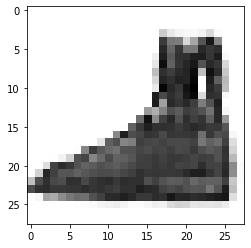

In [140]:
from keras.models import load_model

classes = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 
          'sneaker', 'bag', 'ankle boot']

def generate_latent_points(latent_dim, n_classes=10):
    x_input = np.random.randn(latent_dim)
    z_input = x_input.reshape(1, latent_dim)
    labels = np.array([classes.index(input('Pick class label to generate: '))])
    return [z_input, labels]

model = load_model('conditional_generator.h5')
latent_points, labels = generate_latent_points(100)
# predict requested label on model
X = model.predict([latent_points, labels])
# rescaling
X = (X + 1) / 2.0
plt.imshow(X[0, :, :, 0], cmap='gray_r')